# Pokémon Image Classifier Notebook

This notebook guides you through the process of downloading the Pokémon dataset, training a classification model, evaluating its performance, and performing inference on sample images. The key steps include:

1. **Setup and Imports**
2. **Downloading and Organizing the Dataset**
3. **Data Loading and Preprocessing**
4. **Model Initialization**
5. **Training the Model**
6. **Visualizing Training Metrics**
7. **Model Evaluation and Confusion Matrix**
8. **Inference on Sample Images**


## 1. Setup and Imports

First, let's import all the necessary libraries and set up the environment.


In [1]:
import logging
import os
from pathlib import Path

import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
import torch
from sklearn.metrics import classification_report, confusion_matrix
from timm.data import Mixup  # New: Using Mixup from timm
from torch import cuda, device, nn, optim
from torch.amp import GradScaler
from torch.utils.data import DataLoader
from tqdm import tqdm

from download_dataset import main as download_dataset
from src.data.data_loader import load_data
from src.utils.helpers import save_checkpoint
from src.utils.metrics import MetricsCalculator
from src.visualization.tensorboard_logger import TensorBoardLogger
from train import (
    initialize_model,
    initialize_optimizer,
    initialize_scheduler,
    load_config,
    train_epoch,
)

# Ensure plots are displayed inline
%matplotlib inline

# Set up logging
logging.basicConfig(level=logging.INFO, format='%(asctime)s - %(levelname)s - %(message)s')

# Check for GPU
device = device("cuda" if cuda.is_available() else "cpu")
logging.info(f"Using device: {device}")

# Free cuda memory
if cuda.is_available():
    cuda.empty_cache()
    import gc
    gc.collect()
    


2024-12-19 08:46:10,537 - INFO - Using device: cuda


## 2. Downloading and Organizing the Dataset

We'll use the provided `download_dataset.py` logic to download and organize the Pokémon dataset. Ensure you have your Kaggle API credentials set up in the .env file before running the following cell.


In [2]:


if not os.path.exists("data"):
    os.makedirs("data")

# Check if the data has already been downloaded and if not, download it
if not os.path.exists("data/raw"):
    download_dataset(
        dataset_name="bhawks/pokemon-generation-one-22k",
        raw_path="data/raw",
        processed_path="data/processed",
        extra_path="PokemonData",
    )
    download_dataset(
        dataset_name="thedagger/pokemon-generation-one",
        raw_path="data/raw",
        processed_path="data/processed",
        extra_path="dataset",
        skip_folders=[
            "Nidorina",
            "Nidorino",
        ],  # Skip these folders since nidoran-f and nidoran-m are accidentally in these folders
    )
    download_dataset(
        dataset_name="mikoajkolman/pokemon-images-first-generation17000-files",
        raw_path="data/raw",
        processed_path="data/processed",
        extra_path="pokemon",
        skip_folders=[
            "Nidorina",
            "Nidorino",
        ],  # Skip these folders since nidoran-f and nidoran-m are accidentally in these folders
    )
else:
    logging.info("Data already downloaded")


2024-12-19 08:46:10,750 - INFO - Data already downloaded


## 3. Data Loading, preprocessing, and setup


In [3]:
# Load the configuration file
config = load_config("src/config/config.yaml")

2024-12-19 08:46:10,759 - INFO - Configuration loaded from src/config/config.yaml


In [4]:
# Load dummy data to get number of classes
_, val_loader_dummy, label_to_idx_dummy = load_data(
    processed_path=config["data"]["processed_path"],
    test_size=config["data"]["test_size"],
    batch_size=1,
    img_size=tuple(config["data"]["img_size"]),
    num_workers=config["data"]["num_workers"],
)
num_classes = len(label_to_idx_dummy)
logging.info(f"Number of classes: {num_classes}")

# Initialize model
model = initialize_model(config, num_classes, device)

# Enable tensorboard logging


tensorboard_logger = TensorBoardLogger(
    log_dir="runs/",
    enabled=True,
)

sample_images, _ = next(iter(val_loader_dummy))
sample_images = sample_images.to(device)
tensorboard_logger.add_graph(model, sample_images)


# Load actual train and val loaders
train_loader, val_loader, label_to_idx = load_data(
    processed_path=config["data"]["processed_path"],
    test_size=config["data"]["test_size"],
    batch_size=config["training"].get("batch_size", 32),
    img_size=tuple(config["data"]["img_size"]),
    num_workers=config["data"]["num_workers"],
)
idx_to_label = {v: k for k, v in label_to_idx.items()}

# Initialize optimizer and scheduler
optimizer = initialize_optimizer(config, model)
scheduler = initialize_scheduler(config, optimizer)

# Initialize loss function
 # Loss with Label Smoothing or FocalLoss with class weights
label_smoothing = config["training"].get("label_smoothing", 0.0)
if label_smoothing > 0.0:
    criterion = nn.CrossEntropyLoss(label_smoothing=label_smoothing)
    logging.info(f"Using CrossEntropyLoss with label smoothing: {label_smoothing}")
else:
    criterion = nn.CrossEntropyLoss()
    logging.info("Using CrossEntropyLoss")


# Metrics
metrics_calculator = MetricsCalculator(num_classes=num_classes)
# Mixed Precision Scaler
scaler = GradScaler(enabled=device.type == "cuda")
# Early Stopping parameters
early_stopping_patience = config["training"].get("early_stopping_patience", 10)
epochs_no_improve = 0
best_accuracy = 0.0

# Mixup initialization if needed
use_mixup = config["augmentation"].get("use_mixup", False)
use_cutmix = config["augmentation"].get("use_cutmix", False)
mixup_fn = None
if use_mixup or use_cutmix:
    # timm Mixup handles both based on provided arguments
    mixup_fn = Mixup(
        mixup_alpha=config["augmentation"].get("alpha", 1.0) if use_mixup else 0.0,
        cutmix_alpha=config["augmentation"].get("alpha", 1.0) if use_cutmix else 0.0,
        label_smoothing=label_smoothing,
        num_classes=num_classes,
    )
    logging.info("Using Mixup/CutMix from timm.")

2024-12-19 08:46:11,640 - INFO - Loaded 27320 training samples and 6831 validation samples.


2024-12-19 08:46:11,640 - INFO - Number of classes: 151


2024-12-19 08:46:11,641 - INFO - Number of classes: 151


2024-12-19 08:46:13,649 - INFO - Initialized model: custom


TensorBoard logging enabled. Logs will be saved to runs/


2024-12-19 08:46:30,617 - INFO - Loaded 27320 training samples and 6831 validation samples.


2024-12-19 08:46:30,619 - INFO - Number of classes: 151


2024-12-19 08:46:30,620 - INFO - Initialized AdamW optimizer.


/zhome/4c/9/213311/miniconda3/envs/kantodex-classifier/lib/python3.11/site-packages/torch/optim/lr_scheduler.py:62: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(
2024-12-19 08:46:30,635 - INFO - Initialized ReduceLROnPlateau scheduler.


2024-12-19 08:46:30,635 - INFO - Scheduler 'reduce_lr_on_plateau' has been initialized.


2024-12-19 08:46:30,636 - INFO - Using CrossEntropyLoss with label smoothing: 0.1


2024-12-19 08:46:30,643 - INFO - Using Mixup/CutMix from timm.


## 4. Training the Model

In [5]:

def validate(  # noqa: PLR0913
    model: nn.Module,
    dataloader: DataLoader,
    criterion: nn.Module,
    device: device,
    metrics_calculator: MetricsCalculator,
    tensorboard_logger: TensorBoardLogger | None = None,
    epoch: int = 0,
    idx_to_label: dict[int, str] | None = None,
) ->tuple[float, float]:
    """
    Validate the model on the validation dataset.

    Args:
        model (nn.Module): The model to validate.
        dataloader (DataLoader): DataLoader for validation data.
        criterion (nn.Module): Loss function.
        device (torch.device): Device to perform validation on (CPU or CUDA).
        metrics_calculator (MetricsCalculator): Instance to calculate validation metrics.
        tensorboard_logger (Optional[TensorBoardLogger], optional): Logger for TensorBoard.
            Default is `None`.
        epoch (int, optional): Current epoch number for logging purposes. Default is `0`.
        idx_to_label (Optional[dict[int, str]], optional): Dictionary mapping label indices to
            class names. Default is `None`.

    Returns:
        tuple[float, float]: Tuple containing the average validation loss and the validation
            accuracy.

    """
    model.eval()
    metrics_calculator.reset()

    running_val_loss = 0.0
    with torch.no_grad():
        for images, labels in tqdm(dataloader, desc="Validation", unit="batch"):
            images = images.to(device)
            labels = labels.to(device)
            outputs = model(images)
            loss = criterion(outputs, labels)
            running_val_loss += loss.item()
            metrics_calculator.update(outputs, labels)

    avg_val_loss = running_val_loss / len(dataloader)
    metrics = metrics_calculator.compute()

    if tensorboard_logger:
        epoch_val_accuracy = metrics.get("accuracy", 0.0)
        precision = metrics.get("precision", 0.0)
        recall = metrics.get("recall", 0.0)
        f1_score = metrics.get("f1", 0.0)
        auroc_score = metrics.get("auroc", 0.0)

        tensorboard_logger.add_scalar("Epoch Validation Accuracy", epoch_val_accuracy, epoch + 1)
        tensorboard_logger.add_scalar("Epoch Validation Loss", avg_val_loss, epoch + 1)
        tensorboard_logger.add_scalar("Epoch Validation Precision", precision, epoch + 1)
        tensorboard_logger.add_scalar("Epoch Validation Recall", recall, epoch + 1)
        tensorboard_logger.add_scalar("Epoch Validation F1 Score", f1_score, epoch + 1)
        tensorboard_logger.add_scalar("Epoch Validation Auroc score", auroc_score, epoch + 1)

        if idx_to_label:
            tensorboard_logger.add_class_accuracy(
                class_names=idx_to_label,
                class_accuracy=metrics.get("per_class_accuracy", {}),
                global_step=epoch,
            )
            tensorboard_logger.add_confusion_matrix(
                confusion_matrix=metrics.get("confusion_matrix", np.array([])),
                class_names=idx_to_label,
                global_step=epoch,
            )
            worst_performing = metrics.get("worst_performing_classes", [])[:15]
            logging.info(f"Worst performing classes: {worst_performing}")
            tensorboard_logger.add_text(
                "Worst Performing Classes",
                str(worst_performing),
                epoch,
            )
            for idx, acc in metrics.get("per_class_accuracy", {}).items():
                class_name = idx_to_label.get(idx, f"Class_{idx}")
                tensorboard_logger.add_scalar(
                    f"Class Accuracy/{class_name}",
                    acc,
                    epoch,
                )
        logging.info(
            f"Epoch Validation Loss: {avg_val_loss:.4f}, Precision: {precision:.2f}%, "
            f"Recall: {recall:.2f}%, F1 Score: {f1_score:.2f}%, AUROC: {auroc_score:.2f}%",
        )

    return avg_val_loss, metrics.get("accuracy", 0.0)

In [6]:
train_losses = []
val_losses = []
train_accuracies = []
val_accuracies = []

precision_scores = []
recall_scores = []
f1_scores = []

learning_rates = []


# Training loop
num_epochs = config["training"].get("epochs", 100)
for epoch in range(0, num_epochs):
    logging.info(f"Starting epoch {epoch + 1}/{num_epochs}")

    train_loss, train_accuracy = train_epoch(
        model=model,
        dataloader=train_loader,
        criterion=criterion,
        optimizer=optimizer,
        device=device,
        scaler=scaler,
        metrics_calculator=metrics_calculator,
        tensorboard_logger=tensorboard_logger,
        mixup_fn=mixup_fn,
        epoch=epoch + 1,
    )
    train_losses.append(train_loss)
    train_accuracies.append(train_accuracy)
    logging.info(
        f"Epoch [{epoch + 1}/{num_epochs}], "
        f"Loss: {train_loss:.4f}, Accuracy: {train_accuracy:.2f}%",
    )

    metrics = metrics_calculator.compute()
    precision = metrics.get("precision", 0.0)
    recall = metrics.get("recall", 0.0)
    f1_score = metrics.get("f1", 0.0)
    precision_scores.append(precision)
    recall_scores.append(recall)
    f1_scores.append(f1_score)
    logging.info(
        f"Precision: {precision:.2f}%, Recall: {recall:.2f}%, F1 Score: {f1_score:.2f}%",
    )


    if tensorboard_logger:
        tensorboard_logger.add_scalar("Training Precision", precision, epoch + 1)
        tensorboard_logger.add_scalar("Training Recall", recall, epoch + 1)
        tensorboard_logger.add_scalar("Training F1 Score", f1_score, epoch + 1)

    # Scheduler step
    if scheduler:
        if isinstance(scheduler, optim.lr_scheduler.ReduceLROnPlateau):
            scheduler.step(train_loss)
        else:
            scheduler.step()
        current_lr = optimizer.param_groups[0]["lr"]
        logging.info(f"Learning Rate: {current_lr}")
        if tensorboard_logger:
            tensorboard_logger.add_scalar("Training Learning Rate", current_lr, epoch + 1)
        learning_rates.append(current_lr)

    val_loss, val_accuracy = validate(
        model=model,
        dataloader=val_loader,
        criterion=criterion,
        device=device,
        metrics_calculator=metrics_calculator,
        tensorboard_logger=tensorboard_logger,
        epoch=epoch + 1,
        idx_to_label=idx_to_label,
    )
    val_losses.append(val_loss)
    val_accuracies.append(val_accuracy)
    logging.info(f"Validation Accuracy: {val_accuracy:.2f}%")

    # Check for best model
    is_best = val_accuracy > best_accuracy
    if is_best:
        best_accuracy = val_accuracy
        epochs_no_improve = 0
        logging.info(f"New best accuracy: {best_accuracy:.2f}%")
        if tensorboard_logger:
            tensorboard_logger.add_scalar("Best Accuracy", best_accuracy, epoch + 1)
    else:
        epochs_no_improve += 1
        logging.info(f"No improvement in validation accuracy for {epochs_no_improve} epoch(s).")

    # Save checkpoint
    checkpoint_dir = Path(config["training"].get("checkpoint_path", "checkpoints"))
    checkpoint_dir.mkdir(parents=True, exist_ok=True)
    save_checkpoint(
        model=model,
        optimizer=optimizer,
        epoch=epoch + 1,
        checkpoint_dir=str(checkpoint_dir),
        scheduler=scheduler,
        scaler=scaler,
        is_best=is_best,
        best_accuracy=best_accuracy,
    )

    if epochs_no_improve >= early_stopping_patience:
        logging.info("Early stopping triggered.")
        break

logging.info("Training complete.")
if tensorboard_logger:
    tensorboard_logger.close()

2024-12-19 08:46:30,665 - INFO - Starting epoch 1/50


Training:   0%|          | 0/55 [00:00<?, ?batch/s]

Training:   2%|▏         | 1/55 [00:30<27:27, 30.52s/batch]

Training:   4%|▎         | 2/55 [00:31<11:39, 13.19s/batch]

Training:   5%|▌         | 3/55 [00:32<06:37,  7.65s/batch]

Training:   7%|▋         | 4/55 [00:33<04:17,  5.04s/batch]

Training:   9%|▉         | 5/55 [00:38<04:11,  5.03s/batch]

Training:  11%|█         | 6/55 [00:39<03:00,  3.67s/batch]

Training:  13%|█▎        | 7/55 [00:40<02:15,  2.82s/batch]

Training:  15%|█▍        | 8/55 [00:41<01:45,  2.26s/batch]

Training:  16%|█▋        | 9/55 [00:57<04:50,  6.30s/batch]

Training:  18%|█▊        | 10/55 [00:58<03:30,  4.68s/batch]

Training:  20%|██        | 11/55 [01:00<02:54,  3.97s/batch]

Training:  22%|██▏       | 12/55 [01:01<02:12,  3.08s/batch]

Training:  24%|██▎       | 13/55 [01:14<04:19,  6.17s/batch]

Training:  25%|██▌       | 14/55 [01:15<03:09,  4.62s/batch]

Training:  27%|██▋       | 15/55 [01:16<02:21,  3.55s/batch]

Training:  29%|██▉       | 16/55 [01:17<01:49,  2.80s/batch]

Training:  31%|███       | 17/55 [01:31<03:52,  6.11s/batch]

Training:  33%|███▎      | 18/55 [01:32<02:49,  4.59s/batch]

Training:  35%|███▍      | 19/55 [01:35<02:19,  3.88s/batch]

Training:  36%|███▋      | 20/55 [01:36<01:46,  3.03s/batch]

Training:  38%|███▊      | 21/55 [01:48<03:22,  5.95s/batch]

Training:  40%|████      | 22/55 [01:49<02:27,  4.48s/batch]

Training:  42%|████▏     | 23/55 [01:50<01:50,  3.46s/batch]

Training:  44%|████▎     | 24/55 [01:52<01:24,  2.74s/batch]

Training:  45%|████▌     | 25/55 [02:04<02:49,  5.63s/batch]

Training:  47%|████▋     | 26/55 [02:05<02:03,  4.26s/batch]

Training:  49%|████▉     | 27/55 [02:07<01:37,  3.48s/batch]

Training:  51%|█████     | 28/55 [02:08<01:14,  2.75s/batch]

Training:  53%|█████▎    | 29/55 [02:21<02:33,  5.89s/batch]

Training:  55%|█████▍    | 30/55 [02:22<01:51,  4.44s/batch]

Training:  56%|█████▋    | 31/55 [02:23<01:22,  3.43s/batch]

Training:  58%|█████▊    | 32/55 [02:24<01:02,  2.74s/batch]

Training:  60%|██████    | 33/55 [02:37<02:04,  5.65s/batch]

Training:  62%|██████▏   | 34/55 [02:38<01:29,  4.27s/batch]

Training:  64%|██████▎   | 35/55 [02:39<01:06,  3.31s/batch]

Training:  65%|██████▌   | 36/55 [02:42<01:02,  3.26s/batch]

Training:  67%|██████▋   | 37/55 [02:53<01:41,  5.64s/batch]

Training:  69%|██████▉   | 38/55 [02:54<01:12,  4.27s/batch]

Training:  71%|███████   | 39/55 [02:55<00:52,  3.30s/batch]

Training:  73%|███████▎  | 40/55 [03:00<00:55,  3.69s/batch]

Training:  75%|███████▍  | 41/55 [03:12<01:28,  6.33s/batch]

Training:  76%|███████▋  | 42/55 [03:13<01:01,  4.75s/batch]

Training:  78%|███████▊  | 43/55 [03:15<00:46,  3.87s/batch]

Training:  80%|████████  | 44/55 [03:17<00:35,  3.26s/batch]

Training:  82%|████████▏ | 45/55 [03:29<00:58,  5.81s/batch]

Training:  84%|████████▎ | 46/55 [03:30<00:39,  4.38s/batch]

Training:  85%|████████▌ | 47/55 [03:31<00:27,  3.41s/batch]

Training:  87%|████████▋ | 48/55 [03:34<00:23,  3.33s/batch]

Training:  89%|████████▉ | 49/55 [03:43<00:30,  5.08s/batch]

Training:  91%|█████████ | 50/55 [03:44<00:19,  3.87s/batch]

Training:  93%|█████████▎| 51/55 [03:46<00:12,  3.12s/batch]

Training:  95%|█████████▍| 52/55 [03:50<00:10,  3.51s/batch]

Training:  96%|█████████▋| 53/55 [04:00<00:10,  5.41s/batch]

Training:  98%|█████████▊| 54/55 [04:01<00:04,  4.10s/batch]

Training: 100%|██████████| 55/55 [04:02<00:00,  3.07s/batch]

Training: 100%|██████████| 55/55 [04:02<00:00,  4.40s/batch]

2024-12-19 08:50:35,594 - INFO - Epoch [1/50], Loss: 4.7026, Accuracy: 8.70%


2024-12-19 08:50:35,595 - INFO - Precision: 6.91%, Recall: 7.20%, F1 Score: 6.52%


2024-12-19 08:50:35,596 - INFO - Learning Rate: 0.0005


Validation:   0%|          | 0/14 [00:00<?, ?batch/s]

Validation:   7%|▋         | 1/14 [00:10<02:20, 10.83s/batch]

Validation:  14%|█▍        | 2/14 [00:11<00:58,  4.85s/batch]

Validation:  21%|██▏       | 3/14 [00:12<00:32,  2.94s/batch]

Validation:  29%|██▊       | 4/14 [00:12<00:20,  2.04s/batch]

Validation:  36%|███▌      | 5/14 [00:19<00:33,  3.68s/batch]

Validation:  43%|████▎     | 6/14 [00:20<00:21,  2.65s/batch]

Validation:  50%|█████     | 7/14 [00:20<00:13,  2.00s/batch]

Validation:  57%|█████▋    | 8/14 [00:21<00:09,  1.57s/batch]

Validation:  64%|██████▍   | 9/14 [00:28<00:16,  3.36s/batch]

Validation:  71%|███████▏  | 10/14 [00:29<00:10,  2.52s/batch]

Validation:  79%|███████▊  | 11/14 [00:29<00:05,  1.95s/batch]

Validation:  86%|████████▌ | 12/14 [00:30<00:03,  1.56s/batch]

Validation:  93%|█████████▎| 13/14 [00:37<00:03,  3.19s/batch]

Validation: 100%|██████████| 14/14 [00:38<00:00,  2.36s/batch]

Validation: 100%|██████████| 14/14 [00:38<00:00,  2.72s/batch]

/zhome/4c/9/213311/KantoDex-Classifier/src/visualization/tensorboard_logger.py:243: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=labels, y=accuracies, palette="viridis", ax=ax)


2024-12-19 08:51:44,835 - INFO - Worst performing classes: [(0, 0.0), (4, 0.0), (6, 0.0), (20, 0.0), (29, 0.0), (31, 0.0), (34, 0.0), (45, 0.0), (47, 0.0), (53, 0.0), (54, 0.0), (55, 0.0), (60, 0.0), (61, 0.0), (66, 0.0)]


2024-12-19 08:51:44,991 - INFO - Epoch Validation Loss: 3.5469, Precision: 27.84%, Recall: 20.36%, F1 Score: 17.37%, AUROC: 93.25%


2024-12-19 08:51:44,992 - INFO - Validation Accuracy: 22.90%


2024-12-19 08:51:44,993 - INFO - New best accuracy: 22.90%


2024-12-19 08:51:46,172 - INFO - Checkpoint saved at models/checkpoints/checkpoint_epoch_2.pth


2024-12-19 08:51:47,287 - INFO - Best model updated at models/checkpoints/best_model.pth with accuracy: 22.90%


2024-12-19 08:51:47,288 - INFO - Starting epoch 2/50


Training:   0%|          | 0/55 [00:00<?, ?batch/s]

Training:   2%|▏         | 1/55 [00:16<15:12, 16.90s/batch]

Training:   4%|▎         | 2/55 [00:18<07:03,  7.99s/batch]

Training:   5%|▌         | 3/55 [00:19<04:10,  4.82s/batch]

Training:   7%|▋         | 4/55 [00:21<02:55,  3.45s/batch]

Training:   9%|▉         | 5/55 [00:29<04:28,  5.37s/batch]

Training:  11%|█         | 6/55 [00:33<03:58,  4.86s/batch]

Training:  13%|█▎        | 7/55 [00:36<03:17,  4.12s/batch]

Training:  15%|█▍        | 8/55 [00:37<02:28,  3.15s/batch]

Training:  16%|█▋        | 9/55 [00:43<03:11,  4.16s/batch]

Training:  18%|█▊        | 10/55 [00:51<04:02,  5.38s/batch]

Training:  20%|██        | 11/55 [00:52<02:58,  4.06s/batch]

Training:  22%|██▏       | 12/55 [00:53<02:15,  3.14s/batch]

Training:  24%|██▎       | 13/55 [01:01<03:12,  4.58s/batch]

Training:  25%|██▌       | 14/55 [01:05<03:02,  4.45s/batch]

Training:  27%|██▋       | 15/55 [01:07<02:18,  3.46s/batch]

Training:  29%|██▉       | 16/55 [01:09<02:00,  3.09s/batch]

Training:  31%|███       | 17/55 [01:16<02:43,  4.31s/batch]

Training:  33%|███▎      | 18/55 [01:22<02:58,  4.82s/batch]

Training:  35%|███▍      | 19/55 [01:23<02:12,  3.69s/batch]

Training:  36%|███▋      | 20/55 [01:25<01:46,  3.05s/batch]

Training:  38%|███▊      | 21/55 [01:32<02:22,  4.20s/batch]

Training:  40%|████      | 22/55 [01:38<02:39,  4.82s/batch]

Training:  42%|████▏     | 23/55 [01:39<01:58,  3.69s/batch]

Training:  44%|████▎     | 24/55 [01:40<01:29,  2.90s/batch]

Training:  45%|████▌     | 25/55 [01:47<02:07,  4.25s/batch]

Training:  47%|████▋     | 26/55 [01:52<02:10,  4.49s/batch]

Training:  49%|████▉     | 27/55 [01:53<01:36,  3.46s/batch]

Training:  51%|█████     | 28/55 [01:55<01:20,  2.97s/batch]

Training:  53%|█████▎    | 29/55 [02:07<02:27,  5.68s/batch]

Training:  55%|█████▍    | 30/55 [02:08<01:47,  4.29s/batch]

Training:  56%|█████▋    | 31/55 [02:09<01:19,  3.32s/batch]

Training:  58%|█████▊    | 32/55 [02:12<01:08,  3.00s/batch]

Training:  60%|██████    | 33/55 [02:24<02:07,  5.81s/batch]

Training:  62%|██████▏   | 34/55 [02:25<01:32,  4.38s/batch]

Training:  64%|██████▎   | 35/55 [02:28<01:16,  3.84s/batch]

Training:  65%|██████▌   | 36/55 [02:29<00:57,  3.00s/batch]

Training:  67%|██████▋   | 37/55 [02:41<01:43,  5.74s/batch]

Training:  69%|██████▉   | 38/55 [02:42<01:13,  4.34s/batch]

Training:  71%|███████   | 39/55 [02:45<01:02,  3.94s/batch]

Training:  73%|███████▎  | 40/55 [02:46<00:46,  3.07s/batch]

Training:  75%|███████▍  | 41/55 [02:55<01:08,  4.91s/batch]

Training:  76%|███████▋  | 42/55 [02:56<00:48,  3.76s/batch]

Training:  78%|███████▊  | 43/55 [03:02<00:53,  4.46s/batch]

Training:  80%|████████  | 44/55 [03:03<00:37,  3.44s/batch]

Training:  82%|████████▏ | 45/55 [03:15<00:57,  5.79s/batch]

Training:  84%|████████▎ | 46/55 [03:16<00:39,  4.37s/batch]

Training:  85%|████████▌ | 47/55 [03:18<00:31,  3.90s/batch]

Training:  87%|████████▋ | 48/55 [03:20<00:21,  3.05s/batch]

Training:  89%|████████▉ | 49/55 [03:31<00:33,  5.54s/batch]

Training:  91%|█████████ | 50/55 [03:32<00:20,  4.20s/batch]

Training:  93%|█████████▎| 51/55 [03:33<00:13,  3.25s/batch]

Training:  95%|█████████▍| 52/55 [03:34<00:07,  2.59s/batch]

Training:  96%|█████████▋| 53/55 [03:43<00:08,  4.36s/batch]

Training:  98%|█████████▊| 54/55 [03:44<00:03,  3.36s/batch]

Training: 100%|██████████| 55/55 [03:44<00:00,  2.56s/batch]

Training: 100%|██████████| 55/55 [03:44<00:00,  4.09s/batch]


2024-12-19 08:55:32,203 - INFO - Epoch [2/50], Loss: 4.1965, Accuracy: 23.00%


2024-12-19 08:55:32,204 - INFO - Precision: 20.99%, Recall: 20.85%, F1 Score: 19.77%


2024-12-19 08:55:32,204 - INFO - Learning Rate: 0.0005


Validation:   0%|          | 0/14 [00:00<?, ?batch/s]

Validation:   7%|▋         | 1/14 [00:08<01:45,  8.08s/batch]

Validation:  14%|█▍        | 2/14 [00:08<00:44,  3.72s/batch]

Validation:  21%|██▏       | 3/14 [00:09<00:25,  2.32s/batch]

Validation:  29%|██▊       | 4/14 [00:10<00:16,  1.66s/batch]

Validation:  36%|███▌      | 5/14 [00:16<00:28,  3.21s/batch]

Validation:  43%|████▎     | 6/14 [00:16<00:18,  2.34s/batch]

Validation:  50%|█████     | 7/14 [00:17<00:12,  1.79s/batch]

Validation:  57%|█████▋    | 8/14 [00:17<00:08,  1.43s/batch]

Validation:  64%|██████▍   | 9/14 [00:23<00:13,  2.74s/batch]

Validation:  71%|███████▏  | 10/14 [00:24<00:08,  2.09s/batch]

Validation:  79%|███████▊  | 11/14 [00:24<00:04,  1.65s/batch]

Validation:  86%|████████▌ | 12/14 [00:25<00:02,  1.35s/batch]

Validation:  93%|█████████▎| 13/14 [00:30<00:02,  2.44s/batch]

Validation: 100%|██████████| 14/14 [00:30<00:00,  1.84s/batch]

Validation: 100%|██████████| 14/14 [00:31<00:00,  2.22s/batch]


/zhome/4c/9/213311/KantoDex-Classifier/src/visualization/tensorboard_logger.py:243: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=labels, y=accuracies, palette="viridis", ax=ax)


2024-12-19 08:56:32,808 - INFO - Worst performing classes: [(69, 0.0), (88, 0.0), (89, 0.0), (96, 0.0), (97, 0.0), (121, 0.0), (150, 0.0), (2, 2.2222222222222223), (77, 2.2222222222222223), (145, 2.3255813953488373), (147, 2.380952380952381), (118, 2.631578947368421), (46, 3.125), (67, 3.225806451612903), (90, 3.8461538461538463)]


2024-12-19 08:56:32,965 - INFO - Epoch Validation Loss: 2.9476, Precision: 50.65%, Recall: 37.89%, F1 Score: 37.08%, AUROC: 96.04%


2024-12-19 08:56:32,966 - INFO - Validation Accuracy: 40.96%


2024-12-19 08:56:32,966 - INFO - New best accuracy: 40.96%


2024-12-19 08:56:34,039 - INFO - Checkpoint saved at models/checkpoints/checkpoint_epoch_3.pth


2024-12-19 08:56:35,148 - INFO - Best model updated at models/checkpoints/best_model.pth with accuracy: 40.96%


2024-12-19 08:56:35,149 - INFO - Starting epoch 3/50


Training:   0%|          | 0/55 [00:00<?, ?batch/s]

Training:   2%|▏         | 1/55 [00:13<12:31, 13.92s/batch]

Training:   4%|▎         | 2/55 [00:17<07:00,  7.94s/batch]

Training:   5%|▌         | 3/55 [00:18<04:11,  4.83s/batch]

Training:   7%|▋         | 4/55 [00:19<02:50,  3.34s/batch]

Training:   9%|▉         | 5/55 [00:29<04:37,  5.55s/batch]

Training:  11%|█         | 6/55 [00:34<04:33,  5.57s/batch]

Training:  13%|█▎        | 7/55 [00:36<03:16,  4.09s/batch]

Training:  15%|█▍        | 8/55 [00:37<02:26,  3.13s/batch]

Training:  16%|█▋        | 9/55 [00:45<03:43,  4.86s/batch]

Training:  18%|█▊        | 10/55 [00:50<03:37,  4.84s/batch]

Training:  20%|██        | 11/55 [00:51<02:42,  3.68s/batch]

Training:  22%|██▏       | 12/55 [00:52<02:03,  2.88s/batch]

Training:  24%|██▎       | 13/55 [01:03<03:39,  5.23s/batch]

Training:  25%|██▌       | 14/55 [01:06<03:12,  4.69s/batch]

Training:  27%|██▋       | 15/55 [01:07<02:23,  3.59s/batch]

Training:  29%|██▉       | 16/55 [01:08<01:50,  2.83s/batch]

Training:  31%|███       | 17/55 [01:19<03:22,  5.34s/batch]

Training:  33%|███▎      | 18/55 [01:23<02:57,  4.80s/batch]

Training:  35%|███▍      | 19/55 [01:24<02:12,  3.67s/batch]

Training:  36%|███▋      | 20/55 [01:25<01:41,  2.89s/batch]

Training:  38%|███▊      | 21/55 [01:34<02:38,  4.65s/batch]

Training:  40%|████      | 22/55 [01:39<02:37,  4.78s/batch]

Training:  42%|████▏     | 23/55 [01:40<01:57,  3.66s/batch]

Training:  44%|████▎     | 24/55 [01:41<01:29,  2.88s/batch]

Training:  45%|████▌     | 25/55 [01:50<02:18,  4.60s/batch]

Training:  47%|████▋     | 26/55 [01:52<01:51,  3.86s/batch]

Training:  49%|████▉     | 27/55 [01:54<01:33,  3.33s/batch]

Training:  51%|█████     | 28/55 [01:55<01:11,  2.65s/batch]

Training:  53%|█████▎    | 29/55 [02:09<02:37,  6.04s/batch]

Training:  55%|█████▍    | 30/55 [02:12<02:08,  5.13s/batch]

Training:  56%|█████▋    | 31/55 [02:13<01:33,  3.91s/batch]

Training:  58%|█████▊    | 32/55 [02:14<01:10,  3.05s/batch]

Training:  60%|██████    | 33/55 [02:24<01:54,  5.21s/batch]

Training:  62%|██████▏   | 34/55 [02:28<01:38,  4.69s/batch]

Training:  64%|██████▎   | 35/55 [02:29<01:11,  3.60s/batch]

Training:  65%|██████▌   | 36/55 [02:30<00:53,  2.83s/batch]

Training:  67%|██████▋   | 37/55 [02:38<01:20,  4.47s/batch]

Training:  69%|██████▉   | 38/55 [02:44<01:22,  4.83s/batch]

Training:  71%|███████   | 39/55 [02:45<00:59,  3.70s/batch]

Training:  73%|███████▎  | 40/55 [02:46<00:43,  2.90s/batch]

Training:  75%|███████▍  | 41/55 [02:55<01:07,  4.81s/batch]

Training:  76%|███████▋  | 42/55 [03:00<01:02,  4.84s/batch]

Training:  78%|███████▊  | 43/55 [03:01<00:44,  3.70s/batch]

Training:  80%|████████  | 44/55 [03:02<00:31,  2.91s/batch]

Training:  82%|████████▏ | 45/55 [03:10<00:44,  4.50s/batch]

Training:  84%|████████▎ | 46/55 [03:14<00:37,  4.19s/batch]

Training:  85%|████████▌ | 47/55 [03:15<00:25,  3.25s/batch]

Training:  87%|████████▋ | 48/55 [03:16<00:18,  2.59s/batch]

Training:  89%|████████▉ | 49/55 [03:25<00:27,  4.53s/batch]

Training:  91%|█████████ | 50/55 [03:31<00:24,  4.99s/batch]

Training:  93%|█████████▎| 51/55 [03:32<00:15,  3.81s/batch]

Training:  95%|█████████▍| 52/55 [03:33<00:08,  2.98s/batch]

Training:  96%|█████████▋| 53/55 [03:38<00:06,  3.47s/batch]

Training:  98%|█████████▊| 54/55 [03:43<00:03,  3.96s/batch]

Training: 100%|██████████| 55/55 [03:44<00:00,  2.97s/batch]

Training: 100%|██████████| 55/55 [03:44<00:00,  4.08s/batch]


2024-12-19 09:00:19,394 - INFO - Epoch [3/50], Loss: 3.9495, Accuracy: 33.71%


2024-12-19 09:00:19,395 - INFO - Precision: 31.88%, Recall: 31.50%, F1 Score: 30.73%


2024-12-19 09:00:19,396 - INFO - Learning Rate: 0.0005


Validation:   0%|          | 0/14 [00:00<?, ?batch/s]

Validation:   7%|▋         | 1/14 [00:08<01:49,  8.39s/batch]

Validation:  14%|█▍        | 2/14 [00:09<00:46,  3.84s/batch]

Validation:  21%|██▏       | 3/14 [00:09<00:26,  2.39s/batch]

Validation:  29%|██▊       | 4/14 [00:10<00:17,  1.71s/batch]

Validation:  36%|███▌      | 5/14 [00:16<00:28,  3.19s/batch]

Validation:  43%|████▎     | 6/14 [00:16<00:18,  2.33s/batch]

Validation:  50%|█████     | 7/14 [00:17<00:12,  1.78s/batch]

Validation:  57%|█████▋    | 8/14 [00:18<00:08,  1.43s/batch]

Validation:  64%|██████▍   | 9/14 [00:23<00:13,  2.79s/batch]

Validation:  71%|███████▏  | 10/14 [00:24<00:08,  2.13s/batch]

Validation:  79%|███████▊  | 11/14 [00:25<00:05,  1.68s/batch]

Validation:  86%|████████▌ | 12/14 [00:25<00:02,  1.37s/batch]

Validation:  93%|█████████▎| 13/14 [00:30<00:02,  2.47s/batch]

Validation: 100%|██████████| 14/14 [00:31<00:00,  1.86s/batch]

Validation: 100%|██████████| 14/14 [00:31<00:00,  2.25s/batch]


/zhome/4c/9/213311/KantoDex-Classifier/src/visualization/tensorboard_logger.py:243: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=labels, y=accuracies, palette="viridis", ax=ax)


2024-12-19 09:01:21,826 - INFO - Worst performing classes: [(88, 0.0), (89, 0.0), (99, 0.0), (96, 3.8461538461538463), (67, 6.451612903225806), (0, 10.344827586206897), (85, 11.428571428571429), (2, 13.333333333333334), (77, 13.333333333333334), (78, 14.634146341463413), (81, 15.384615384615385), (34, 17.073170731707318), (137, 18.181818181818183), (53, 19.51219512195122), (100, 20.0)]


2024-12-19 09:01:21,984 - INFO - Epoch Validation Loss: 2.4516, Precision: 61.72%, Recall: 54.05%, F1 Score: 53.77%, AUROC: 97.44%


2024-12-19 09:01:21,985 - INFO - Validation Accuracy: 56.30%


2024-12-19 09:01:21,986 - INFO - New best accuracy: 56.30%


2024-12-19 09:01:23,160 - INFO - Checkpoint saved at models/checkpoints/checkpoint_epoch_4.pth


2024-12-19 09:01:23,235 - INFO - Removed old checkpoint models/checkpoints/checkpoint_epoch_2.pth


2024-12-19 09:01:24,450 - INFO - Best model updated at models/checkpoints/best_model.pth with accuracy: 56.30%


2024-12-19 09:01:24,451 - INFO - Starting epoch 4/50


Training:   0%|          | 0/55 [00:00<?, ?batch/s]

Training:   2%|▏         | 1/55 [00:15<13:46, 15.30s/batch]

Training:   4%|▎         | 2/55 [00:21<08:48,  9.97s/batch]

Training:   5%|▌         | 3/55 [00:22<05:06,  5.90s/batch]

Training:   7%|▋         | 4/55 [00:23<03:23,  3.98s/batch]

Training:   9%|▉         | 5/55 [00:34<05:14,  6.29s/batch]

Training:  11%|█         | 6/55 [00:36<03:58,  4.86s/batch]

Training:  13%|█▎        | 7/55 [00:37<02:53,  3.62s/batch]

Training:  15%|█▍        | 8/55 [00:38<02:11,  2.80s/batch]

Training:  16%|█▋        | 9/55 [00:49<04:13,  5.51s/batch]

Training:  18%|█▊        | 10/55 [00:50<03:06,  4.14s/batch]

Training:  20%|██        | 11/55 [00:51<02:20,  3.20s/batch]

Training:  22%|██▏       | 12/55 [00:52<01:49,  2.55s/batch]

Training:  24%|██▎       | 13/55 [01:04<03:39,  5.22s/batch]

Training:  25%|██▌       | 14/55 [01:06<03:01,  4.42s/batch]

Training:  27%|██▋       | 15/55 [01:07<02:16,  3.41s/batch]

Training:  29%|██▉       | 16/55 [01:08<01:45,  2.70s/batch]

Training:  31%|███       | 17/55 [01:17<02:51,  4.51s/batch]

Training:  33%|███▎      | 18/55 [01:22<02:50,  4.60s/batch]

Training:  35%|███▍      | 19/55 [01:23<02:07,  3.54s/batch]

Training:  36%|███▋      | 20/55 [01:24<01:37,  2.79s/batch]

Training:  38%|███▊      | 21/55 [01:33<02:35,  4.56s/batch]

Training:  40%|████      | 22/55 [01:37<02:26,  4.45s/batch]

Training:  42%|████▏     | 23/55 [01:38<01:49,  3.43s/batch]

Training:  44%|████▎     | 24/55 [01:40<01:28,  2.87s/batch]

Training:  45%|████▌     | 25/55 [01:48<02:12,  4.43s/batch]

Training:  47%|████▋     | 26/55 [01:52<02:10,  4.50s/batch]

Training:  49%|████▉     | 27/55 [01:53<01:37,  3.47s/batch]

Training:  51%|█████     | 28/55 [01:54<01:14,  2.75s/batch]

Training:  53%|█████▎    | 29/55 [02:03<01:56,  4.46s/batch]

Training:  55%|█████▍    | 30/55 [02:06<01:45,  4.20s/batch]

Training:  56%|█████▋    | 31/55 [02:09<01:27,  3.65s/batch]

Training:  58%|█████▊    | 32/55 [02:10<01:06,  2.87s/batch]

Training:  60%|██████    | 33/55 [02:18<01:35,  4.36s/batch]

Training:  62%|██████▏   | 34/55 [02:20<01:18,  3.74s/batch]

Training:  64%|██████▎   | 35/55 [02:24<01:13,  3.67s/batch]

Training:  65%|██████▌   | 36/55 [02:25<00:58,  3.09s/batch]

Training:  67%|██████▋   | 37/55 [02:34<01:27,  4.88s/batch]

Training:  69%|██████▉   | 38/55 [02:35<01:03,  3.74s/batch]

Training:  71%|███████   | 39/55 [02:39<00:56,  3.55s/batch]

Training:  73%|███████▎  | 40/55 [02:42<00:53,  3.57s/batch]

Training:  75%|███████▍  | 41/55 [02:49<01:05,  4.69s/batch]

Training:  76%|███████▋  | 42/55 [02:52<00:51,  3.97s/batch]

Training:  78%|███████▊  | 43/55 [02:54<00:40,  3.38s/batch]

Training:  80%|████████  | 44/55 [02:57<00:38,  3.48s/batch]

Training:  82%|████████▏ | 45/55 [03:09<00:59,  5.90s/batch]

Training:  84%|████████▎ | 46/55 [03:13<00:48,  5.37s/batch]

Training:  85%|████████▌ | 47/55 [03:14<00:32,  4.08s/batch]

Training:  87%|████████▋ | 48/55 [03:15<00:22,  3.17s/batch]

Training:  89%|████████▉ | 49/55 [03:24<00:29,  4.91s/batch]

Training:  91%|█████████ | 50/55 [03:28<00:23,  4.68s/batch]

Training:  93%|█████████▎| 51/55 [03:29<00:14,  3.59s/batch]

Training:  95%|█████████▍| 52/55 [03:30<00:08,  2.83s/batch]

Training:  96%|█████████▋| 53/55 [03:39<00:09,  4.58s/batch]

Training:  98%|█████████▊| 54/55 [03:41<00:03,  3.84s/batch]

Training: 100%|██████████| 55/55 [03:42<00:00,  2.89s/batch]

Training: 100%|██████████| 55/55 [03:42<00:00,  4.05s/batch]


2024-12-19 09:05:07,030 - INFO - Epoch [4/50], Loss: 3.7734, Accuracy: 43.11%


2024-12-19 09:05:07,031 - INFO - Precision: 41.86%, Recall: 41.07%, F1 Score: 40.77%


2024-12-19 09:05:07,032 - INFO - Learning Rate: 0.0005


Validation:   0%|          | 0/14 [00:00<?, ?batch/s]

Validation:   7%|▋         | 1/14 [00:07<01:43,  7.96s/batch]

Validation:  14%|█▍        | 2/14 [00:08<00:43,  3.66s/batch]

Validation:  21%|██▏       | 3/14 [00:09<00:25,  2.29s/batch]

Validation:  29%|██▊       | 4/14 [00:09<00:16,  1.65s/batch]

Validation:  36%|███▌      | 5/14 [00:15<00:28,  3.17s/batch]

Validation:  43%|████▎     | 6/14 [00:16<00:18,  2.32s/batch]

Validation:  50%|█████     | 7/14 [00:17<00:12,  1.77s/batch]

Validation:  57%|█████▋    | 8/14 [00:17<00:08,  1.42s/batch]

Validation:  64%|██████▍   | 9/14 [00:23<00:13,  2.71s/batch]

Validation:  71%|███████▏  | 10/14 [00:23<00:08,  2.08s/batch]

Validation:  79%|███████▊  | 11/14 [00:24<00:04,  1.64s/batch]

Validation:  86%|████████▌ | 12/14 [00:25<00:02,  1.34s/batch]

Validation:  93%|█████████▎| 13/14 [00:30<00:02,  2.37s/batch]

Validation: 100%|██████████| 14/14 [00:30<00:00,  1.79s/batch]

Validation: 100%|██████████| 14/14 [00:30<00:00,  2.18s/batch]


/zhome/4c/9/213311/KantoDex-Classifier/src/visualization/tensorboard_logger.py:243: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=labels, y=accuracies, palette="viridis", ax=ax)


2024-12-19 09:06:08,217 - INFO - Worst performing classes: [(85, 2.857142857142857), (96, 3.8461538461538463), (88, 7.6923076923076925), (98, 7.894736842105263), (97, 10.344827586206897), (49, 13.20754716981132), (78, 14.634146341463413), (143, 14.893617021276595), (99, 19.230769230769234), (100, 20.0), (122, 21.21212121212121), (38, 25.0), (81, 25.64102564102564), (37, 27.86885245901639), (16, 28.57142857142857)]


2024-12-19 09:06:08,389 - INFO - Epoch Validation Loss: 2.3597, Precision: 65.04%, Recall: 55.93%, F1 Score: 56.00%, AUROC: 97.96%


2024-12-19 09:06:08,389 - INFO - Validation Accuracy: 57.78%


2024-12-19 09:06:08,390 - INFO - New best accuracy: 57.78%


2024-12-19 09:06:09,535 - INFO - Checkpoint saved at models/checkpoints/checkpoint_epoch_5.pth


2024-12-19 09:06:09,618 - INFO - Removed old checkpoint models/checkpoints/checkpoint_epoch_3.pth


2024-12-19 09:06:10,917 - INFO - Best model updated at models/checkpoints/best_model.pth with accuracy: 57.78%


2024-12-19 09:06:10,918 - INFO - Starting epoch 5/50


Training:   0%|          | 0/55 [00:00<?, ?batch/s]

Training:   2%|▏         | 1/55 [00:16<14:50, 16.49s/batch]

Training:   4%|▎         | 2/55 [00:22<08:52, 10.05s/batch]

Training:   5%|▌         | 3/55 [00:23<05:08,  5.94s/batch]

Training:   7%|▋         | 4/55 [00:24<03:24,  4.01s/batch]

Training:   9%|▉         | 5/55 [00:32<04:44,  5.69s/batch]

Training:  11%|█         | 6/55 [00:39<04:55,  6.03s/batch]

Training:  13%|█▎        | 7/55 [00:40<03:31,  4.41s/batch]

Training:  15%|█▍        | 8/55 [00:41<02:36,  3.34s/batch]

Training:  16%|█▋        | 9/55 [00:46<02:58,  3.89s/batch]

Training:  18%|█▊        | 10/55 [00:55<04:06,  5.49s/batch]

Training:  20%|██        | 11/55 [00:56<03:01,  4.13s/batch]

Training:  22%|██▏       | 12/55 [00:57<02:17,  3.19s/batch]

Training:  24%|██▎       | 13/55 [00:59<01:57,  2.79s/batch]

Training:  25%|██▌       | 14/55 [01:10<03:29,  5.10s/batch]

Training:  27%|██▋       | 15/55 [01:11<02:35,  3.88s/batch]

Training:  29%|██▉       | 16/55 [01:12<01:58,  3.03s/batch]

Training:  31%|███       | 17/55 [01:17<02:20,  3.70s/batch]

Training:  33%|███▎      | 18/55 [01:24<02:50,  4.61s/batch]

Training:  35%|███▍      | 19/55 [01:25<02:07,  3.54s/batch]

Training:  36%|███▋      | 20/55 [01:26<01:37,  2.79s/batch]

Training:  38%|███▊      | 21/55 [01:34<02:31,  4.45s/batch]

Training:  40%|████      | 22/55 [01:37<02:09,  3.93s/batch]

Training:  42%|████▏     | 23/55 [01:38<01:38,  3.07s/batch]

Training:  44%|████▎     | 24/55 [01:39<01:16,  2.46s/batch]

Training:  45%|████▌     | 25/55 [01:49<02:23,  4.79s/batch]

Training:  47%|████▋     | 26/55 [01:54<02:18,  4.79s/batch]

Training:  49%|████▉     | 27/55 [01:55<01:42,  3.67s/batch]

Training:  51%|█████     | 28/55 [01:56<01:17,  2.88s/batch]

Training:  53%|█████▎    | 29/55 [02:06<02:06,  4.87s/batch]

Training:  55%|█████▍    | 30/55 [02:09<01:51,  4.44s/batch]

Training:  56%|█████▋    | 31/55 [02:10<01:22,  3.43s/batch]

Training:  58%|█████▊    | 32/55 [02:11<01:02,  2.72s/batch]

Training:  60%|██████    | 33/55 [02:22<01:50,  5.00s/batch]

Training:  62%|██████▏   | 34/55 [02:26<01:42,  4.87s/batch]

Training:  64%|██████▎   | 35/55 [02:27<01:14,  3.72s/batch]

Training:  65%|██████▌   | 36/55 [02:28<00:55,  2.92s/batch]

Training:  67%|██████▋   | 37/55 [02:54<02:53,  9.65s/batch]

Training:  69%|██████▉   | 38/55 [02:55<02:00,  7.07s/batch]

Training:  71%|███████   | 39/55 [02:56<01:24,  5.26s/batch]

Training:  73%|███████▎  | 40/55 [02:57<01:00,  4.00s/batch]

Training:  75%|███████▍  | 41/55 [03:09<01:31,  6.55s/batch]

Training:  76%|███████▋  | 42/55 [03:10<01:03,  4.90s/batch]

Training:  78%|███████▊  | 43/55 [03:11<00:44,  3.75s/batch]

Training:  80%|████████  | 44/55 [03:12<00:32,  2.94s/batch]

Training:  82%|████████▏ | 45/55 [03:24<00:57,  5.70s/batch]

Training:  84%|████████▎ | 46/55 [03:26<00:38,  4.31s/batch]

Training:  85%|████████▌ | 47/55 [03:27<00:26,  3.34s/batch]

Training:  87%|████████▋ | 48/55 [03:28<00:18,  2.65s/batch]

Training:  89%|████████▉ | 49/55 [03:38<00:29,  4.86s/batch]

Training:  91%|█████████ | 50/55 [03:39<00:18,  3.72s/batch]

Training:  93%|█████████▎| 51/55 [03:40<00:11,  2.92s/batch]

Training:  95%|█████████▍| 52/55 [03:41<00:07,  2.36s/batch]

Training:  96%|█████████▋| 53/55 [03:52<00:09,  4.94s/batch]

Training:  98%|█████████▊| 54/55 [03:53<00:03,  3.77s/batch]

Training: 100%|██████████| 55/55 [03:54<00:00,  2.84s/batch]

Training: 100%|██████████| 55/55 [03:54<00:00,  4.26s/batch]


2024-12-19 09:10:05,149 - INFO - Epoch [5/50], Loss: 3.6970, Accuracy: 46.84%


2024-12-19 09:10:05,150 - INFO - Precision: 46.47%, Recall: 45.03%, F1 Score: 44.89%


2024-12-19 09:10:05,150 - INFO - Learning Rate: 0.0005


Validation:   0%|          | 0/14 [00:00<?, ?batch/s]

Validation:   7%|▋         | 1/14 [00:08<01:51,  8.60s/batch]

Validation:  14%|█▍        | 2/14 [00:09<00:47,  3.93s/batch]

Validation:  21%|██▏       | 3/14 [00:09<00:26,  2.44s/batch]

Validation:  29%|██▊       | 4/14 [00:10<00:17,  1.73s/batch]

Validation:  36%|███▌      | 5/14 [00:16<00:28,  3.14s/batch]

Validation:  43%|████▎     | 6/14 [00:16<00:18,  2.30s/batch]

Validation:  50%|█████     | 7/14 [00:17<00:12,  1.76s/batch]

Validation:  57%|█████▋    | 8/14 [00:18<00:08,  1.44s/batch]

Validation:  64%|██████▍   | 9/14 [00:24<00:13,  2.80s/batch]

Validation:  71%|███████▏  | 10/14 [00:24<00:08,  2.14s/batch]

Validation:  79%|███████▊  | 11/14 [00:25<00:05,  1.69s/batch]

Validation:  86%|████████▌ | 12/14 [00:26<00:02,  1.37s/batch]

Validation:  93%|█████████▎| 13/14 [00:31<00:02,  2.51s/batch]

Validation: 100%|██████████| 14/14 [00:31<00:00,  1.89s/batch]

Validation: 100%|██████████| 14/14 [00:31<00:00,  2.27s/batch]

/zhome/4c/9/213311/KantoDex-Classifier/src/visualization/tensorboard_logger.py:243: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=labels, y=accuracies, palette="viridis", ax=ax)


2024-12-19 09:11:07,636 - INFO - Worst performing classes: [(96, 3.8461538461538463), (107, 6.122448979591836), (99, 7.6923076923076925), (85, 8.571428571428571), (88, 15.384615384615385), (4, 16.666666666666664), (5, 21.052631578947366), (20, 21.951219512195124), (78, 21.951219512195124), (47, 27.77777777777778), (118, 31.57894736842105), (121, 34.21052631578947), (89, 35.294117647058826), (143, 36.17021276595745), (67, 38.70967741935484)]


2024-12-19 09:11:07,788 - INFO - Epoch Validation Loss: 2.1268, Precision: 71.13%, Recall: 63.21%, F1 Score: 64.04%, AUROC: 98.32%


2024-12-19 09:11:07,788 - INFO - Validation Accuracy: 65.16%


2024-12-19 09:11:07,789 - INFO - New best accuracy: 65.16%


2024-12-19 09:11:08,975 - INFO - Checkpoint saved at models/checkpoints/checkpoint_epoch_6.pth


2024-12-19 09:11:09,033 - INFO - Removed old checkpoint models/checkpoints/checkpoint_epoch_4.pth


2024-12-19 09:11:10,334 - INFO - Best model updated at models/checkpoints/best_model.pth with accuracy: 65.16%


2024-12-19 09:11:10,335 - INFO - Starting epoch 6/50


Training:   0%|          | 0/55 [00:00<?, ?batch/s]

Training:   2%|▏         | 1/55 [00:20<18:28, 20.53s/batch]

Training:   4%|▎         | 2/55 [00:21<08:00,  9.07s/batch]

Training:   5%|▌         | 3/55 [00:22<04:41,  5.42s/batch]

Training:   7%|▋         | 4/55 [00:23<03:08,  3.70s/batch]

Training:   9%|▉         | 5/55 [00:34<05:13,  6.28s/batch]

Training:  11%|█         | 6/55 [00:35<03:40,  4.50s/batch]

Training:  13%|█▎        | 7/55 [00:37<02:48,  3.50s/batch]

Training:  15%|█▍        | 8/55 [00:38<02:08,  2.72s/batch]

Training:  16%|█▋        | 9/55 [00:47<03:46,  4.92s/batch]

Training:  18%|█▊        | 10/55 [00:48<02:47,  3.73s/batch]

Training:  20%|██        | 11/55 [00:52<02:39,  3.63s/batch]

Training:  22%|██▏       | 12/55 [00:53<02:02,  2.85s/batch]

Training:  24%|██▎       | 13/55 [01:01<03:10,  4.54s/batch]

Training:  25%|██▌       | 14/55 [01:02<02:23,  3.49s/batch]

Training:  27%|██▋       | 15/55 [01:08<02:40,  4.01s/batch]

Training:  29%|██▉       | 16/55 [01:09<02:01,  3.12s/batch]

Training:  31%|███       | 17/55 [01:17<03:02,  4.81s/batch]

Training:  33%|███▎      | 18/55 [01:18<02:16,  3.68s/batch]

Training:  35%|███▍      | 19/55 [01:24<02:35,  4.33s/batch]

Training:  36%|███▋      | 20/55 [01:25<01:57,  3.35s/batch]

Training:  38%|███▊      | 21/55 [01:32<02:32,  4.48s/batch]

Training:  40%|████      | 22/55 [01:35<02:11,  3.98s/batch]

Training:  42%|████▏     | 23/55 [01:41<02:25,  4.53s/batch]

Training:  44%|████▎     | 24/55 [01:42<01:48,  3.49s/batch]

Training:  45%|████▌     | 25/55 [01:47<01:58,  3.95s/batch]

Training:  47%|████▋     | 26/55 [01:50<01:43,  3.58s/batch]

Training:  49%|████▉     | 27/55 [01:58<02:20,  5.02s/batch]

Training:  51%|█████     | 28/55 [01:59<01:43,  3.83s/batch]

Training:  53%|█████▎    | 29/55 [02:03<01:39,  3.82s/batch]

Training:  55%|█████▍    | 30/55 [02:05<01:17,  3.10s/batch]

Training:  56%|█████▋    | 31/55 [02:14<01:57,  4.88s/batch]

Training:  58%|█████▊    | 32/55 [02:15<01:25,  3.73s/batch]

Training:  60%|██████    | 33/55 [02:21<01:41,  4.62s/batch]

Training:  62%|██████▏   | 34/55 [02:22<01:14,  3.55s/batch]

Training:  64%|██████▎   | 35/55 [02:30<01:34,  4.71s/batch]

Training:  65%|██████▌   | 36/55 [02:31<01:08,  3.61s/batch]

Training:  67%|██████▋   | 37/55 [02:36<01:13,  4.08s/batch]

Training:  69%|██████▉   | 38/55 [02:37<00:53,  3.17s/batch]

Training:  71%|███████   | 39/55 [02:44<01:06,  4.17s/batch]

Training:  73%|███████▎  | 40/55 [02:45<00:48,  3.23s/batch]

Training:  75%|███████▍  | 41/55 [02:54<01:11,  5.08s/batch]

Training:  76%|███████▋  | 42/55 [02:55<00:50,  3.87s/batch]

Training:  78%|███████▊  | 43/55 [02:58<00:44,  3.71s/batch]

Training:  80%|████████  | 44/55 [03:00<00:33,  3.05s/batch]

Training:  82%|████████▏ | 45/55 [03:11<00:53,  5.37s/batch]

Training:  84%|████████▎ | 46/55 [03:12<00:36,  4.08s/batch]

Training:  85%|████████▌ | 47/55 [03:13<00:25,  3.22s/batch]

Training:  87%|████████▋ | 48/55 [03:14<00:18,  2.57s/batch]

Training:  89%|████████▉ | 49/55 [03:30<00:39,  6.60s/batch]

Training:  91%|█████████ | 50/55 [03:31<00:24,  4.94s/batch]

Training:  93%|█████████▎| 51/55 [03:32<00:15,  3.77s/batch]

Training:  95%|█████████▍| 52/55 [03:33<00:08,  2.96s/batch]

Training:  96%|█████████▋| 53/55 [03:47<00:12,  6.09s/batch]

Training:  98%|█████████▊| 54/55 [03:48<00:04,  4.58s/batch]

Training: 100%|██████████| 55/55 [03:48<00:00,  3.41s/batch]

Training: 100%|██████████| 55/55 [03:48<00:00,  4.16s/batch]


2024-12-19 09:14:59,340 - INFO - Epoch [6/50], Loss: 3.6025, Accuracy: 52.14%


2024-12-19 09:14:59,342 - INFO - Precision: 51.71%, Recall: 50.21%, F1 Score: 50.29%


2024-12-19 09:14:59,342 - INFO - Learning Rate: 0.0005


Validation:   0%|          | 0/14 [00:00<?, ?batch/s]

Validation:   7%|▋         | 1/14 [00:08<01:45,  8.14s/batch]

Validation:  14%|█▍        | 2/14 [00:08<00:44,  3.74s/batch]

Validation:  21%|██▏       | 3/14 [00:09<00:25,  2.33s/batch]

Validation:  29%|██▊       | 4/14 [00:10<00:16,  1.67s/batch]

Validation:  36%|███▌      | 5/14 [00:16<00:29,  3.26s/batch]

Validation:  43%|████▎     | 6/14 [00:16<00:18,  2.37s/batch]

Validation:  50%|█████     | 7/14 [00:17<00:12,  1.81s/batch]

Validation:  57%|█████▋    | 8/14 [00:18<00:08,  1.45s/batch]

Validation:  64%|██████▍   | 9/14 [00:23<00:13,  2.80s/batch]

Validation:  71%|███████▏  | 10/14 [00:24<00:08,  2.14s/batch]

Validation:  79%|███████▊  | 11/14 [00:25<00:05,  1.68s/batch]

Validation:  86%|████████▌ | 12/14 [00:25<00:02,  1.37s/batch]

Validation:  93%|█████████▎| 13/14 [00:30<00:02,  2.42s/batch]

Validation: 100%|██████████| 14/14 [00:31<00:00,  1.83s/batch]

Validation: 100%|██████████| 14/14 [00:31<00:00,  2.24s/batch]

/zhome/4c/9/213311/KantoDex-Classifier/src/visualization/tensorboard_logger.py:243: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=labels, y=accuracies, palette="viridis", ax=ax)


2024-12-19 09:16:01,983 - INFO - Worst performing classes: [(99, 7.6923076923076925), (89, 11.76470588235294), (85, 17.142857142857142), (107, 20.408163265306122), (118, 21.052631578947366), (96, 23.076923076923077), (62, 25.0), (147, 30.952380952380953), (78, 31.70731707317073), (46, 34.375), (88, 38.46153846153847), (119, 38.775510204081634), (97, 41.37931034482759), (45, 42.30769230769231), (81, 43.58974358974359)]


2024-12-19 09:16:02,143 - INFO - Epoch Validation Loss: 2.0071, Precision: 74.49%, Recall: 67.14%, F1 Score: 68.08%, AUROC: 98.76%


2024-12-19 09:16:02,144 - INFO - Validation Accuracy: 68.95%


2024-12-19 09:16:02,144 - INFO - New best accuracy: 68.95%


2024-12-19 09:16:03,277 - INFO - Checkpoint saved at models/checkpoints/checkpoint_epoch_7.pth


2024-12-19 09:16:03,331 - INFO - Removed old checkpoint models/checkpoints/checkpoint_epoch_5.pth


2024-12-19 09:16:04,619 - INFO - Best model updated at models/checkpoints/best_model.pth with accuracy: 68.95%


2024-12-19 09:16:04,620 - INFO - Starting epoch 7/50


Training:   0%|          | 0/55 [00:00<?, ?batch/s]

Training:   2%|▏         | 1/55 [00:18<17:03, 18.95s/batch]

Training:   4%|▎         | 2/55 [00:20<07:26,  8.42s/batch]

Training:   5%|▌         | 3/55 [00:21<04:22,  5.06s/batch]

Training:   7%|▋         | 4/55 [00:22<02:57,  3.48s/batch]

Training:   9%|▉         | 5/55 [00:34<05:31,  6.63s/batch]

Training:  11%|█         | 6/55 [00:35<03:51,  4.73s/batch]

Training:  13%|█▎        | 7/55 [00:39<03:39,  4.57s/batch]

Training:  15%|█▍        | 8/55 [00:40<02:42,  3.46s/batch]

Training:  16%|█▋        | 9/55 [00:49<03:58,  5.19s/batch]

Training:  18%|█▊        | 10/55 [00:50<02:56,  3.92s/batch]

Training:  20%|██        | 11/55 [00:57<03:23,  4.64s/batch]

Training:  22%|██▏       | 12/55 [00:58<02:32,  3.55s/batch]

Training:  24%|██▎       | 13/55 [01:07<03:44,  5.34s/batch]

Training:  25%|██▌       | 14/55 [01:08<02:45,  4.04s/batch]

Training:  27%|██▋       | 15/55 [01:12<02:44,  4.12s/batch]

Training:  29%|██▉       | 16/55 [01:13<02:04,  3.20s/batch]

Training:  31%|███       | 17/55 [01:25<03:41,  5.84s/batch]

Training:  33%|███▎      | 18/55 [01:26<02:42,  4.40s/batch]

Training:  35%|███▍      | 19/55 [01:33<02:59,  4.98s/batch]

Training:  36%|███▋      | 20/55 [01:34<02:13,  3.80s/batch]

Training:  38%|███▊      | 21/55 [01:41<02:43,  4.79s/batch]

Training:  40%|████      | 22/55 [01:42<02:01,  3.67s/batch]

Training:  42%|████▏     | 23/55 [01:49<02:33,  4.79s/batch]

Training:  44%|████▎     | 24/55 [01:50<01:53,  3.67s/batch]

Training:  45%|████▌     | 25/55 [01:57<02:11,  4.37s/batch]

Training:  47%|████▋     | 26/55 [01:58<01:37,  3.38s/batch]

Training:  49%|████▉     | 27/55 [02:06<02:18,  4.94s/batch]

Training:  51%|█████     | 28/55 [02:07<01:41,  3.78s/batch]

Training:  53%|█████▎    | 29/55 [02:10<01:32,  3.56s/batch]

Training:  55%|█████▍    | 30/55 [02:11<01:10,  2.81s/batch]

Training:  56%|█████▋    | 31/55 [02:23<02:08,  5.35s/batch]

Training:  58%|█████▊    | 32/55 [02:24<01:33,  4.06s/batch]

Training:  60%|██████    | 33/55 [02:26<01:19,  3.63s/batch]

Training:  62%|██████▏   | 34/55 [02:27<00:59,  2.86s/batch]

Training:  64%|██████▎   | 35/55 [02:40<01:58,  5.91s/batch]

Training:  65%|██████▌   | 36/55 [02:41<01:24,  4.46s/batch]

Training:  67%|██████▋   | 37/55 [02:42<01:01,  3.43s/batch]

Training:  69%|██████▉   | 38/55 [02:44<00:46,  2.72s/batch]

Training:  71%|███████   | 39/55 [02:57<01:33,  5.84s/batch]

Training:  73%|███████▎  | 40/55 [02:58<01:06,  4.40s/batch]

Training:  75%|███████▍  | 41/55 [02:59<00:47,  3.40s/batch]

Training:  76%|███████▋  | 42/55 [03:00<00:35,  2.70s/batch]

Training:  78%|███████▊  | 43/55 [03:25<01:52,  9.41s/batch]

Training:  80%|████████  | 44/55 [03:26<01:15,  6.90s/batch]

Training:  82%|████████▏ | 45/55 [03:27<00:51,  5.15s/batch]

Training:  84%|████████▎ | 46/55 [03:28<00:35,  3.92s/batch]

Training:  85%|████████▌ | 47/55 [03:41<00:53,  6.71s/batch]

Training:  87%|████████▋ | 48/55 [03:42<00:35,  5.01s/batch]

Training:  89%|████████▉ | 49/55 [03:43<00:22,  3.82s/batch]

Training:  91%|█████████ | 50/55 [03:44<00:14,  2.99s/batch]

Training:  93%|█████████▎| 51/55 [03:59<00:26,  6.55s/batch]

Training:  95%|█████████▍| 52/55 [04:00<00:14,  4.90s/batch]

Training:  96%|█████████▋| 53/55 [04:01<00:07,  3.75s/batch]

Training:  98%|█████████▊| 54/55 [04:02<00:02,  2.94s/batch]

Training: 100%|██████████| 55/55 [04:09<00:00,  3.92s/batch]

Training: 100%|██████████| 55/55 [04:09<00:00,  4.53s/batch]


2024-12-19 09:20:13,941 - INFO - Epoch [7/50], Loss: 3.4591, Accuracy: 55.28%


2024-12-19 09:20:13,942 - INFO - Precision: 55.26%, Recall: 53.66%, F1 Score: 53.88%


2024-12-19 09:20:13,943 - INFO - Learning Rate: 0.0005


Validation:   0%|          | 0/14 [00:00<?, ?batch/s]

Validation:   7%|▋         | 1/14 [00:08<01:47,  8.23s/batch]

Validation:  14%|█▍        | 2/14 [00:08<00:45,  3.78s/batch]

Validation:  21%|██▏       | 3/14 [00:09<00:25,  2.35s/batch]

Validation:  29%|██▊       | 4/14 [00:10<00:16,  1.68s/batch]

Validation:  36%|███▌      | 5/14 [00:16<00:28,  3.21s/batch]

Validation:  43%|████▎     | 6/14 [00:16<00:18,  2.34s/batch]

Validation:  50%|█████     | 7/14 [00:17<00:12,  1.79s/batch]

Validation:  57%|█████▋    | 8/14 [00:18<00:08,  1.43s/batch]

Validation:  64%|██████▍   | 9/14 [00:23<00:13,  2.74s/batch]

Validation:  71%|███████▏  | 10/14 [00:24<00:08,  2.10s/batch]

Validation:  79%|███████▊  | 11/14 [00:25<00:04,  1.66s/batch]

Validation:  86%|████████▌ | 12/14 [00:25<00:02,  1.35s/batch]

Validation:  93%|█████████▎| 13/14 [00:30<00:02,  2.40s/batch]

Validation: 100%|██████████| 14/14 [00:30<00:00,  1.81s/batch]

Validation: 100%|██████████| 14/14 [00:31<00:00,  2.22s/batch]


/zhome/4c/9/213311/KantoDex-Classifier/src/visualization/tensorboard_logger.py:243: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=labels, y=accuracies, palette="viridis", ax=ax)


2024-12-19 09:21:13,033 - INFO - Worst performing classes: [(88, 0.0), (78, 26.82926829268293), (96, 26.923076923076923), (89, 29.411764705882355), (118, 31.57894736842105), (65, 31.70731707317073), (85, 34.285714285714285), (99, 34.61538461538461), (29, 36.36363636363637), (97, 37.93103448275862), (45, 42.30769230769231), (147, 42.857142857142854), (23, 43.58974358974359), (119, 44.89795918367347), (25, 46.93877551020408)]


2024-12-19 09:21:13,180 - INFO - Epoch Validation Loss: 1.9009, Precision: 75.31%, Recall: 69.85%, F1 Score: 70.50%, AUROC: 98.94%


2024-12-19 09:21:13,181 - INFO - Validation Accuracy: 71.35%


2024-12-19 09:21:13,182 - INFO - New best accuracy: 71.35%


2024-12-19 09:21:14,547 - INFO - Checkpoint saved at models/checkpoints/checkpoint_epoch_8.pth


2024-12-19 09:21:14,625 - INFO - Removed old checkpoint models/checkpoints/checkpoint_epoch_6.pth


2024-12-19 09:21:15,954 - INFO - Best model updated at models/checkpoints/best_model.pth with accuracy: 71.35%


2024-12-19 09:21:15,955 - INFO - Starting epoch 8/50


Training:   0%|          | 0/55 [00:00<?, ?batch/s]

Training:   2%|▏         | 1/55 [00:14<13:26, 14.94s/batch]

Training:   4%|▎         | 2/55 [00:15<05:59,  6.77s/batch]

Training:   5%|▌         | 3/55 [00:17<03:52,  4.47s/batch]

Training:   7%|▋         | 4/55 [00:18<02:39,  3.12s/batch]

Training:   9%|▉         | 5/55 [00:28<04:40,  5.62s/batch]

Training:  11%|█         | 6/55 [00:29<03:19,  4.07s/batch]

Training:  13%|█▎        | 7/55 [00:32<02:48,  3.51s/batch]

Training:  15%|█▍        | 8/55 [00:39<03:46,  4.82s/batch]

Training:  16%|█▋        | 9/55 [00:51<05:13,  6.82s/batch]

Training:  18%|█▊        | 10/55 [00:52<03:47,  5.05s/batch]

Training:  20%|██        | 11/55 [00:53<02:48,  3.82s/batch]

Training:  22%|██▏       | 12/55 [00:56<02:36,  3.64s/batch]

Training:  24%|██▎       | 13/55 [01:04<03:27,  4.94s/batch]

Training:  25%|██▌       | 14/55 [01:05<02:34,  3.77s/batch]

Training:  27%|██▋       | 15/55 [01:06<01:58,  2.95s/batch]

Training:  29%|██▉       | 16/55 [01:13<02:37,  4.03s/batch]

Training:  31%|███       | 17/55 [01:20<03:09,  5.00s/batch]

Training:  33%|███▎      | 18/55 [01:21<02:21,  3.82s/batch]

Training:  35%|███▍      | 19/55 [01:23<02:00,  3.35s/batch]

Training:  36%|███▋      | 20/55 [01:30<02:31,  4.31s/batch]

Training:  38%|███▊      | 21/55 [01:35<02:40,  4.73s/batch]

Training:  40%|████      | 22/55 [01:36<01:59,  3.63s/batch]

Training:  42%|████▏     | 23/55 [01:40<01:56,  3.63s/batch]

Training:  44%|████▎     | 24/55 [01:44<01:56,  3.76s/batch]

Training:  45%|████▌     | 25/55 [01:50<02:10,  4.35s/batch]

Training:  47%|████▋     | 26/55 [01:51<01:37,  3.36s/batch]

Training:  49%|████▉     | 27/55 [01:59<02:11,  4.69s/batch]

Training:  51%|█████     | 28/55 [02:03<02:07,  4.72s/batch]

Training:  53%|█████▎    | 29/55 [02:08<01:59,  4.58s/batch]

Training:  55%|█████▍    | 30/55 [02:09<01:28,  3.52s/batch]

Training:  56%|█████▋    | 31/55 [02:15<01:43,  4.32s/batch]

Training:  58%|█████▊    | 32/55 [02:18<01:32,  4.00s/batch]

Training:  60%|██████    | 33/55 [02:23<01:32,  4.22s/batch]

Training:  62%|██████▏   | 34/55 [02:24<01:08,  3.27s/batch]

Training:  64%|██████▎   | 35/55 [02:31<01:27,  4.37s/batch]

Training:  65%|██████▌   | 36/55 [02:33<01:11,  3.75s/batch]

Training:  67%|██████▋   | 37/55 [02:40<01:21,  4.54s/batch]

Training:  69%|██████▉   | 38/55 [02:41<00:59,  3.49s/batch]

Training:  71%|███████   | 39/55 [02:44<00:55,  3.47s/batch]

Training:  73%|███████▎  | 40/55 [02:47<00:51,  3.40s/batch]

Training:  75%|███████▍  | 41/55 [03:02<01:36,  6.87s/batch]

Training:  76%|███████▋  | 42/55 [03:03<01:06,  5.13s/batch]

Training:  78%|███████▊  | 43/55 [03:04<00:46,  3.90s/batch]

Training:  80%|████████  | 44/55 [03:05<00:33,  3.05s/batch]

Training:  82%|████████▏ | 45/55 [03:19<01:01,  6.12s/batch]

Training:  84%|████████▎ | 46/55 [03:20<00:41,  4.60s/batch]

Training:  85%|████████▌ | 47/55 [03:21<00:28,  3.54s/batch]

Training:  87%|████████▋ | 48/55 [03:22<00:19,  2.79s/batch]

Training:  89%|████████▉ | 49/55 [03:34<00:33,  5.55s/batch]

Training:  91%|█████████ | 50/55 [03:35<00:21,  4.21s/batch]

Training:  93%|█████████▎| 51/55 [03:36<00:13,  3.26s/batch]

Training:  95%|█████████▍| 52/55 [03:37<00:07,  2.60s/batch]

Training:  96%|█████████▋| 53/55 [03:46<00:08,  4.38s/batch]

Training:  98%|█████████▊| 54/55 [03:47<00:03,  3.38s/batch]

Training: 100%|██████████| 55/55 [03:47<00:00,  2.57s/batch]

Training: 100%|██████████| 55/55 [03:47<00:00,  4.14s/batch]


2024-12-19 09:25:03,962 - INFO - Epoch [8/50], Loss: 3.3690, Accuracy: 59.42%


2024-12-19 09:25:03,963 - INFO - Precision: 59.31%, Recall: 57.83%, F1 Score: 58.09%


2024-12-19 09:25:03,964 - INFO - Learning Rate: 0.0005


Validation:   0%|          | 0/14 [00:00<?, ?batch/s]

Validation:   7%|▋         | 1/14 [00:08<01:45,  8.09s/batch]

Validation:  14%|█▍        | 2/14 [00:08<00:44,  3.72s/batch]

Validation:  21%|██▏       | 3/14 [00:09<00:25,  2.32s/batch]

Validation:  29%|██▊       | 4/14 [00:10<00:16,  1.67s/batch]

Validation:  36%|███▌      | 5/14 [00:16<00:28,  3.21s/batch]

Validation:  43%|████▎     | 6/14 [00:16<00:18,  2.34s/batch]

Validation:  50%|█████     | 7/14 [00:17<00:12,  1.79s/batch]

Validation:  57%|█████▋    | 8/14 [00:17<00:08,  1.43s/batch]

Validation:  64%|██████▍   | 9/14 [00:23<00:13,  2.80s/batch]

Validation:  71%|███████▏  | 10/14 [00:24<00:08,  2.14s/batch]

Validation:  79%|███████▊  | 11/14 [00:25<00:05,  1.68s/batch]

Validation:  86%|████████▌ | 12/14 [00:25<00:02,  1.37s/batch]

Validation:  93%|█████████▎| 13/14 [00:30<00:02,  2.48s/batch]

Validation: 100%|██████████| 14/14 [00:31<00:00,  1.87s/batch]

Validation: 100%|██████████| 14/14 [00:31<00:00,  2.24s/batch]


/zhome/4c/9/213311/KantoDex-Classifier/src/visualization/tensorboard_logger.py:243: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=labels, y=accuracies, palette="viridis", ax=ax)


2024-12-19 09:26:07,901 - INFO - Worst performing classes: [(89, 0.0), (67, 16.129032258064516), (96, 34.61538461538461), (99, 34.61538461538461), (150, 35.294117647058826), (48, 37.5), (88, 38.46153846153847), (147, 42.857142857142854), (20, 43.90243902439025), (107, 46.93877551020408), (121, 47.368421052631575), (85, 48.57142857142857), (123, 51.61290322580645), (25, 55.10204081632652), (92, 55.55555555555556)]


2024-12-19 09:26:08,053 - INFO - Epoch Validation Loss: 1.7596, Precision: 78.64%, Recall: 74.16%, F1 Score: 74.81%, AUROC: 99.22%


2024-12-19 09:26:08,054 - INFO - Validation Accuracy: 75.92%


2024-12-19 09:26:08,054 - INFO - New best accuracy: 75.92%


2024-12-19 09:26:09,200 - INFO - Checkpoint saved at models/checkpoints/checkpoint_epoch_9.pth


2024-12-19 09:26:09,280 - INFO - Removed old checkpoint models/checkpoints/checkpoint_epoch_7.pth


2024-12-19 09:26:10,550 - INFO - Best model updated at models/checkpoints/best_model.pth with accuracy: 75.92%


2024-12-19 09:26:10,552 - INFO - Starting epoch 9/50


Training:   0%|          | 0/55 [00:00<?, ?batch/s]

Training:   2%|▏         | 1/55 [00:16<15:09, 16.85s/batch]

Training:   4%|▎         | 2/55 [00:18<06:51,  7.76s/batch]

Training:   5%|▌         | 3/55 [00:19<04:04,  4.70s/batch]

Training:   7%|▋         | 4/55 [00:20<02:46,  3.26s/batch]

Training:   9%|▉         | 5/55 [00:31<05:01,  6.03s/batch]

Training:  11%|█         | 6/55 [00:32<03:32,  4.34s/batch]

Training:  13%|█▎        | 7/55 [00:34<02:51,  3.57s/batch]

Training:  15%|█▍        | 8/55 [00:35<02:10,  2.77s/batch]

Training:  16%|█▋        | 9/55 [00:45<03:59,  5.20s/batch]

Training:  18%|█▊        | 10/55 [00:47<02:59,  3.98s/batch]

Training:  20%|██        | 11/55 [00:51<02:53,  3.94s/batch]

Training:  22%|██▏       | 12/55 [00:52<02:11,  3.06s/batch]

Training:  24%|██▎       | 13/55 [01:01<03:23,  4.84s/batch]

Training:  25%|██▌       | 14/55 [01:02<02:31,  3.71s/batch]

Training:  27%|██▋       | 15/55 [01:06<02:33,  3.83s/batch]

Training:  29%|██▉       | 16/55 [01:07<01:56,  2.99s/batch]

Training:  31%|███       | 17/55 [01:17<03:16,  5.16s/batch]

Training:  33%|███▎      | 18/55 [01:19<02:39,  4.31s/batch]

Training:  35%|███▍      | 19/55 [01:25<02:54,  4.84s/batch]

Training:  36%|███▋      | 20/55 [01:26<02:09,  3.71s/batch]

Training:  38%|███▊      | 21/55 [01:37<03:14,  5.72s/batch]

Training:  40%|████      | 22/55 [01:38<02:22,  4.32s/batch]

Training:  42%|████▏     | 23/55 [01:40<01:56,  3.63s/batch]

Training:  44%|████▎     | 24/55 [01:41<01:28,  2.86s/batch]

Training:  45%|████▌     | 25/55 [01:52<02:42,  5.42s/batch]

Training:  47%|████▋     | 26/55 [01:53<01:59,  4.12s/batch]

Training:  49%|████▉     | 27/55 [01:55<01:32,  3.30s/batch]

Training:  51%|█████     | 28/55 [01:56<01:10,  2.63s/batch]

Training:  53%|█████▎    | 29/55 [02:07<02:15,  5.21s/batch]

Training:  55%|█████▍    | 30/55 [02:08<01:39,  3.96s/batch]

Training:  56%|█████▋    | 31/55 [02:11<01:24,  3.53s/batch]

Training:  58%|█████▊    | 32/55 [02:12<01:04,  2.79s/batch]

Training:  60%|██████    | 33/55 [02:26<02:18,  6.31s/batch]

Training:  62%|██████▏   | 34/55 [02:27<01:39,  4.74s/batch]

Training:  64%|██████▎   | 35/55 [02:28<01:12,  3.63s/batch]

Training:  65%|██████▌   | 36/55 [02:29<00:54,  2.86s/batch]

Training:  67%|██████▋   | 37/55 [02:46<02:03,  6.85s/batch]

Training:  69%|██████▉   | 38/55 [02:47<01:26,  5.11s/batch]

Training:  71%|███████   | 39/55 [02:48<01:02,  3.89s/batch]

Training:  73%|███████▎  | 40/55 [02:49<00:45,  3.04s/batch]

Training:  75%|███████▍  | 41/55 [03:01<01:18,  5.64s/batch]

Training:  76%|███████▋  | 42/55 [03:02<00:55,  4.26s/batch]

Training:  78%|███████▊  | 43/55 [03:03<00:39,  3.30s/batch]

Training:  80%|████████  | 44/55 [03:04<00:28,  2.63s/batch]

Training:  82%|████████▏ | 45/55 [03:17<00:58,  5.82s/batch]

Training:  84%|████████▎ | 46/55 [03:18<00:39,  4.39s/batch]

Training:  85%|████████▌ | 47/55 [03:19<00:27,  3.39s/batch]

Training:  87%|████████▋ | 48/55 [03:20<00:18,  2.69s/batch]

Training:  89%|████████▉ | 49/55 [03:30<00:29,  4.96s/batch]

Training:  91%|█████████ | 50/55 [03:31<00:18,  3.79s/batch]

Training:  93%|█████████▎| 51/55 [03:32<00:11,  2.97s/batch]

Training:  95%|█████████▍| 52/55 [03:34<00:07,  2.39s/batch]

Training:  96%|█████████▋| 53/55 [03:43<00:09,  4.61s/batch]

Training:  98%|█████████▊| 54/55 [03:44<00:03,  3.54s/batch]

Training: 100%|██████████| 55/55 [03:45<00:00,  2.68s/batch]

Training: 100%|██████████| 55/55 [03:45<00:00,  4.10s/batch]

2024-12-19 09:29:56,267 - INFO - Epoch [9/50], Loss: 3.4017, Accuracy: 60.57%


2024-12-19 09:29:56,268 - INFO - Precision: 60.41%, Recall: 58.82%, F1 Score: 59.13%


2024-12-19 09:29:56,268 - INFO - Learning Rate: 0.0005


Validation:   0%|          | 0/14 [00:00<?, ?batch/s]

Validation:   7%|▋         | 1/14 [00:07<01:43,  7.99s/batch]

Validation:  14%|█▍        | 2/14 [00:08<00:44,  3.68s/batch]

Validation:  21%|██▏       | 3/14 [00:09<00:25,  2.30s/batch]

Validation:  29%|██▊       | 4/14 [00:09<00:16,  1.65s/batch]

Validation:  36%|███▌      | 5/14 [00:15<00:28,  3.21s/batch]

Validation:  43%|████▎     | 6/14 [00:16<00:18,  2.34s/batch]

Validation:  50%|█████     | 7/14 [00:17<00:12,  1.79s/batch]

Validation:  57%|█████▋    | 8/14 [00:17<00:08,  1.43s/batch]

Validation:  64%|██████▍   | 9/14 [00:23<00:13,  2.69s/batch]

Validation:  71%|███████▏  | 10/14 [00:24<00:08,  2.06s/batch]

Validation:  79%|███████▊  | 11/14 [00:24<00:04,  1.63s/batch]

Validation:  86%|████████▌ | 12/14 [00:25<00:02,  1.34s/batch]

Validation:  93%|█████████▎| 13/14 [00:30<00:02,  2.37s/batch]

Validation: 100%|██████████| 14/14 [00:30<00:00,  1.79s/batch]

Validation: 100%|██████████| 14/14 [00:30<00:00,  2.19s/batch]

/zhome/4c/9/213311/KantoDex-Classifier/src/visualization/tensorboard_logger.py:243: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=labels, y=accuracies, palette="viridis", ax=ax)


2024-12-19 09:31:00,312 - INFO - Worst performing classes: [(99, 19.230769230769234), (85, 22.857142857142858), (89, 35.294117647058826), (78, 36.58536585365854), (5, 42.10526315789473), (41, 50.0), (150, 52.94117647058824), (88, 53.84615384615385), (67, 54.83870967741935), (64, 56.75675675675676), (96, 57.692307692307686), (2, 57.77777777777777), (123, 58.06451612903226), (83, 58.536585365853654), (46, 59.375)]


2024-12-19 09:31:00,466 - INFO - Epoch Validation Loss: 1.7273, Precision: 80.05%, Recall: 76.49%, F1 Score: 76.90%, AUROC: 99.29%


2024-12-19 09:31:00,467 - INFO - Validation Accuracy: 77.56%


2024-12-19 09:31:00,467 - INFO - New best accuracy: 77.56%


2024-12-19 09:31:01,528 - INFO - Checkpoint saved at models/checkpoints/checkpoint_epoch_10.pth


2024-12-19 09:31:01,578 - INFO - Removed old checkpoint models/checkpoints/checkpoint_epoch_8.pth


2024-12-19 09:31:02,800 - INFO - Best model updated at models/checkpoints/best_model.pth with accuracy: 77.56%


2024-12-19 09:31:02,801 - INFO - Starting epoch 10/50


Training:   0%|          | 0/55 [00:00<?, ?batch/s]

Training:   2%|▏         | 1/55 [00:22<19:49, 22.04s/batch]

Training:   4%|▎         | 2/55 [00:23<08:33,  9.69s/batch]

Training:   5%|▌         | 3/55 [00:24<04:58,  5.75s/batch]

Training:   7%|▋         | 4/55 [00:25<03:18,  3.89s/batch]

Training:   9%|▉         | 5/55 [00:42<07:18,  8.76s/batch]

Training:  11%|█         | 6/55 [00:43<05:01,  6.14s/batch]

Training:  13%|█▎        | 7/55 [00:44<03:34,  4.48s/batch]

Training:  15%|█▍        | 8/55 [00:45<02:39,  3.39s/batch]

Training:  16%|█▋        | 9/55 [00:57<04:41,  6.13s/batch]

Training:  18%|█▊        | 10/55 [00:58<03:25,  4.56s/batch]

Training:  20%|██        | 11/55 [01:00<02:33,  3.49s/batch]

Training:  22%|██▏       | 12/55 [01:01<01:58,  2.75s/batch]

Training:  24%|██▎       | 13/55 [01:12<03:41,  5.28s/batch]

Training:  25%|██▌       | 14/55 [01:13<02:44,  4.00s/batch]

Training:  27%|██▋       | 15/55 [01:14<02:04,  3.12s/batch]

Training:  29%|██▉       | 16/55 [01:15<01:37,  2.50s/batch]

Training:  31%|███       | 17/55 [01:26<03:12,  5.06s/batch]

Training:  33%|███▎      | 18/55 [01:27<02:22,  3.86s/batch]

Training:  35%|███▍      | 19/55 [01:28<01:48,  3.02s/batch]

Training:  36%|███▋      | 20/55 [01:29<01:24,  2.43s/batch]

Training:  38%|███▊      | 21/55 [01:43<03:15,  5.74s/batch]

Training:  40%|████      | 22/55 [01:44<02:23,  4.34s/batch]

Training:  42%|████▏     | 23/55 [01:45<01:47,  3.35s/batch]

Training:  44%|████▎     | 24/55 [01:46<01:22,  2.66s/batch]

Training:  45%|████▌     | 25/55 [01:56<02:32,  5.07s/batch]

Training:  47%|████▋     | 26/55 [01:57<01:52,  3.86s/batch]

Training:  49%|████▉     | 27/55 [01:58<01:24,  3.02s/batch]

Training:  51%|█████     | 28/55 [02:00<01:05,  2.43s/batch]

Training:  53%|█████▎    | 29/55 [02:13<02:26,  5.63s/batch]

Training:  55%|█████▍    | 30/55 [02:14<01:46,  4.25s/batch]

Training:  56%|█████▋    | 31/55 [02:15<01:19,  3.29s/batch]

Training:  58%|█████▊    | 32/55 [02:16<01:00,  2.62s/batch]

Training:  60%|██████    | 33/55 [02:29<02:08,  5.85s/batch]

Training:  62%|██████▏   | 34/55 [02:30<01:32,  4.41s/batch]

Training:  64%|██████▎   | 35/55 [02:31<01:08,  3.41s/batch]

Training:  65%|██████▌   | 36/55 [02:32<00:51,  2.70s/batch]

Training:  67%|██████▋   | 37/55 [02:56<02:44,  9.11s/batch]

Training:  69%|██████▉   | 38/55 [02:57<01:53,  6.69s/batch]

Training:  71%|███████   | 39/55 [02:59<01:20,  5.00s/batch]

Training:  73%|███████▎  | 40/55 [03:00<00:57,  3.82s/batch]

Training:  75%|███████▍  | 41/55 [03:14<01:38,  7.01s/batch]

Training:  76%|███████▋  | 42/55 [03:15<01:07,  5.22s/batch]

Training:  78%|███████▊  | 43/55 [03:16<00:47,  3.97s/batch]

Training:  80%|████████  | 44/55 [03:17<00:34,  3.10s/batch]

Training:  82%|████████▏ | 45/55 [03:26<00:49,  4.92s/batch]

Training:  84%|████████▎ | 46/55 [03:27<00:33,  3.76s/batch]

Training:  85%|████████▌ | 47/55 [03:28<00:23,  2.95s/batch]

Training:  87%|████████▋ | 48/55 [03:30<00:16,  2.38s/batch]

Training:  89%|████████▉ | 49/55 [03:44<00:35,  5.91s/batch]

Training:  91%|█████████ | 50/55 [03:45<00:22,  4.46s/batch]

Training:  93%|█████████▎| 51/55 [03:46<00:13,  3.43s/batch]

Training:  95%|█████████▍| 52/55 [03:47<00:08,  2.72s/batch]

Training:  96%|█████████▋| 53/55 [03:57<00:10,  5.03s/batch]

Training:  98%|█████████▊| 54/55 [03:58<00:03,  3.84s/batch]

Training: 100%|██████████| 55/55 [03:59<00:00,  2.89s/batch]

Training: 100%|██████████| 55/55 [03:59<00:00,  4.36s/batch]

2024-12-19 09:35:02,498 - INFO - Epoch [10/50], Loss: 3.3261, Accuracy: 60.97%


2024-12-19 09:35:02,499 - INFO - Precision: 61.02%, Recall: 59.59%, F1 Score: 59.85%


2024-12-19 09:35:02,500 - INFO - Learning Rate: 0.0005


Validation:   0%|          | 0/14 [00:00<?, ?batch/s]

Validation:   7%|▋         | 1/14 [00:08<01:50,  8.46s/batch]

Validation:  14%|█▍        | 2/14 [00:09<00:46,  3.87s/batch]

Validation:  21%|██▏       | 3/14 [00:09<00:26,  2.41s/batch]

Validation:  29%|██▊       | 4/14 [00:10<00:17,  1.72s/batch]

Validation:  36%|███▌      | 5/14 [00:16<00:28,  3.20s/batch]

Validation:  43%|████▎     | 6/14 [00:16<00:18,  2.34s/batch]

Validation:  50%|█████     | 7/14 [00:17<00:12,  1.79s/batch]

Validation:  57%|█████▋    | 8/14 [00:18<00:08,  1.43s/batch]

Validation:  64%|██████▍   | 9/14 [00:23<00:13,  2.75s/batch]

Validation:  71%|███████▏  | 10/14 [00:24<00:08,  2.10s/batch]

Validation:  79%|███████▊  | 11/14 [00:25<00:04,  1.66s/batch]

Validation:  86%|████████▌ | 12/14 [00:25<00:02,  1.36s/batch]

Validation:  93%|█████████▎| 13/14 [00:30<00:02,  2.47s/batch]

Validation: 100%|██████████| 14/14 [00:31<00:00,  1.86s/batch]

Validation: 100%|██████████| 14/14 [00:31<00:00,  2.25s/batch]

/zhome/4c/9/213311/KantoDex-Classifier/src/visualization/tensorboard_logger.py:243: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=labels, y=accuracies, palette="viridis", ax=ax)


2024-12-19 09:36:02,382 - INFO - Worst performing classes: [(89, 23.52941176470588), (83, 31.70731707317073), (67, 32.25806451612903), (48, 35.0), (47, 41.66666666666667), (5, 42.10526315789473), (88, 46.15384615384615), (96, 46.15384615384615), (41, 47.61904761904761), (147, 47.61904761904761), (118, 50.0), (2, 51.11111111111111), (92, 53.333333333333336), (16, 54.761904761904766), (121, 55.26315789473685)]


2024-12-19 09:36:02,539 - INFO - Epoch Validation Loss: 1.7332, Precision: 81.05%, Recall: 75.84%, F1 Score: 76.46%, AUROC: 99.28%


2024-12-19 09:36:02,540 - INFO - Validation Accuracy: 77.16%


2024-12-19 09:36:02,541 - INFO - No improvement in validation accuracy for 1 epoch(s).


2024-12-19 09:36:03,814 - INFO - Checkpoint saved at models/checkpoints/checkpoint_epoch_11.pth


2024-12-19 09:36:03,870 - INFO - Removed old checkpoint models/checkpoints/checkpoint_epoch_9.pth


2024-12-19 09:36:03,871 - INFO - Starting epoch 11/50


Training:   0%|          | 0/55 [00:00<?, ?batch/s]

Training:   2%|▏         | 1/55 [00:16<15:06, 16.79s/batch]

Training:   4%|▎         | 2/55 [00:17<06:39,  7.54s/batch]

Training:   5%|▌         | 3/55 [00:18<03:57,  4.57s/batch]

Training:   7%|▋         | 4/55 [00:19<02:42,  3.18s/batch]

Training:   9%|▉         | 5/55 [00:33<05:39,  6.79s/batch]

Training:  11%|█         | 6/55 [00:34<03:57,  4.84s/batch]

Training:  13%|█▎        | 7/55 [00:35<02:52,  3.60s/batch]

Training:  15%|█▍        | 8/55 [00:36<02:11,  2.79s/batch]

Training:  16%|█▋        | 9/55 [00:47<04:02,  5.27s/batch]

Training:  18%|█▊        | 10/55 [00:50<03:30,  4.67s/batch]

Training:  20%|██        | 11/55 [00:51<02:36,  3.56s/batch]

Training:  22%|██▏       | 12/55 [00:52<02:00,  2.80s/batch]

Training:  24%|██▎       | 13/55 [01:04<03:54,  5.58s/batch]

Training:  25%|██▌       | 14/55 [01:05<02:52,  4.21s/batch]

Training:  27%|██▋       | 15/55 [01:06<02:10,  3.26s/batch]

Training:  29%|██▉       | 16/55 [01:07<01:41,  2.60s/batch]

Training:  31%|███       | 17/55 [01:17<03:06,  4.91s/batch]

Training:  33%|███▎      | 18/55 [01:25<03:30,  5.69s/batch]

Training:  35%|███▍      | 19/55 [01:26<02:34,  4.29s/batch]

Training:  36%|███▋      | 20/55 [01:27<01:56,  3.32s/batch]

Training:  38%|███▊      | 21/55 [01:34<02:28,  4.36s/batch]

Training:  40%|████      | 22/55 [01:40<02:46,  5.04s/batch]

Training:  42%|████▏     | 23/55 [01:43<02:14,  4.22s/batch]

Training:  44%|████▎     | 24/55 [01:44<01:41,  3.27s/batch]

Training:  45%|████▌     | 25/55 [01:48<01:49,  3.65s/batch]

Training:  47%|████▋     | 26/55 [01:55<02:09,  4.45s/batch]

Training:  49%|████▉     | 27/55 [01:57<01:49,  3.91s/batch]

Training:  51%|█████     | 28/55 [01:58<01:22,  3.05s/batch]

Training:  53%|█████▎    | 29/55 [02:03<01:36,  3.69s/batch]

Training:  55%|█████▍    | 30/55 [02:11<02:01,  4.88s/batch]

Training:  56%|█████▋    | 31/55 [02:28<03:26,  8.59s/batch]

Training:  58%|█████▊    | 32/55 [02:29<02:25,  6.33s/batch]

Training:  60%|██████    | 33/55 [02:30<01:44,  4.75s/batch]

Training:  62%|██████▏   | 34/55 [02:32<01:16,  3.64s/batch]

Training:  64%|██████▎   | 35/55 [02:44<02:04,  6.24s/batch]

Training:  65%|██████▌   | 36/55 [02:45<01:28,  4.68s/batch]

Training:  67%|██████▋   | 37/55 [02:46<01:04,  3.59s/batch]

Training:  69%|██████▉   | 38/55 [02:47<00:48,  2.83s/batch]

Training:  71%|███████   | 39/55 [02:59<01:29,  5.59s/batch]

Training:  73%|███████▎  | 40/55 [03:00<01:03,  4.23s/batch]

Training:  75%|███████▍  | 41/55 [03:01<00:45,  3.28s/batch]

Training:  76%|███████▋  | 42/55 [03:02<00:33,  2.61s/batch]

Training:  78%|███████▊  | 43/55 [03:15<01:08,  5.74s/batch]

Training:  80%|████████  | 44/55 [03:16<00:47,  4.33s/batch]

Training:  82%|████████▏ | 45/55 [03:17<00:33,  3.35s/batch]

Training:  84%|████████▎ | 46/55 [03:18<00:23,  2.66s/batch]

Training:  85%|████████▌ | 47/55 [03:30<00:42,  5.35s/batch]

Training:  87%|████████▋ | 48/55 [03:31<00:28,  4.07s/batch]

Training:  89%|████████▉ | 49/55 [03:32<00:18,  3.16s/batch]

Training:  91%|█████████ | 50/55 [03:33<00:12,  2.53s/batch]

Training:  93%|█████████▎| 51/55 [03:43<00:18,  4.72s/batch]

Training:  95%|█████████▍| 52/55 [03:44<00:10,  3.62s/batch]

Training:  96%|█████████▋| 53/55 [03:45<00:05,  2.85s/batch]

Training:  98%|█████████▊| 54/55 [03:46<00:02,  2.31s/batch]

Training: 100%|██████████| 55/55 [03:57<00:00,  4.87s/batch]

Training: 100%|██████████| 55/55 [03:57<00:00,  4.32s/batch]


2024-12-19 09:40:01,585 - INFO - Epoch [11/50], Loss: 3.4244, Accuracy: 59.70%


2024-12-19 09:40:01,586 - INFO - Precision: 59.67%, Recall: 58.10%, F1 Score: 58.45%


2024-12-19 09:40:01,586 - INFO - Learning Rate: 0.0005


Validation:   0%|          | 0/14 [00:00<?, ?batch/s]

Validation:   7%|▋         | 1/14 [00:08<01:48,  8.33s/batch]

Validation:  14%|█▍        | 2/14 [00:08<00:45,  3.82s/batch]

Validation:  21%|██▏       | 3/14 [00:09<00:26,  2.38s/batch]

Validation:  29%|██▊       | 4/14 [00:10<00:16,  1.70s/batch]

Validation:  36%|███▌      | 5/14 [00:16<00:28,  3.20s/batch]

Validation:  43%|████▎     | 6/14 [00:16<00:18,  2.34s/batch]

Validation:  50%|█████     | 7/14 [00:17<00:12,  1.79s/batch]

Validation:  57%|█████▋    | 8/14 [00:18<00:08,  1.43s/batch]

Validation:  64%|██████▍   | 9/14 [00:23<00:13,  2.73s/batch]

Validation:  71%|███████▏  | 10/14 [00:24<00:08,  2.09s/batch]

Validation:  79%|███████▊  | 11/14 [00:25<00:04,  1.65s/batch]

Validation:  86%|████████▌ | 12/14 [00:25<00:02,  1.35s/batch]

Validation:  93%|█████████▎| 13/14 [00:30<00:02,  2.38s/batch]

Validation: 100%|██████████| 14/14 [00:30<00:00,  1.80s/batch]

Validation: 100%|██████████| 14/14 [00:31<00:00,  2.22s/batch]

/zhome/4c/9/213311/KantoDex-Classifier/src/visualization/tensorboard_logger.py:243: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=labels, y=accuracies, palette="viridis", ax=ax)


2024-12-19 09:41:00,557 - INFO - Worst performing classes: [(89, 17.647058823529413), (88, 23.076923076923077), (99, 23.076923076923077), (47, 27.77777777777778), (62, 34.090909090909086), (96, 34.61538461538461), (2, 35.55555555555556), (67, 38.70967741935484), (92, 42.22222222222222), (26, 45.09803921568628), (48, 47.5), (1, 50.0), (118, 50.0), (119, 51.02040816326531), (64, 51.35135135135135)]


2024-12-19 09:41:00,703 - INFO - Epoch Validation Loss: 1.7643, Precision: 81.29%, Recall: 75.69%, F1 Score: 76.33%, AUROC: 99.32%


2024-12-19 09:41:00,704 - INFO - Validation Accuracy: 77.19%


2024-12-19 09:41:00,705 - INFO - No improvement in validation accuracy for 2 epoch(s).


2024-12-19 09:41:01,824 - INFO - Checkpoint saved at models/checkpoints/checkpoint_epoch_12.pth


2024-12-19 09:41:01,898 - INFO - Removed old checkpoint models/checkpoints/checkpoint_epoch_10.pth


2024-12-19 09:41:01,899 - INFO - Starting epoch 12/50


Training:   0%|          | 0/55 [00:00<?, ?batch/s]

Training:   2%|▏         | 1/55 [00:16<14:40, 16.31s/batch]

Training:   4%|▎         | 2/55 [00:18<06:55,  7.84s/batch]

Training:   5%|▌         | 3/55 [00:19<04:06,  4.74s/batch]

Training:   7%|▋         | 4/55 [00:20<02:47,  3.29s/batch]

Training:   9%|▉         | 5/55 [00:31<05:07,  6.14s/batch]

Training:  11%|█         | 6/55 [00:38<05:22,  6.59s/batch]

Training:  13%|█▎        | 7/55 [00:40<03:49,  4.78s/batch]

Training:  15%|█▍        | 8/55 [00:41<02:48,  3.59s/batch]

Training:  16%|█▋        | 9/55 [00:51<04:21,  5.68s/batch]

Training:  18%|█▊        | 10/55 [00:53<03:26,  4.59s/batch]

Training:  20%|██        | 11/55 [00:54<02:34,  3.51s/batch]

Training:  22%|██▏       | 12/55 [00:56<02:10,  3.03s/batch]

Training:  24%|██▎       | 13/55 [01:04<03:11,  4.55s/batch]

Training:  25%|██▌       | 14/55 [01:07<02:44,  4.02s/batch]

Training:  27%|██▋       | 15/55 [01:08<02:05,  3.13s/batch]

Training:  29%|██▉       | 16/55 [01:12<02:17,  3.52s/batch]

Training:  31%|███       | 17/55 [01:20<02:59,  4.72s/batch]

Training:  33%|███▎      | 18/55 [01:22<02:21,  3.82s/batch]

Training:  35%|███▍      | 19/55 [01:23<01:47,  2.99s/batch]

Training:  36%|███▋      | 20/55 [01:28<02:09,  3.70s/batch]

Training:  38%|███▊      | 21/55 [01:36<02:46,  4.90s/batch]

Training:  40%|████      | 22/55 [01:37<02:03,  3.74s/batch]

Training:  42%|████▏     | 23/55 [01:39<01:41,  3.17s/batch]

Training:  44%|████▎     | 24/55 [01:44<02:01,  3.92s/batch]

Training:  45%|████▌     | 25/55 [01:52<02:34,  5.16s/batch]

Training:  47%|████▋     | 26/55 [01:53<01:53,  3.92s/batch]

Training:  49%|████▉     | 27/55 [01:54<01:25,  3.06s/batch]

Training:  51%|█████     | 28/55 [01:59<01:34,  3.51s/batch]

Training:  53%|█████▎    | 29/55 [02:08<02:12,  5.10s/batch]

Training:  55%|█████▍    | 30/55 [02:09<01:37,  3.89s/batch]

Training:  56%|█████▋    | 31/55 [02:10<01:12,  3.04s/batch]

Training:  58%|█████▊    | 32/55 [02:14<01:20,  3.49s/batch]

Training:  60%|██████    | 33/55 [02:22<01:46,  4.86s/batch]

Training:  62%|██████▏   | 34/55 [02:23<01:18,  3.72s/batch]

Training:  64%|██████▎   | 35/55 [02:25<00:58,  2.92s/batch]

Training:  65%|██████▌   | 36/55 [02:31<01:15,  3.95s/batch]

Training:  67%|██████▋   | 37/55 [02:37<01:25,  4.74s/batch]

Training:  69%|██████▉   | 38/55 [02:39<01:01,  3.63s/batch]

Training:  71%|███████   | 39/55 [02:40<00:45,  2.86s/batch]

Training:  73%|███████▎  | 40/55 [02:49<01:14,  4.97s/batch]

Training:  75%|███████▍  | 41/55 [02:53<01:02,  4.47s/batch]

Training:  76%|███████▋  | 42/55 [02:54<00:45,  3.50s/batch]

Training:  78%|███████▊  | 43/55 [02:55<00:33,  2.77s/batch]

Training:  80%|████████  | 44/55 [03:05<00:52,  4.79s/batch]

Training:  82%|████████▏ | 45/55 [03:11<00:51,  5.14s/batch]

Training:  84%|████████▎ | 46/55 [03:12<00:35,  3.91s/batch]

Training:  85%|████████▌ | 47/55 [03:13<00:24,  3.06s/batch]

Training:  87%|████████▋ | 48/55 [03:21<00:32,  4.69s/batch]

Training:  89%|████████▉ | 49/55 [03:28<00:32,  5.35s/batch]

Training:  91%|█████████ | 50/55 [03:29<00:20,  4.06s/batch]

Training:  93%|█████████▎| 51/55 [03:30<00:12,  3.16s/batch]

Training:  95%|█████████▍| 52/55 [03:37<00:12,  4.15s/batch]

Training:  96%|█████████▋| 53/55 [03:43<00:09,  4.85s/batch]

Training:  98%|█████████▊| 54/55 [03:44<00:03,  3.71s/batch]

Training: 100%|██████████| 55/55 [03:45<00:00,  2.80s/batch]

Training: 100%|██████████| 55/55 [03:45<00:00,  4.10s/batch]

2024-12-19 09:44:47,465 - INFO - Epoch [12/50], Loss: 3.2767, Accuracy: 64.50%


2024-12-19 09:44:47,467 - INFO - Precision: 64.60%, Recall: 63.06%, F1 Score: 63.40%


2024-12-19 09:44:47,467 - INFO - Learning Rate: 0.0005


Validation:   0%|          | 0/14 [00:00<?, ?batch/s]

Validation:   7%|▋         | 1/14 [00:08<01:48,  8.34s/batch]

Validation:  14%|█▍        | 2/14 [00:08<00:45,  3.82s/batch]

Validation:  21%|██▏       | 3/14 [00:09<00:26,  2.38s/batch]

Validation:  29%|██▊       | 4/14 [00:10<00:17,  1.70s/batch]

Validation:  36%|███▌      | 5/14 [00:16<00:29,  3.23s/batch]

Validation:  43%|████▎     | 6/14 [00:16<00:18,  2.36s/batch]

Validation:  50%|█████     | 7/14 [00:17<00:12,  1.80s/batch]

Validation:  57%|█████▋    | 8/14 [00:18<00:08,  1.44s/batch]

Validation:  64%|██████▍   | 9/14 [00:24<00:13,  2.79s/batch]

Validation:  71%|███████▏  | 10/14 [00:24<00:08,  2.13s/batch]

Validation:  79%|███████▊  | 11/14 [00:25<00:05,  1.68s/batch]

Validation:  86%|████████▌ | 12/14 [00:25<00:02,  1.37s/batch]

Validation:  93%|█████████▎| 13/14 [00:31<00:02,  2.50s/batch]

Validation: 100%|██████████| 14/14 [00:31<00:00,  1.88s/batch]

Validation: 100%|██████████| 14/14 [00:31<00:00,  2.26s/batch]

/zhome/4c/9/213311/KantoDex-Classifier/src/visualization/tensorboard_logger.py:243: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=labels, y=accuracies, palette="viridis", ax=ax)


2024-12-19 09:45:53,737 - INFO - Worst performing classes: [(88, 15.384615384615385), (85, 25.71428571428571), (89, 29.411764705882355), (150, 32.35294117647059), (92, 42.22222222222222), (113, 47.27272727272727), (143, 53.191489361702125), (96, 53.84615384615385), (147, 54.761904761904766), (99, 57.692307692307686), (2, 57.77777777777777), (121, 57.89473684210527), (123, 58.06451612903226), (78, 58.536585365853654), (0, 58.620689655172406)]


2024-12-19 09:45:53,882 - INFO - Epoch Validation Loss: 1.7201, Precision: 82.45%, Recall: 77.00%, F1 Score: 77.90%, AUROC: 99.37%


2024-12-19 09:45:53,882 - INFO - Validation Accuracy: 78.41%


2024-12-19 09:45:53,883 - INFO - New best accuracy: 78.41%


2024-12-19 09:45:54,925 - INFO - Checkpoint saved at models/checkpoints/checkpoint_epoch_13.pth


2024-12-19 09:45:55,002 - INFO - Removed old checkpoint models/checkpoints/checkpoint_epoch_11.pth


2024-12-19 09:45:56,248 - INFO - Best model updated at models/checkpoints/best_model.pth with accuracy: 78.41%


2024-12-19 09:45:56,249 - INFO - Starting epoch 13/50


Training:   0%|          | 0/55 [00:00<?, ?batch/s]

Training:   2%|▏         | 1/55 [00:16<14:25, 16.03s/batch]

Training:   4%|▎         | 2/55 [00:18<06:59,  7.91s/batch]

Training:   5%|▌         | 3/55 [00:19<04:08,  4.78s/batch]

Training:   7%|▋         | 4/55 [00:20<02:48,  3.31s/batch]

Training:   9%|▉         | 5/55 [00:36<06:37,  7.95s/batch]

Training:  11%|█         | 6/55 [00:37<04:34,  5.61s/batch]

Training:  13%|█▎        | 7/55 [00:38<03:17,  4.12s/batch]

Training:  15%|█▍        | 8/55 [00:39<02:27,  3.14s/batch]

Training:  16%|█▋        | 9/55 [00:55<05:30,  7.19s/batch]

Training:  18%|█▊        | 10/55 [00:56<03:58,  5.30s/batch]

Training:  20%|██        | 11/55 [00:57<02:55,  4.00s/batch]

Training:  22%|██▏       | 12/55 [00:58<02:13,  3.10s/batch]

Training:  24%|██▎       | 13/55 [01:10<03:53,  5.57s/batch]

Training:  25%|██▌       | 14/55 [01:11<02:52,  4.20s/batch]

Training:  27%|██▋       | 15/55 [01:12<02:10,  3.26s/batch]

Training:  29%|██▉       | 16/55 [01:13<01:41,  2.60s/batch]

Training:  31%|███       | 17/55 [01:25<03:31,  5.56s/batch]

Training:  33%|███▎      | 18/55 [01:26<02:35,  4.21s/batch]

Training:  35%|███▍      | 19/55 [01:27<01:57,  3.26s/batch]

Training:  36%|███▋      | 20/55 [01:28<01:30,  2.60s/batch]

Training:  38%|███▊      | 21/55 [01:40<03:01,  5.34s/batch]

Training:  40%|████      | 22/55 [01:41<02:13,  4.06s/batch]

Training:  42%|████▏     | 23/55 [01:42<01:41,  3.16s/batch]

Training:  44%|████▎     | 24/55 [01:43<01:18,  2.53s/batch]

Training:  45%|████▌     | 25/55 [01:55<02:34,  5.15s/batch]

Training:  47%|████▋     | 26/55 [01:56<01:53,  3.92s/batch]

Training:  49%|████▉     | 27/55 [01:57<01:25,  3.06s/batch]

Training:  51%|█████     | 28/55 [01:58<01:06,  2.46s/batch]

Training:  53%|█████▎    | 29/55 [02:16<03:03,  7.05s/batch]

Training:  55%|█████▍    | 30/55 [02:17<02:11,  5.25s/batch]

Training:  56%|█████▋    | 31/55 [02:18<01:35,  3.99s/batch]

Training:  58%|█████▊    | 32/55 [02:19<01:11,  3.11s/batch]

Training:  60%|██████    | 33/55 [02:31<02:10,  5.91s/batch]

Training:  62%|██████▏   | 34/55 [02:32<01:33,  4.45s/batch]

Training:  64%|██████▎   | 35/55 [02:33<01:08,  3.43s/batch]

Training:  65%|██████▌   | 36/55 [02:34<00:51,  2.72s/batch]

Training:  67%|██████▋   | 37/55 [02:49<01:53,  6.29s/batch]

Training:  69%|██████▉   | 38/55 [02:50<01:20,  4.72s/batch]

Training:  71%|███████   | 39/55 [02:51<00:57,  3.62s/batch]

Training:  73%|███████▎  | 40/55 [02:52<00:42,  2.85s/batch]

Training:  75%|███████▍  | 41/55 [03:04<01:17,  5.57s/batch]

Training:  76%|███████▋  | 42/55 [03:05<00:54,  4.21s/batch]

Training:  78%|███████▊  | 43/55 [03:06<00:39,  3.27s/batch]

Training:  80%|████████  | 44/55 [03:07<00:28,  2.60s/batch]

Training:  82%|████████▏ | 45/55 [03:19<00:52,  5.29s/batch]

Training:  84%|████████▎ | 46/55 [03:20<00:36,  4.02s/batch]

Training:  85%|████████▌ | 47/55 [03:21<00:25,  3.13s/batch]

Training:  87%|████████▋ | 48/55 [03:22<00:17,  2.51s/batch]

Training:  89%|████████▉ | 49/55 [03:35<00:34,  5.72s/batch]

Training:  91%|█████████ | 50/55 [03:36<00:21,  4.32s/batch]

Training:  93%|█████████▎| 51/55 [03:37<00:13,  3.34s/batch]

Training:  95%|█████████▍| 52/55 [03:38<00:07,  2.65s/batch]

Training:  96%|█████████▋| 53/55 [03:52<00:11,  5.96s/batch]

Training:  98%|█████████▊| 54/55 [03:53<00:04,  4.49s/batch]

Training: 100%|██████████| 55/55 [03:54<00:00,  3.35s/batch]

Training: 100%|██████████| 55/55 [03:54<00:00,  4.26s/batch]

2024-12-19 09:49:50,694 - INFO - Epoch [13/50], Loss: 3.1893, Accuracy: 63.81%


2024-12-19 09:49:50,695 - INFO - Precision: 63.98%, Recall: 62.37%, F1 Score: 62.82%


2024-12-19 09:49:50,695 - INFO - Learning Rate: 0.0005


Validation:   0%|          | 0/14 [00:00<?, ?batch/s]

Validation:   7%|▋         | 1/14 [00:08<01:46,  8.22s/batch]

Validation:  14%|█▍        | 2/14 [00:08<00:45,  3.77s/batch]

Validation:  21%|██▏       | 3/14 [00:09<00:25,  2.35s/batch]

Validation:  29%|██▊       | 4/14 [00:10<00:16,  1.68s/batch]

Validation:  36%|███▌      | 5/14 [00:15<00:27,  3.11s/batch]

Validation:  43%|████▎     | 6/14 [00:16<00:18,  2.28s/batch]

Validation:  50%|█████     | 7/14 [00:17<00:12,  1.75s/batch]

Validation:  57%|█████▋    | 8/14 [00:17<00:08,  1.40s/batch]

Validation:  64%|██████▍   | 9/14 [00:23<00:13,  2.75s/batch]

Validation:  71%|███████▏  | 10/14 [00:24<00:08,  2.10s/batch]

Validation:  79%|███████▊  | 11/14 [00:24<00:04,  1.66s/batch]

Validation:  86%|████████▌ | 12/14 [00:25<00:02,  1.36s/batch]

Validation:  93%|█████████▎| 13/14 [00:30<00:02,  2.41s/batch]

Validation: 100%|██████████| 14/14 [00:30<00:00,  1.82s/batch]

Validation: 100%|██████████| 14/14 [00:30<00:00,  2.21s/batch]

/zhome/4c/9/213311/KantoDex-Classifier/src/visualization/tensorboard_logger.py:243: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=labels, y=accuracies, palette="viridis", ax=ax)


2024-12-19 09:50:49,858 - INFO - Worst performing classes: [(89, 0.0), (88, 30.76923076923077), (96, 38.46153846153847), (48, 45.0), (41, 45.23809523809524), (85, 45.714285714285715), (99, 46.15384615384615), (78, 56.09756097560976), (92, 62.22222222222222), (112, 62.5), (81, 64.1025641025641), (67, 64.51612903225806), (46, 65.625), (47, 66.66666666666666), (75, 66.66666666666666)]


2024-12-19 09:50:50,012 - INFO - Epoch Validation Loss: 1.5675, Precision: 83.33%, Recall: 80.65%, F1 Score: 81.10%, AUROC: 99.53%


2024-12-19 09:50:50,013 - INFO - Validation Accuracy: 81.95%


2024-12-19 09:50:50,014 - INFO - New best accuracy: 81.95%


2024-12-19 09:50:51,110 - INFO - Checkpoint saved at models/checkpoints/checkpoint_epoch_14.pth


2024-12-19 09:50:51,168 - INFO - Removed old checkpoint models/checkpoints/checkpoint_epoch_12.pth


2024-12-19 09:50:52,396 - INFO - Best model updated at models/checkpoints/best_model.pth with accuracy: 81.95%


2024-12-19 09:50:52,397 - INFO - Starting epoch 14/50


Training:   0%|          | 0/55 [00:00<?, ?batch/s]

Training:   2%|▏         | 1/55 [00:18<16:59, 18.88s/batch]

Training:   4%|▎         | 2/55 [00:19<07:25,  8.41s/batch]

Training:   5%|▌         | 3/55 [00:21<04:22,  5.05s/batch]

Training:   7%|▋         | 4/55 [00:22<02:57,  3.47s/batch]

Training:   9%|▉         | 5/55 [00:36<06:18,  7.58s/batch]

Training:  11%|█         | 6/55 [00:37<04:22,  5.36s/batch]

Training:  13%|█▎        | 7/55 [00:39<03:09,  3.95s/batch]

Training:  15%|█▍        | 8/55 [00:40<02:22,  3.03s/batch]

Training:  16%|█▋        | 9/55 [00:52<04:39,  6.08s/batch]

Training:  18%|█▊        | 10/55 [00:53<03:23,  4.53s/batch]

Training:  20%|██        | 11/55 [00:54<02:32,  3.47s/batch]

Training:  22%|██▏       | 12/55 [00:56<01:57,  2.73s/batch]

Training:  24%|██▎       | 13/55 [01:11<04:30,  6.44s/batch]

Training:  25%|██▌       | 14/55 [01:12<03:17,  4.81s/batch]

Training:  27%|██▋       | 15/55 [01:13<02:27,  3.68s/batch]

Training:  29%|██▉       | 16/55 [01:14<01:52,  2.89s/batch]

Training:  31%|███       | 17/55 [01:31<04:31,  7.14s/batch]

Training:  33%|███▎      | 18/55 [01:32<03:16,  5.31s/batch]

Training:  35%|███▍      | 19/55 [01:33<02:25,  4.03s/batch]

Training:  36%|███▋      | 20/55 [01:34<01:49,  3.14s/batch]

Training:  38%|███▊      | 21/55 [01:46<03:15,  5.75s/batch]

Training:  40%|████      | 22/55 [01:47<02:23,  4.34s/batch]

Training:  42%|████▏     | 23/55 [01:48<01:47,  3.35s/batch]

Training:  44%|████▎     | 24/55 [01:49<01:22,  2.66s/batch]

Training:  45%|████▌     | 25/55 [02:01<02:45,  5.52s/batch]

Training:  47%|████▋     | 26/55 [02:02<02:01,  4.18s/batch]

Training:  49%|████▉     | 27/55 [02:03<01:30,  3.24s/batch]

Training:  51%|█████     | 28/55 [02:04<01:09,  2.58s/batch]

Training:  53%|█████▎    | 29/55 [02:13<01:57,  4.50s/batch]

Training:  55%|█████▍    | 30/55 [02:14<01:26,  3.47s/batch]

Training:  56%|█████▋    | 31/55 [02:15<01:05,  2.74s/batch]

Training:  58%|█████▊    | 32/55 [02:16<00:51,  2.24s/batch]

Training:  60%|██████    | 33/55 [02:28<01:52,  5.09s/batch]

Training:  62%|██████▏   | 34/55 [02:29<01:21,  3.88s/batch]

Training:  64%|██████▎   | 35/55 [02:30<01:00,  3.03s/batch]

Training:  65%|██████▌   | 36/55 [02:31<00:46,  2.44s/batch]

Training:  67%|██████▋   | 37/55 [02:46<01:52,  6.24s/batch]

Training:  69%|██████▉   | 38/55 [02:47<01:19,  4.68s/batch]

Training:  71%|███████   | 39/55 [02:48<00:57,  3.60s/batch]

Training:  73%|███████▎  | 40/55 [02:50<00:42,  2.83s/batch]

Training:  75%|███████▍  | 41/55 [03:01<01:17,  5.54s/batch]

Training:  76%|███████▋  | 42/55 [03:02<00:54,  4.20s/batch]

Training:  78%|███████▊  | 43/55 [03:03<00:39,  3.25s/batch]

Training:  80%|████████  | 44/55 [03:05<00:28,  2.59s/batch]

Training:  82%|████████▏ | 45/55 [03:17<00:54,  5.50s/batch]

Training:  84%|████████▎ | 46/55 [03:18<00:37,  4.16s/batch]

Training:  85%|████████▌ | 47/55 [03:19<00:25,  3.23s/batch]

Training:  87%|████████▋ | 48/55 [03:20<00:18,  2.58s/batch]

Training:  89%|████████▉ | 49/55 [03:32<00:32,  5.44s/batch]

Training:  91%|█████████ | 50/55 [03:33<00:20,  4.12s/batch]

Training:  93%|█████████▎| 51/55 [03:34<00:12,  3.20s/batch]

Training:  95%|█████████▍| 52/55 [03:35<00:07,  2.56s/batch]

Training:  96%|█████████▋| 53/55 [03:49<00:11,  5.82s/batch]

Training:  98%|█████████▊| 54/55 [03:50<00:04,  4.39s/batch]

Training: 100%|██████████| 55/55 [03:50<00:00,  3.28s/batch]

Training: 100%|██████████| 55/55 [03:51<00:00,  4.20s/batch]

2024-12-19 09:54:43,541 - INFO - Epoch [14/50], Loss: 3.2720, Accuracy: 63.67%


2024-12-19 09:54:43,542 - INFO - Precision: 63.72%, Recall: 62.34%, F1 Score: 62.67%


2024-12-19 09:54:43,543 - INFO - Learning Rate: 0.0005


Validation:   0%|          | 0/14 [00:00<?, ?batch/s]

Validation:   7%|▋         | 1/14 [00:08<01:49,  8.41s/batch]

Validation:  14%|█▍        | 2/14 [00:09<00:46,  3.85s/batch]

Validation:  21%|██▏       | 3/14 [00:09<00:26,  2.39s/batch]

Validation:  29%|██▊       | 4/14 [00:10<00:17,  1.71s/batch]

Validation:  36%|███▌      | 5/14 [00:16<00:29,  3.23s/batch]

Validation:  43%|████▎     | 6/14 [00:16<00:18,  2.36s/batch]

Validation:  50%|█████     | 7/14 [00:17<00:12,  1.80s/batch]

Validation:  57%|█████▋    | 8/14 [00:18<00:08,  1.44s/batch]

Validation:  64%|██████▍   | 9/14 [00:23<00:13,  2.76s/batch]

Validation:  71%|███████▏  | 10/14 [00:24<00:08,  2.11s/batch]

Validation:  79%|███████▊  | 11/14 [00:25<00:04,  1.67s/batch]

Validation:  86%|████████▌ | 12/14 [00:25<00:02,  1.36s/batch]

Validation:  93%|█████████▎| 13/14 [00:30<00:02,  2.42s/batch]

Validation: 100%|██████████| 14/14 [00:31<00:00,  1.82s/batch]

Validation: 100%|██████████| 14/14 [00:31<00:00,  2.24s/batch]

/zhome/4c/9/213311/KantoDex-Classifier/src/visualization/tensorboard_logger.py:243: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=labels, y=accuracies, palette="viridis", ax=ax)


2024-12-19 09:55:50,502 - INFO - Worst performing classes: [(67, 29.03225806451613), (89, 29.411764705882355), (96, 38.46153846153847), (83, 41.46341463414634), (48, 57.49999999999999), (92, 57.77777777777777), (150, 58.82352941176471), (55, 60.0), (121, 60.526315789473685), (4, 61.111111111111114), (123, 61.29032258064516), (147, 61.904761904761905), (85, 62.857142857142854), (25, 63.26530612244898), (75, 64.1025641025641)]


2024-12-19 09:55:50,652 - INFO - Epoch Validation Loss: 1.6012, Precision: 83.77%, Recall: 80.65%, F1 Score: 81.17%, AUROC: 99.47%


2024-12-19 09:55:50,652 - INFO - Validation Accuracy: 81.70%


2024-12-19 09:55:50,653 - INFO - No improvement in validation accuracy for 1 epoch(s).


2024-12-19 09:55:51,791 - INFO - Checkpoint saved at models/checkpoints/checkpoint_epoch_15.pth


2024-12-19 09:55:51,849 - INFO - Removed old checkpoint models/checkpoints/checkpoint_epoch_13.pth


2024-12-19 09:55:51,849 - INFO - Starting epoch 15/50


Training:   0%|          | 0/55 [00:00<?, ?batch/s]

Training:   2%|▏         | 1/55 [00:15<13:44, 15.28s/batch]

Training:   4%|▎         | 2/55 [00:17<06:36,  7.48s/batch]

Training:   5%|▌         | 3/55 [00:18<03:56,  4.55s/batch]

Training:   7%|▋         | 4/55 [00:19<02:41,  3.17s/batch]

Training:   9%|▉         | 5/55 [00:29<04:51,  5.84s/batch]

Training:  11%|█         | 6/55 [00:32<03:51,  4.73s/batch]

Training:  13%|█▎        | 7/55 [00:33<02:49,  3.53s/batch]

Training:  15%|█▍        | 8/55 [00:34<02:08,  2.74s/batch]

Training:  16%|█▋        | 9/55 [00:44<03:42,  4.83s/batch]

Training:  18%|█▊        | 10/55 [00:46<03:04,  4.10s/batch]

Training:  20%|██        | 11/55 [00:47<02:19,  3.17s/batch]

Training:  22%|██▏       | 12/55 [00:49<01:58,  2.75s/batch]

Training:  24%|██▎       | 13/55 [00:58<03:17,  4.71s/batch]

Training:  25%|██▌       | 14/55 [01:02<03:07,  4.56s/batch]

Training:  27%|██▋       | 15/55 [01:03<02:20,  3.51s/batch]

Training:  29%|██▉       | 16/55 [01:06<02:02,  3.15s/batch]

Training:  31%|███       | 17/55 [01:18<03:48,  6.02s/batch]

Training:  33%|███▎      | 18/55 [01:19<02:47,  4.53s/batch]

Training:  35%|███▍      | 19/55 [01:21<02:05,  3.48s/batch]

Training:  36%|███▋      | 20/55 [01:22<01:36,  2.75s/batch]

Training:  38%|███▊      | 21/55 [01:34<03:12,  5.65s/batch]

Training:  40%|████      | 22/55 [01:35<02:20,  4.27s/batch]

Training:  42%|████▏     | 23/55 [01:36<01:45,  3.30s/batch]

Training:  44%|████▎     | 24/55 [01:37<01:21,  2.63s/batch]

Training:  45%|████▌     | 25/55 [01:53<03:20,  6.68s/batch]

Training:  47%|████▋     | 26/55 [01:54<02:24,  4.99s/batch]

Training:  49%|████▉     | 27/55 [01:55<01:46,  3.81s/batch]

Training:  51%|█████     | 28/55 [01:56<01:20,  2.99s/batch]

Training:  53%|█████▎    | 29/55 [02:08<02:25,  5.60s/batch]

Training:  55%|█████▍    | 30/55 [02:09<01:46,  4.24s/batch]

Training:  56%|█████▋    | 31/55 [02:10<01:18,  3.28s/batch]

Training:  58%|█████▊    | 32/55 [02:11<01:00,  2.62s/batch]

Training:  60%|██████    | 33/55 [02:24<02:00,  5.50s/batch]

Training:  62%|██████▏   | 34/55 [02:25<01:27,  4.16s/batch]

Training:  64%|██████▎   | 35/55 [02:26<01:04,  3.23s/batch]

Training:  65%|██████▌   | 36/55 [02:27<00:48,  2.58s/batch]

Training:  67%|██████▋   | 37/55 [02:39<01:37,  5.43s/batch]

Training:  69%|██████▉   | 38/55 [02:40<01:10,  4.12s/batch]

Training:  71%|███████   | 39/55 [02:41<00:51,  3.20s/batch]

Training:  73%|███████▎  | 40/55 [02:46<00:56,  3.79s/batch]

Training:  75%|███████▍  | 41/55 [02:56<01:17,  5.51s/batch]

Training:  76%|███████▋  | 42/55 [02:57<00:54,  4.17s/batch]

Training:  78%|███████▊  | 43/55 [02:58<00:38,  3.24s/batch]

Training:  80%|████████  | 44/55 [03:06<00:50,  4.62s/batch]

Training:  82%|████████▏ | 45/55 [03:10<00:44,  4.45s/batch]

Training:  84%|████████▎ | 46/55 [03:11<00:30,  3.43s/batch]

Training:  85%|████████▌ | 47/55 [03:12<00:21,  2.72s/batch]

Training:  87%|████████▋ | 48/55 [03:22<00:35,  5.05s/batch]

Training:  89%|████████▉ | 49/55 [03:25<00:26,  4.43s/batch]

Training:  91%|█████████ | 50/55 [03:26<00:17,  3.42s/batch]

Training:  93%|█████████▎| 51/55 [03:27<00:10,  2.71s/batch]

Training:  95%|█████████▍| 52/55 [03:36<00:13,  4.39s/batch]

Training:  96%|█████████▋| 53/55 [03:41<00:09,  4.78s/batch]

Training:  98%|█████████▊| 54/55 [03:42<00:03,  3.66s/batch]

Training: 100%|██████████| 55/55 [03:43<00:00,  2.77s/batch]

Training: 100%|██████████| 55/55 [03:43<00:00,  4.07s/batch]

2024-12-19 09:59:35,596 - INFO - Epoch [15/50], Loss: 3.1970, Accuracy: 67.74%


2024-12-19 09:59:35,597 - INFO - Precision: 67.89%, Recall: 66.42%, F1 Score: 66.85%


2024-12-19 09:59:35,598 - INFO - Learning Rate: 0.0005


Validation:   0%|          | 0/14 [00:00<?, ?batch/s]

Validation:   7%|▋         | 1/14 [00:08<01:52,  8.66s/batch]

Validation:  14%|█▍        | 2/14 [00:09<00:47,  3.95s/batch]

Validation:  21%|██▏       | 3/14 [00:09<00:26,  2.45s/batch]

Validation:  29%|██▊       | 4/14 [00:10<00:17,  1.74s/batch]

Validation:  36%|███▌      | 5/14 [00:16<00:28,  3.22s/batch]

Validation:  43%|████▎     | 6/14 [00:17<00:18,  2.35s/batch]

Validation:  50%|█████     | 7/14 [00:17<00:12,  1.80s/batch]

Validation:  57%|█████▋    | 8/14 [00:18<00:08,  1.43s/batch]

Validation:  64%|██████▍   | 9/14 [00:24<00:13,  2.77s/batch]

Validation:  71%|███████▏  | 10/14 [00:24<00:08,  2.12s/batch]

Validation:  79%|███████▊  | 11/14 [00:25<00:05,  1.67s/batch]

Validation:  86%|████████▌ | 12/14 [00:26<00:02,  1.36s/batch]

Validation:  93%|█████████▎| 13/14 [00:30<00:02,  2.41s/batch]

Validation: 100%|██████████| 14/14 [00:31<00:00,  1.82s/batch]

Validation: 100%|██████████| 14/14 [00:31<00:00,  2.25s/batch]

/zhome/4c/9/213311/KantoDex-Classifier/src/visualization/tensorboard_logger.py:243: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=labels, y=accuracies, palette="viridis", ax=ax)


2024-12-19 10:00:36,092 - INFO - Worst performing classes: [(85, 25.71428571428571), (88, 30.76923076923077), (67, 45.16129032258064), (96, 46.15384615384615), (47, 52.77777777777778), (89, 58.82352941176471), (25, 59.183673469387756), (118, 60.526315789473685), (107, 61.224489795918366), (99, 61.53846153846154), (92, 62.22222222222222), (16, 66.66666666666666), (124, 67.3913043478261), (114, 68.08510638297872), (97, 68.96551724137932)]


2024-12-19 10:00:36,253 - INFO - Epoch Validation Loss: 1.5651, Precision: 84.29%, Recall: 81.63%, F1 Score: 82.12%, AUROC: 99.55%


2024-12-19 10:00:36,254 - INFO - Validation Accuracy: 82.87%


2024-12-19 10:00:36,254 - INFO - New best accuracy: 82.87%


2024-12-19 10:00:37,454 - INFO - Checkpoint saved at models/checkpoints/checkpoint_epoch_16.pth


2024-12-19 10:00:37,534 - INFO - Removed old checkpoint models/checkpoints/checkpoint_epoch_14.pth


2024-12-19 10:00:38,857 - INFO - Best model updated at models/checkpoints/best_model.pth with accuracy: 82.87%


2024-12-19 10:00:38,859 - INFO - Starting epoch 16/50


Training:   0%|          | 0/55 [00:00<?, ?batch/s]

Training:   2%|▏         | 1/55 [00:17<15:21, 17.07s/batch]

Training:   4%|▎         | 2/55 [00:18<06:45,  7.65s/batch]

Training:   5%|▌         | 3/55 [00:19<04:07,  4.75s/batch]

Training:   7%|▋         | 4/55 [00:20<02:47,  3.29s/batch]

Training:   9%|▉         | 5/55 [00:35<06:20,  7.61s/batch]

Training:  11%|█         | 6/55 [00:36<04:23,  5.38s/batch]

Training:  13%|█▎        | 7/55 [00:37<03:10,  3.97s/batch]

Training:  15%|█▍        | 8/55 [00:38<02:22,  3.04s/batch]

Training:  16%|█▋        | 9/55 [00:50<04:20,  5.67s/batch]

Training:  18%|█▊        | 10/55 [00:51<03:11,  4.25s/batch]

Training:  20%|██        | 11/55 [00:52<02:23,  3.27s/batch]

Training:  22%|██▏       | 12/55 [00:53<01:51,  2.60s/batch]

Training:  24%|██▎       | 13/55 [01:08<04:20,  6.20s/batch]

Training:  25%|██▌       | 14/55 [01:09<03:10,  4.64s/batch]

Training:  27%|██▋       | 15/55 [01:10<02:22,  3.56s/batch]

Training:  29%|██▉       | 16/55 [01:11<01:49,  2.81s/batch]

Training:  31%|███       | 17/55 [01:22<03:23,  5.35s/batch]

Training:  33%|███▎      | 18/55 [01:23<02:30,  4.06s/batch]

Training:  35%|███▍      | 19/55 [01:24<01:53,  3.15s/batch]

Training:  36%|███▋      | 20/55 [01:26<01:37,  2.79s/batch]

Training:  38%|███▊      | 21/55 [01:39<03:18,  5.85s/batch]

Training:  40%|████      | 22/55 [01:40<02:25,  4.41s/batch]

Training:  42%|████▏     | 23/55 [01:41<01:48,  3.40s/batch]

Training:  44%|████▎     | 24/55 [01:44<01:43,  3.35s/batch]

Training:  45%|████▌     | 25/55 [01:56<02:51,  5.72s/batch]

Training:  47%|████▋     | 26/55 [01:57<02:05,  4.32s/batch]

Training:  49%|████▉     | 27/55 [01:58<01:33,  3.34s/batch]

Training:  51%|█████     | 28/55 [02:03<01:49,  4.04s/batch]

Training:  53%|█████▎    | 29/55 [02:12<02:17,  5.29s/batch]

Training:  55%|█████▍    | 30/55 [02:13<01:40,  4.02s/batch]

Training:  56%|█████▋    | 31/55 [02:14<01:15,  3.13s/batch]

Training:  58%|█████▊    | 32/55 [02:20<01:34,  4.10s/batch]

Training:  60%|██████    | 33/55 [02:26<01:42,  4.65s/batch]

Training:  62%|██████▏   | 34/55 [02:27<01:14,  3.57s/batch]

Training:  64%|██████▎   | 35/55 [02:28<00:56,  2.81s/batch]

Training:  65%|██████▌   | 36/55 [02:35<01:15,  3.97s/batch]

Training:  67%|██████▋   | 37/55 [02:41<01:26,  4.79s/batch]

Training:  69%|██████▉   | 38/55 [02:42<01:02,  3.67s/batch]

Training:  71%|███████   | 39/55 [02:44<00:46,  2.89s/batch]

Training:  73%|███████▎  | 40/55 [02:51<01:03,  4.26s/batch]

Training:  75%|███████▍  | 41/55 [02:56<01:03,  4.55s/batch]

Training:  76%|███████▋  | 42/55 [02:57<00:45,  3.50s/batch]

Training:  78%|███████▊  | 43/55 [02:58<00:33,  2.77s/batch]

Training:  80%|████████  | 44/55 [03:05<00:44,  4.06s/batch]

Training:  82%|████████▏ | 45/55 [03:13<00:51,  5.18s/batch]

Training:  84%|████████▎ | 46/55 [03:14<00:35,  3.95s/batch]

Training:  85%|████████▌ | 47/55 [03:15<00:24,  3.08s/batch]

Training:  87%|████████▋ | 48/55 [03:21<00:26,  3.71s/batch]

Training:  89%|████████▉ | 49/55 [03:29<00:30,  5.00s/batch]

Training:  91%|█████████ | 50/55 [03:30<00:19,  3.82s/batch]

Training:  93%|█████████▎| 51/55 [03:31<00:11,  2.99s/batch]

Training:  95%|█████████▍| 52/55 [03:37<00:11,  3.99s/batch]

Training:  96%|█████████▋| 53/55 [03:43<00:09,  4.74s/batch]

Training:  98%|█████████▊| 54/55 [03:45<00:03,  3.63s/batch]

Training: 100%|██████████| 55/55 [03:45<00:00,  2.75s/batch]

Training: 100%|██████████| 55/55 [03:45<00:00,  4.11s/batch]

2024-12-19 10:04:24,824 - INFO - Epoch [16/50], Loss: 3.0856, Accuracy: 70.17%


2024-12-19 10:04:24,825 - INFO - Precision: 70.23%, Recall: 68.85%, F1 Score: 69.29%


2024-12-19 10:04:24,826 - INFO - Learning Rate: 0.0005


Validation:   0%|          | 0/14 [00:00<?, ?batch/s]

Validation:   7%|▋         | 1/14 [00:08<01:48,  8.32s/batch]

Validation:  14%|█▍        | 2/14 [00:08<00:45,  3.81s/batch]

Validation:  21%|██▏       | 3/14 [00:09<00:26,  2.37s/batch]

Validation:  29%|██▊       | 4/14 [00:10<00:16,  1.70s/batch]

Validation:  36%|███▌      | 5/14 [00:16<00:28,  3.19s/batch]

Validation:  43%|████▎     | 6/14 [00:16<00:18,  2.33s/batch]

Validation:  50%|█████     | 7/14 [00:17<00:12,  1.78s/batch]

Validation:  57%|█████▋    | 8/14 [00:18<00:08,  1.42s/batch]

Validation:  64%|██████▍   | 9/14 [00:23<00:13,  2.76s/batch]

Validation:  71%|███████▏  | 10/14 [00:24<00:08,  2.11s/batch]

Validation:  79%|███████▊  | 11/14 [00:25<00:04,  1.67s/batch]

Validation:  86%|████████▌ | 12/14 [00:25<00:02,  1.36s/batch]

Validation:  93%|█████████▎| 13/14 [00:30<00:02,  2.45s/batch]

Validation: 100%|██████████| 14/14 [00:31<00:00,  1.85s/batch]

Validation: 100%|██████████| 14/14 [00:31<00:00,  2.24s/batch]

/zhome/4c/9/213311/KantoDex-Classifier/src/visualization/tensorboard_logger.py:243: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=labels, y=accuracies, palette="viridis", ax=ax)


2024-12-19 10:05:24,619 - INFO - Worst performing classes: [(96, 42.30769230769231), (88, 46.15384615384615), (99, 46.15384615384615), (91, 48.38709677419355), (65, 51.21951219512195), (2, 53.333333333333336), (85, 54.285714285714285), (47, 55.55555555555556), (150, 55.88235294117647), (78, 58.536585365853654), (92, 60.0), (101, 61.36363636363637), (121, 63.1578947368421), (113, 65.45454545454545), (48, 67.5)]


2024-12-19 10:05:24,777 - INFO - Epoch Validation Loss: 1.5299, Precision: 84.72%, Recall: 81.54%, F1 Score: 82.12%, AUROC: 99.59%


2024-12-19 10:05:24,778 - INFO - Validation Accuracy: 82.61%


2024-12-19 10:05:24,779 - INFO - No improvement in validation accuracy for 1 epoch(s).


2024-12-19 10:05:25,980 - INFO - Checkpoint saved at models/checkpoints/checkpoint_epoch_17.pth


2024-12-19 10:05:26,041 - INFO - Removed old checkpoint models/checkpoints/checkpoint_epoch_15.pth


2024-12-19 10:05:26,041 - INFO - Starting epoch 17/50


Training:   0%|          | 0/55 [00:00<?, ?batch/s]

Training:   2%|▏         | 1/55 [00:15<13:47, 15.32s/batch]

Training:   4%|▎         | 2/55 [00:17<06:56,  7.85s/batch]

Training:   5%|▌         | 3/55 [00:18<04:06,  4.75s/batch]

Training:   7%|▋         | 4/55 [00:20<02:47,  3.29s/batch]

Training:   9%|▉         | 5/55 [00:29<04:42,  5.64s/batch]

Training:  11%|█         | 6/55 [00:34<04:14,  5.19s/batch]

Training:  13%|█▎        | 7/55 [00:37<03:38,  4.56s/batch]

Training:  15%|█▍        | 8/55 [00:38<02:41,  3.44s/batch]

Training:  16%|█▋        | 9/55 [00:48<04:11,  5.47s/batch]

Training:  18%|█▊        | 10/55 [00:49<03:10,  4.22s/batch]

Training:  20%|██        | 11/55 [00:51<02:26,  3.34s/batch]

Training:  22%|██▏       | 12/55 [00:52<01:53,  2.64s/batch]

Training:  24%|██▎       | 13/55 [01:02<03:28,  4.97s/batch]

Training:  25%|██▌       | 14/55 [01:07<03:17,  4.81s/batch]

Training:  27%|██▋       | 15/55 [01:08<02:27,  3.68s/batch]

Training:  29%|██▉       | 16/55 [01:09<01:52,  2.89s/batch]

Training:  31%|███       | 17/55 [01:18<03:01,  4.77s/batch]

Training:  33%|███▎      | 18/55 [01:23<02:58,  4.81s/batch]

Training:  35%|███▍      | 19/55 [01:25<02:26,  4.07s/batch]

Training:  36%|███▋      | 20/55 [01:26<01:50,  3.16s/batch]

Training:  38%|███▊      | 21/55 [01:34<02:37,  4.64s/batch]

Training:  40%|████      | 22/55 [01:37<02:15,  4.11s/batch]

Training:  42%|████▏     | 23/55 [01:41<02:13,  4.18s/batch]

Training:  44%|████▎     | 24/55 [01:42<01:40,  3.24s/batch]

Training:  45%|████▌     | 25/55 [01:51<02:27,  4.93s/batch]

Training:  47%|████▋     | 26/55 [01:58<02:37,  5.43s/batch]

Training:  49%|████▉     | 27/55 [01:59<01:55,  4.12s/batch]

Training:  51%|█████     | 28/55 [02:00<01:26,  3.20s/batch]

Training:  53%|█████▎    | 29/55 [02:07<01:52,  4.35s/batch]

Training:  55%|█████▍    | 30/55 [02:10<01:42,  4.09s/batch]

Training:  56%|█████▋    | 31/55 [02:12<01:16,  3.18s/batch]

Training:  58%|█████▊    | 32/55 [02:13<00:58,  2.54s/batch]

Training:  60%|██████    | 33/55 [02:22<01:38,  4.46s/batch]

Training:  62%|██████▏   | 34/55 [02:27<01:39,  4.75s/batch]

Training:  64%|██████▎   | 35/55 [02:28<01:12,  3.64s/batch]

Training:  65%|██████▌   | 36/55 [02:29<00:54,  2.87s/batch]

Training:  67%|██████▋   | 37/55 [02:36<01:11,  3.95s/batch]

Training:  69%|██████▉   | 38/55 [02:40<01:11,  4.21s/batch]

Training:  71%|███████   | 39/55 [02:43<00:58,  3.65s/batch]

Training:  73%|███████▎  | 40/55 [02:44<00:43,  2.87s/batch]

Training:  75%|███████▍  | 41/55 [02:52<01:03,  4.56s/batch]

Training:  76%|███████▋  | 42/55 [03:02<01:17,  5.99s/batch]

Training:  78%|███████▊  | 43/55 [03:03<00:54,  4.51s/batch]

Training:  80%|████████  | 44/55 [03:04<00:38,  3.47s/batch]

Training:  82%|████████▏ | 45/55 [03:09<00:39,  3.95s/batch]

Training:  84%|████████▎ | 46/55 [03:19<00:52,  5.87s/batch]

Training:  85%|████████▌ | 47/55 [03:20<00:35,  4.42s/batch]

Training:  87%|████████▋ | 48/55 [03:21<00:23,  3.41s/batch]

Training:  89%|████████▉ | 49/55 [03:24<00:19,  3.19s/batch]

Training:  91%|█████████ | 50/55 [03:34<00:26,  5.33s/batch]

Training:  93%|█████████▎| 51/55 [03:35<00:16,  4.04s/batch]

Training:  95%|█████████▍| 52/55 [03:36<00:09,  3.15s/batch]

Training:  96%|█████████▋| 53/55 [03:38<00:05,  2.62s/batch]

Training:  98%|█████████▊| 54/55 [03:48<00:05,  5.04s/batch]

Training: 100%|██████████| 55/55 [03:49<00:00,  3.73s/batch]

Training: 100%|██████████| 55/55 [03:49<00:00,  4.18s/batch]

2024-12-19 10:09:15,830 - INFO - Epoch [17/50], Loss: 3.0854, Accuracy: 68.91%


2024-12-19 10:09:15,831 - INFO - Precision: 68.97%, Recall: 67.75%, F1 Score: 68.15%


2024-12-19 10:09:15,832 - INFO - Learning Rate: 0.0005


Validation:   0%|          | 0/14 [00:00<?, ?batch/s]

Validation:   7%|▋         | 1/14 [00:08<01:45,  8.13s/batch]

Validation:  14%|█▍        | 2/14 [00:08<00:44,  3.74s/batch]

Validation:  21%|██▏       | 3/14 [00:09<00:25,  2.33s/batch]

Validation:  29%|██▊       | 4/14 [00:10<00:16,  1.67s/batch]

Validation:  36%|███▌      | 5/14 [00:16<00:29,  3.24s/batch]

Validation:  43%|████▎     | 6/14 [00:16<00:18,  2.36s/batch]

Validation:  50%|█████     | 7/14 [00:17<00:12,  1.81s/batch]

Validation:  57%|█████▋    | 8/14 [00:18<00:08,  1.44s/batch]

Validation:  64%|██████▍   | 9/14 [00:23<00:13,  2.76s/batch]

Validation:  71%|███████▏  | 10/14 [00:24<00:08,  2.11s/batch]

Validation:  79%|███████▊  | 11/14 [00:25<00:04,  1.66s/batch]

Validation:  86%|████████▌ | 12/14 [00:25<00:02,  1.36s/batch]

Validation:  93%|█████████▎| 13/14 [00:30<00:02,  2.45s/batch]

Validation: 100%|██████████| 14/14 [00:31<00:00,  1.85s/batch]

Validation: 100%|██████████| 14/14 [00:31<00:00,  2.24s/batch]

/zhome/4c/9/213311/KantoDex-Classifier/src/visualization/tensorboard_logger.py:243: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=labels, y=accuracies, palette="viridis", ax=ax)


2024-12-19 10:10:15,632 - INFO - Worst performing classes: [(89, 17.647058823529413), (96, 50.0), (67, 51.61290322580645), (48, 55.00000000000001), (92, 55.55555555555556), (99, 57.692307692307686), (47, 58.333333333333336), (85, 60.0), (4, 61.111111111111114), (25, 61.224489795918366), (123, 61.29032258064516), (150, 61.76470588235294), (41, 61.904761904761905), (65, 63.41463414634146), (101, 63.63636363636363)]


2024-12-19 10:10:15,790 - INFO - Epoch Validation Loss: 1.4925, Precision: 86.03%, Recall: 82.77%, F1 Score: 83.40%, AUROC: 99.64%


2024-12-19 10:10:15,791 - INFO - Validation Accuracy: 84.01%


2024-12-19 10:10:15,792 - INFO - New best accuracy: 84.01%


2024-12-19 10:10:17,059 - INFO - Checkpoint saved at models/checkpoints/checkpoint_epoch_18.pth


2024-12-19 10:10:17,117 - INFO - Removed old checkpoint models/checkpoints/checkpoint_epoch_16.pth


2024-12-19 10:10:18,417 - INFO - Best model updated at models/checkpoints/best_model.pth with accuracy: 84.01%


2024-12-19 10:10:18,418 - INFO - Starting epoch 18/50


Training:   0%|          | 0/55 [00:00<?, ?batch/s]

Training:   2%|▏         | 1/55 [00:15<14:01, 15.59s/batch]

Training:   4%|▎         | 2/55 [00:16<06:13,  7.05s/batch]

Training:   5%|▌         | 3/55 [00:17<03:44,  4.31s/batch]

Training:   7%|▋         | 4/55 [00:18<02:34,  3.03s/batch]

Training:   9%|▉         | 5/55 [00:31<05:27,  6.54s/batch]

Training:  11%|█         | 6/55 [00:32<03:49,  4.67s/batch]

Training:  13%|█▎        | 7/55 [00:33<02:47,  3.49s/batch]

Training:  15%|█▍        | 8/55 [00:35<02:20,  3.00s/batch]

Training:  16%|█▋        | 9/55 [00:48<04:37,  6.02s/batch]

Training:  18%|█▊        | 10/55 [00:49<03:21,  4.49s/batch]

Training:  20%|██        | 11/55 [00:50<02:31,  3.44s/batch]

Training:  22%|██▏       | 12/55 [00:51<02:02,  2.86s/batch]

Training:  24%|██▎       | 13/55 [01:06<04:24,  6.30s/batch]

Training:  25%|██▌       | 14/55 [01:07<03:13,  4.72s/batch]

Training:  27%|██▋       | 15/55 [01:08<02:24,  3.61s/batch]

Training:  29%|██▉       | 16/55 [01:09<01:50,  2.84s/batch]

Training:  31%|███       | 17/55 [01:23<03:52,  6.13s/batch]

Training:  33%|███▎      | 18/55 [01:24<02:50,  4.60s/batch]

Training:  35%|███▍      | 19/55 [01:25<02:07,  3.54s/batch]

Training:  36%|███▋      | 20/55 [01:26<01:37,  2.79s/batch]

Training:  38%|███▊      | 21/55 [01:37<02:57,  5.22s/batch]

Training:  40%|████      | 22/55 [01:38<02:15,  4.10s/batch]

Training:  42%|████▏     | 23/55 [01:46<02:51,  5.35s/batch]

Training:  44%|████▎     | 24/55 [01:47<02:05,  4.06s/batch]

Training:  45%|████▌     | 25/55 [01:51<01:53,  3.78s/batch]

Training:  47%|████▋     | 26/55 [01:55<01:54,  3.95s/batch]

Training:  49%|████▉     | 27/55 [02:00<02:04,  4.44s/batch]

Training:  51%|█████     | 28/55 [02:02<01:32,  3.43s/batch]

Training:  53%|█████▎    | 29/55 [02:05<01:31,  3.53s/batch]

Training:  55%|█████▍    | 30/55 [02:14<02:09,  5.19s/batch]

Training:  56%|█████▋    | 31/55 [02:17<01:45,  4.38s/batch]

Training:  58%|█████▊    | 32/55 [02:18<01:17,  3.38s/batch]

Training:  60%|██████    | 33/55 [02:24<01:29,  4.07s/batch]

Training:  62%|██████▏   | 34/55 [02:33<01:57,  5.61s/batch]

Training:  64%|██████▎   | 35/55 [02:34<01:24,  4.24s/batch]

Training:  65%|██████▌   | 36/55 [02:35<01:02,  3.29s/batch]

Training:  67%|██████▋   | 37/55 [02:37<00:54,  3.02s/batch]

Training:  69%|██████▉   | 38/55 [02:49<01:35,  5.63s/batch]

Training:  71%|███████   | 39/55 [02:50<01:08,  4.26s/batch]

Training:  73%|███████▎  | 40/55 [02:51<00:49,  3.30s/batch]

Training:  75%|███████▍  | 41/55 [02:52<00:36,  2.62s/batch]

Training:  76%|███████▋  | 42/55 [03:06<01:16,  5.90s/batch]

Training:  78%|███████▊  | 43/55 [03:07<00:53,  4.45s/batch]

Training:  80%|████████  | 44/55 [03:08<00:37,  3.43s/batch]

Training:  82%|████████▏ | 45/55 [03:09<00:27,  2.72s/batch]

Training:  84%|████████▎ | 46/55 [03:22<00:53,  5.92s/batch]

Training:  85%|████████▌ | 47/55 [03:23<00:35,  4.46s/batch]

Training:  87%|████████▋ | 48/55 [03:24<00:24,  3.44s/batch]

Training:  89%|████████▉ | 49/55 [03:27<00:19,  3.19s/batch]

Training:  91%|█████████ | 50/55 [03:37<00:25,  5.09s/batch]

Training:  93%|█████████▎| 51/55 [03:38<00:15,  3.88s/batch]

Training:  95%|█████████▍| 52/55 [03:39<00:09,  3.03s/batch]

Training:  96%|█████████▋| 53/55 [03:41<00:05,  2.88s/batch]

Training:  98%|█████████▊| 54/55 [03:49<00:04,  4.38s/batch]

Training: 100%|██████████| 55/55 [03:58<00:00,  5.63s/batch]

Training: 100%|██████████| 55/55 [03:58<00:00,  4.33s/batch]

2024-12-19 10:14:16,769 - INFO - Epoch [18/50], Loss: 3.0819, Accuracy: 68.50%


2024-12-19 10:14:16,770 - INFO - Precision: 68.50%, Recall: 67.28%, F1 Score: 67.66%


2024-12-19 10:14:16,771 - INFO - Learning Rate: 0.0005


Validation:   0%|          | 0/14 [00:00<?, ?batch/s]

Validation:   7%|▋         | 1/14 [00:08<01:51,  8.55s/batch]

Validation:  14%|█▍        | 2/14 [00:09<00:46,  3.91s/batch]

Validation:  21%|██▏       | 3/14 [00:09<00:26,  2.43s/batch]

Validation:  29%|██▊       | 4/14 [00:10<00:17,  1.73s/batch]

Validation:  36%|███▌      | 5/14 [00:16<00:28,  3.17s/batch]

Validation:  43%|████▎     | 6/14 [00:16<00:18,  2.32s/batch]

Validation:  50%|█████     | 7/14 [00:17<00:12,  1.77s/batch]

Validation:  57%|█████▋    | 8/14 [00:18<00:08,  1.42s/batch]

Validation:  64%|██████▍   | 9/14 [00:24<00:13,  2.78s/batch]

Validation:  71%|███████▏  | 10/14 [00:24<00:08,  2.12s/batch]

Validation:  79%|███████▊  | 11/14 [00:25<00:05,  1.67s/batch]

Validation:  86%|████████▌ | 12/14 [00:25<00:02,  1.37s/batch]

Validation:  93%|█████████▎| 13/14 [00:30<00:02,  2.38s/batch]

Validation: 100%|██████████| 14/14 [00:31<00:00,  1.80s/batch]

Validation: 100%|██████████| 14/14 [00:31<00:00,  2.23s/batch]

/zhome/4c/9/213311/KantoDex-Classifier/src/visualization/tensorboard_logger.py:243: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=labels, y=accuracies, palette="viridis", ax=ax)


2024-12-19 10:15:25,220 - INFO - Worst performing classes: [(88, 46.15384615384615), (96, 50.0), (89, 52.94117647058824), (48, 55.00000000000001), (85, 57.14285714285714), (99, 57.692307692307686), (78, 60.97560975609756), (47, 63.888888888888886), (67, 64.51612903225806), (150, 64.70588235294117), (91, 67.74193548387096), (5, 68.42105263157895), (117, 69.04761904761905), (75, 69.23076923076923), (119, 69.38775510204081)]


2024-12-19 10:15:25,371 - INFO - Epoch Validation Loss: 1.4399, Precision: 86.54%, Recall: 84.89%, F1 Score: 85.22%, AUROC: 99.65%


2024-12-19 10:15:25,372 - INFO - Validation Accuracy: 85.90%


2024-12-19 10:15:25,373 - INFO - New best accuracy: 85.90%


2024-12-19 10:15:26,449 - INFO - Checkpoint saved at models/checkpoints/checkpoint_epoch_19.pth


2024-12-19 10:15:26,501 - INFO - Removed old checkpoint models/checkpoints/checkpoint_epoch_17.pth


2024-12-19 10:15:27,762 - INFO - Best model updated at models/checkpoints/best_model.pth with accuracy: 85.90%


2024-12-19 10:15:27,763 - INFO - Starting epoch 19/50


Training:   0%|          | 0/55 [00:00<?, ?batch/s]

Training:   2%|▏         | 1/55 [00:17<15:31, 17.25s/batch]

Training:   4%|▎         | 2/55 [00:18<06:49,  7.72s/batch]

Training:   5%|▌         | 3/55 [00:19<04:03,  4.68s/batch]

Training:   7%|▋         | 4/55 [00:20<02:45,  3.25s/batch]

Training:   9%|▉         | 5/55 [00:31<05:07,  6.14s/batch]

Training:  11%|█         | 6/55 [00:34<04:08,  5.07s/batch]

Training:  13%|█▎        | 7/55 [00:35<03:00,  3.76s/batch]

Training:  15%|█▍        | 8/55 [00:36<02:16,  2.90s/batch]

Training:  16%|█▋        | 9/55 [00:47<03:58,  5.19s/batch]

Training:  18%|█▊        | 10/55 [00:51<03:37,  4.84s/batch]

Training:  20%|██        | 11/55 [00:52<02:41,  3.68s/batch]

Training:  22%|██▏       | 12/55 [00:53<02:03,  2.88s/batch]

Training:  24%|██▎       | 13/55 [01:01<03:04,  4.40s/batch]

Training:  25%|██▌       | 14/55 [01:07<03:20,  4.88s/batch]

Training:  27%|██▋       | 15/55 [01:11<03:08,  4.70s/batch]

Training:  29%|██▉       | 16/55 [01:12<02:20,  3.60s/batch]

Training:  31%|███       | 17/55 [01:19<02:58,  4.70s/batch]

Training:  33%|███▎      | 18/55 [01:21<02:26,  3.97s/batch]

Training:  35%|███▍      | 19/55 [01:27<02:42,  4.51s/batch]

Training:  36%|███▋      | 20/55 [01:28<02:01,  3.47s/batch]

Training:  38%|███▊      | 21/55 [01:36<02:42,  4.77s/batch]

Training:  40%|████      | 22/55 [01:37<02:00,  3.66s/batch]

Training:  42%|████▏     | 23/55 [01:44<02:25,  4.54s/batch]

Training:  44%|████▎     | 24/55 [01:45<01:48,  3.49s/batch]

Training:  45%|████▌     | 25/55 [01:50<01:57,  3.92s/batch]

Training:  47%|████▋     | 26/55 [01:52<01:39,  3.44s/batch]

Training:  49%|████▉     | 27/55 [01:59<02:06,  4.51s/batch]

Training:  51%|█████     | 28/55 [02:00<01:33,  3.47s/batch]

Training:  53%|█████▎    | 29/55 [02:03<01:26,  3.34s/batch]

Training:  55%|█████▍    | 30/55 [02:09<01:42,  4.09s/batch]

Training:  56%|█████▋    | 31/55 [02:16<02:02,  5.09s/batch]

Training:  58%|█████▊    | 32/55 [02:17<01:29,  3.88s/batch]

Training:  60%|██████    | 33/55 [02:19<01:06,  3.04s/batch]

Training:  62%|██████▏   | 34/55 [02:28<01:46,  5.06s/batch]

Training:  64%|██████▎   | 35/55 [02:34<01:46,  5.34s/batch]

Training:  65%|██████▌   | 36/55 [02:35<01:17,  4.06s/batch]

Training:  67%|██████▋   | 37/55 [02:36<00:56,  3.15s/batch]

Training:  69%|██████▉   | 38/55 [02:46<01:28,  5.20s/batch]

Training:  71%|███████   | 39/55 [02:49<01:13,  4.58s/batch]

Training:  73%|███████▎  | 40/55 [02:51<00:52,  3.52s/batch]

Training:  75%|███████▍  | 41/55 [02:52<00:38,  2.78s/batch]

Training:  76%|███████▋  | 42/55 [02:59<00:55,  4.29s/batch]

Training:  78%|███████▊  | 43/55 [03:05<00:56,  4.71s/batch]

Training:  80%|████████  | 44/55 [03:06<00:39,  3.61s/batch]

Training:  82%|████████▏ | 45/55 [03:07<00:29,  2.94s/batch]

Training:  84%|████████▎ | 46/55 [03:15<00:38,  4.29s/batch]

Training:  85%|████████▌ | 47/55 [03:22<00:40,  5.04s/batch]

Training:  87%|████████▋ | 48/55 [03:23<00:26,  3.84s/batch]

Training:  89%|████████▉ | 49/55 [03:34<00:36,  6.16s/batch]

Training:  91%|█████████ | 50/55 [03:35<00:23,  4.63s/batch]

Training:  93%|█████████▎| 51/55 [03:39<00:17,  4.34s/batch]

Training:  95%|█████████▍| 52/55 [03:40<00:10,  3.35s/batch]

Training:  96%|█████████▋| 53/55 [03:49<00:09,  4.88s/batch]

Training:  98%|█████████▊| 54/55 [03:50<00:03,  3.73s/batch]

Training: 100%|██████████| 55/55 [03:50<00:00,  2.82s/batch]

Training: 100%|██████████| 55/55 [03:50<00:00,  4.20s/batch]

2024-12-19 10:19:18,820 - INFO - Epoch [19/50], Loss: 2.9151, Accuracy: 76.36%


2024-12-19 10:19:18,822 - INFO - Precision: 76.34%, Recall: 75.31%, F1 Score: 75.67%


2024-12-19 10:19:18,822 - INFO - Learning Rate: 0.0005


Validation:   0%|          | 0/14 [00:00<?, ?batch/s]

Validation:   7%|▋         | 1/14 [00:08<01:49,  8.40s/batch]

Validation:  14%|█▍        | 2/14 [00:09<00:46,  3.85s/batch]

Validation:  21%|██▏       | 3/14 [00:09<00:26,  2.39s/batch]

Validation:  29%|██▊       | 4/14 [00:10<00:17,  1.71s/batch]

Validation:  36%|███▌      | 5/14 [00:16<00:30,  3.37s/batch]

Validation:  43%|████▎     | 6/14 [00:17<00:19,  2.45s/batch]

Validation:  50%|█████     | 7/14 [00:18<00:13,  1.86s/batch]

Validation:  57%|█████▋    | 8/14 [00:18<00:08,  1.48s/batch]

Validation:  64%|██████▍   | 9/14 [00:24<00:14,  2.82s/batch]

Validation:  71%|███████▏  | 10/14 [00:25<00:08,  2.15s/batch]

Validation:  79%|███████▊  | 11/14 [00:25<00:05,  1.69s/batch]

Validation:  86%|████████▌ | 12/14 [00:26<00:02,  1.38s/batch]

Validation:  93%|█████████▎| 13/14 [00:31<00:02,  2.54s/batch]

Validation: 100%|██████████| 14/14 [00:32<00:00,  1.91s/batch]

Validation: 100%|██████████| 14/14 [00:32<00:00,  2.30s/batch]

/zhome/4c/9/213311/KantoDex-Classifier/src/visualization/tensorboard_logger.py:243: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=labels, y=accuracies, palette="viridis", ax=ax)


2024-12-19 10:20:19,497 - INFO - Worst performing classes: [(89, 17.647058823529413), (85, 31.428571428571427), (88, 46.15384615384615), (96, 53.84615384615385), (65, 58.536585365853654), (77, 60.0), (92, 66.66666666666666), (150, 67.64705882352942), (67, 67.74193548387096), (1, 69.56521739130434), (78, 70.73170731707317), (2, 71.11111111111111), (16, 71.42857142857143), (117, 71.42857142857143), (114, 72.3404255319149)]


2024-12-19 10:20:19,656 - INFO - Epoch Validation Loss: 1.4358, Precision: 87.35%, Recall: 85.20%, F1 Score: 85.41%, AUROC: 99.66%


2024-12-19 10:20:19,657 - INFO - Validation Accuracy: 86.14%


2024-12-19 10:20:19,657 - INFO - New best accuracy: 86.14%


2024-12-19 10:20:21,087 - INFO - Checkpoint saved at models/checkpoints/checkpoint_epoch_20.pth


2024-12-19 10:20:21,176 - INFO - Removed old checkpoint models/checkpoints/checkpoint_epoch_18.pth


2024-12-19 10:20:22,479 - INFO - Best model updated at models/checkpoints/best_model.pth with accuracy: 86.14%


2024-12-19 10:20:22,481 - INFO - Starting epoch 20/50


Training:   0%|          | 0/55 [00:00<?, ?batch/s]

Training:   2%|▏         | 1/55 [00:21<19:32, 21.72s/batch]

Training:   4%|▎         | 2/55 [00:22<08:26,  9.56s/batch]

Training:   5%|▌         | 3/55 [00:23<04:55,  5.68s/batch]

Training:   7%|▋         | 4/55 [00:24<03:16,  3.86s/batch]

Training:   9%|▉         | 5/55 [00:36<05:40,  6.80s/batch]

Training:  11%|█         | 6/55 [00:37<03:57,  4.85s/batch]

Training:  13%|█▎        | 7/55 [00:39<02:53,  3.61s/batch]

Training:  15%|█▍        | 8/55 [00:40<02:11,  2.80s/batch]

Training:  16%|█▋        | 9/55 [00:55<05:07,  6.67s/batch]

Training:  18%|█▊        | 10/55 [00:56<03:42,  4.94s/batch]

Training:  20%|██        | 11/55 [00:57<02:45,  3.75s/batch]

Training:  22%|██▏       | 12/55 [00:58<02:06,  2.93s/batch]

Training:  24%|██▎       | 13/55 [01:10<03:59,  5.71s/batch]

Training:  25%|██▌       | 14/55 [01:11<02:56,  4.30s/batch]

Training:  27%|██▋       | 15/55 [01:12<02:12,  3.32s/batch]

Training:  29%|██▉       | 16/55 [01:13<01:42,  2.64s/batch]

Training:  31%|███       | 17/55 [01:25<03:28,  5.50s/batch]

Training:  33%|███▎      | 18/55 [01:26<02:34,  4.16s/batch]

Training:  35%|███▍      | 19/55 [01:27<01:56,  3.23s/batch]

Training:  36%|███▋      | 20/55 [01:29<01:30,  2.58s/batch]

Training:  38%|███▊      | 21/55 [01:40<03:01,  5.35s/batch]

Training:  40%|████      | 22/55 [01:42<02:21,  4.30s/batch]

Training:  42%|████▏     | 23/55 [01:43<01:46,  3.33s/batch]

Training:  44%|████▎     | 24/55 [01:44<01:22,  2.65s/batch]

Training:  45%|████▌     | 25/55 [01:55<02:33,  5.11s/batch]

Training:  47%|████▋     | 26/55 [01:59<02:14,  4.65s/batch]

Training:  49%|████▉     | 27/55 [02:00<01:39,  3.57s/batch]

Training:  51%|█████     | 28/55 [02:01<01:15,  2.81s/batch]

Training:  53%|█████▎    | 29/55 [02:09<01:55,  4.43s/batch]

Training:  55%|█████▍    | 30/55 [02:13<01:50,  4.43s/batch]

Training:  56%|█████▋    | 31/55 [02:15<01:22,  3.42s/batch]

Training:  58%|█████▊    | 32/55 [02:16<01:06,  2.89s/batch]

Training:  60%|██████    | 33/55 [02:25<01:40,  4.56s/batch]

Training:  62%|██████▏   | 34/55 [02:31<01:48,  5.14s/batch]

Training:  64%|██████▎   | 35/55 [02:32<01:18,  3.92s/batch]

Training:  65%|██████▌   | 36/55 [02:33<00:58,  3.06s/batch]

Training:  67%|██████▋   | 37/55 [02:41<01:22,  4.60s/batch]

Training:  69%|██████▉   | 38/55 [02:48<01:28,  5.22s/batch]

Training:  71%|███████   | 39/55 [02:49<01:03,  3.97s/batch]

Training:  73%|███████▎  | 40/55 [02:50<00:46,  3.09s/batch]

Training:  75%|███████▍  | 41/55 [02:58<01:04,  4.57s/batch]

Training:  76%|███████▋  | 42/55 [03:04<01:02,  4.79s/batch]

Training:  78%|███████▊  | 43/55 [03:05<00:44,  3.67s/batch]

Training:  80%|████████  | 44/55 [03:06<00:31,  2.88s/batch]

Training:  82%|████████▏ | 45/55 [03:15<00:48,  4.83s/batch]

Training:  84%|████████▎ | 46/55 [03:19<00:41,  4.59s/batch]

Training:  85%|████████▌ | 47/55 [03:20<00:28,  3.53s/batch]

Training:  87%|████████▋ | 48/55 [03:21<00:19,  2.79s/batch]

Training:  89%|████████▉ | 49/55 [03:31<00:29,  4.91s/batch]

Training:  91%|█████████ | 50/55 [03:35<00:22,  4.60s/batch]

Training:  93%|█████████▎| 51/55 [03:36<00:14,  3.54s/batch]

Training:  95%|█████████▍| 52/55 [03:37<00:08,  2.79s/batch]

Training:  96%|█████████▋| 53/55 [03:46<00:09,  4.78s/batch]

Training:  98%|█████████▊| 54/55 [03:49<00:04,  4.22s/batch]

Training: 100%|██████████| 55/55 [03:50<00:00,  3.16s/batch]

Training: 100%|██████████| 55/55 [03:50<00:00,  4.19s/batch]

2024-12-19 10:24:13,223 - INFO - Epoch [20/50], Loss: 2.9509, Accuracy: 72.06%


2024-12-19 10:24:13,224 - INFO - Precision: 72.10%, Recall: 70.95%, F1 Score: 71.30%


2024-12-19 10:24:13,224 - INFO - Learning Rate: 0.0005


Validation:   0%|          | 0/14 [00:00<?, ?batch/s]

Validation:   7%|▋         | 1/14 [00:08<01:50,  8.53s/batch]

Validation:  14%|█▍        | 2/14 [00:09<00:46,  3.90s/batch]

Validation:  21%|██▏       | 3/14 [00:09<00:26,  2.42s/batch]

Validation:  29%|██▊       | 4/14 [00:10<00:17,  1.72s/batch]

Validation:  36%|███▌      | 5/14 [00:16<00:28,  3.12s/batch]

Validation:  43%|████▎     | 6/14 [00:16<00:18,  2.28s/batch]

Validation:  50%|█████     | 7/14 [00:17<00:12,  1.75s/batch]

Validation:  57%|█████▋    | 8/14 [00:18<00:08,  1.40s/batch]

Validation:  64%|██████▍   | 9/14 [00:23<00:13,  2.76s/batch]

Validation:  71%|███████▏  | 10/14 [00:24<00:08,  2.11s/batch]

Validation:  79%|███████▊  | 11/14 [00:25<00:05,  1.67s/batch]

Validation:  86%|████████▌ | 12/14 [00:25<00:02,  1.36s/batch]

Validation:  93%|█████████▎| 13/14 [00:30<00:02,  2.43s/batch]

Validation: 100%|██████████| 14/14 [00:31<00:00,  1.83s/batch]

Validation: 100%|██████████| 14/14 [00:31<00:00,  2.24s/batch]

/zhome/4c/9/213311/KantoDex-Classifier/src/visualization/tensorboard_logger.py:243: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=labels, y=accuracies, palette="viridis", ax=ax)


2024-12-19 10:25:12,495 - INFO - Worst performing classes: [(48, 30.0), (89, 41.17647058823529), (67, 41.935483870967744), (96, 61.53846153846154), (99, 61.53846153846154), (78, 68.29268292682927), (88, 69.23076923076923), (118, 71.05263157894737), (92, 71.11111111111111), (25, 71.42857142857143), (41, 71.42857142857143), (114, 72.3404255319149), (65, 73.17073170731707), (107, 73.46938775510205), (119, 73.46938775510205)]


2024-12-19 10:25:12,639 - INFO - Epoch Validation Loss: 1.4139, Precision: 87.80%, Recall: 86.03%, F1 Score: 86.21%, AUROC: 99.66%


2024-12-19 10:25:12,640 - INFO - Validation Accuracy: 86.78%


2024-12-19 10:25:12,640 - INFO - New best accuracy: 86.78%


2024-12-19 10:25:13,777 - INFO - Checkpoint saved at models/checkpoints/checkpoint_epoch_21.pth


2024-12-19 10:25:13,860 - INFO - Removed old checkpoint models/checkpoints/checkpoint_epoch_19.pth


2024-12-19 10:25:15,082 - INFO - Best model updated at models/checkpoints/best_model.pth with accuracy: 86.78%


2024-12-19 10:25:15,083 - INFO - Starting epoch 21/50


Training:   0%|          | 0/55 [00:00<?, ?batch/s]

Training:   2%|▏         | 1/55 [00:17<16:05, 17.88s/batch]

Training:   4%|▎         | 2/55 [00:18<07:02,  7.98s/batch]

Training:   5%|▌         | 3/55 [00:19<04:10,  4.82s/batch]

Training:   7%|▋         | 4/55 [00:21<03:01,  3.55s/batch]

Training:   9%|▉         | 5/55 [00:36<06:24,  7.70s/batch]

Training:  11%|█         | 6/55 [00:37<04:26,  5.44s/batch]

Training:  13%|█▎        | 7/55 [00:38<03:12,  4.01s/batch]

Training:  15%|█▍        | 8/55 [00:39<02:24,  3.07s/batch]

Training:  16%|█▋        | 9/55 [00:52<04:45,  6.20s/batch]

Training:  18%|█▊        | 10/55 [00:53<03:27,  4.61s/batch]

Training:  20%|██        | 11/55 [00:55<02:34,  3.52s/batch]

Training:  22%|██▏       | 12/55 [00:56<01:59,  2.77s/batch]

Training:  24%|██▎       | 13/55 [01:12<04:54,  7.01s/batch]

Training:  25%|██▌       | 14/55 [01:13<03:33,  5.21s/batch]

Training:  27%|██▋       | 15/55 [01:14<02:38,  3.96s/batch]

Training:  29%|██▉       | 16/55 [01:16<02:00,  3.09s/batch]

Training:  31%|███       | 17/55 [01:27<03:32,  5.59s/batch]

Training:  33%|███▎      | 18/55 [01:28<02:36,  4.23s/batch]

Training:  35%|███▍      | 19/55 [01:29<01:57,  3.27s/batch]

Training:  36%|███▋      | 20/55 [01:30<01:31,  2.61s/batch]

Training:  38%|███▊      | 21/55 [01:42<03:04,  5.42s/batch]

Training:  40%|████      | 22/55 [01:43<02:15,  4.11s/batch]

Training:  42%|████▏     | 23/55 [01:44<01:42,  3.20s/batch]

Training:  44%|████▎     | 24/55 [01:45<01:19,  2.55s/batch]

Training:  45%|████▌     | 25/55 [01:58<02:45,  5.51s/batch]

Training:  47%|████▋     | 26/55 [01:59<02:01,  4.18s/batch]

Training:  49%|████▉     | 27/55 [02:00<01:30,  3.24s/batch]

Training:  51%|█████     | 28/55 [02:01<01:09,  2.59s/batch]

Training:  53%|█████▎    | 29/55 [02:14<02:33,  5.90s/batch]

Training:  55%|█████▍    | 30/55 [02:16<01:51,  4.45s/batch]

Training:  56%|█████▋    | 31/55 [02:17<01:22,  3.43s/batch]

Training:  58%|█████▊    | 32/55 [02:18<01:02,  2.72s/batch]

Training:  60%|██████    | 33/55 [02:29<02:00,  5.46s/batch]

Training:  62%|██████▏   | 34/55 [02:31<01:26,  4.14s/batch]

Training:  64%|██████▎   | 35/55 [02:32<01:04,  3.21s/batch]

Training:  65%|██████▌   | 36/55 [02:33<00:48,  2.57s/batch]

Training:  67%|██████▋   | 37/55 [02:51<02:12,  7.39s/batch]

Training:  69%|██████▉   | 38/55 [02:52<01:33,  5.49s/batch]

Training:  71%|███████   | 39/55 [02:53<01:06,  4.16s/batch]

Training:  73%|███████▎  | 40/55 [02:54<00:48,  3.23s/batch]

Training:  75%|███████▍  | 41/55 [03:05<01:14,  5.31s/batch]

Training:  76%|███████▋  | 42/55 [03:06<00:52,  4.03s/batch]

Training:  78%|███████▊  | 43/55 [03:07<00:37,  3.14s/batch]

Training:  80%|████████  | 44/55 [03:08<00:27,  2.51s/batch]

Training:  82%|████████▏ | 45/55 [03:21<00:55,  5.60s/batch]

Training:  84%|████████▎ | 46/55 [03:22<00:38,  4.23s/batch]

Training:  85%|████████▌ | 47/55 [03:23<00:26,  3.28s/batch]

Training:  87%|████████▋ | 48/55 [03:24<00:18,  2.61s/batch]

Training:  89%|████████▉ | 49/55 [03:38<00:36,  6.10s/batch]

Training:  91%|█████████ | 50/55 [03:39<00:22,  4.58s/batch]

Training:  93%|█████████▎| 51/55 [03:40<00:14,  3.52s/batch]

Training:  95%|█████████▍| 52/55 [03:41<00:08,  2.78s/batch]

Training:  96%|█████████▋| 53/55 [03:51<00:09,  4.93s/batch]

Training:  98%|█████████▊| 54/55 [03:52<00:03,  3.77s/batch]

Training: 100%|██████████| 55/55 [03:53<00:00,  2.84s/batch]

Training: 100%|██████████| 55/55 [03:53<00:00,  4.24s/batch]

2024-12-19 10:29:08,642 - INFO - Epoch [21/50], Loss: 3.0635, Accuracy: 73.51%


2024-12-19 10:29:08,643 - INFO - Precision: 73.53%, Recall: 72.32%, F1 Score: 72.71%


2024-12-19 10:29:08,644 - INFO - Learning Rate: 0.0005


Validation:   0%|          | 0/14 [00:00<?, ?batch/s]

Validation:   7%|▋         | 1/14 [00:08<01:53,  8.73s/batch]

Validation:  14%|█▍        | 2/14 [00:09<00:47,  3.98s/batch]

Validation:  21%|██▏       | 3/14 [00:10<00:27,  2.47s/batch]

Validation:  29%|██▊       | 4/14 [00:10<00:17,  1.75s/batch]

Validation:  36%|███▌      | 5/14 [00:16<00:29,  3.28s/batch]

Validation:  43%|████▎     | 6/14 [00:17<00:19,  2.39s/batch]

Validation:  50%|█████     | 7/14 [00:18<00:12,  1.82s/batch]

Validation:  57%|█████▋    | 8/14 [00:18<00:08,  1.45s/batch]

Validation:  64%|██████▍   | 9/14 [00:24<00:14,  2.81s/batch]

Validation:  71%|███████▏  | 10/14 [00:25<00:08,  2.15s/batch]

Validation:  79%|███████▊  | 11/14 [00:25<00:05,  1.69s/batch]

Validation:  86%|████████▌ | 12/14 [00:26<00:02,  1.38s/batch]

Validation:  93%|█████████▎| 13/14 [00:31<00:02,  2.52s/batch]

Validation: 100%|██████████| 14/14 [00:32<00:00,  1.90s/batch]

Validation: 100%|██████████| 14/14 [00:32<00:00,  2.30s/batch]

/zhome/4c/9/213311/KantoDex-Classifier/src/visualization/tensorboard_logger.py:243: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=labels, y=accuracies, palette="viridis", ax=ax)


2024-12-19 10:30:09,045 - INFO - Worst performing classes: [(89, 11.76470588235294), (85, 57.14285714285714), (67, 61.29032258064516), (150, 61.76470588235294), (117, 64.28571428571429), (92, 66.66666666666666), (139, 66.66666666666666), (88, 69.23076923076923), (96, 69.23076923076923), (99, 69.23076923076923), (46, 71.875), (51, 72.09302325581395), (119, 73.46938775510205), (144, 73.46938775510205), (113, 74.54545454545455)]


2024-12-19 10:30:09,199 - INFO - Epoch Validation Loss: 1.4690, Precision: 88.14%, Recall: 85.64%, F1 Score: 86.20%, AUROC: 99.65%


2024-12-19 10:30:09,200 - INFO - Validation Accuracy: 86.74%


2024-12-19 10:30:09,200 - INFO - No improvement in validation accuracy for 1 epoch(s).


2024-12-19 10:30:10,299 - INFO - Checkpoint saved at models/checkpoints/checkpoint_epoch_22.pth


2024-12-19 10:30:10,352 - INFO - Removed old checkpoint models/checkpoints/checkpoint_epoch_20.pth


2024-12-19 10:30:10,353 - INFO - Starting epoch 22/50


Training:   0%|          | 0/55 [00:00<?, ?batch/s]

Training:   2%|▏         | 1/55 [00:15<13:53, 15.44s/batch]

Training:   4%|▎         | 2/55 [00:16<06:10,  6.99s/batch]

Training:   5%|▌         | 3/55 [00:17<03:42,  4.28s/batch]

Training:   7%|▋         | 4/55 [00:18<02:33,  3.01s/batch]

Training:   9%|▉         | 5/55 [00:28<04:29,  5.39s/batch]

Training:  11%|█         | 6/55 [00:29<03:14,  3.96s/batch]

Training:  13%|█▎        | 7/55 [00:31<02:37,  3.28s/batch]

Training:  15%|█▍        | 8/55 [00:34<02:33,  3.26s/batch]

Training:  16%|█▋        | 9/55 [00:41<03:28,  4.54s/batch]

Training:  18%|█▊        | 10/55 [00:43<02:42,  3.61s/batch]

Training:  20%|██        | 11/55 [00:48<03:04,  4.20s/batch]

Training:  22%|██▏       | 12/55 [00:49<02:19,  3.24s/batch]

Training:  24%|██▎       | 13/55 [00:57<03:08,  4.48s/batch]

Training:  25%|██▌       | 14/55 [00:58<02:21,  3.45s/batch]

Training:  27%|██▋       | 15/55 [01:06<03:11,  4.80s/batch]

Training:  29%|██▉       | 16/55 [01:07<02:23,  3.67s/batch]

Training:  31%|███       | 17/55 [01:14<03:02,  4.80s/batch]

Training:  33%|███▎      | 18/55 [01:15<02:16,  3.68s/batch]

Training:  35%|███▍      | 19/55 [01:21<02:35,  4.33s/batch]

Training:  36%|███▋      | 20/55 [01:22<01:57,  3.34s/batch]

Training:  38%|███▊      | 21/55 [01:32<02:56,  5.19s/batch]

Training:  40%|████      | 22/55 [01:33<02:10,  3.95s/batch]

Training:  42%|████▏     | 23/55 [01:37<02:07,  3.99s/batch]

Training:  44%|████▎     | 24/55 [01:38<01:36,  3.11s/batch]

Training:  45%|████▌     | 25/55 [01:48<02:34,  5.15s/batch]

Training:  47%|████▋     | 26/55 [01:49<01:53,  3.92s/batch]

Training:  49%|████▉     | 27/55 [01:54<01:55,  4.14s/batch]

Training:  51%|█████     | 28/55 [01:55<01:26,  3.21s/batch]

Training:  53%|█████▎    | 29/55 [02:02<01:57,  4.52s/batch]

Training:  55%|█████▍    | 30/55 [02:03<01:27,  3.48s/batch]

Training:  56%|█████▋    | 31/55 [02:10<01:45,  4.39s/batch]

Training:  58%|█████▊    | 32/55 [02:11<01:17,  3.39s/batch]

Training:  60%|██████    | 33/55 [02:18<01:39,  4.52s/batch]

Training:  62%|██████▏   | 34/55 [02:19<01:13,  3.48s/batch]

Training:  64%|██████▎   | 35/55 [02:23<01:14,  3.73s/batch]

Training:  65%|██████▌   | 36/55 [02:24<00:55,  2.93s/batch]

Training:  67%|██████▋   | 37/55 [02:35<01:32,  5.11s/batch]

Training:  69%|██████▉   | 38/55 [02:36<01:06,  3.90s/batch]

Training:  71%|███████   | 39/55 [02:39<00:58,  3.64s/batch]

Training:  73%|███████▎  | 40/55 [02:40<00:43,  2.87s/batch]

Training:  75%|███████▍  | 41/55 [02:51<01:15,  5.41s/batch]

Training:  76%|███████▋  | 42/55 [02:54<01:01,  4.74s/batch]

Training:  78%|███████▊  | 43/55 [02:55<00:43,  3.64s/batch]

Training:  80%|████████  | 44/55 [02:56<00:31,  2.86s/batch]

Training:  82%|████████▏ | 45/55 [03:11<01:04,  6.45s/batch]

Training:  84%|████████▎ | 46/55 [03:12<00:43,  4.83s/batch]

Training:  85%|████████▌ | 47/55 [03:13<00:29,  3.70s/batch]

Training:  87%|████████▋ | 48/55 [03:14<00:20,  2.90s/batch]

Training:  89%|████████▉ | 49/55 [03:26<00:32,  5.37s/batch]

Training:  91%|█████████ | 50/55 [03:27<00:20,  4.08s/batch]

Training:  93%|█████████▎| 51/55 [03:28<00:12,  3.17s/batch]

Training:  95%|█████████▍| 52/55 [03:29<00:07,  2.53s/batch]

Training:  96%|█████████▋| 53/55 [03:41<00:10,  5.39s/batch]

Training:  98%|█████████▊| 54/55 [03:42<00:04,  4.09s/batch]

Training: 100%|██████████| 55/55 [03:42<00:00,  3.07s/batch]

Training: 100%|██████████| 55/55 [03:43<00:00,  4.06s/batch]

2024-12-19 10:33:53,589 - INFO - Epoch [22/50], Loss: 3.0104, Accuracy: 71.87%


2024-12-19 10:33:53,590 - INFO - Precision: 71.96%, Recall: 70.65%, F1 Score: 71.11%


2024-12-19 10:33:53,590 - INFO - Learning Rate: 0.0005


Validation:   0%|          | 0/14 [00:00<?, ?batch/s]

Validation:   7%|▋         | 1/14 [00:08<01:51,  8.54s/batch]

Validation:  14%|█▍        | 2/14 [00:09<00:46,  3.91s/batch]

Validation:  21%|██▏       | 3/14 [00:09<00:26,  2.43s/batch]

Validation:  29%|██▊       | 4/14 [00:10<00:17,  1.73s/batch]

Validation:  36%|███▌      | 5/14 [00:16<00:28,  3.17s/batch]

Validation:  43%|████▎     | 6/14 [00:16<00:18,  2.32s/batch]

Validation:  50%|█████     | 7/14 [00:17<00:12,  1.77s/batch]

Validation:  57%|█████▋    | 8/14 [00:18<00:08,  1.42s/batch]

Validation:  64%|██████▍   | 9/14 [00:23<00:13,  2.72s/batch]

Validation:  71%|███████▏  | 10/14 [00:24<00:08,  2.08s/batch]

Validation:  79%|███████▊  | 11/14 [00:25<00:04,  1.65s/batch]

Validation:  86%|████████▌ | 12/14 [00:25<00:02,  1.35s/batch]

Validation:  93%|█████████▎| 13/14 [00:30<00:02,  2.35s/batch]

Validation: 100%|██████████| 14/14 [00:30<00:00,  1.78s/batch]

Validation: 100%|██████████| 14/14 [00:31<00:00,  2.22s/batch]

/zhome/4c/9/213311/KantoDex-Classifier/src/visualization/tensorboard_logger.py:243: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=labels, y=accuracies, palette="viridis", ax=ax)


2024-12-19 10:35:04,937 - INFO - Worst performing classes: [(88, 38.46153846153847), (89, 47.05882352941176), (96, 50.0), (92, 53.333333333333336), (118, 57.89473684210527), (121, 60.526315789473685), (47, 63.888888888888886), (116, 64.28571428571429), (85, 65.71428571428571), (139, 66.66666666666666), (67, 67.74193548387096), (117, 69.04761904761905), (100, 69.0909090909091), (113, 69.0909090909091), (119, 69.38775510204081)]


2024-12-19 10:35:05,096 - INFO - Epoch Validation Loss: 1.4618, Precision: 87.49%, Recall: 84.75%, F1 Score: 85.39%, AUROC: 99.65%


2024-12-19 10:35:05,097 - INFO - Validation Accuracy: 86.00%


2024-12-19 10:35:05,098 - INFO - No improvement in validation accuracy for 2 epoch(s).


2024-12-19 10:35:06,212 - INFO - Checkpoint saved at models/checkpoints/checkpoint_epoch_23.pth


2024-12-19 10:35:06,269 - INFO - Removed old checkpoint models/checkpoints/checkpoint_epoch_21.pth


2024-12-19 10:35:06,271 - INFO - Starting epoch 23/50


Training:   0%|          | 0/55 [00:00<?, ?batch/s]

Training:   2%|▏         | 1/55 [00:17<15:58, 17.76s/batch]

Training:   4%|▎         | 2/55 [00:18<07:00,  7.93s/batch]

Training:   5%|▌         | 3/55 [00:19<04:09,  4.79s/batch]

Training:   7%|▋         | 4/55 [00:20<02:49,  3.31s/batch]

Training:   9%|▉         | 5/55 [00:31<05:01,  6.03s/batch]

Training:  11%|█         | 6/55 [00:33<03:42,  4.53s/batch]

Training:  13%|█▎        | 7/55 [00:34<02:42,  3.39s/batch]

Training:  15%|█▍        | 8/55 [00:35<02:04,  2.65s/batch]

Training:  16%|█▋        | 9/55 [00:49<04:52,  6.36s/batch]

Training:  18%|█▊        | 10/55 [00:51<03:32,  4.72s/batch]

Training:  20%|██        | 11/55 [00:52<02:38,  3.60s/batch]

Training:  22%|██▏       | 12/55 [00:53<02:01,  2.83s/batch]

Training:  24%|██▎       | 13/55 [01:11<05:20,  7.63s/batch]

Training:  25%|██▌       | 14/55 [01:12<03:51,  5.64s/batch]

Training:  27%|██▋       | 15/55 [01:13<02:50,  4.26s/batch]

Training:  29%|██▉       | 16/55 [01:15<02:08,  3.29s/batch]

Training:  31%|███       | 17/55 [01:29<04:10,  6.58s/batch]

Training:  33%|███▎      | 18/55 [01:30<03:02,  4.92s/batch]

Training:  35%|███▍      | 19/55 [01:31<02:15,  3.76s/batch]

Training:  36%|███▋      | 20/55 [01:32<01:43,  2.95s/batch]

Training:  38%|███▊      | 21/55 [01:44<03:17,  5.80s/batch]

Training:  40%|████      | 22/55 [01:45<02:24,  4.38s/batch]

Training:  42%|████▏     | 23/55 [01:46<01:48,  3.38s/batch]

Training:  44%|████▎     | 24/55 [01:48<01:23,  2.69s/batch]

Training:  45%|████▌     | 25/55 [01:59<02:41,  5.37s/batch]

Training:  47%|████▋     | 26/55 [02:00<01:58,  4.08s/batch]

Training:  49%|████▉     | 27/55 [02:01<01:28,  3.17s/batch]

Training:  51%|█████     | 28/55 [02:02<01:08,  2.54s/batch]

Training:  53%|█████▎    | 29/55 [02:19<02:53,  6.68s/batch]

Training:  55%|█████▍    | 30/55 [02:20<02:04,  4.99s/batch]

Training:  56%|█████▋    | 31/55 [02:21<01:31,  3.81s/batch]

Training:  58%|█████▊    | 32/55 [02:22<01:08,  2.98s/batch]

Training:  60%|██████    | 33/55 [02:38<02:30,  6.84s/batch]

Training:  62%|██████▏   | 34/55 [02:39<01:47,  5.10s/batch]

Training:  64%|██████▎   | 35/55 [02:40<01:17,  3.89s/batch]

Training:  65%|██████▌   | 36/55 [02:41<00:57,  3.04s/batch]

Training:  67%|██████▋   | 37/55 [02:51<01:33,  5.21s/batch]

Training:  69%|██████▉   | 38/55 [02:52<01:07,  3.96s/batch]

Training:  71%|███████   | 39/55 [02:53<00:49,  3.09s/batch]

Training:  73%|███████▎  | 40/55 [02:54<00:37,  2.48s/batch]

Training:  75%|███████▍  | 41/55 [03:07<01:15,  5.41s/batch]

Training:  76%|███████▋  | 42/55 [03:08<00:53,  4.10s/batch]

Training:  78%|███████▊  | 43/55 [03:09<00:38,  3.19s/batch]

Training:  80%|████████  | 44/55 [03:10<00:28,  2.55s/batch]

Training:  82%|████████▏ | 45/55 [03:22<00:55,  5.57s/batch]

Training:  84%|████████▎ | 46/55 [03:23<00:37,  4.22s/batch]

Training:  85%|████████▌ | 47/55 [03:24<00:26,  3.27s/batch]

Training:  87%|████████▋ | 48/55 [03:25<00:18,  2.60s/batch]

Training:  89%|████████▉ | 49/55 [03:38<00:33,  5.62s/batch]

Training:  91%|█████████ | 50/55 [03:39<00:21,  4.25s/batch]

Training:  93%|█████████▎| 51/55 [03:40<00:13,  3.29s/batch]

Training:  95%|█████████▍| 52/55 [03:41<00:07,  2.62s/batch]

Training:  96%|█████████▋| 53/55 [03:53<00:10,  5.24s/batch]

Training:  98%|█████████▊| 54/55 [03:54<00:03,  3.98s/batch]

Training: 100%|██████████| 55/55 [03:54<00:00,  2.99s/batch]

Training: 100%|██████████| 55/55 [03:55<00:00,  4.27s/batch]

2024-12-19 10:39:01,436 - INFO - Epoch [23/50], Loss: 3.0542, Accuracy: 72.26%


2024-12-19 10:39:01,437 - INFO - Precision: 72.44%, Recall: 71.14%, F1 Score: 71.58%


2024-12-19 10:39:01,438 - INFO - Learning Rate: 0.0005


Validation:   0%|          | 0/14 [00:00<?, ?batch/s]

Validation:   7%|▋         | 1/14 [00:08<01:50,  8.50s/batch]

Validation:  14%|█▍        | 2/14 [00:09<00:46,  3.89s/batch]

Validation:  21%|██▏       | 3/14 [00:09<00:26,  2.42s/batch]

Validation:  29%|██▊       | 4/14 [00:10<00:17,  1.72s/batch]

Validation:  36%|███▌      | 5/14 [00:16<00:29,  3.33s/batch]

Validation:  43%|████▎     | 6/14 [00:17<00:19,  2.42s/batch]

Validation:  50%|█████     | 7/14 [00:17<00:12,  1.85s/batch]

Validation:  57%|█████▋    | 8/14 [00:18<00:08,  1.47s/batch]

Validation:  64%|██████▍   | 9/14 [00:24<00:14,  2.91s/batch]

Validation:  71%|███████▏  | 10/14 [00:25<00:08,  2.21s/batch]

Validation:  79%|███████▊  | 11/14 [00:26<00:05,  1.74s/batch]

Validation:  86%|████████▌ | 12/14 [00:26<00:02,  1.41s/batch]

Validation:  93%|█████████▎| 13/14 [00:31<00:02,  2.54s/batch]

Validation: 100%|██████████| 14/14 [00:32<00:00,  1.91s/batch]

Validation: 100%|██████████| 14/14 [00:32<00:00,  2.32s/batch]


/zhome/4c/9/213311/KantoDex-Classifier/src/visualization/tensorboard_logger.py:243: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=labels, y=accuracies, palette="viridis", ax=ax)


2024-12-19 10:40:02,023 - INFO - Worst performing classes: [(85, 31.428571428571427), (83, 48.78048780487805), (96, 50.0), (89, 52.94117647058824), (118, 60.526315789473685), (67, 61.29032258064516), (99, 61.53846153846154), (117, 64.28571428571429), (92, 64.44444444444444), (61, 65.85365853658537), (78, 68.29268292682927), (2, 68.88888888888889), (100, 69.0909090909091), (47, 69.44444444444444), (64, 72.97297297297297)]


2024-12-19 10:40:02,186 - INFO - Epoch Validation Loss: 1.4384, Precision: 88.08%, Recall: 85.59%, F1 Score: 86.13%, AUROC: 99.69%


2024-12-19 10:40:02,187 - INFO - Validation Accuracy: 86.53%


2024-12-19 10:40:02,187 - INFO - No improvement in validation accuracy for 3 epoch(s).


2024-12-19 10:40:03,402 - INFO - Checkpoint saved at models/checkpoints/checkpoint_epoch_24.pth


2024-12-19 10:40:03,459 - INFO - Removed old checkpoint models/checkpoints/checkpoint_epoch_22.pth


2024-12-19 10:40:03,460 - INFO - Starting epoch 24/50


Training:   0%|          | 0/55 [00:00<?, ?batch/s]

Training:   2%|▏         | 1/55 [00:15<14:08, 15.72s/batch]

Training:   4%|▎         | 2/55 [00:19<07:47,  8.83s/batch]

Training:   5%|▌         | 3/55 [00:20<04:34,  5.28s/batch]

Training:   7%|▋         | 4/55 [00:21<03:04,  3.61s/batch]

Training:   9%|▉         | 5/55 [00:36<06:22,  7.66s/batch]

Training:  11%|█         | 6/55 [00:37<04:25,  5.41s/batch]

Training:  13%|█▎        | 7/55 [00:38<03:11,  3.99s/batch]

Training:  15%|█▍        | 8/55 [00:39<02:23,  3.05s/batch]

Training:  16%|█▋        | 9/55 [00:51<04:22,  5.70s/batch]

Training:  18%|█▊        | 10/55 [00:53<03:34,  4.76s/batch]

Training:  20%|██        | 11/55 [00:55<02:39,  3.63s/batch]

Training:  22%|██▏       | 12/55 [00:56<02:02,  2.84s/batch]

Training:  24%|██▎       | 13/55 [01:08<03:56,  5.62s/batch]

Training:  25%|██▌       | 14/55 [01:09<02:53,  4.24s/batch]

Training:  27%|██▋       | 15/55 [01:10<02:11,  3.28s/batch]

Training:  29%|██▉       | 16/55 [01:11<01:41,  2.61s/batch]

Training:  31%|███       | 17/55 [01:25<03:50,  6.07s/batch]

Training:  33%|███▎      | 18/55 [01:26<02:48,  4.57s/batch]

Training:  35%|███▍      | 19/55 [01:27<02:06,  3.51s/batch]

Training:  36%|███▋      | 20/55 [01:28<01:37,  2.77s/batch]

Training:  38%|███▊      | 21/55 [01:41<03:17,  5.81s/batch]

Training:  40%|████      | 22/55 [01:42<02:24,  4.38s/batch]

Training:  42%|████▏     | 23/55 [01:43<01:48,  3.38s/batch]

Training:  44%|████▎     | 24/55 [01:44<01:23,  2.69s/batch]

Training:  45%|████▌     | 25/55 [01:58<03:01,  6.06s/batch]

Training:  47%|████▋     | 26/55 [01:59<02:12,  4.56s/batch]

Training:  49%|████▉     | 27/55 [02:00<01:38,  3.51s/batch]

Training:  51%|█████     | 28/55 [02:01<01:14,  2.78s/batch]

Training:  53%|█████▎    | 29/55 [02:14<02:27,  5.69s/batch]

Training:  55%|█████▍    | 30/55 [02:15<01:47,  4.30s/batch]

Training:  56%|█████▋    | 31/55 [02:16<01:19,  3.33s/batch]

Training:  58%|█████▊    | 32/55 [02:17<01:00,  2.64s/batch]

Training:  60%|██████    | 33/55 [02:31<02:14,  6.12s/batch]

Training:  62%|██████▏   | 34/55 [02:32<01:36,  4.60s/batch]

Training:  64%|██████▎   | 35/55 [02:33<01:10,  3.54s/batch]

Training:  65%|██████▌   | 36/55 [02:34<00:53,  2.79s/batch]

Training:  67%|██████▋   | 37/55 [02:45<01:35,  5.30s/batch]

Training:  69%|██████▉   | 38/55 [02:47<01:08,  4.03s/batch]

Training:  71%|███████   | 39/55 [02:48<00:50,  3.14s/batch]

Training:  73%|███████▎  | 40/55 [02:49<00:37,  2.51s/batch]

Training:  75%|███████▍  | 41/55 [03:00<01:12,  5.18s/batch]

Training:  76%|███████▋  | 42/55 [03:01<00:51,  3.94s/batch]

Training:  78%|███████▊  | 43/55 [03:02<00:36,  3.08s/batch]

Training:  80%|████████  | 44/55 [03:03<00:27,  2.47s/batch]

Training:  82%|████████▏ | 45/55 [03:15<00:53,  5.35s/batch]

Training:  84%|████████▎ | 46/55 [03:16<00:36,  4.06s/batch]

Training:  85%|████████▌ | 47/55 [03:17<00:25,  3.16s/batch]

Training:  87%|████████▋ | 48/55 [03:18<00:17,  2.53s/batch]

Training:  89%|████████▉ | 49/55 [03:33<00:37,  6.24s/batch]

Training:  91%|█████████ | 50/55 [03:34<00:23,  4.68s/batch]

Training:  93%|█████████▎| 51/55 [03:35<00:14,  3.59s/batch]

Training:  95%|█████████▍| 52/55 [03:36<00:08,  2.83s/batch]

Training:  96%|█████████▋| 53/55 [03:48<00:10,  5.42s/batch]

Training:  98%|█████████▊| 54/55 [03:49<00:04,  4.11s/batch]

Training: 100%|██████████| 55/55 [03:50<00:00,  3.08s/batch]

Training: 100%|██████████| 55/55 [03:50<00:00,  4.19s/batch]

2024-12-19 10:43:53,909 - INFO - Epoch [24/50], Loss: 2.8943, Accuracy: 74.07%


2024-12-19 10:43:53,910 - INFO - Precision: 74.24%, Recall: 73.02%, F1 Score: 73.44%


2024-12-19 10:43:53,911 - INFO - Learning Rate: 0.0005


Validation:   0%|          | 0/14 [00:00<?, ?batch/s]

Validation:   7%|▋         | 1/14 [00:08<01:51,  8.59s/batch]

Validation:  14%|█▍        | 2/14 [00:09<00:47,  3.93s/batch]

Validation:  21%|██▏       | 3/14 [00:09<00:26,  2.43s/batch]

Validation:  29%|██▊       | 4/14 [00:10<00:17,  1.73s/batch]

Validation:  36%|███▌      | 5/14 [00:16<00:29,  3.27s/batch]

Validation:  43%|████▎     | 6/14 [00:17<00:19,  2.38s/batch]

Validation:  50%|█████     | 7/14 [00:17<00:12,  1.82s/batch]

Validation:  57%|█████▋    | 8/14 [00:18<00:08,  1.45s/batch]

Validation:  64%|██████▍   | 9/14 [00:24<00:13,  2.76s/batch]

Validation:  71%|███████▏  | 10/14 [00:24<00:08,  2.11s/batch]

Validation:  79%|███████▊  | 11/14 [00:25<00:04,  1.66s/batch]

Validation:  86%|████████▌ | 12/14 [00:26<00:02,  1.36s/batch]

Validation:  93%|█████████▎| 13/14 [00:30<00:02,  2.41s/batch]

Validation: 100%|██████████| 14/14 [00:31<00:00,  1.82s/batch]

Validation: 100%|██████████| 14/14 [00:31<00:00,  2.26s/batch]

/zhome/4c/9/213311/KantoDex-Classifier/src/visualization/tensorboard_logger.py:243: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=labels, y=accuracies, palette="viridis", ax=ax)


2024-12-19 10:44:53,509 - INFO - Worst performing classes: [(67, 29.03225806451613), (89, 35.294117647058826), (85, 48.57142857142857), (96, 50.0), (1, 65.21739130434783), (117, 66.66666666666666), (26, 68.62745098039215), (92, 68.88888888888889), (16, 69.04761904761905), (110, 69.0909090909091), (125, 70.27027027027027), (2, 71.11111111111111), (147, 71.42857142857143), (46, 71.875), (64, 72.97297297297297)]


2024-12-19 10:44:53,667 - INFO - Epoch Validation Loss: 1.4358, Precision: 88.19%, Recall: 86.17%, F1 Score: 86.50%, AUROC: 99.71%


2024-12-19 10:44:53,668 - INFO - Validation Accuracy: 87.13%


2024-12-19 10:44:53,668 - INFO - New best accuracy: 87.13%


2024-12-19 10:44:54,821 - INFO - Checkpoint saved at models/checkpoints/checkpoint_epoch_25.pth


2024-12-19 10:44:54,904 - INFO - Removed old checkpoint models/checkpoints/checkpoint_epoch_23.pth


2024-12-19 10:44:56,144 - INFO - Best model updated at models/checkpoints/best_model.pth with accuracy: 87.13%


2024-12-19 10:44:56,145 - INFO - Starting epoch 25/50


Training:   0%|          | 0/55 [00:00<?, ?batch/s]

Training:   2%|▏         | 1/55 [00:20<18:18, 20.34s/batch]

Training:   4%|▎         | 2/55 [00:21<07:56,  8.99s/batch]

Training:   5%|▌         | 3/55 [00:22<04:39,  5.37s/batch]

Training:   7%|▋         | 4/55 [00:23<03:06,  3.67s/batch]

Training:   9%|▉         | 5/55 [00:37<06:01,  7.23s/batch]

Training:  11%|█         | 6/55 [00:39<04:26,  5.45s/batch]

Training:  13%|█▎        | 7/55 [00:40<03:12,  4.01s/batch]

Training:  15%|█▍        | 8/55 [00:41<02:24,  3.07s/batch]

Training:  16%|█▋        | 9/55 [00:54<04:46,  6.22s/batch]

Training:  18%|█▊        | 10/55 [00:55<03:28,  4.64s/batch]

Training:  20%|██        | 11/55 [00:56<02:35,  3.54s/batch]

Training:  22%|██▏       | 12/55 [00:57<01:59,  2.78s/batch]

Training:  24%|██▎       | 13/55 [01:11<04:20,  6.21s/batch]

Training:  25%|██▌       | 14/55 [01:12<03:10,  4.65s/batch]

Training:  27%|██▋       | 15/55 [01:13<02:22,  3.57s/batch]

Training:  29%|██▉       | 16/55 [01:14<01:49,  2.81s/batch]

Training:  31%|███       | 17/55 [01:26<03:26,  5.43s/batch]

Training:  33%|███▎      | 18/55 [01:27<02:36,  4.24s/batch]

Training:  35%|███▍      | 19/55 [01:28<01:58,  3.28s/batch]

Training:  36%|███▋      | 20/55 [01:29<01:31,  2.61s/batch]

Training:  38%|███▊      | 21/55 [01:43<03:23,  6.00s/batch]

Training:  40%|████      | 22/55 [01:45<02:36,  4.74s/batch]

Training:  42%|████▏     | 23/55 [01:46<01:56,  3.64s/batch]

Training:  44%|████▎     | 24/55 [01:47<01:28,  2.87s/batch]

Training:  45%|████▌     | 25/55 [01:58<02:37,  5.25s/batch]

Training:  47%|████▋     | 26/55 [01:59<01:55,  3.99s/batch]

Training:  49%|████▉     | 27/55 [02:00<01:27,  3.11s/batch]

Training:  51%|█████     | 28/55 [02:03<01:24,  3.14s/batch]

Training:  53%|█████▎    | 29/55 [02:13<02:12,  5.11s/batch]

Training:  55%|█████▍    | 30/55 [02:16<01:55,  4.62s/batch]

Training:  56%|█████▋    | 31/55 [02:18<01:25,  3.55s/batch]

Training:  58%|█████▊    | 32/55 [02:19<01:04,  2.80s/batch]

Training:  60%|██████    | 33/55 [02:31<02:07,  5.81s/batch]

Training:  62%|██████▏   | 34/55 [02:34<01:42,  4.90s/batch]

Training:  64%|██████▎   | 35/55 [02:35<01:14,  3.75s/batch]

Training:  65%|██████▌   | 36/55 [02:36<00:55,  2.94s/batch]

Training:  67%|██████▋   | 37/55 [02:47<01:33,  5.22s/batch]

Training:  69%|██████▉   | 38/55 [02:49<01:11,  4.21s/batch]

Training:  71%|███████   | 39/55 [02:50<00:52,  3.27s/batch]

Training:  73%|███████▎  | 40/55 [02:52<00:45,  3.01s/batch]

Training:  75%|███████▍  | 41/55 [03:02<01:10,  5.04s/batch]

Training:  76%|███████▋  | 42/55 [03:06<01:00,  4.63s/batch]

Training:  78%|███████▊  | 43/55 [03:07<00:42,  3.56s/batch]

Training:  80%|████████  | 44/55 [03:08<00:30,  2.81s/batch]

Training:  82%|████████▏ | 45/55 [03:18<00:50,  5.07s/batch]

Training:  84%|████████▎ | 46/55 [03:22<00:41,  4.58s/batch]

Training:  85%|████████▌ | 47/55 [03:23<00:28,  3.52s/batch]

Training:  87%|████████▋ | 48/55 [03:24<00:19,  2.78s/batch]

Training:  89%|████████▉ | 49/55 [03:34<00:31,  5.18s/batch]

Training:  91%|█████████ | 50/55 [03:36<00:21,  4.24s/batch]

Training:  93%|█████████▎| 51/55 [03:38<00:13,  3.29s/batch]

Training:  95%|█████████▍| 52/55 [03:39<00:07,  2.62s/batch]

Training:  96%|█████████▋| 53/55 [03:50<00:10,  5.14s/batch]

Training:  98%|█████████▊| 54/55 [03:51<00:03,  3.91s/batch]

Training: 100%|██████████| 55/55 [03:51<00:00,  2.94s/batch]

Training: 100%|██████████| 55/55 [03:52<00:00,  4.22s/batch]

2024-12-19 10:48:48,270 - INFO - Epoch [25/50], Loss: 2.8894, Accuracy: 76.14%


2024-12-19 10:48:48,271 - INFO - Precision: 76.23%, Recall: 75.08%, F1 Score: 75.49%


2024-12-19 10:48:48,272 - INFO - Learning Rate: 0.0005


Validation:   0%|          | 0/14 [00:00<?, ?batch/s]

Validation:   7%|▋         | 1/14 [00:08<01:51,  8.60s/batch]

Validation:  14%|█▍        | 2/14 [00:09<00:47,  3.93s/batch]

Validation:  21%|██▏       | 3/14 [00:09<00:26,  2.43s/batch]

Validation:  29%|██▊       | 4/14 [00:10<00:17,  1.73s/batch]

Validation:  36%|███▌      | 5/14 [00:16<00:29,  3.24s/batch]

Validation:  43%|████▎     | 6/14 [00:17<00:18,  2.36s/batch]

Validation:  50%|█████     | 7/14 [00:17<00:12,  1.81s/batch]

Validation:  57%|█████▋    | 8/14 [00:18<00:08,  1.45s/batch]

Validation:  64%|██████▍   | 9/14 [00:24<00:14,  2.82s/batch]

Validation:  71%|███████▏  | 10/14 [00:24<00:08,  2.15s/batch]

Validation:  79%|███████▊  | 11/14 [00:25<00:05,  1.70s/batch]

Validation:  86%|████████▌ | 12/14 [00:26<00:02,  1.38s/batch]

Validation:  93%|█████████▎| 13/14 [00:31<00:02,  2.49s/batch]

Validation: 100%|██████████| 14/14 [00:31<00:00,  1.88s/batch]

Validation: 100%|██████████| 14/14 [00:31<00:00,  2.28s/batch]

/zhome/4c/9/213311/KantoDex-Classifier/src/visualization/tensorboard_logger.py:243: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=labels, y=accuracies, palette="viridis", ax=ax)


2024-12-19 10:49:48,165 - INFO - Worst performing classes: [(88, 53.84615384615385), (96, 53.84615384615385), (67, 58.06451612903226), (89, 58.82352941176471), (107, 59.183673469387756), (85, 60.0), (92, 64.44444444444444), (113, 69.0909090909091), (47, 69.44444444444444), (99, 73.07692307692307), (78, 73.17073170731707), (26, 74.50980392156863), (48, 75.0), (61, 75.60975609756098), (125, 75.67567567567568)]


2024-12-19 10:49:48,310 - INFO - Epoch Validation Loss: 1.3510, Precision: 89.00%, Recall: 87.70%, F1 Score: 87.97%, AUROC: 99.74%


2024-12-19 10:49:48,311 - INFO - Validation Accuracy: 88.57%


2024-12-19 10:49:48,311 - INFO - New best accuracy: 88.57%


2024-12-19 10:49:49,436 - INFO - Checkpoint saved at models/checkpoints/checkpoint_epoch_26.pth


2024-12-19 10:49:49,515 - INFO - Removed old checkpoint models/checkpoints/checkpoint_epoch_24.pth


2024-12-19 10:49:50,711 - INFO - Best model updated at models/checkpoints/best_model.pth with accuracy: 88.57%


2024-12-19 10:49:50,712 - INFO - Starting epoch 26/50


Training:   0%|          | 0/55 [00:00<?, ?batch/s]

Training:   2%|▏         | 1/55 [00:16<14:24, 16.01s/batch]

Training:   4%|▎         | 2/55 [00:17<06:33,  7.42s/batch]

Training:   5%|▌         | 3/55 [00:22<05:26,  6.29s/batch]

Training:   7%|▋         | 4/55 [00:23<03:35,  4.22s/batch]

Training:   9%|▉         | 5/55 [00:31<04:36,  5.52s/batch]

Training:  11%|█         | 6/55 [00:32<03:16,  4.01s/batch]

Training:  13%|█▎        | 7/55 [00:35<03:04,  3.84s/batch]

Training:  15%|█▍        | 8/55 [00:36<02:18,  2.95s/batch]

Training:  16%|█▋        | 9/55 [00:46<03:48,  4.96s/batch]

Training:  18%|█▊        | 10/55 [00:48<03:01,  4.02s/batch]

Training:  20%|██        | 11/55 [00:50<02:29,  3.40s/batch]

Training:  22%|██▏       | 12/55 [00:51<01:55,  2.70s/batch]

Training:  24%|██▎       | 13/55 [01:03<03:56,  5.64s/batch]

Training:  25%|██▌       | 14/55 [01:04<02:54,  4.26s/batch]

Training:  27%|██▋       | 15/55 [01:05<02:11,  3.29s/batch]

Training:  29%|██▉       | 16/55 [01:06<01:42,  2.62s/batch]

Training:  31%|███       | 17/55 [01:18<03:21,  5.31s/batch]

Training:  33%|███▎      | 18/55 [01:19<02:29,  4.03s/batch]

Training:  35%|███▍      | 19/55 [01:29<03:25,  5.70s/batch]

Training:  36%|███▋      | 20/55 [01:30<02:30,  4.31s/batch]

Training:  38%|███▊      | 21/55 [01:33<02:19,  4.10s/batch]

Training:  40%|████      | 22/55 [01:34<01:45,  3.18s/batch]

Training:  42%|████▏     | 23/55 [01:49<03:29,  6.56s/batch]

Training:  44%|████▎     | 24/55 [01:50<02:32,  4.91s/batch]

Training:  45%|████▌     | 25/55 [01:51<01:52,  3.76s/batch]

Training:  47%|████▋     | 26/55 [01:52<01:25,  2.95s/batch]

Training:  49%|████▉     | 27/55 [02:03<02:33,  5.47s/batch]

Training:  51%|█████     | 28/55 [02:04<01:51,  4.14s/batch]

Training:  53%|█████▎    | 29/55 [02:08<01:47,  4.14s/batch]

Training:  55%|█████▍    | 30/55 [02:09<01:20,  3.21s/batch]

Training:  56%|█████▋    | 31/55 [02:23<02:30,  6.28s/batch]

Training:  58%|█████▊    | 32/55 [02:24<01:48,  4.71s/batch]

Training:  60%|██████    | 33/55 [02:31<02:00,  5.47s/batch]

Training:  62%|██████▏   | 34/55 [02:32<01:27,  4.14s/batch]

Training:  64%|██████▎   | 35/55 [02:40<01:45,  5.27s/batch]

Training:  65%|██████▌   | 36/55 [02:41<01:16,  4.01s/batch]

Training:  67%|██████▋   | 37/55 [02:46<01:15,  4.18s/batch]

Training:  69%|██████▉   | 38/55 [02:47<00:55,  3.24s/batch]

Training:  71%|███████   | 39/55 [02:56<01:18,  4.88s/batch]

Training:  73%|███████▎  | 40/55 [02:57<00:56,  3.73s/batch]

Training:  75%|███████▍  | 41/55 [03:00<00:50,  3.61s/batch]

Training:  76%|███████▋  | 42/55 [03:01<00:36,  2.84s/batch]

Training:  78%|███████▊  | 43/55 [03:10<00:57,  4.78s/batch]

Training:  80%|████████  | 44/55 [03:11<00:40,  3.67s/batch]

Training:  82%|████████▏ | 45/55 [03:13<00:31,  3.11s/batch]

Training:  84%|████████▎ | 46/55 [03:14<00:22,  2.50s/batch]

Training:  85%|████████▌ | 47/55 [03:26<00:43,  5.39s/batch]

Training:  87%|████████▋ | 48/55 [03:27<00:28,  4.09s/batch]

Training:  89%|████████▉ | 49/55 [03:28<00:19,  3.18s/batch]

Training:  91%|█████████ | 50/55 [03:30<00:12,  2.54s/batch]

Training:  93%|█████████▎| 51/55 [03:41<00:20,  5.21s/batch]

Training:  95%|█████████▍| 52/55 [03:42<00:11,  3.97s/batch]

Training:  96%|█████████▋| 53/55 [03:43<00:06,  3.09s/batch]

Training:  98%|█████████▊| 54/55 [03:44<00:02,  2.48s/batch]

Training: 100%|██████████| 55/55 [03:50<00:00,  3.56s/batch]

Training: 100%|██████████| 55/55 [03:50<00:00,  4.20s/batch]

2024-12-19 10:53:41,680 - INFO - Epoch [26/50], Loss: 2.9478, Accuracy: 75.78%


2024-12-19 10:53:41,681 - INFO - Precision: 75.87%, Recall: 74.73%, F1 Score: 75.13%


2024-12-19 10:53:41,681 - INFO - Learning Rate: 0.0005


Validation:   0%|          | 0/14 [00:00<?, ?batch/s]

Validation:   7%|▋         | 1/14 [00:08<01:51,  8.55s/batch]

Validation:  14%|█▍        | 2/14 [00:09<00:46,  3.91s/batch]

Validation:  21%|██▏       | 3/14 [00:09<00:26,  2.42s/batch]

Validation:  29%|██▊       | 4/14 [00:10<00:17,  1.73s/batch]

Validation:  36%|███▌      | 5/14 [00:16<00:28,  3.14s/batch]

Validation:  43%|████▎     | 6/14 [00:16<00:18,  2.30s/batch]

Validation:  50%|█████     | 7/14 [00:17<00:12,  1.76s/batch]

Validation:  57%|█████▋    | 8/14 [00:18<00:08,  1.41s/batch]

Validation:  64%|██████▍   | 9/14 [00:23<00:13,  2.78s/batch]

Validation:  71%|███████▏  | 10/14 [00:24<00:08,  2.12s/batch]

Validation:  79%|███████▊  | 11/14 [00:25<00:05,  1.67s/batch]

Validation:  86%|████████▌ | 12/14 [00:25<00:02,  1.37s/batch]

Validation:  93%|█████████▎| 13/14 [00:30<00:02,  2.44s/batch]

Validation: 100%|██████████| 14/14 [00:31<00:00,  1.84s/batch]

Validation: 100%|██████████| 14/14 [00:31<00:00,  2.25s/batch]

/zhome/4c/9/213311/KantoDex-Classifier/src/visualization/tensorboard_logger.py:243: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=labels, y=accuracies, palette="viridis", ax=ax)


2024-12-19 10:54:41,821 - INFO - Worst performing classes: [(67, 41.935483870967744), (89, 47.05882352941176), (107, 61.224489795918366), (101, 61.36363636363637), (78, 63.41463414634146), (96, 65.38461538461539), (99, 65.38461538461539), (85, 65.71428571428571), (2, 68.88888888888889), (88, 69.23076923076923), (47, 69.44444444444444), (143, 72.3404255319149), (112, 73.21428571428571), (92, 73.33333333333333), (119, 73.46938775510205)]


2024-12-19 10:54:41,968 - INFO - Epoch Validation Loss: 1.4285, Precision: 89.17%, Recall: 86.51%, F1 Score: 87.11%, AUROC: 99.72%


2024-12-19 10:54:41,970 - INFO - Validation Accuracy: 87.34%


2024-12-19 10:54:41,970 - INFO - No improvement in validation accuracy for 1 epoch(s).


2024-12-19 10:54:43,120 - INFO - Checkpoint saved at models/checkpoints/checkpoint_epoch_27.pth


2024-12-19 10:54:43,181 - INFO - Removed old checkpoint models/checkpoints/checkpoint_epoch_25.pth


2024-12-19 10:54:43,182 - INFO - Starting epoch 27/50


Training:   0%|          | 0/55 [00:00<?, ?batch/s]

Training:   2%|▏         | 1/55 [00:19<17:18, 19.24s/batch]

Training:   4%|▎         | 2/55 [00:20<07:32,  8.54s/batch]

Training:   5%|▌         | 3/55 [00:21<04:26,  5.12s/batch]

Training:   7%|▋         | 4/55 [00:22<02:59,  3.52s/batch]

Training:   9%|▉         | 5/55 [00:34<05:39,  6.79s/batch]

Training:  11%|█         | 6/55 [00:36<03:57,  4.84s/batch]

Training:  13%|█▎        | 7/55 [00:37<02:54,  3.64s/batch]

Training:  15%|█▍        | 8/55 [00:38<02:12,  2.82s/batch]

Training:  16%|█▋        | 9/55 [00:48<03:49,  5.00s/batch]

Training:  18%|█▊        | 10/55 [00:49<02:50,  3.78s/batch]

Training:  20%|██        | 11/55 [00:52<02:45,  3.76s/batch]

Training:  22%|██▏       | 12/55 [00:53<02:06,  2.94s/batch]

Training:  24%|██▎       | 13/55 [01:05<03:48,  5.44s/batch]

Training:  25%|██▌       | 14/55 [01:06<02:48,  4.12s/batch]

Training:  27%|██▋       | 15/55 [01:09<02:29,  3.75s/batch]

Training:  29%|██▉       | 16/55 [01:10<01:54,  2.94s/batch]

Training:  31%|███       | 17/55 [01:17<02:44,  4.32s/batch]

Training:  33%|███▎      | 18/55 [01:19<02:09,  3.49s/batch]

Training:  35%|███▍      | 19/55 [01:25<02:31,  4.21s/batch]

Training:  36%|███▋      | 20/55 [01:26<01:54,  3.26s/batch]

Training:  38%|███▊      | 21/55 [01:32<02:24,  4.24s/batch]

Training:  40%|████      | 22/55 [01:36<02:11,  3.99s/batch]

Training:  42%|████▏     | 23/55 [01:40<02:13,  4.19s/batch]

Training:  44%|████▎     | 24/55 [01:41<01:40,  3.25s/batch]

Training:  45%|████▌     | 25/55 [01:47<02:03,  4.12s/batch]

Training:  47%|████▋     | 26/55 [01:51<01:58,  4.10s/batch]

Training:  49%|████▉     | 27/55 [01:54<01:38,  3.51s/batch]

Training:  51%|█████     | 28/55 [01:55<01:14,  2.77s/batch]

Training:  53%|█████▎    | 29/55 [02:02<01:45,  4.06s/batch]

Training:  55%|█████▍    | 30/55 [02:08<01:57,  4.71s/batch]

Training:  56%|█████▋    | 31/55 [02:12<01:50,  4.61s/batch]

Training:  58%|█████▊    | 32/55 [02:13<01:21,  3.55s/batch]

Training:  60%|██████    | 33/55 [02:20<01:36,  4.37s/batch]

Training:  62%|██████▏   | 34/55 [02:21<01:12,  3.47s/batch]

Training:  64%|██████▎   | 35/55 [02:28<01:27,  4.36s/batch]

Training:  65%|██████▌   | 36/55 [02:29<01:04,  3.37s/batch]

Training:  67%|██████▋   | 37/55 [02:35<01:16,  4.28s/batch]

Training:  69%|██████▉   | 38/55 [02:37<01:01,  3.61s/batch]

Training:  71%|███████   | 39/55 [02:42<01:04,  4.06s/batch]

Training:  73%|███████▎  | 40/55 [02:43<00:47,  3.16s/batch]

Training:  75%|███████▍  | 41/55 [02:52<01:09,  4.94s/batch]

Training:  76%|███████▋  | 42/55 [02:57<01:03,  4.90s/batch]

Training:  78%|███████▊  | 43/55 [02:59<00:47,  3.94s/batch]

Training:  80%|████████  | 44/55 [03:00<00:33,  3.07s/batch]

Training:  82%|████████▏ | 45/55 [03:10<00:51,  5.16s/batch]

Training:  84%|████████▎ | 46/55 [03:11<00:36,  4.05s/batch]

Training:  85%|████████▌ | 47/55 [03:15<00:32,  4.08s/batch]

Training:  87%|████████▋ | 48/55 [03:17<00:22,  3.17s/batch]

Training:  89%|████████▉ | 49/55 [03:26<00:29,  4.96s/batch]

Training:  91%|█████████ | 50/55 [03:28<00:21,  4.23s/batch]

Training:  93%|█████████▎| 51/55 [03:30<00:13,  3.43s/batch]

Training:  95%|█████████▍| 52/55 [03:31<00:08,  2.71s/batch]

Training:  96%|█████████▋| 53/55 [03:41<00:09,  4.87s/batch]

Training:  98%|█████████▊| 54/55 [03:46<00:04,  4.89s/batch]

Training: 100%|██████████| 55/55 [03:46<00:00,  3.63s/batch]

Training: 100%|██████████| 55/55 [03:47<00:00,  4.13s/batch]


2024-12-19 10:58:30,307 - INFO - Epoch [27/50], Loss: 2.9710, Accuracy: 72.23%


2024-12-19 10:58:30,309 - INFO - Precision: 72.44%, Recall: 71.29%, F1 Score: 71.69%


2024-12-19 10:58:30,309 - INFO - Learning Rate: 0.0005


Validation:   0%|          | 0/14 [00:00<?, ?batch/s]

Validation:   7%|▋         | 1/14 [00:08<01:54,  8.82s/batch]

Validation:  14%|█▍        | 2/14 [00:09<00:48,  4.02s/batch]

Validation:  21%|██▏       | 3/14 [00:10<00:27,  2.48s/batch]

Validation:  29%|██▊       | 4/14 [00:10<00:17,  1.76s/batch]

Validation:  36%|███▌      | 5/14 [00:16<00:29,  3.32s/batch]

Validation:  43%|████▎     | 6/14 [00:17<00:19,  2.42s/batch]

Validation:  50%|█████     | 7/14 [00:18<00:12,  1.84s/batch]

Validation:  57%|█████▋    | 8/14 [00:18<00:08,  1.47s/batch]

Validation:  64%|██████▍   | 9/14 [00:24<00:14,  2.81s/batch]

Validation:  71%|███████▏  | 10/14 [00:25<00:08,  2.15s/batch]

Validation:  79%|███████▊  | 11/14 [00:25<00:05,  1.69s/batch]

Validation:  86%|████████▌ | 12/14 [00:26<00:02,  1.38s/batch]

Validation:  93%|█████████▎| 13/14 [00:31<00:02,  2.52s/batch]

Validation: 100%|██████████| 14/14 [00:32<00:00,  1.89s/batch]

Validation: 100%|██████████| 14/14 [00:32<00:00,  2.31s/batch]


/zhome/4c/9/213311/KantoDex-Classifier/src/visualization/tensorboard_logger.py:243: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=labels, y=accuracies, palette="viridis", ax=ax)


2024-12-19 10:59:31,252 - INFO - Worst performing classes: [(48, 60.0), (67, 61.29032258064516), (92, 62.22222222222222), (89, 64.70588235294117), (96, 65.38461538461539), (99, 65.38461538461539), (81, 66.66666666666666), (78, 68.29268292682927), (85, 71.42857142857143), (26, 72.54901960784314), (65, 73.17073170731707), (117, 73.80952380952381), (47, 75.0), (118, 76.31578947368422), (143, 76.59574468085107)]


2024-12-19 10:59:31,396 - INFO - Epoch Validation Loss: 1.3268, Precision: 89.86%, Recall: 88.66%, F1 Score: 88.81%, AUROC: 99.76%


2024-12-19 10:59:31,397 - INFO - Validation Accuracy: 89.25%


2024-12-19 10:59:31,397 - INFO - New best accuracy: 89.25%


2024-12-19 10:59:32,611 - INFO - Checkpoint saved at models/checkpoints/checkpoint_epoch_28.pth


2024-12-19 10:59:32,667 - INFO - Removed old checkpoint models/checkpoints/checkpoint_epoch_26.pth


2024-12-19 10:59:34,000 - INFO - Best model updated at models/checkpoints/best_model.pth with accuracy: 89.25%


2024-12-19 10:59:34,001 - INFO - Starting epoch 28/50


Training:   0%|          | 0/55 [00:00<?, ?batch/s]

Training:   2%|▏         | 1/55 [00:16<15:16, 16.98s/batch]

Training:   4%|▎         | 2/55 [00:18<06:43,  7.61s/batch]

Training:   5%|▌         | 3/55 [00:19<04:00,  4.62s/batch]

Training:   7%|▋         | 4/55 [00:20<02:43,  3.21s/batch]

Training:   9%|▉         | 5/55 [00:34<06:03,  7.26s/batch]

Training:  11%|█         | 6/55 [00:35<04:12,  5.15s/batch]

Training:  13%|█▎        | 7/55 [00:36<03:03,  3.81s/batch]

Training:  15%|█▍        | 8/55 [00:37<02:17,  2.93s/batch]

Training:  16%|█▋        | 9/55 [00:51<04:55,  6.43s/batch]

Training:  18%|█▊        | 10/55 [00:52<03:34,  4.77s/batch]

Training:  20%|██        | 11/55 [00:53<02:39,  3.63s/batch]

Training:  22%|██▏       | 12/55 [00:55<02:02,  2.85s/batch]

Training:  24%|██▎       | 13/55 [01:08<04:12,  6.02s/batch]

Training:  25%|██▌       | 14/55 [01:09<03:05,  4.52s/batch]

Training:  27%|██▋       | 15/55 [01:10<02:19,  3.48s/batch]

Training:  29%|██▉       | 16/55 [01:11<01:47,  2.75s/batch]

Training:  31%|███       | 17/55 [01:22<03:21,  5.31s/batch]

Training:  33%|███▎      | 18/55 [01:23<02:29,  4.03s/batch]

Training:  35%|███▍      | 19/55 [01:24<01:52,  3.13s/batch]

Training:  36%|███▋      | 20/55 [01:27<01:49,  3.13s/batch]

Training:  38%|███▊      | 21/55 [01:37<02:54,  5.15s/batch]

Training:  40%|████      | 22/55 [01:39<02:12,  4.01s/batch]

Training:  42%|████▏     | 23/55 [01:40<01:39,  3.12s/batch]

Training:  44%|████▎     | 24/55 [01:43<01:36,  3.11s/batch]

Training:  45%|████▌     | 25/55 [01:53<02:40,  5.36s/batch]

Training:  47%|████▋     | 26/55 [01:56<02:10,  4.49s/batch]

Training:  49%|████▉     | 27/55 [01:57<01:37,  3.47s/batch]

Training:  51%|█████     | 28/55 [01:58<01:14,  2.75s/batch]

Training:  53%|█████▎    | 29/55 [02:09<02:13,  5.12s/batch]

Training:  55%|█████▍    | 30/55 [02:12<01:53,  4.54s/batch]

Training:  56%|█████▋    | 31/55 [02:13<01:23,  3.50s/batch]

Training:  58%|█████▊    | 32/55 [02:14<01:03,  2.76s/batch]

Training:  60%|██████    | 33/55 [02:26<02:02,  5.57s/batch]

Training:  62%|██████▏   | 34/55 [02:30<01:47,  5.11s/batch]

Training:  64%|██████▎   | 35/55 [02:31<01:17,  3.89s/batch]

Training:  65%|██████▌   | 36/55 [02:32<00:57,  3.04s/batch]

Training:  67%|██████▋   | 37/55 [02:46<01:54,  6.36s/batch]

Training:  69%|██████▉   | 38/55 [02:47<01:21,  4.77s/batch]

Training:  71%|███████   | 39/55 [02:48<00:58,  3.65s/batch]

Training:  73%|███████▎  | 40/55 [02:50<00:43,  2.87s/batch]

Training:  75%|███████▍  | 41/55 [03:02<01:21,  5.80s/batch]

Training:  76%|███████▋  | 42/55 [03:03<00:56,  4.38s/batch]

Training:  78%|███████▊  | 43/55 [03:04<00:40,  3.38s/batch]

Training:  80%|████████  | 44/55 [03:05<00:29,  2.68s/batch]

Training:  82%|████████▏ | 45/55 [03:15<00:47,  4.74s/batch]

Training:  84%|████████▎ | 46/55 [03:17<00:34,  3.88s/batch]

Training:  85%|████████▌ | 47/55 [03:18<00:24,  3.03s/batch]

Training:  87%|████████▋ | 48/55 [03:19<00:17,  2.52s/batch]

Training:  89%|████████▉ | 49/55 [03:31<00:32,  5.45s/batch]

Training:  91%|█████████ | 50/55 [03:35<00:24,  4.90s/batch]

Training:  93%|█████████▎| 51/55 [03:36<00:14,  3.75s/batch]

Training:  95%|█████████▍| 52/55 [03:37<00:08,  2.94s/batch]

Training:  96%|█████████▋| 53/55 [03:47<00:09,  4.95s/batch]

Training:  98%|█████████▊| 54/55 [03:48<00:03,  3.79s/batch]

Training: 100%|██████████| 55/55 [03:49<00:00,  2.85s/batch]

Training: 100%|██████████| 55/55 [03:49<00:00,  4.17s/batch]

2024-12-19 11:03:23,309 - INFO - Epoch [28/50], Loss: 3.0322, Accuracy: 72.99%


2024-12-19 11:03:23,310 - INFO - Precision: 73.25%, Recall: 72.08%, F1 Score: 72.47%


2024-12-19 11:03:23,310 - INFO - Learning Rate: 0.0005


Validation:   0%|          | 0/14 [00:00<?, ?batch/s]

Validation:   7%|▋         | 1/14 [00:08<01:49,  8.41s/batch]

Validation:  14%|█▍        | 2/14 [00:09<00:46,  3.85s/batch]

Validation:  21%|██▏       | 3/14 [00:09<00:26,  2.39s/batch]

Validation:  29%|██▊       | 4/14 [00:10<00:17,  1.71s/batch]

Validation:  36%|███▌      | 5/14 [00:16<00:29,  3.31s/batch]

Validation:  43%|████▎     | 6/14 [00:17<00:19,  2.41s/batch]

Validation:  50%|█████     | 7/14 [00:17<00:12,  1.84s/batch]

Validation:  57%|█████▋    | 8/14 [00:18<00:08,  1.46s/batch]

Validation:  64%|██████▍   | 9/14 [00:24<00:14,  2.84s/batch]

Validation:  71%|███████▏  | 10/14 [00:25<00:08,  2.17s/batch]

Validation:  79%|███████▊  | 11/14 [00:25<00:05,  1.70s/batch]

Validation:  86%|████████▌ | 12/14 [00:26<00:02,  1.39s/batch]

Validation:  93%|█████████▎| 13/14 [00:31<00:02,  2.38s/batch]

Validation: 100%|██████████| 14/14 [00:31<00:00,  1.80s/batch]

Validation: 100%|██████████| 14/14 [00:31<00:00,  2.26s/batch]


/zhome/4c/9/213311/KantoDex-Classifier/src/visualization/tensorboard_logger.py:243: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=labels, y=accuracies, palette="viridis", ax=ax)


2024-12-19 11:04:38,498 - INFO - Worst performing classes: [(88, 23.076923076923077), (67, 58.06451612903226), (48, 62.5), (78, 68.29268292682927), (83, 68.29268292682927), (85, 68.57142857142857), (92, 68.88888888888889), (89, 70.58823529411765), (150, 70.58823529411765), (117, 71.42857142857143), (96, 73.07692307692307), (99, 73.07692307692307), (119, 73.46938775510205), (144, 73.46938775510205), (27, 73.68421052631578)]


2024-12-19 11:04:38,651 - INFO - Epoch Validation Loss: 1.3808, Precision: 89.55%, Recall: 87.66%, F1 Score: 87.92%, AUROC: 99.72%


2024-12-19 11:04:38,652 - INFO - Validation Accuracy: 88.57%


2024-12-19 11:04:38,653 - INFO - No improvement in validation accuracy for 1 epoch(s).


2024-12-19 11:04:39,821 - INFO - Checkpoint saved at models/checkpoints/checkpoint_epoch_29.pth


2024-12-19 11:04:39,898 - INFO - Removed old checkpoint models/checkpoints/checkpoint_epoch_27.pth


2024-12-19 11:04:39,899 - INFO - Starting epoch 29/50


Training:   0%|          | 0/55 [00:00<?, ?batch/s]

Training:   2%|▏         | 1/55 [00:18<16:45, 18.62s/batch]

Training:   4%|▎         | 2/55 [00:20<07:44,  8.76s/batch]

Training:   5%|▌         | 3/55 [00:21<04:32,  5.24s/batch]

Training:   7%|▋         | 4/55 [00:22<03:02,  3.59s/batch]

Training:   9%|▉         | 5/55 [00:32<04:53,  5.86s/batch]

Training:  11%|█         | 6/55 [00:34<03:48,  4.66s/batch]

Training:  13%|█▎        | 7/55 [00:35<02:47,  3.48s/batch]

Training:  15%|█▍        | 8/55 [00:36<02:07,  2.72s/batch]

Training:  16%|█▋        | 9/55 [00:48<04:05,  5.35s/batch]

Training:  18%|█▊        | 10/55 [00:50<03:24,  4.54s/batch]

Training:  20%|██        | 11/55 [00:51<02:32,  3.47s/batch]

Training:  22%|██▏       | 12/55 [00:52<01:57,  2.74s/batch]

Training:  24%|██▎       | 13/55 [01:03<03:40,  5.24s/batch]

Training:  25%|██▌       | 14/55 [01:06<03:02,  4.46s/batch]

Training:  27%|██▋       | 15/55 [01:07<02:17,  3.43s/batch]

Training:  29%|██▉       | 16/55 [01:13<02:43,  4.20s/batch]

Training:  31%|███       | 17/55 [01:20<03:07,  4.92s/batch]

Training:  33%|███▎      | 18/55 [01:22<02:27,  4.00s/batch]

Training:  35%|███▍      | 19/55 [01:23<01:52,  3.12s/batch]

Training:  36%|███▋      | 20/55 [01:29<02:26,  4.20s/batch]

Training:  38%|███▊      | 21/55 [01:41<03:35,  6.34s/batch]

Training:  40%|████      | 22/55 [01:42<02:36,  4.75s/batch]

Training:  42%|████▏     | 23/55 [01:43<01:56,  3.64s/batch]

Training:  44%|████▎     | 24/55 [01:44<01:28,  2.87s/batch]

Training:  45%|████▌     | 25/55 [01:57<02:55,  5.86s/batch]

Training:  47%|████▋     | 26/55 [01:58<02:08,  4.42s/batch]

Training:  49%|████▉     | 27/55 [01:59<01:35,  3.41s/batch]

Training:  51%|█████     | 28/55 [02:00<01:13,  2.70s/batch]

Training:  53%|█████▎    | 29/55 [02:14<02:41,  6.23s/batch]

Training:  55%|█████▍    | 30/55 [02:15<01:56,  4.67s/batch]

Training:  56%|█████▋    | 31/55 [02:16<01:26,  3.59s/batch]

Training:  58%|█████▊    | 32/55 [02:17<01:05,  2.83s/batch]

Training:  60%|██████    | 33/55 [02:30<02:07,  5.80s/batch]

Training:  62%|██████▏   | 34/55 [02:31<01:31,  4.38s/batch]

Training:  64%|██████▎   | 35/55 [02:32<01:07,  3.38s/batch]

Training:  65%|██████▌   | 36/55 [02:33<00:50,  2.68s/batch]

Training:  67%|██████▋   | 37/55 [02:46<01:41,  5.64s/batch]

Training:  69%|██████▉   | 38/55 [02:47<01:12,  4.26s/batch]

Training:  71%|███████   | 39/55 [02:48<00:52,  3.30s/batch]

Training:  73%|███████▎  | 40/55 [02:49<00:39,  2.63s/batch]

Training:  75%|███████▍  | 41/55 [03:09<01:47,  7.70s/batch]

Training:  76%|███████▋  | 42/55 [03:10<01:14,  5.71s/batch]

Training:  78%|███████▊  | 43/55 [03:11<00:51,  4.31s/batch]

Training:  80%|████████  | 44/55 [03:12<00:36,  3.33s/batch]

Training:  82%|████████▏ | 45/55 [03:25<01:04,  6.42s/batch]

Training:  84%|████████▎ | 46/55 [03:26<00:43,  4.81s/batch]

Training:  85%|████████▌ | 47/55 [03:27<00:29,  3.68s/batch]

Training:  87%|████████▋ | 48/55 [03:29<00:20,  2.89s/batch]

Training:  89%|████████▉ | 49/55 [03:41<00:34,  5.79s/batch]

Training:  91%|█████████ | 50/55 [03:42<00:21,  4.37s/batch]

Training:  93%|█████████▎| 51/55 [03:43<00:13,  3.38s/batch]

Training:  95%|█████████▍| 52/55 [03:44<00:08,  2.68s/batch]

Training:  96%|█████████▋| 53/55 [03:56<00:10,  5.26s/batch]

Training:  98%|█████████▊| 54/55 [03:57<00:03,  4.00s/batch]

Training: 100%|██████████| 55/55 [03:57<00:00,  3.00s/batch]

Training: 100%|██████████| 55/55 [03:57<00:00,  4.33s/batch]


2024-12-19 11:08:37,974 - INFO - Epoch [29/50], Loss: 2.8492, Accuracy: 75.71%


2024-12-19 11:08:37,975 - INFO - Precision: 75.85%, Recall: 74.77%, F1 Score: 75.13%


2024-12-19 11:08:37,976 - INFO - Learning Rate: 0.0005


Validation:   0%|          | 0/14 [00:00<?, ?batch/s]

Validation:   7%|▋         | 1/14 [00:08<01:52,  8.68s/batch]

Validation:  14%|█▍        | 2/14 [00:09<00:47,  3.96s/batch]

Validation:  21%|██▏       | 3/14 [00:10<00:27,  2.46s/batch]

Validation:  29%|██▊       | 4/14 [00:10<00:17,  1.75s/batch]

Validation:  36%|███▌      | 5/14 [00:16<00:29,  3.33s/batch]

Validation:  43%|████▎     | 6/14 [00:17<00:19,  2.42s/batch]

Validation:  50%|█████     | 7/14 [00:18<00:12,  1.85s/batch]

Validation:  57%|█████▋    | 8/14 [00:18<00:08,  1.47s/batch]

Validation:  64%|██████▍   | 9/14 [00:24<00:14,  2.84s/batch]

Validation:  71%|███████▏  | 10/14 [00:25<00:08,  2.17s/batch]

Validation:  79%|███████▊  | 11/14 [00:25<00:05,  1.70s/batch]

Validation:  86%|████████▌ | 12/14 [00:26<00:02,  1.39s/batch]

Validation:  93%|█████████▎| 13/14 [00:31<00:02,  2.46s/batch]

Validation: 100%|██████████| 14/14 [00:32<00:00,  1.86s/batch]

Validation: 100%|██████████| 14/14 [00:32<00:00,  2.30s/batch]

/zhome/4c/9/213311/KantoDex-Classifier/src/visualization/tensorboard_logger.py:243: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=labels, y=accuracies, palette="viridis", ax=ax)


2024-12-19 11:09:38,271 - INFO - Worst performing classes: [(89, 52.94117647058824), (67, 58.06451612903226), (85, 60.0), (96, 61.53846153846154), (99, 65.38461538461539), (88, 69.23076923076923), (48, 70.0), (118, 71.05263157894737), (1, 71.73913043478261), (46, 71.875), (133, 73.33333333333333), (150, 73.52941176470588), (112, 75.0), (2, 75.55555555555556), (147, 76.19047619047619)]


2024-12-19 11:09:38,447 - INFO - Epoch Validation Loss: 1.3835, Precision: 89.94%, Recall: 88.20%, F1 Score: 88.57%, AUROC: 99.73%


2024-12-19 11:09:38,448 - INFO - Validation Accuracy: 89.02%


2024-12-19 11:09:38,448 - INFO - No improvement in validation accuracy for 2 epoch(s).


2024-12-19 11:09:39,721 - INFO - Checkpoint saved at models/checkpoints/checkpoint_epoch_30.pth


2024-12-19 11:09:39,814 - INFO - Removed old checkpoint models/checkpoints/checkpoint_epoch_28.pth


2024-12-19 11:09:39,814 - INFO - Starting epoch 30/50


Training:   0%|          | 0/55 [00:00<?, ?batch/s]

Training:   2%|▏         | 1/55 [00:17<15:32, 17.28s/batch]

Training:   4%|▎         | 2/55 [00:18<06:49,  7.73s/batch]

Training:   5%|▌         | 3/55 [00:19<04:03,  4.68s/batch]

Training:   7%|▋         | 4/55 [00:20<02:45,  3.25s/batch]

Training:   9%|▉         | 5/55 [00:29<04:35,  5.52s/batch]

Training:  11%|█         | 6/55 [00:31<03:22,  4.14s/batch]

Training:  13%|█▎        | 7/55 [00:32<02:30,  3.13s/batch]

Training:  15%|█▍        | 8/55 [00:33<01:55,  2.47s/batch]

Training:  16%|█▋        | 9/55 [00:45<04:06,  5.37s/batch]

Training:  18%|█▊        | 10/55 [00:48<03:37,  4.84s/batch]

Training:  20%|██        | 11/55 [00:49<02:41,  3.68s/batch]

Training:  22%|██▏       | 12/55 [00:51<02:03,  2.88s/batch]

Training:  24%|██▎       | 13/55 [01:03<03:56,  5.64s/batch]

Training:  25%|██▌       | 14/55 [01:04<02:54,  4.25s/batch]

Training:  27%|██▋       | 15/55 [01:05<02:11,  3.29s/batch]

Training:  29%|██▉       | 16/55 [01:06<01:41,  2.61s/batch]

Training:  31%|███       | 17/55 [01:17<03:21,  5.29s/batch]

Training:  33%|███▎      | 18/55 [01:23<03:19,  5.38s/batch]

Training:  35%|███▍      | 19/55 [01:24<02:27,  4.08s/batch]

Training:  36%|███▋      | 20/55 [01:25<01:51,  3.18s/batch]

Training:  38%|███▊      | 21/55 [01:33<02:38,  4.67s/batch]

Training:  40%|████      | 22/55 [01:45<03:47,  6.89s/batch]

Training:  42%|████▏     | 23/55 [01:46<02:44,  5.14s/batch]

Training:  44%|████▎     | 24/55 [01:47<02:01,  3.91s/batch]

Training:  45%|████▌     | 25/55 [01:52<02:01,  4.05s/batch]

Training:  47%|████▋     | 26/55 [02:03<03:00,  6.22s/batch]

Training:  49%|████▉     | 27/55 [02:04<02:10,  4.67s/batch]

Training:  51%|█████     | 28/55 [02:05<01:36,  3.59s/batch]

Training:  53%|█████▎    | 29/55 [02:11<01:50,  4.24s/batch]

Training:  55%|█████▍    | 30/55 [02:19<02:18,  5.54s/batch]

Training:  56%|█████▋    | 31/55 [02:20<01:40,  4.19s/batch]

Training:  58%|█████▊    | 32/55 [02:21<01:14,  3.25s/batch]

Training:  60%|██████    | 33/55 [02:27<01:27,  3.97s/batch]

Training:  62%|██████▏   | 34/55 [02:36<01:56,  5.53s/batch]

Training:  64%|██████▎   | 35/55 [02:37<01:23,  4.19s/batch]

Training:  65%|██████▌   | 36/55 [02:38<01:01,  3.25s/batch]

Training:  67%|██████▋   | 37/55 [02:41<00:52,  2.93s/batch]

Training:  69%|██████▉   | 38/55 [02:49<01:15,  4.44s/batch]

Training:  71%|███████   | 39/55 [02:50<00:54,  3.42s/batch]

Training:  73%|███████▎  | 40/55 [02:51<00:40,  2.71s/batch]

Training:  75%|███████▍  | 41/55 [02:56<00:47,  3.40s/batch]

Training:  76%|███████▋  | 42/55 [03:03<01:00,  4.67s/batch]

Training:  78%|███████▊  | 43/55 [03:04<00:43,  3.59s/batch]

Training:  80%|████████  | 44/55 [03:05<00:31,  2.83s/batch]

Training:  82%|████████▏ | 45/55 [03:10<00:33,  3.31s/batch]

Training:  84%|████████▎ | 46/55 [03:19<00:45,  5.07s/batch]

Training:  85%|████████▌ | 47/55 [03:20<00:30,  3.86s/batch]

Training:  87%|████████▋ | 48/55 [03:21<00:21,  3.02s/batch]

Training:  89%|████████▉ | 49/55 [03:26<00:21,  3.63s/batch]

Training:  91%|█████████ | 50/55 [03:34<00:25,  5.00s/batch]

Training:  93%|█████████▎| 51/55 [03:35<00:15,  3.82s/batch]

Training:  95%|█████████▍| 52/55 [03:36<00:08,  2.99s/batch]

Training:  96%|█████████▋| 53/55 [03:40<00:06,  3.06s/batch]

Training:  98%|█████████▊| 54/55 [03:49<00:04,  4.94s/batch]

Training: 100%|██████████| 55/55 [03:50<00:00,  3.66s/batch]

Training: 100%|██████████| 55/55 [03:50<00:00,  4.19s/batch]


2024-12-19 11:13:30,288 - INFO - Epoch [30/50], Loss: 2.7239, Accuracy: 78.67%


2024-12-19 11:13:30,289 - INFO - Precision: 78.77%, Recall: 77.74%, F1 Score: 78.13%


2024-12-19 11:13:30,289 - INFO - Learning Rate: 0.0005


Validation:   0%|          | 0/14 [00:00<?, ?batch/s]

Validation:   7%|▋         | 1/14 [00:08<01:50,  8.50s/batch]

Validation:  14%|█▍        | 2/14 [00:09<00:46,  3.89s/batch]

Validation:  21%|██▏       | 3/14 [00:09<00:26,  2.42s/batch]

Validation:  29%|██▊       | 4/14 [00:10<00:17,  1.72s/batch]

Validation:  36%|███▌      | 5/14 [00:16<00:30,  3.34s/batch]

Validation:  43%|████▎     | 6/14 [00:17<00:19,  2.43s/batch]

Validation:  50%|█████     | 7/14 [00:18<00:12,  1.85s/batch]

Validation:  57%|█████▋    | 8/14 [00:18<00:08,  1.47s/batch]

Validation:  64%|██████▍   | 9/14 [00:24<00:13,  2.78s/batch]

Validation:  71%|███████▏  | 10/14 [00:25<00:08,  2.13s/batch]

Validation:  79%|███████▊  | 11/14 [00:25<00:05,  1.68s/batch]

Validation:  86%|████████▌ | 12/14 [00:26<00:02,  1.37s/batch]

Validation:  93%|█████████▎| 13/14 [00:31<00:02,  2.42s/batch]

Validation: 100%|██████████| 14/14 [00:31<00:00,  1.83s/batch]

Validation: 100%|██████████| 14/14 [00:31<00:00,  2.27s/batch]


/zhome/4c/9/213311/KantoDex-Classifier/src/visualization/tensorboard_logger.py:243: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=labels, y=accuracies, palette="viridis", ax=ax)


2024-12-19 11:14:30,444 - INFO - Worst performing classes: [(89, 58.82352941176471), (85, 60.0), (78, 65.85365853658537), (88, 69.23076923076923), (99, 69.23076923076923), (67, 70.96774193548387), (117, 71.42857142857143), (96, 73.07692307692307), (61, 73.17073170731707), (77, 73.33333333333333), (48, 75.0), (101, 75.0), (91, 77.41935483870968), (26, 78.43137254901961), (150, 79.41176470588235)]


2024-12-19 11:14:30,596 - INFO - Epoch Validation Loss: 1.2762, Precision: 90.51%, Recall: 89.67%, F1 Score: 89.80%, AUROC: 99.81%


2024-12-19 11:14:30,597 - INFO - Validation Accuracy: 90.32%


2024-12-19 11:14:30,598 - INFO - New best accuracy: 90.32%


2024-12-19 11:14:31,743 - INFO - Checkpoint saved at models/checkpoints/checkpoint_epoch_31.pth


2024-12-19 11:14:31,798 - INFO - Removed old checkpoint models/checkpoints/checkpoint_epoch_29.pth


2024-12-19 11:14:33,042 - INFO - Best model updated at models/checkpoints/best_model.pth with accuracy: 90.32%


2024-12-19 11:14:33,043 - INFO - Starting epoch 31/50


Training:   0%|          | 0/55 [00:00<?, ?batch/s]

Training:   2%|▏         | 1/55 [00:17<15:29, 17.22s/batch]

Training:   4%|▎         | 2/55 [00:19<07:28,  8.47s/batch]

Training:   5%|▌         | 3/55 [00:20<04:24,  5.08s/batch]

Training:   7%|▋         | 4/55 [00:21<02:58,  3.49s/batch]

Training:   9%|▉         | 5/55 [00:32<04:58,  5.98s/batch]

Training:  11%|█         | 6/55 [00:33<03:37,  4.43s/batch]

Training:  13%|█▎        | 7/55 [00:36<03:07,  3.91s/batch]

Training:  15%|█▍        | 8/55 [00:37<02:21,  3.00s/batch]

Training:  16%|█▋        | 9/55 [00:47<04:06,  5.36s/batch]

Training:  18%|█▊        | 10/55 [00:50<03:28,  4.64s/batch]

Training:  20%|██        | 11/55 [00:58<04:03,  5.54s/batch]

Training:  22%|██▏       | 12/55 [00:59<02:59,  4.17s/batch]

Training:  24%|██▎       | 13/55 [01:04<03:02,  4.35s/batch]

Training:  25%|██▌       | 14/55 [01:07<02:37,  3.85s/batch]

Training:  27%|██▋       | 15/55 [01:12<02:53,  4.34s/batch]

Training:  29%|██▉       | 16/55 [01:13<02:10,  3.35s/batch]

Training:  31%|███       | 17/55 [01:20<02:53,  4.55s/batch]

Training:  33%|███▎      | 18/55 [01:21<02:09,  3.50s/batch]

Training:  35%|███▍      | 19/55 [01:27<02:28,  4.13s/batch]

Training:  36%|███▋      | 20/55 [01:28<01:52,  3.21s/batch]

Training:  38%|███▊      | 21/55 [01:36<02:35,  4.57s/batch]

Training:  40%|████      | 22/55 [01:37<01:55,  3.51s/batch]

Training:  42%|████▏     | 23/55 [01:46<02:42,  5.07s/batch]

Training:  44%|████▎     | 24/55 [01:47<01:59,  3.86s/batch]

Training:  45%|████▌     | 25/55 [01:53<02:14,  4.48s/batch]

Training:  47%|████▋     | 26/55 [01:54<01:40,  3.45s/batch]

Training:  49%|████▉     | 27/55 [02:03<02:30,  5.36s/batch]

Training:  51%|█████     | 28/55 [02:04<01:49,  4.07s/batch]

Training:  53%|█████▎    | 29/55 [02:09<01:51,  4.30s/batch]

Training:  55%|█████▍    | 30/55 [02:10<01:23,  3.33s/batch]

Training:  56%|█████▋    | 31/55 [02:16<01:38,  4.11s/batch]

Training:  58%|█████▊    | 32/55 [02:17<01:13,  3.20s/batch]

Training:  60%|██████    | 33/55 [02:25<01:38,  4.47s/batch]

Training:  62%|██████▏   | 34/55 [02:26<01:12,  3.44s/batch]

Training:  64%|██████▎   | 35/55 [02:32<01:25,  4.30s/batch]

Training:  65%|██████▌   | 36/55 [02:33<01:03,  3.32s/batch]

Training:  67%|██████▋   | 37/55 [02:41<01:24,  4.71s/batch]

Training:  69%|██████▉   | 38/55 [02:42<01:01,  3.61s/batch]

Training:  71%|███████   | 39/55 [02:46<01:00,  3.78s/batch]

Training:  73%|███████▎  | 40/55 [02:47<00:44,  2.96s/batch]

Training:  75%|███████▍  | 41/55 [02:59<01:16,  5.49s/batch]

Training:  76%|███████▋  | 42/55 [03:00<00:54,  4.16s/batch]

Training:  78%|███████▊  | 43/55 [03:02<00:40,  3.42s/batch]

Training:  80%|████████  | 44/55 [03:03<00:29,  2.71s/batch]

Training:  82%|████████▏ | 45/55 [03:12<00:48,  4.85s/batch]

Training:  84%|████████▎ | 46/55 [03:14<00:33,  3.71s/batch]

Training:  85%|████████▌ | 47/55 [03:17<00:28,  3.56s/batch]

Training:  87%|████████▋ | 48/55 [03:18<00:19,  2.81s/batch]

Training:  89%|████████▉ | 49/55 [03:32<00:36,  6.11s/batch]

Training:  91%|█████████ | 50/55 [03:33<00:22,  4.60s/batch]

Training:  93%|█████████▎| 51/55 [03:37<00:18,  4.55s/batch]

Training:  95%|█████████▍| 52/55 [03:38<00:10,  3.50s/batch]

Training:  96%|█████████▋| 53/55 [03:45<00:09,  4.63s/batch]

Training:  98%|█████████▊| 54/55 [03:46<00:03,  3.56s/batch]

Training: 100%|██████████| 55/55 [03:47<00:00,  2.75s/batch]

Training: 100%|██████████| 55/55 [03:48<00:00,  4.15s/batch]


2024-12-19 11:18:21,174 - INFO - Epoch [31/50], Loss: 2.6947, Accuracy: 80.41%


2024-12-19 11:18:21,175 - INFO - Precision: 80.52%, Recall: 79.59%, F1 Score: 79.93%


2024-12-19 11:18:21,175 - INFO - Learning Rate: 0.0005


Validation:   0%|          | 0/14 [00:00<?, ?batch/s]

Validation:   7%|▋         | 1/14 [00:08<01:52,  8.66s/batch]

Validation:  14%|█▍        | 2/14 [00:09<00:47,  3.96s/batch]

Validation:  21%|██▏       | 3/14 [00:09<00:26,  2.45s/batch]

Validation:  29%|██▊       | 4/14 [00:10<00:17,  1.74s/batch]

Validation:  36%|███▌      | 5/14 [00:16<00:29,  3.26s/batch]

Validation:  43%|████▎     | 6/14 [00:17<00:19,  2.38s/batch]

Validation:  50%|█████     | 7/14 [00:17<00:12,  1.82s/batch]

Validation:  57%|█████▋    | 8/14 [00:18<00:08,  1.45s/batch]

Validation:  64%|██████▍   | 9/14 [00:24<00:13,  2.77s/batch]

Validation:  71%|███████▏  | 10/14 [00:24<00:08,  2.12s/batch]

Validation:  79%|███████▊  | 11/14 [00:25<00:05,  1.67s/batch]

Validation:  86%|████████▌ | 12/14 [00:26<00:02,  1.36s/batch]

Validation:  93%|█████████▎| 13/14 [00:30<00:02,  2.38s/batch]

Validation: 100%|██████████| 14/14 [00:31<00:00,  1.80s/batch]

Validation: 100%|██████████| 14/14 [00:31<00:00,  2.26s/batch]

/zhome/4c/9/213311/KantoDex-Classifier/src/visualization/tensorboard_logger.py:243: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=labels, y=accuracies, palette="viridis", ax=ax)


2024-12-19 11:19:20,667 - INFO - Worst performing classes: [(89, 52.94117647058824), (96, 53.84615384615385), (85, 57.14285714285714), (67, 67.74193548387096), (113, 69.0909090909091), (88, 69.23076923076923), (107, 71.42857142857143), (117, 71.42857142857143), (99, 73.07692307692307), (20, 73.17073170731707), (61, 73.17073170731707), (150, 73.52941176470588), (26, 74.50980392156863), (2, 75.55555555555556), (78, 75.60975609756098)]


2024-12-19 11:19:20,831 - INFO - Epoch Validation Loss: 1.2951, Precision: 90.30%, Recall: 89.16%, F1 Score: 89.40%, AUROC: 99.79%


2024-12-19 11:19:20,832 - INFO - Validation Accuracy: 89.84%


2024-12-19 11:19:20,833 - INFO - No improvement in validation accuracy for 1 epoch(s).


2024-12-19 11:19:22,052 - INFO - Checkpoint saved at models/checkpoints/checkpoint_epoch_32.pth


2024-12-19 11:19:22,111 - INFO - Removed old checkpoint models/checkpoints/checkpoint_epoch_30.pth


2024-12-19 11:19:22,111 - INFO - Starting epoch 32/50


Training:   0%|          | 0/55 [00:00<?, ?batch/s]

Training:   2%|▏         | 1/55 [00:17<15:38, 17.39s/batch]

Training:   4%|▎         | 2/55 [00:23<09:27, 10.71s/batch]

Training:   5%|▌         | 3/55 [00:24<05:27,  6.30s/batch]

Training:   7%|▋         | 4/55 [00:25<03:35,  4.23s/batch]

Training:   9%|▉         | 5/55 [00:32<04:21,  5.24s/batch]

Training:  11%|█         | 6/55 [00:38<04:21,  5.33s/batch]

Training:  13%|█▎        | 7/55 [00:39<03:08,  3.93s/batch]

Training:  15%|█▍        | 8/55 [00:40<02:21,  3.02s/batch]

Training:  16%|█▋        | 9/55 [00:47<03:16,  4.27s/batch]

Training:  18%|█▊        | 10/55 [00:54<03:54,  5.22s/batch]

Training:  20%|██        | 11/55 [00:55<02:53,  3.94s/batch]

Training:  22%|██▏       | 12/55 [00:56<02:11,  3.06s/batch]

Training:  24%|██▎       | 13/55 [01:06<03:38,  5.20s/batch]

Training:  25%|██▌       | 14/55 [01:09<03:05,  4.52s/batch]

Training:  27%|██▋       | 15/55 [01:10<02:18,  3.47s/batch]

Training:  29%|██▉       | 16/55 [01:11<01:47,  2.74s/batch]

Training:  31%|███       | 17/55 [01:22<03:16,  5.18s/batch]

Training:  33%|███▎      | 18/55 [01:23<02:25,  3.94s/batch]

Training:  35%|███▍      | 19/55 [01:24<01:50,  3.08s/batch]

Training:  36%|███▋      | 20/55 [01:25<01:26,  2.47s/batch]

Training:  38%|███▊      | 21/55 [01:40<03:32,  6.24s/batch]

Training:  40%|████      | 22/55 [01:41<02:34,  4.69s/batch]

Training:  42%|████▏     | 23/55 [01:42<01:55,  3.60s/batch]

Training:  44%|████▎     | 24/55 [01:44<01:27,  2.84s/batch]

Training:  45%|████▌     | 25/55 [02:00<03:23,  6.79s/batch]

Training:  47%|████▋     | 26/55 [02:01<02:27,  5.07s/batch]

Training:  49%|████▉     | 27/55 [02:02<01:48,  3.87s/batch]

Training:  51%|█████     | 28/55 [02:03<01:21,  3.03s/batch]

Training:  53%|█████▎    | 29/55 [02:14<02:19,  5.37s/batch]

Training:  55%|█████▍    | 30/55 [02:15<01:41,  4.08s/batch]

Training:  56%|█████▋    | 31/55 [02:16<01:16,  3.17s/batch]

Training:  58%|█████▊    | 32/55 [02:17<00:58,  2.53s/batch]

Training:  60%|██████    | 33/55 [02:29<01:59,  5.42s/batch]

Training:  62%|██████▏   | 34/55 [02:30<01:26,  4.11s/batch]

Training:  64%|██████▎   | 35/55 [02:31<01:03,  3.19s/batch]

Training:  65%|██████▌   | 36/55 [02:32<00:48,  2.55s/batch]

Training:  67%|██████▋   | 37/55 [02:45<01:42,  5.71s/batch]

Training:  69%|██████▉   | 38/55 [02:46<01:13,  4.31s/batch]

Training:  71%|███████   | 39/55 [02:47<00:53,  3.33s/batch]

Training:  73%|███████▎  | 40/55 [02:48<00:39,  2.65s/batch]

Training:  75%|███████▍  | 41/55 [03:00<01:17,  5.51s/batch]

Training:  76%|███████▋  | 42/55 [03:01<00:54,  4.17s/batch]

Training:  78%|███████▊  | 43/55 [03:03<00:38,  3.24s/batch]

Training:  80%|████████  | 44/55 [03:04<00:28,  2.58s/batch]

Training:  82%|████████▏ | 45/55 [03:17<00:57,  5.72s/batch]

Training:  84%|████████▎ | 46/55 [03:18<00:38,  4.32s/batch]

Training:  85%|████████▌ | 47/55 [03:19<00:26,  3.34s/batch]

Training:  87%|████████▋ | 48/55 [03:20<00:18,  2.66s/batch]

Training:  89%|████████▉ | 49/55 [03:31<00:30,  5.06s/batch]

Training:  91%|█████████ | 50/55 [03:32<00:19,  3.86s/batch]

Training:  93%|█████████▎| 51/55 [03:35<00:14,  3.67s/batch]

Training:  95%|█████████▍| 52/55 [03:36<00:08,  2.89s/batch]

Training:  96%|█████████▋| 53/55 [03:44<00:09,  4.53s/batch]

Training:  98%|█████████▊| 54/55 [03:45<00:03,  3.48s/batch]

Training: 100%|██████████| 55/55 [03:46<00:00,  2.64s/batch]

Training: 100%|██████████| 55/55 [03:46<00:00,  4.12s/batch]


2024-12-19 11:23:08,842 - INFO - Epoch [32/50], Loss: 2.8426, Accuracy: 75.34%


2024-12-19 11:23:08,843 - INFO - Precision: 75.32%, Recall: 74.45%, F1 Score: 74.77%


2024-12-19 11:23:08,843 - INFO - Learning Rate: 0.0005


Validation:   0%|          | 0/14 [00:00<?, ?batch/s]

Validation:   7%|▋         | 1/14 [00:08<01:51,  8.56s/batch]

Validation:  14%|█▍        | 2/14 [00:09<00:46,  3.91s/batch]

Validation:  21%|██▏       | 3/14 [00:09<00:26,  2.43s/batch]

Validation:  29%|██▊       | 4/14 [00:10<00:17,  1.73s/batch]

Validation:  36%|███▌      | 5/14 [00:16<00:29,  3.31s/batch]

Validation:  43%|████▎     | 6/14 [00:17<00:19,  2.41s/batch]

Validation:  50%|█████     | 7/14 [00:17<00:12,  1.84s/batch]

Validation:  57%|█████▋    | 8/14 [00:18<00:08,  1.46s/batch]

Validation:  64%|██████▍   | 9/14 [00:24<00:14,  2.81s/batch]

Validation:  71%|███████▏  | 10/14 [00:25<00:08,  2.14s/batch]

Validation:  79%|███████▊  | 11/14 [00:25<00:05,  1.69s/batch]

Validation:  86%|████████▌ | 12/14 [00:26<00:02,  1.38s/batch]

Validation:  93%|█████████▎| 13/14 [00:31<00:02,  2.43s/batch]

Validation: 100%|██████████| 14/14 [00:31<00:00,  1.84s/batch]

Validation: 100%|██████████| 14/14 [00:31<00:00,  2.28s/batch]


/zhome/4c/9/213311/KantoDex-Classifier/src/visualization/tensorboard_logger.py:243: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=labels, y=accuracies, palette="viridis", ax=ax)


2024-12-19 11:24:08,868 - INFO - Worst performing classes: [(89, 35.294117647058826), (67, 61.29032258064516), (117, 61.904761904761905), (85, 62.857142857142854), (96, 69.23076923076923), (61, 70.73170731707317), (66, 70.73170731707317), (46, 71.875), (27, 71.9298245614035), (92, 73.33333333333333), (139, 74.35897435897436), (25, 75.51020408163265), (78, 75.60975609756098), (1, 76.08695652173914), (41, 76.19047619047619)]


2024-12-19 11:24:09,029 - INFO - Epoch Validation Loss: 1.3182, Precision: 90.94%, Recall: 88.91%, F1 Score: 89.36%, AUROC: 99.75%


2024-12-19 11:24:09,030 - INFO - Validation Accuracy: 89.71%


2024-12-19 11:24:09,031 - INFO - No improvement in validation accuracy for 2 epoch(s).


2024-12-19 11:24:10,151 - INFO - Checkpoint saved at models/checkpoints/checkpoint_epoch_33.pth


2024-12-19 11:24:10,232 - INFO - Removed old checkpoint models/checkpoints/checkpoint_epoch_31.pth


2024-12-19 11:24:10,233 - INFO - Starting epoch 33/50


Training:   0%|          | 0/55 [00:00<?, ?batch/s]

Training:   2%|▏         | 1/55 [00:17<15:29, 17.22s/batch]

Training:   4%|▎         | 2/55 [00:21<08:35,  9.74s/batch]

Training:   5%|▌         | 3/55 [00:22<05:00,  5.77s/batch]

Training:   7%|▋         | 4/55 [00:23<03:19,  3.91s/batch]

Training:   9%|▉         | 5/55 [00:31<04:20,  5.21s/batch]

Training:  11%|█         | 6/55 [00:38<04:49,  5.92s/batch]

Training:  13%|█▎        | 7/55 [00:39<03:27,  4.32s/batch]

Training:  15%|█▍        | 8/55 [00:40<02:34,  3.28s/batch]

Training:  16%|█▋        | 9/55 [00:46<03:10,  4.14s/batch]

Training:  18%|█▊        | 10/55 [00:52<03:28,  4.64s/batch]

Training:  20%|██        | 11/55 [00:53<02:35,  3.54s/batch]

Training:  22%|██▏       | 12/55 [00:54<01:59,  2.79s/batch]

Training:  24%|██▎       | 13/55 [01:04<03:23,  4.84s/batch]

Training:  25%|██▌       | 14/55 [01:07<02:58,  4.36s/batch]

Training:  27%|██▋       | 15/55 [01:08<02:14,  3.36s/batch]

Training:  29%|██▉       | 16/55 [01:09<01:44,  2.67s/batch]

Training:  31%|███       | 17/55 [01:17<02:45,  4.36s/batch]

Training:  33%|███▎      | 18/55 [01:23<02:52,  4.67s/batch]

Training:  35%|███▍      | 19/55 [01:24<02:09,  3.59s/batch]

Training:  36%|███▋      | 20/55 [01:25<01:38,  2.83s/batch]

Training:  38%|███▊      | 21/55 [01:31<02:08,  3.78s/batch]

Training:  40%|████      | 22/55 [01:38<02:34,  4.67s/batch]

Training:  42%|████▏     | 23/55 [01:39<01:54,  3.58s/batch]

Training:  44%|████▎     | 24/55 [01:40<01:27,  2.82s/batch]

Training:  45%|████▌     | 25/55 [01:47<02:02,  4.09s/batch]

Training:  47%|████▋     | 26/55 [01:53<02:15,  4.68s/batch]

Training:  49%|████▉     | 27/55 [01:54<01:40,  3.59s/batch]

Training:  51%|█████     | 28/55 [01:59<01:47,  3.98s/batch]

Training:  53%|█████▎    | 29/55 [02:04<01:55,  4.43s/batch]

Training:  55%|█████▍    | 30/55 [02:09<01:52,  4.50s/batch]

Training:  56%|█████▋    | 31/55 [02:10<01:23,  3.47s/batch]

Training:  58%|█████▊    | 32/55 [02:15<01:29,  3.89s/batch]

Training:  60%|██████    | 33/55 [02:16<01:10,  3.22s/batch]

Training:  62%|██████▏   | 34/55 [02:28<02:00,  5.75s/batch]

Training:  64%|██████▎   | 35/55 [02:29<01:26,  4.34s/batch]

Training:  65%|██████▌   | 36/55 [02:30<01:03,  3.36s/batch]

Training:  67%|██████▋   | 37/55 [02:31<00:47,  2.67s/batch]

Training:  69%|██████▉   | 38/55 [02:44<01:36,  5.69s/batch]

Training:  71%|███████   | 39/55 [02:45<01:08,  4.30s/batch]

Training:  73%|███████▎  | 40/55 [02:47<00:55,  3.70s/batch]

Training:  75%|███████▍  | 41/55 [02:48<00:40,  2.91s/batch]

Training:  76%|███████▋  | 42/55 [02:57<01:01,  4.73s/batch]

Training:  78%|███████▊  | 43/55 [02:59<00:43,  3.63s/batch]

Training:  80%|████████  | 44/55 [03:03<00:41,  3.78s/batch]

Training:  82%|████████▏ | 45/55 [03:04<00:29,  2.96s/batch]

Training:  84%|████████▎ | 46/55 [03:13<00:44,  4.92s/batch]

Training:  85%|████████▌ | 47/55 [03:14<00:30,  3.76s/batch]

Training:  87%|████████▋ | 48/55 [03:18<00:25,  3.62s/batch]

Training:  89%|████████▉ | 49/55 [03:19<00:17,  2.85s/batch]

Training:  91%|█████████ | 50/55 [03:30<00:26,  5.31s/batch]

Training:  93%|█████████▎| 51/55 [03:31<00:16,  4.03s/batch]

Training:  95%|█████████▍| 52/55 [03:35<00:12,  4.04s/batch]

Training:  96%|█████████▋| 53/55 [03:36<00:06,  3.15s/batch]

Training:  98%|█████████▊| 54/55 [03:43<00:04,  4.33s/batch]

Training: 100%|██████████| 55/55 [03:44<00:00,  3.23s/batch]

Training: 100%|██████████| 55/55 [03:44<00:00,  4.08s/batch]


2024-12-19 11:27:54,623 - INFO - Epoch [33/50], Loss: 2.7711, Accuracy: 78.78%


2024-12-19 11:27:54,624 - INFO - Precision: 78.97%, Recall: 77.96%, F1 Score: 78.33%


2024-12-19 11:27:54,624 - INFO - Learning Rate: 0.0005


Validation:   0%|          | 0/14 [00:00<?, ?batch/s]

Validation:   7%|▋         | 1/14 [00:08<01:53,  8.70s/batch]

Validation:  14%|█▍        | 2/14 [00:09<00:47,  3.97s/batch]

Validation:  21%|██▏       | 3/14 [00:10<00:27,  2.46s/batch]

Validation:  29%|██▊       | 4/14 [00:10<00:17,  1.75s/batch]

Validation:  36%|███▌      | 5/14 [00:16<00:29,  3.30s/batch]

Validation:  43%|████▎     | 6/14 [00:17<00:19,  2.40s/batch]

Validation:  50%|█████     | 7/14 [00:18<00:12,  1.83s/batch]

Validation:  57%|█████▋    | 8/14 [00:18<00:08,  1.46s/batch]

Validation:  64%|██████▍   | 9/14 [00:24<00:14,  2.84s/batch]

Validation:  71%|███████▏  | 10/14 [00:25<00:08,  2.17s/batch]

Validation:  79%|███████▊  | 11/14 [00:25<00:05,  1.71s/batch]

Validation:  86%|████████▌ | 12/14 [00:26<00:02,  1.39s/batch]

Validation:  93%|█████████▎| 13/14 [00:31<00:02,  2.51s/batch]

Validation: 100%|██████████| 14/14 [00:32<00:00,  1.89s/batch]

Validation: 100%|██████████| 14/14 [00:32<00:00,  2.31s/batch]


/zhome/4c/9/213311/KantoDex-Classifier/src/visualization/tensorboard_logger.py:243: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=labels, y=accuracies, palette="viridis", ax=ax)


2024-12-19 11:28:55,573 - INFO - Worst performing classes: [(89, 5.88235294117647), (85, 45.714285714285715), (78, 60.97560975609756), (88, 61.53846153846154), (117, 66.66666666666666), (67, 67.74193548387096), (99, 73.07692307692307), (61, 73.17073170731707), (92, 75.55555555555556), (2, 77.77777777777779), (20, 78.04878048780488), (83, 78.04878048780488), (42, 79.48717948717949), (119, 79.59183673469387), (66, 80.48780487804879)]


2024-12-19 11:28:55,717 - INFO - Epoch Validation Loss: 1.2714, Precision: 91.21%, Recall: 89.64%, F1 Score: 89.82%, AUROC: 99.79%


2024-12-19 11:28:55,718 - INFO - Validation Accuracy: 90.63%


2024-12-19 11:28:55,718 - INFO - New best accuracy: 90.63%


2024-12-19 11:28:56,808 - INFO - Checkpoint saved at models/checkpoints/checkpoint_epoch_34.pth


2024-12-19 11:28:56,886 - INFO - Removed old checkpoint models/checkpoints/checkpoint_epoch_32.pth


2024-12-19 11:28:58,122 - INFO - Best model updated at models/checkpoints/best_model.pth with accuracy: 90.63%


2024-12-19 11:28:58,123 - INFO - Starting epoch 34/50


Training:   0%|          | 0/55 [00:00<?, ?batch/s]

Training:   2%|▏         | 1/55 [00:23<21:27, 23.84s/batch]

Training:   4%|▎         | 2/55 [00:24<09:13, 10.44s/batch]

Training:   5%|▌         | 3/55 [00:25<05:19,  6.15s/batch]

Training:   7%|▋         | 4/55 [00:27<03:31,  4.14s/batch]

Training:   9%|▉         | 5/55 [00:39<05:53,  7.07s/batch]

Training:  11%|█         | 6/55 [00:40<04:06,  5.03s/batch]

Training:  13%|█▎        | 7/55 [00:41<02:59,  3.73s/batch]

Training:  15%|█▍        | 8/55 [00:42<02:15,  2.88s/batch]

Training:  16%|█▋        | 9/55 [00:55<04:45,  6.21s/batch]

Training:  18%|█▊        | 10/55 [00:57<03:28,  4.62s/batch]

Training:  20%|██        | 11/55 [00:58<02:35,  3.53s/batch]

Training:  22%|██▏       | 12/55 [00:59<01:59,  2.78s/batch]

Training:  24%|██▎       | 13/55 [01:13<04:22,  6.24s/batch]

Training:  25%|██▌       | 14/55 [01:14<03:11,  4.67s/batch]

Training:  27%|██▋       | 15/55 [01:15<02:23,  3.58s/batch]

Training:  29%|██▉       | 16/55 [01:16<01:50,  2.82s/batch]

Training:  31%|███       | 17/55 [01:27<03:21,  5.31s/batch]

Training:  33%|███▎      | 18/55 [01:28<02:29,  4.03s/batch]

Training:  35%|███▍      | 19/55 [01:29<01:52,  3.14s/batch]

Training:  36%|███▋      | 20/55 [01:30<01:28,  2.52s/batch]

Training:  38%|███▊      | 21/55 [01:44<03:22,  5.97s/batch]

Training:  40%|████      | 22/55 [01:45<02:28,  4.50s/batch]

Training:  42%|████▏     | 23/55 [01:46<01:50,  3.46s/batch]

Training:  44%|████▎     | 24/55 [01:48<01:24,  2.74s/batch]

Training:  45%|████▌     | 25/55 [01:59<02:41,  5.39s/batch]

Training:  47%|████▋     | 26/55 [02:00<01:58,  4.09s/batch]

Training:  49%|████▉     | 27/55 [02:01<01:29,  3.18s/batch]

Training:  51%|█████     | 28/55 [02:02<01:08,  2.54s/batch]

Training:  53%|█████▎    | 29/55 [02:14<02:18,  5.32s/batch]

Training:  55%|█████▍    | 30/55 [02:15<01:40,  4.04s/batch]

Training:  56%|█████▋    | 31/55 [02:16<01:15,  3.14s/batch]

Training:  58%|█████▊    | 32/55 [02:17<00:57,  2.52s/batch]

Training:  60%|██████    | 33/55 [02:29<01:55,  5.27s/batch]

Training:  62%|██████▏   | 34/55 [02:30<01:24,  4.00s/batch]

Training:  64%|██████▎   | 35/55 [02:31<01:02,  3.12s/batch]

Training:  65%|██████▌   | 36/55 [02:32<00:47,  2.50s/batch]

Training:  67%|██████▋   | 37/55 [02:42<01:26,  4.83s/batch]

Training:  69%|██████▉   | 38/55 [02:43<01:02,  3.70s/batch]

Training:  71%|███████   | 39/55 [02:44<00:46,  2.91s/batch]

Training:  73%|███████▎  | 40/55 [02:45<00:35,  2.35s/batch]

Training:  75%|███████▍  | 41/55 [02:59<01:20,  5.74s/batch]

Training:  76%|███████▋  | 42/55 [03:00<00:56,  4.34s/batch]

Training:  78%|███████▊  | 43/55 [03:01<00:40,  3.35s/batch]

Training:  80%|████████  | 44/55 [03:02<00:29,  2.66s/batch]

Training:  82%|████████▏ | 45/55 [03:18<01:05,  6.56s/batch]

Training:  84%|████████▎ | 46/55 [03:19<00:44,  4.90s/batch]

Training:  85%|████████▌ | 47/55 [03:20<00:30,  3.75s/batch]

Training:  87%|████████▋ | 48/55 [03:21<00:20,  2.94s/batch]

Training:  89%|████████▉ | 49/55 [03:30<00:27,  4.63s/batch]

Training:  91%|█████████ | 50/55 [03:31<00:17,  3.56s/batch]

Training:  93%|█████████▎| 51/55 [03:33<00:12,  3.14s/batch]

Training:  95%|█████████▍| 52/55 [03:34<00:07,  2.51s/batch]

Training:  96%|█████████▋| 53/55 [03:45<00:10,  5.21s/batch]

Training:  98%|█████████▊| 54/55 [03:46<00:03,  3.96s/batch]

Training: 100%|██████████| 55/55 [03:47<00:00,  2.98s/batch]

Training: 100%|██████████| 55/55 [03:47<00:00,  4.14s/batch]


2024-12-19 11:32:46,087 - INFO - Epoch [34/50], Loss: 2.8282, Accuracy: 78.61%


2024-12-19 11:32:46,088 - INFO - Precision: 78.67%, Recall: 77.61%, F1 Score: 77.95%


2024-12-19 11:32:46,088 - INFO - Learning Rate: 0.0005


Validation:   0%|          | 0/14 [00:00<?, ?batch/s]

Validation:   7%|▋         | 1/14 [00:08<01:49,  8.42s/batch]

Validation:  14%|█▍        | 2/14 [00:09<00:46,  3.85s/batch]

Validation:  21%|██▏       | 3/14 [00:09<00:26,  2.39s/batch]

Validation:  29%|██▊       | 4/14 [00:10<00:17,  1.71s/batch]

Validation:  36%|███▌      | 5/14 [00:15<00:27,  3.10s/batch]

Validation:  43%|████▎     | 6/14 [00:16<00:18,  2.27s/batch]

Validation:  50%|█████     | 7/14 [00:17<00:12,  1.74s/batch]

Validation:  57%|█████▋    | 8/14 [00:18<00:08,  1.43s/batch]

Validation:  64%|██████▍   | 9/14 [00:23<00:13,  2.79s/batch]

Validation:  71%|███████▏  | 10/14 [00:24<00:08,  2.13s/batch]

Validation:  79%|███████▊  | 11/14 [00:25<00:05,  1.68s/batch]

Validation:  86%|████████▌ | 12/14 [00:25<00:02,  1.37s/batch]

Validation:  93%|█████████▎| 13/14 [00:30<00:02,  2.37s/batch]

Validation: 100%|██████████| 14/14 [00:30<00:00,  1.79s/batch]

Validation: 100%|██████████| 14/14 [00:31<00:00,  2.23s/batch]


/zhome/4c/9/213311/KantoDex-Classifier/src/visualization/tensorboard_logger.py:243: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=labels, y=accuracies, palette="viridis", ax=ax)


2024-12-19 11:34:03,084 - INFO - Worst performing classes: [(85, 45.714285714285715), (89, 52.94117647058824), (96, 61.53846153846154), (67, 64.51612903225806), (83, 65.85365853658537), (92, 66.66666666666666), (88, 69.23076923076923), (107, 69.38775510204081), (1, 71.73913043478261), (26, 72.54901960784314), (78, 73.17073170731707), (119, 73.46938775510205), (2, 75.55555555555556), (139, 76.92307692307693), (48, 77.5)]


2024-12-19 11:34:03,229 - INFO - Epoch Validation Loss: 1.3268, Precision: 90.72%, Recall: 89.44%, F1 Score: 89.68%, AUROC: 99.78%


2024-12-19 11:34:03,230 - INFO - Validation Accuracy: 90.09%


2024-12-19 11:34:03,230 - INFO - No improvement in validation accuracy for 1 epoch(s).


2024-12-19 11:34:04,330 - INFO - Checkpoint saved at models/checkpoints/checkpoint_epoch_35.pth


2024-12-19 11:34:04,384 - INFO - Removed old checkpoint models/checkpoints/checkpoint_epoch_33.pth


2024-12-19 11:34:04,385 - INFO - Starting epoch 35/50


Training:   0%|          | 0/55 [00:00<?, ?batch/s]

Training:   2%|▏         | 1/55 [00:19<17:57, 19.95s/batch]

Training:   4%|▎         | 2/55 [00:21<07:48,  8.83s/batch]

Training:   5%|▌         | 3/55 [00:22<04:34,  5.28s/batch]

Training:   7%|▋         | 4/55 [00:23<03:04,  3.61s/batch]

Training:   9%|▉         | 5/55 [00:37<06:16,  7.54s/batch]

Training:  11%|█         | 6/55 [00:38<04:21,  5.33s/batch]

Training:  13%|█▎        | 7/55 [00:39<03:08,  3.93s/batch]

Training:  15%|█▍        | 8/55 [00:40<02:21,  3.01s/batch]

Training:  16%|█▋        | 9/55 [00:52<04:23,  5.72s/batch]

Training:  18%|█▊        | 10/55 [00:53<03:12,  4.28s/batch]

Training:  20%|██        | 11/55 [00:54<02:24,  3.29s/batch]

Training:  22%|██▏       | 12/55 [00:55<01:52,  2.61s/batch]

Training:  24%|██▎       | 13/55 [01:09<04:19,  6.17s/batch]

Training:  25%|██▌       | 14/55 [01:11<03:09,  4.63s/batch]

Training:  27%|██▋       | 15/55 [01:12<02:21,  3.55s/batch]

Training:  29%|██▉       | 16/55 [01:13<01:49,  2.80s/batch]

Training:  31%|███       | 17/55 [01:26<03:45,  5.94s/batch]

Training:  33%|███▎      | 18/55 [01:27<02:45,  4.47s/batch]

Training:  35%|███▍      | 19/55 [01:28<02:04,  3.45s/batch]

Training:  36%|███▋      | 20/55 [01:29<01:35,  2.73s/batch]

Training:  38%|███▊      | 21/55 [01:44<03:35,  6.35s/batch]

Training:  40%|████      | 22/55 [01:45<02:37,  4.76s/batch]

Training:  42%|████▏     | 23/55 [01:46<01:56,  3.65s/batch]

Training:  44%|████▎     | 24/55 [01:47<01:28,  2.87s/batch]

Training:  45%|████▌     | 25/55 [01:58<02:35,  5.18s/batch]

Training:  47%|████▋     | 26/55 [01:59<01:54,  3.95s/batch]

Training:  49%|████▉     | 27/55 [02:00<01:26,  3.08s/batch]

Training:  51%|█████     | 28/55 [02:01<01:06,  2.47s/batch]

Training:  53%|█████▎    | 29/55 [02:12<02:10,  5.00s/batch]

Training:  55%|█████▍    | 30/55 [02:13<01:35,  3.82s/batch]

Training:  56%|█████▋    | 31/55 [02:14<01:11,  2.99s/batch]

Training:  58%|█████▊    | 32/55 [02:15<00:55,  2.41s/batch]

Training:  60%|██████    | 33/55 [02:27<01:57,  5.35s/batch]

Training:  62%|██████▏   | 34/55 [02:28<01:25,  4.06s/batch]

Training:  64%|██████▎   | 35/55 [02:29<01:03,  3.16s/batch]

Training:  65%|██████▌   | 36/55 [02:30<00:48,  2.53s/batch]

Training:  67%|██████▋   | 37/55 [02:43<01:39,  5.52s/batch]

Training:  69%|██████▉   | 38/55 [02:44<01:11,  4.18s/batch]

Training:  71%|███████   | 39/55 [02:45<00:51,  3.24s/batch]

Training:  73%|███████▎  | 40/55 [02:46<00:38,  2.59s/batch]

Training:  75%|███████▍  | 41/55 [02:59<01:21,  5.80s/batch]

Training:  76%|███████▋  | 42/55 [03:00<00:56,  4.38s/batch]

Training:  78%|███████▊  | 43/55 [03:01<00:40,  3.38s/batch]

Training:  80%|████████  | 44/55 [03:02<00:29,  2.68s/batch]

Training:  82%|████████▏ | 45/55 [03:13<00:51,  5.13s/batch]

Training:  84%|████████▎ | 46/55 [03:14<00:35,  3.91s/batch]

Training:  85%|████████▌ | 47/55 [03:15<00:24,  3.05s/batch]

Training:  87%|████████▋ | 48/55 [03:19<00:21,  3.13s/batch]

Training:  89%|████████▉ | 49/55 [03:32<00:36,  6.16s/batch]

Training:  91%|█████████ | 50/55 [03:33<00:23,  4.62s/batch]

Training:  93%|█████████▎| 51/55 [03:34<00:14,  3.55s/batch]

Training:  95%|█████████▍| 52/55 [03:37<00:10,  3.47s/batch]

Training:  96%|█████████▋| 53/55 [03:45<00:09,  4.77s/batch]

Training:  98%|█████████▊| 54/55 [03:46<00:03,  3.66s/batch]

Training: 100%|██████████| 55/55 [03:47<00:00,  2.76s/batch]

Training: 100%|██████████| 55/55 [03:47<00:00,  4.14s/batch]


2024-12-19 11:37:51,937 - INFO - Epoch [35/50], Loss: 2.8483, Accuracy: 74.91%


2024-12-19 11:37:51,938 - INFO - Precision: 75.03%, Recall: 74.05%, F1 Score: 74.42%


2024-12-19 11:37:51,938 - INFO - Learning Rate: 0.0005


Validation:   0%|          | 0/14 [00:00<?, ?batch/s]

Validation:   7%|▋         | 1/14 [00:08<01:49,  8.44s/batch]

Validation:  14%|█▍        | 2/14 [00:09<00:46,  3.86s/batch]

Validation:  21%|██▏       | 3/14 [00:09<00:26,  2.40s/batch]

Validation:  29%|██▊       | 4/14 [00:10<00:17,  1.71s/batch]

Validation:  36%|███▌      | 5/14 [00:16<00:28,  3.19s/batch]

Validation:  43%|████▎     | 6/14 [00:16<00:18,  2.33s/batch]

Validation:  50%|█████     | 7/14 [00:17<00:12,  1.78s/batch]

Validation:  57%|█████▋    | 8/14 [00:18<00:08,  1.44s/batch]

Validation:  64%|██████▍   | 9/14 [00:23<00:13,  2.75s/batch]

Validation:  71%|███████▏  | 10/14 [00:24<00:08,  2.10s/batch]

Validation:  79%|███████▊  | 11/14 [00:25<00:04,  1.66s/batch]

Validation:  86%|████████▌ | 12/14 [00:25<00:02,  1.36s/batch]

Validation:  93%|█████████▎| 13/14 [00:30<00:02,  2.39s/batch]

Validation: 100%|██████████| 14/14 [00:31<00:00,  1.80s/batch]

Validation: 100%|██████████| 14/14 [00:31<00:00,  2.23s/batch]


/zhome/4c/9/213311/KantoDex-Classifier/src/visualization/tensorboard_logger.py:243: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=labels, y=accuracies, palette="viridis", ax=ax)


2024-12-19 11:38:51,118 - INFO - Worst performing classes: [(89, 23.52941176470588), (85, 40.0), (67, 61.29032258064516), (107, 63.26530612244898), (78, 68.29268292682927), (96, 73.07692307692307), (2, 73.33333333333333), (147, 73.80952380952381), (23, 74.35897435897436), (48, 75.0), (134, 75.0), (64, 75.67567567567568), (117, 76.19047619047619), (5, 76.31578947368422), (88, 76.92307692307693)]


2024-12-19 11:38:51,266 - INFO - Epoch Validation Loss: 1.3198, Precision: 90.52%, Recall: 88.72%, F1 Score: 89.09%, AUROC: 99.77%


2024-12-19 11:38:51,267 - INFO - Validation Accuracy: 89.66%


2024-12-19 11:38:51,267 - INFO - No improvement in validation accuracy for 2 epoch(s).


2024-12-19 11:38:52,378 - INFO - Checkpoint saved at models/checkpoints/checkpoint_epoch_36.pth


2024-12-19 11:38:52,433 - INFO - Removed old checkpoint models/checkpoints/checkpoint_epoch_34.pth


2024-12-19 11:38:52,434 - INFO - Starting epoch 36/50


Training:   0%|          | 0/55 [00:00<?, ?batch/s]

Training:   2%|▏         | 1/55 [00:19<17:44, 19.71s/batch]

Training:   4%|▎         | 2/55 [00:20<07:42,  8.73s/batch]

Training:   5%|▌         | 3/55 [00:21<04:31,  5.23s/batch]

Training:   7%|▋         | 4/55 [00:22<03:02,  3.58s/batch]

Training:   9%|▉         | 5/55 [00:35<05:37,  6.76s/batch]

Training:  11%|█         | 6/55 [00:36<03:56,  4.82s/batch]

Training:  13%|█▎        | 7/55 [00:39<03:23,  4.25s/batch]

Training:  15%|█▍        | 8/55 [00:40<02:31,  3.23s/batch]

Training:  16%|█▋        | 9/55 [00:53<04:48,  6.27s/batch]

Training:  18%|█▊        | 10/55 [00:54<03:29,  4.66s/batch]

Training:  20%|██        | 11/55 [00:56<02:54,  3.96s/batch]

Training:  22%|██▏       | 12/55 [00:57<02:12,  3.08s/batch]

Training:  24%|██▎       | 13/55 [01:07<03:29,  4.99s/batch]

Training:  25%|██▌       | 14/55 [01:08<02:36,  3.81s/batch]

Training:  27%|██▋       | 15/55 [01:10<02:18,  3.45s/batch]

Training:  29%|██▉       | 16/55 [01:12<01:46,  2.73s/batch]

Training:  31%|███       | 17/55 [01:23<03:25,  5.41s/batch]

Training:  33%|███▎      | 18/55 [01:24<02:31,  4.10s/batch]

Training:  35%|███▍      | 19/55 [01:27<02:13,  3.71s/batch]

Training:  36%|███▋      | 20/55 [01:28<01:41,  2.91s/batch]

Training:  38%|███▊      | 21/55 [01:37<02:44,  4.85s/batch]

Training:  40%|████      | 22/55 [01:38<02:02,  3.71s/batch]

Training:  42%|████▏     | 23/55 [01:43<02:08,  4.02s/batch]

Training:  44%|████▎     | 24/55 [01:44<01:37,  3.13s/batch]

Training:  45%|████▌     | 25/55 [01:51<02:05,  4.18s/batch]

Training:  47%|████▋     | 26/55 [01:52<01:33,  3.24s/batch]

Training:  49%|████▉     | 27/55 [01:58<01:51,  3.98s/batch]

Training:  51%|█████     | 28/55 [01:59<01:23,  3.10s/batch]

Training:  53%|█████▎    | 29/55 [02:07<02:03,  4.75s/batch]

Training:  55%|█████▍    | 30/55 [02:08<01:31,  3.64s/batch]

Training:  56%|█████▋    | 31/55 [02:13<01:34,  3.92s/batch]

Training:  58%|█████▊    | 32/55 [02:14<01:10,  3.06s/batch]

Training:  60%|██████    | 33/55 [02:25<02:00,  5.47s/batch]

Training:  62%|██████▏   | 34/55 [02:26<01:27,  4.14s/batch]

Training:  64%|██████▎   | 35/55 [02:28<01:09,  3.48s/batch]

Training:  65%|██████▌   | 36/55 [02:29<00:52,  2.75s/batch]

Training:  67%|██████▋   | 37/55 [02:41<01:39,  5.53s/batch]

Training:  69%|██████▉   | 38/55 [02:42<01:11,  4.18s/batch]

Training:  71%|███████   | 39/55 [02:43<00:51,  3.24s/batch]

Training:  73%|███████▎  | 40/55 [02:44<00:38,  2.59s/batch]

Training:  75%|███████▍  | 41/55 [02:58<01:22,  5.88s/batch]

Training:  76%|███████▋  | 42/55 [02:59<00:57,  4.44s/batch]

Training:  78%|███████▊  | 43/55 [03:00<00:41,  3.42s/batch]

Training:  80%|████████  | 44/55 [03:01<00:29,  2.71s/batch]

Training:  82%|████████▏ | 45/55 [03:12<00:50,  5.10s/batch]

Training:  84%|████████▎ | 46/55 [03:13<00:34,  3.89s/batch]

Training:  85%|████████▌ | 47/55 [03:14<00:24,  3.03s/batch]

Training:  87%|████████▋ | 48/55 [03:15<00:17,  2.44s/batch]

Training:  89%|████████▉ | 49/55 [03:27<00:31,  5.32s/batch]

Training:  91%|█████████ | 50/55 [03:28<00:20,  4.04s/batch]

Training:  93%|█████████▎| 51/55 [03:29<00:12,  3.14s/batch]

Training:  95%|█████████▍| 52/55 [03:30<00:07,  2.52s/batch]

Training:  96%|█████████▋| 53/55 [03:42<00:10,  5.45s/batch]

Training:  98%|█████████▊| 54/55 [03:43<00:04,  4.13s/batch]

Training: 100%|██████████| 55/55 [03:44<00:00,  3.10s/batch]

Training: 100%|██████████| 55/55 [03:44<00:00,  4.09s/batch]


2024-12-19 11:42:37,357 - INFO - Epoch [36/50], Loss: 2.8183, Accuracy: 76.69%


2024-12-19 11:42:37,358 - INFO - Precision: 76.88%, Recall: 75.71%, F1 Score: 76.11%


2024-12-19 11:42:37,358 - INFO - Learning Rate: 0.0005


Validation:   0%|          | 0/14 [00:00<?, ?batch/s]

Validation:   7%|▋         | 1/14 [00:08<01:52,  8.63s/batch]

Validation:  14%|█▍        | 2/14 [00:09<00:47,  3.94s/batch]

Validation:  21%|██▏       | 3/14 [00:09<00:26,  2.44s/batch]

Validation:  29%|██▊       | 4/14 [00:10<00:17,  1.74s/batch]

Validation:  36%|███▌      | 5/14 [00:16<00:29,  3.23s/batch]

Validation:  43%|████▎     | 6/14 [00:17<00:18,  2.36s/batch]

Validation:  50%|█████     | 7/14 [00:17<00:12,  1.80s/batch]

Validation:  57%|█████▋    | 8/14 [00:18<00:08,  1.44s/batch]

Validation:  64%|██████▍   | 9/14 [00:24<00:13,  2.77s/batch]

Validation:  71%|███████▏  | 10/14 [00:24<00:08,  2.12s/batch]

Validation:  79%|███████▊  | 11/14 [00:25<00:05,  1.67s/batch]

Validation:  86%|████████▌ | 12/14 [00:26<00:02,  1.36s/batch]

Validation:  93%|█████████▎| 13/14 [00:30<00:02,  2.38s/batch]

Validation: 100%|██████████| 14/14 [00:31<00:00,  1.80s/batch]

Validation: 100%|██████████| 14/14 [00:31<00:00,  2.25s/batch]


/zhome/4c/9/213311/KantoDex-Classifier/src/visualization/tensorboard_logger.py:243: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=labels, y=accuracies, palette="viridis", ax=ax)


2024-12-19 11:43:37,074 - INFO - Worst performing classes: [(88, 53.84615384615385), (85, 54.285714285714285), (96, 57.692307692307686), (89, 58.82352941176471), (92, 66.66666666666666), (67, 67.74193548387096), (41, 71.42857142857143), (1, 71.73913043478261), (139, 71.7948717948718), (48, 72.5), (91, 74.19354838709677), (117, 76.19047619047619), (61, 78.04878048780488), (27, 78.94736842105263), (150, 79.41176470588235)]


2024-12-19 11:43:37,221 - INFO - Epoch Validation Loss: 1.2776, Precision: 91.17%, Recall: 89.98%, F1 Score: 90.24%, AUROC: 99.80%


2024-12-19 11:43:37,222 - INFO - Validation Accuracy: 90.78%


2024-12-19 11:43:37,222 - INFO - New best accuracy: 90.78%


2024-12-19 11:43:38,322 - INFO - Checkpoint saved at models/checkpoints/checkpoint_epoch_37.pth


2024-12-19 11:43:38,400 - INFO - Removed old checkpoint models/checkpoints/checkpoint_epoch_35.pth


2024-12-19 11:43:39,623 - INFO - Best model updated at models/checkpoints/best_model.pth with accuracy: 90.78%


2024-12-19 11:43:39,624 - INFO - Starting epoch 37/50


Training:   0%|          | 0/55 [00:00<?, ?batch/s]

Training:   2%|▏         | 1/55 [00:17<15:44, 17.50s/batch]

Training:   4%|▎         | 2/55 [00:18<06:54,  7.82s/batch]

Training:   5%|▌         | 3/55 [00:19<04:06,  4.73s/batch]

Training:   7%|▋         | 4/55 [00:20<02:47,  3.28s/batch]

Training:   9%|▉         | 5/55 [00:33<05:40,  6.82s/batch]

Training:  11%|█         | 6/55 [00:34<03:57,  4.86s/batch]

Training:  13%|█▎        | 7/55 [00:35<02:53,  3.61s/batch]

Training:  15%|█▍        | 8/55 [00:36<02:11,  2.80s/batch]

Training:  16%|█▋        | 9/55 [00:53<05:23,  7.03s/batch]

Training:  18%|█▊        | 10/55 [00:54<03:53,  5.19s/batch]

Training:  20%|██        | 11/55 [00:55<02:52,  3.92s/batch]

Training:  22%|██▏       | 12/55 [00:56<02:11,  3.05s/batch]

Training:  24%|██▎       | 13/55 [01:09<04:12,  6.01s/batch]

Training:  25%|██▌       | 14/55 [01:10<03:04,  4.51s/batch]

Training:  27%|██▋       | 15/55 [01:11<02:18,  3.47s/batch]

Training:  29%|██▉       | 16/55 [01:12<01:46,  2.74s/batch]

Training:  31%|███       | 17/55 [01:24<03:27,  5.45s/batch]

Training:  33%|███▎      | 18/55 [01:25<02:32,  4.13s/batch]

Training:  35%|███▍      | 19/55 [01:26<01:55,  3.21s/batch]

Training:  36%|███▋      | 20/55 [01:27<01:29,  2.56s/batch]

Training:  38%|███▊      | 21/55 [01:38<02:51,  5.05s/batch]

Training:  40%|████      | 22/55 [01:39<02:07,  3.85s/batch]

Training:  42%|████▏     | 23/55 [01:40<01:36,  3.01s/batch]

Training:  44%|████▎     | 24/55 [01:41<01:15,  2.43s/batch]

Training:  45%|████▌     | 25/55 [01:56<03:10,  6.36s/batch]

Training:  47%|████▋     | 26/55 [01:57<02:18,  4.77s/batch]

Training:  49%|████▉     | 27/55 [01:58<01:42,  3.65s/batch]

Training:  51%|█████     | 28/55 [02:00<01:17,  2.88s/batch]

Training:  53%|█████▎    | 29/55 [02:12<02:28,  5.70s/batch]

Training:  55%|█████▍    | 30/55 [02:13<01:47,  4.31s/batch]

Training:  56%|█████▋    | 31/55 [02:14<01:19,  3.33s/batch]

Training:  58%|█████▊    | 32/55 [02:15<01:01,  2.65s/batch]

Training:  60%|██████    | 33/55 [02:27<02:02,  5.59s/batch]

Training:  62%|██████▏   | 34/55 [02:28<01:28,  4.23s/batch]

Training:  64%|██████▎   | 35/55 [02:30<01:05,  3.28s/batch]

Training:  65%|██████▌   | 36/55 [02:31<00:49,  2.61s/batch]

Training:  67%|██████▋   | 37/55 [02:43<01:39,  5.50s/batch]

Training:  69%|██████▉   | 38/55 [02:44<01:10,  4.17s/batch]

Training:  71%|███████   | 39/55 [02:45<00:51,  3.23s/batch]

Training:  73%|███████▎  | 40/55 [02:46<00:38,  2.58s/batch]

Training:  75%|███████▍  | 41/55 [03:02<01:33,  6.69s/batch]

Training:  76%|███████▋  | 42/55 [03:03<01:04,  5.00s/batch]

Training:  78%|███████▊  | 43/55 [03:04<00:45,  3.81s/batch]

Training:  80%|████████  | 44/55 [03:05<00:32,  2.98s/batch]

Training:  82%|████████▏ | 45/55 [03:17<00:55,  5.52s/batch]

Training:  84%|████████▎ | 46/55 [03:18<00:37,  4.18s/batch]

Training:  85%|████████▌ | 47/55 [03:19<00:25,  3.24s/batch]

Training:  87%|████████▋ | 48/55 [03:20<00:18,  2.59s/batch]

Training:  89%|████████▉ | 49/55 [03:31<00:31,  5.19s/batch]

Training:  91%|█████████ | 50/55 [03:32<00:19,  3.95s/batch]

Training:  93%|█████████▎| 51/55 [03:33<00:12,  3.08s/batch]

Training:  95%|█████████▍| 52/55 [03:34<00:07,  2.47s/batch]

Training:  96%|█████████▋| 53/55 [03:49<00:11,  5.97s/batch]

Training:  98%|█████████▊| 54/55 [03:50<00:04,  4.50s/batch]

Training: 100%|██████████| 55/55 [03:50<00:00,  3.35s/batch]

Training: 100%|██████████| 55/55 [03:51<00:00,  4.20s/batch]


2024-12-19 11:47:30,796 - INFO - Epoch [37/50], Loss: 2.7909, Accuracy: 77.99%


2024-12-19 11:47:30,797 - INFO - Precision: 78.26%, Recall: 77.23%, F1 Score: 77.61%


2024-12-19 11:47:30,798 - INFO - Learning Rate: 0.0005


Validation:   0%|          | 0/14 [00:00<?, ?batch/s]

Validation:   7%|▋         | 1/14 [00:08<01:52,  8.62s/batch]

Validation:  14%|█▍        | 2/14 [00:09<00:47,  3.94s/batch]

Validation:  21%|██▏       | 3/14 [00:09<00:26,  2.44s/batch]

Validation:  29%|██▊       | 4/14 [00:10<00:17,  1.74s/batch]

Validation:  36%|███▌      | 5/14 [00:16<00:29,  3.28s/batch]

Validation:  43%|████▎     | 6/14 [00:17<00:19,  2.39s/batch]

Validation:  50%|█████     | 7/14 [00:17<00:12,  1.82s/batch]

Validation:  57%|█████▋    | 8/14 [00:18<00:08,  1.45s/batch]

Validation:  64%|██████▍   | 9/14 [00:24<00:14,  2.83s/batch]

Validation:  71%|███████▏  | 10/14 [00:25<00:08,  2.16s/batch]

Validation:  79%|███████▊  | 11/14 [00:25<00:05,  1.70s/batch]

Validation:  86%|████████▌ | 12/14 [00:26<00:02,  1.38s/batch]

Validation:  93%|█████████▎| 13/14 [00:31<00:02,  2.47s/batch]

Validation: 100%|██████████| 14/14 [00:31<00:00,  1.86s/batch]

Validation: 100%|██████████| 14/14 [00:32<00:00,  2.29s/batch]


/zhome/4c/9/213311/KantoDex-Classifier/src/visualization/tensorboard_logger.py:243: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=labels, y=accuracies, palette="viridis", ax=ax)


2024-12-19 11:48:31,596 - INFO - Worst performing classes: [(85, 48.57142857142857), (96, 53.84615384615385), (67, 67.74193548387096), (88, 69.23076923076923), (48, 70.0), (89, 70.58823529411765), (144, 71.42857142857143), (1, 71.73913043478261), (77, 73.33333333333333), (91, 74.19354838709677), (78, 75.60975609756098), (41, 76.19047619047619), (116, 76.19047619047619), (117, 76.19047619047619), (107, 77.55102040816327)]


2024-12-19 11:48:31,741 - INFO - Epoch Validation Loss: 1.2527, Precision: 91.52%, Recall: 90.12%, F1 Score: 90.48%, AUROC: 99.82%


2024-12-19 11:48:31,741 - INFO - Validation Accuracy: 90.89%


2024-12-19 11:48:31,742 - INFO - New best accuracy: 90.89%


2024-12-19 11:48:32,869 - INFO - Checkpoint saved at models/checkpoints/checkpoint_epoch_38.pth


2024-12-19 11:48:32,959 - INFO - Removed old checkpoint models/checkpoints/checkpoint_epoch_36.pth


2024-12-19 11:48:34,215 - INFO - Best model updated at models/checkpoints/best_model.pth with accuracy: 90.89%


2024-12-19 11:48:34,216 - INFO - Starting epoch 38/50


Training:   0%|          | 0/55 [00:00<?, ?batch/s]

Training:   2%|▏         | 1/55 [00:16<14:39, 16.28s/batch]

Training:   4%|▎         | 2/55 [00:17<06:28,  7.32s/batch]

Training:   5%|▌         | 3/55 [00:18<03:52,  4.47s/batch]

Training:   7%|▋         | 4/55 [00:19<02:39,  3.12s/batch]

Training:   9%|▉         | 5/55 [00:31<05:17,  6.35s/batch]

Training:  11%|█         | 6/55 [00:35<04:38,  5.69s/batch]

Training:  13%|█▎        | 7/55 [00:36<03:20,  4.17s/batch]

Training:  15%|█▍        | 8/55 [00:38<02:29,  3.18s/batch]

Training:  16%|█▋        | 9/55 [00:50<04:32,  5.93s/batch]

Training:  18%|█▊        | 10/55 [00:51<03:19,  4.44s/batch]

Training:  20%|██        | 11/55 [00:56<03:30,  4.78s/batch]

Training:  22%|██▏       | 12/55 [00:57<02:36,  3.64s/batch]

Training:  24%|██▎       | 13/55 [01:03<02:59,  4.28s/batch]

Training:  25%|██▌       | 14/55 [01:05<02:26,  3.57s/batch]

Training:  27%|██▋       | 15/55 [01:15<03:42,  5.57s/batch]

Training:  29%|██▉       | 16/55 [01:16<02:44,  4.21s/batch]

Training:  31%|███       | 17/55 [01:19<02:19,  3.66s/batch]

Training:  33%|███▎      | 18/55 [01:20<01:50,  3.00s/batch]

Training:  35%|███▍      | 19/55 [01:31<03:14,  5.39s/batch]

Training:  36%|███▋      | 20/55 [01:32<02:23,  4.09s/batch]

Training:  38%|███▊      | 21/55 [01:35<02:08,  3.77s/batch]

Training:  40%|████      | 22/55 [01:37<01:51,  3.38s/batch]

Training:  42%|████▏     | 23/55 [01:47<02:51,  5.35s/batch]

Training:  44%|████▎     | 24/55 [01:49<02:05,  4.06s/batch]

Training:  45%|████▌     | 25/55 [01:51<01:51,  3.73s/batch]

Training:  47%|████▋     | 26/55 [01:54<01:33,  3.23s/batch]

Training:  49%|████▉     | 27/55 [02:04<02:34,  5.52s/batch]

Training:  51%|█████     | 28/55 [02:05<01:52,  4.18s/batch]

Training:  53%|█████▎    | 29/55 [02:08<01:39,  3.83s/batch]

Training:  55%|█████▍    | 30/55 [02:09<01:14,  3.00s/batch]

Training:  56%|█████▋    | 31/55 [02:18<01:52,  4.67s/batch]

Training:  58%|█████▊    | 32/55 [02:19<01:22,  3.58s/batch]

Training:  60%|██████    | 33/55 [02:31<02:13,  6.08s/batch]

Training:  62%|██████▏   | 34/55 [02:32<01:36,  4.57s/batch]

Training:  64%|██████▎   | 35/55 [02:33<01:10,  3.52s/batch]

Training:  65%|██████▌   | 36/55 [02:34<00:52,  2.78s/batch]

Training:  67%|██████▋   | 37/55 [02:48<01:52,  6.23s/batch]

Training:  69%|██████▉   | 38/55 [02:50<01:19,  4.67s/batch]

Training:  71%|███████   | 39/55 [02:51<00:57,  3.59s/batch]

Training:  73%|███████▎  | 40/55 [02:52<00:42,  2.83s/batch]

Training:  75%|███████▍  | 41/55 [03:03<01:16,  5.49s/batch]

Training:  76%|███████▋  | 42/55 [03:04<00:54,  4.16s/batch]

Training:  78%|███████▊  | 43/55 [03:05<00:38,  3.23s/batch]

Training:  80%|████████  | 44/55 [03:06<00:28,  2.57s/batch]

Training:  82%|████████▏ | 45/55 [03:18<00:51,  5.12s/batch]

Training:  84%|████████▎ | 46/55 [03:19<00:35,  3.90s/batch]

Training:  85%|████████▌ | 47/55 [03:20<00:24,  3.05s/batch]

Training:  87%|████████▋ | 48/55 [03:21<00:17,  2.45s/batch]

Training:  89%|████████▉ | 49/55 [03:31<00:28,  4.80s/batch]

Training:  91%|█████████ | 50/55 [03:32<00:18,  3.68s/batch]

Training:  93%|█████████▎| 51/55 [03:34<00:12,  3.11s/batch]

Training:  95%|█████████▍| 52/55 [03:35<00:07,  2.49s/batch]

Training:  96%|█████████▋| 53/55 [03:49<00:12,  6.05s/batch]

Training:  98%|█████████▊| 54/55 [03:50<00:04,  4.55s/batch]

Training: 100%|██████████| 55/55 [03:51<00:00,  3.39s/batch]

Training: 100%|██████████| 55/55 [03:51<00:00,  4.21s/batch]


2024-12-19 11:52:26,001 - INFO - Epoch [38/50], Loss: 2.7565, Accuracy: 79.11%


2024-12-19 11:52:26,002 - INFO - Precision: 79.21%, Recall: 78.18%, F1 Score: 78.54%


2024-12-19 11:52:26,002 - INFO - Learning Rate: 0.0005


Validation:   0%|          | 0/14 [00:00<?, ?batch/s]

Validation:   7%|▋         | 1/14 [00:08<01:54,  8.80s/batch]

Validation:  14%|█▍        | 2/14 [00:09<00:48,  4.01s/batch]

Validation:  21%|██▏       | 3/14 [00:10<00:27,  2.48s/batch]

Validation:  29%|██▊       | 4/14 [00:10<00:17,  1.76s/batch]

Validation:  36%|███▌      | 5/14 [00:16<00:29,  3.30s/batch]

Validation:  43%|████▎     | 6/14 [00:17<00:19,  2.40s/batch]

Validation:  50%|█████     | 7/14 [00:18<00:12,  1.83s/batch]

Validation:  57%|█████▋    | 8/14 [00:18<00:08,  1.46s/batch]

Validation:  64%|██████▍   | 9/14 [00:24<00:13,  2.76s/batch]

Validation:  71%|███████▏  | 10/14 [00:25<00:08,  2.11s/batch]

Validation:  79%|███████▊  | 11/14 [00:25<00:05,  1.67s/batch]

Validation:  86%|████████▌ | 12/14 [00:26<00:02,  1.36s/batch]

Validation:  93%|█████████▎| 13/14 [00:31<00:02,  2.46s/batch]

Validation: 100%|██████████| 14/14 [00:31<00:00,  1.85s/batch]

Validation: 100%|██████████| 14/14 [00:32<00:00,  2.29s/batch]


/zhome/4c/9/213311/KantoDex-Classifier/src/visualization/tensorboard_logger.py:243: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=labels, y=accuracies, palette="viridis", ax=ax)


2024-12-19 11:53:26,132 - INFO - Worst performing classes: [(89, 47.05882352941176), (85, 60.0), (78, 63.41463414634146), (107, 65.3061224489796), (92, 71.11111111111111), (1, 71.73913043478261), (96, 73.07692307692307), (61, 73.17073170731707), (67, 74.19354838709677), (46, 75.0), (119, 75.51020408163265), (113, 78.18181818181819), (112, 78.57142857142857), (23, 79.48717948717949), (101, 79.54545454545455)]


2024-12-19 11:53:26,277 - INFO - Epoch Validation Loss: 1.2917, Precision: 91.25%, Recall: 89.94%, F1 Score: 90.22%, AUROC: 99.80%


2024-12-19 11:53:26,278 - INFO - Validation Accuracy: 90.56%


2024-12-19 11:53:26,279 - INFO - No improvement in validation accuracy for 1 epoch(s).


2024-12-19 11:53:27,443 - INFO - Checkpoint saved at models/checkpoints/checkpoint_epoch_39.pth


2024-12-19 11:53:27,504 - INFO - Removed old checkpoint models/checkpoints/checkpoint_epoch_37.pth


2024-12-19 11:53:27,505 - INFO - Starting epoch 39/50


Training:   0%|          | 0/55 [00:00<?, ?batch/s]

Training:   2%|▏         | 1/55 [00:16<15:09, 16.84s/batch]

Training:   4%|▎         | 2/55 [00:18<07:06,  8.04s/batch]

Training:   5%|▌         | 3/55 [00:19<04:12,  4.85s/batch]

Training:   7%|▋         | 4/55 [00:20<02:50,  3.35s/batch]

Training:   9%|▉         | 5/55 [00:32<05:14,  6.29s/batch]

Training:  11%|█         | 6/55 [00:34<03:59,  4.90s/batch]

Training:  13%|█▎        | 7/55 [00:35<02:54,  3.64s/batch]

Training:  15%|█▍        | 8/55 [00:36<02:12,  2.82s/batch]

Training:  16%|█▋        | 9/55 [00:45<03:37,  4.72s/batch]

Training:  18%|█▊        | 10/55 [00:49<03:24,  4.55s/batch]

Training:  20%|██        | 11/55 [00:50<02:33,  3.48s/batch]

Training:  22%|██▏       | 12/55 [00:51<01:57,  2.74s/batch]

Training:  24%|██▎       | 13/55 [01:02<03:31,  5.04s/batch]

Training:  25%|██▌       | 14/55 [01:05<03:03,  4.48s/batch]

Training:  27%|██▋       | 15/55 [01:06<02:18,  3.45s/batch]

Training:  29%|██▉       | 16/55 [01:07<01:46,  2.73s/batch]

Training:  31%|███       | 17/55 [01:16<02:58,  4.70s/batch]

Training:  33%|███▎      | 18/55 [01:20<02:38,  4.29s/batch]

Training:  35%|███▍      | 19/55 [01:21<01:59,  3.32s/batch]

Training:  36%|███▋      | 20/55 [01:22<01:32,  2.64s/batch]

Training:  38%|███▊      | 21/55 [01:30<02:28,  4.37s/batch]

Training:  40%|████      | 22/55 [01:37<02:48,  5.10s/batch]

Training:  42%|████▏     | 23/55 [01:38<02:04,  3.89s/batch]

Training:  44%|████▎     | 24/55 [01:39<01:34,  3.04s/batch]

Training:  45%|████▌     | 25/55 [01:45<01:54,  3.81s/batch]

Training:  47%|████▋     | 26/55 [01:54<02:42,  5.59s/batch]

Training:  49%|████▉     | 27/55 [01:55<01:58,  4.23s/batch]

Training:  51%|█████     | 28/55 [01:56<01:28,  3.28s/batch]

Training:  53%|█████▎    | 29/55 [02:00<01:26,  3.31s/batch]

Training:  55%|█████▍    | 30/55 [02:10<02:16,  5.45s/batch]

Training:  56%|█████▋    | 31/55 [02:11<01:39,  4.13s/batch]

Training:  58%|█████▊    | 32/55 [02:12<01:13,  3.21s/batch]

Training:  60%|██████    | 33/55 [02:16<01:13,  3.32s/batch]

Training:  62%|██████▏   | 34/55 [02:24<01:41,  4.85s/batch]

Training:  64%|██████▎   | 35/55 [02:25<01:14,  3.71s/batch]

Training:  65%|██████▌   | 36/55 [02:26<00:55,  2.91s/batch]

Training:  67%|██████▋   | 37/55 [02:37<01:35,  5.28s/batch]

Training:  69%|██████▉   | 38/55 [02:39<01:12,  4.24s/batch]

Training:  71%|███████   | 39/55 [02:40<00:52,  3.29s/batch]

Training:  73%|███████▎  | 40/55 [02:41<00:39,  2.62s/batch]

Training:  75%|███████▍  | 41/55 [02:54<01:21,  5.80s/batch]

Training:  76%|███████▋  | 42/55 [02:56<00:56,  4.37s/batch]

Training:  78%|███████▊  | 43/55 [02:57<00:40,  3.38s/batch]

Training:  80%|████████  | 44/55 [03:01<00:40,  3.65s/batch]

Training:  82%|████████▏ | 45/55 [03:14<01:03,  6.39s/batch]

Training:  84%|████████▎ | 46/55 [03:15<00:43,  4.79s/batch]

Training:  85%|████████▌ | 47/55 [03:16<00:29,  3.67s/batch]

Training:  87%|████████▋ | 48/55 [03:17<00:20,  2.89s/batch]

Training:  89%|████████▉ | 49/55 [03:28<00:32,  5.49s/batch]

Training:  91%|█████████ | 50/55 [03:29<00:20,  4.16s/batch]

Training:  93%|█████████▎| 51/55 [03:30<00:12,  3.23s/batch]

Training:  95%|█████████▍| 52/55 [03:34<00:09,  3.27s/batch]

Training:  96%|█████████▋| 53/55 [03:44<00:10,  5.21s/batch]

Training:  98%|█████████▊| 54/55 [03:45<00:03,  3.96s/batch]

Training: 100%|██████████| 55/55 [03:45<00:00,  2.98s/batch]

Training: 100%|██████████| 55/55 [03:46<00:00,  4.11s/batch]


2024-12-19 11:57:13,632 - INFO - Epoch [39/50], Loss: 2.7742, Accuracy: 77.47%


2024-12-19 11:57:13,633 - INFO - Precision: 77.67%, Recall: 76.54%, F1 Score: 76.93%


2024-12-19 11:57:13,634 - INFO - Learning Rate: 0.0005


Validation:   0%|          | 0/14 [00:00<?, ?batch/s]

Validation:   7%|▋         | 1/14 [00:08<01:52,  8.63s/batch]

Validation:  14%|█▍        | 2/14 [00:09<00:47,  3.94s/batch]

Validation:  21%|██▏       | 3/14 [00:09<00:26,  2.44s/batch]

Validation:  29%|██▊       | 4/14 [00:10<00:17,  1.74s/batch]

Validation:  36%|███▌      | 5/14 [00:16<00:28,  3.21s/batch]

Validation:  43%|████▎     | 6/14 [00:17<00:18,  2.34s/batch]

Validation:  50%|█████     | 7/14 [00:17<00:12,  1.79s/batch]

Validation:  57%|█████▋    | 8/14 [00:18<00:08,  1.43s/batch]

Validation:  64%|██████▍   | 9/14 [00:24<00:13,  2.75s/batch]

Validation:  71%|███████▏  | 10/14 [00:24<00:08,  2.10s/batch]

Validation:  79%|███████▊  | 11/14 [00:25<00:04,  1.66s/batch]

Validation:  86%|████████▌ | 12/14 [00:26<00:02,  1.36s/batch]

Validation:  93%|█████████▎| 13/14 [00:30<00:02,  2.37s/batch]

Validation: 100%|██████████| 14/14 [00:31<00:00,  1.79s/batch]

Validation: 100%|██████████| 14/14 [00:31<00:00,  2.24s/batch]


/zhome/4c/9/213311/KantoDex-Classifier/src/visualization/tensorboard_logger.py:243: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=labels, y=accuracies, palette="viridis", ax=ax)


2024-12-19 11:58:13,688 - INFO - Worst performing classes: [(85, 48.57142857142857), (88, 53.84615384615385), (89, 64.70588235294117), (96, 65.38461538461539), (67, 67.74193548387096), (123, 70.96774193548387), (150, 73.52941176470588), (78, 75.60975609756098), (1, 76.08695652173914), (91, 77.41935483870968), (81, 79.48717948717949), (61, 80.48780487804879), (99, 80.76923076923077), (83, 82.92682926829268), (47, 83.33333333333334)]


2024-12-19 11:58:13,984 - INFO - Epoch Validation Loss: 1.2335, Precision: 91.86%, Recall: 90.68%, F1 Score: 90.95%, AUROC: 99.83%


2024-12-19 11:58:13,985 - INFO - Validation Accuracy: 91.48%


2024-12-19 11:58:13,985 - INFO - New best accuracy: 91.48%


2024-12-19 11:58:15,108 - INFO - Checkpoint saved at models/checkpoints/checkpoint_epoch_40.pth


2024-12-19 11:58:15,167 - INFO - Removed old checkpoint models/checkpoints/checkpoint_epoch_38.pth


2024-12-19 11:58:16,405 - INFO - Best model updated at models/checkpoints/best_model.pth with accuracy: 91.48%


2024-12-19 11:58:16,406 - INFO - Starting epoch 40/50


Training:   0%|          | 0/55 [00:00<?, ?batch/s]

Training:   2%|▏         | 1/55 [00:17<16:01, 17.81s/batch]

Training:   4%|▎         | 2/55 [00:18<07:01,  7.96s/batch]

Training:   5%|▌         | 3/55 [00:20<04:18,  4.97s/batch]

Training:   7%|▋         | 4/55 [00:21<02:54,  3.42s/batch]

Training:   9%|▉         | 5/55 [00:32<05:15,  6.32s/batch]

Training:  11%|█         | 6/55 [00:33<03:41,  4.53s/batch]

Training:  13%|█▎        | 7/55 [00:35<02:51,  3.57s/batch]

Training:  15%|█▍        | 8/55 [00:36<02:10,  2.77s/batch]

Training:  16%|█▋        | 9/55 [00:47<04:07,  5.38s/batch]

Training:  18%|█▊        | 10/55 [00:52<03:50,  5.13s/batch]

Training:  20%|██        | 11/55 [00:54<03:08,  4.29s/batch]

Training:  22%|██▏       | 12/55 [00:55<02:22,  3.31s/batch]

Training:  24%|██▎       | 13/55 [01:03<03:16,  4.67s/batch]

Training:  25%|██▌       | 14/55 [01:06<02:48,  4.10s/batch]

Training:  27%|██▋       | 15/55 [01:09<02:36,  3.92s/batch]

Training:  29%|██▉       | 16/55 [01:10<01:59,  3.06s/batch]

Training:  31%|███       | 17/55 [01:19<03:06,  4.91s/batch]

Training:  33%|███▎      | 18/55 [01:22<02:37,  4.26s/batch]

Training:  35%|███▍      | 19/55 [01:24<02:10,  3.61s/batch]

Training:  36%|███▋      | 20/55 [01:25<01:39,  2.85s/batch]

Training:  38%|███▊      | 21/55 [01:37<03:08,  5.55s/batch]

Training:  40%|████      | 22/55 [01:41<02:41,  4.88s/batch]

Training:  42%|████▏     | 23/55 [01:42<01:59,  3.73s/batch]

Training:  44%|████▎     | 24/55 [01:43<01:30,  2.93s/batch]

Training:  45%|████▌     | 25/55 [01:52<02:27,  4.90s/batch]

Training:  47%|████▋     | 26/55 [01:56<02:15,  4.67s/batch]

Training:  49%|████▉     | 27/55 [01:57<01:40,  3.59s/batch]

Training:  51%|█████     | 28/55 [01:58<01:16,  2.83s/batch]

Training:  53%|█████▎    | 29/55 [02:07<01:54,  4.40s/batch]

Training:  55%|█████▍    | 30/55 [02:11<01:47,  4.31s/batch]

Training:  56%|█████▋    | 31/55 [02:12<01:19,  3.33s/batch]

Training:  58%|█████▊    | 32/55 [02:13<01:02,  2.71s/batch]

Training:  60%|██████    | 33/55 [02:21<01:38,  4.46s/batch]

Training:  62%|██████▏   | 34/55 [02:24<01:22,  3.94s/batch]

Training:  64%|██████▎   | 35/55 [02:25<01:01,  3.08s/batch]

Training:  65%|██████▌   | 36/55 [02:30<01:05,  3.45s/batch]

Training:  67%|██████▋   | 37/55 [02:35<01:14,  4.16s/batch]

Training:  69%|██████▉   | 38/55 [02:40<01:14,  4.39s/batch]

Training:  71%|███████   | 39/55 [02:41<00:54,  3.39s/batch]

Training:  73%|███████▎  | 40/55 [02:44<00:45,  3.04s/batch]

Training:  75%|███████▍  | 41/55 [02:52<01:05,  4.65s/batch]

Training:  76%|███████▋  | 42/55 [02:54<00:50,  3.86s/batch]

Training:  78%|███████▊  | 43/55 [02:58<00:46,  3.87s/batch]

Training:  80%|████████  | 44/55 [03:00<00:37,  3.37s/batch]

Training:  82%|████████▏ | 45/55 [03:11<00:56,  5.66s/batch]

Training:  84%|████████▎ | 46/55 [03:12<00:38,  4.28s/batch]

Training:  85%|████████▌ | 47/55 [03:16<00:32,  4.06s/batch]

Training:  87%|████████▋ | 48/55 [03:17<00:22,  3.16s/batch]

Training:  89%|████████▉ | 49/55 [03:31<00:38,  6.50s/batch]

Training:  91%|█████████ | 50/55 [03:32<00:24,  4.87s/batch]

Training:  93%|█████████▎| 51/55 [03:33<00:14,  3.72s/batch]

Training:  95%|█████████▍| 52/55 [03:34<00:08,  2.92s/batch]

Training:  96%|█████████▋| 53/55 [03:45<00:10,  5.14s/batch]

Training:  98%|█████████▊| 54/55 [03:46<00:03,  3.92s/batch]

Training: 100%|██████████| 55/55 [03:46<00:00,  2.94s/batch]

Training: 100%|██████████| 55/55 [03:47<00:00,  4.13s/batch]


2024-12-19 12:02:03,525 - INFO - Epoch [40/50], Loss: 2.6676, Accuracy: 81.57%


2024-12-19 12:02:03,526 - INFO - Precision: 81.62%, Recall: 80.67%, F1 Score: 81.04%


2024-12-19 12:02:03,526 - INFO - Learning Rate: 0.0005


Validation:   0%|          | 0/14 [00:00<?, ?batch/s]

Validation:   7%|▋         | 1/14 [00:08<01:56,  8.97s/batch]

Validation:  14%|█▍        | 2/14 [00:09<00:49,  4.08s/batch]

Validation:  21%|██▏       | 3/14 [00:10<00:27,  2.52s/batch]

Validation:  29%|██▊       | 4/14 [00:10<00:17,  1.78s/batch]

Validation:  36%|███▌      | 5/14 [00:16<00:29,  3.25s/batch]

Validation:  43%|████▎     | 6/14 [00:17<00:18,  2.37s/batch]

Validation:  50%|█████     | 7/14 [00:18<00:12,  1.81s/batch]

Validation:  57%|█████▋    | 8/14 [00:18<00:08,  1.44s/batch]

Validation:  64%|██████▍   | 9/14 [00:24<00:13,  2.74s/batch]

Validation:  71%|███████▏  | 10/14 [00:25<00:08,  2.10s/batch]

Validation:  79%|███████▊  | 11/14 [00:25<00:04,  1.66s/batch]

Validation:  86%|████████▌ | 12/14 [00:26<00:02,  1.35s/batch]

Validation:  93%|█████████▎| 13/14 [00:31<00:02,  2.37s/batch]

Validation: 100%|██████████| 14/14 [00:31<00:00,  1.79s/batch]

Validation: 100%|██████████| 14/14 [00:31<00:00,  2.27s/batch]


/zhome/4c/9/213311/KantoDex-Classifier/src/visualization/tensorboard_logger.py:243: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=labels, y=accuracies, palette="viridis", ax=ax)


2024-12-19 12:03:03,437 - INFO - Worst performing classes: [(2, 60.0), (85, 60.0), (88, 61.53846153846154), (89, 70.58823529411765), (47, 72.22222222222221), (92, 75.55555555555556), (96, 76.92307692307693), (20, 78.04878048780488), (65, 78.04878048780488), (78, 78.04878048780488), (83, 78.04878048780488), (147, 78.57142857142857), (23, 79.48717948717949), (101, 79.54545454545455), (1, 80.43478260869566)]


2024-12-19 12:03:03,589 - INFO - Epoch Validation Loss: 1.2791, Precision: 91.78%, Recall: 90.50%, F1 Score: 90.85%, AUROC: 99.84%


2024-12-19 12:03:03,589 - INFO - Validation Accuracy: 91.23%


2024-12-19 12:03:03,590 - INFO - No improvement in validation accuracy for 1 epoch(s).


2024-12-19 12:03:04,751 - INFO - Checkpoint saved at models/checkpoints/checkpoint_epoch_41.pth


2024-12-19 12:03:04,834 - INFO - Removed old checkpoint models/checkpoints/checkpoint_epoch_39.pth


2024-12-19 12:03:04,834 - INFO - Starting epoch 41/50


Training:   0%|          | 0/55 [00:00<?, ?batch/s]

Training:   2%|▏         | 1/55 [00:18<16:13, 18.03s/batch]

Training:   4%|▎         | 2/55 [00:20<07:47,  8.82s/batch]

Training:   5%|▌         | 3/55 [00:21<04:34,  5.27s/batch]

Training:   7%|▋         | 4/55 [00:22<03:04,  3.61s/batch]

Training:   9%|▉         | 5/55 [00:32<04:55,  5.90s/batch]

Training:  11%|█         | 6/55 [00:37<04:26,  5.43s/batch]

Training:  13%|█▎        | 7/55 [00:38<03:11,  4.00s/batch]

Training:  15%|█▍        | 8/55 [00:39<02:23,  3.06s/batch]

Training:  16%|█▋        | 9/55 [00:47<03:42,  4.83s/batch]

Training:  18%|█▊        | 10/55 [00:51<03:20,  4.46s/batch]

Training:  20%|██        | 11/55 [00:52<02:30,  3.42s/batch]

Training:  22%|██▏       | 12/55 [00:53<01:56,  2.70s/batch]

Training:  24%|██▎       | 13/55 [01:04<03:42,  5.30s/batch]

Training:  25%|██▌       | 14/55 [01:05<02:45,  4.03s/batch]

Training:  27%|██▋       | 15/55 [01:06<02:05,  3.13s/batch]

Training:  29%|██▉       | 16/55 [01:08<01:43,  2.66s/batch]

Training:  31%|███       | 17/55 [01:20<03:25,  5.41s/batch]

Training:  33%|███▎      | 18/55 [01:25<03:16,  5.31s/batch]

Training:  35%|███▍      | 19/55 [01:26<02:25,  4.03s/batch]

Training:  36%|███▋      | 20/55 [01:27<01:49,  3.14s/batch]

Training:  38%|███▊      | 21/55 [01:39<03:12,  5.65s/batch]

Training:  40%|████      | 22/55 [01:42<02:49,  5.13s/batch]

Training:  42%|████▏     | 23/55 [01:44<02:05,  3.91s/batch]

Training:  44%|████▎     | 24/55 [01:45<01:34,  3.05s/batch]

Training:  45%|████▌     | 25/55 [01:57<02:51,  5.72s/batch]

Training:  47%|████▋     | 26/55 [01:58<02:05,  4.32s/batch]

Training:  49%|████▉     | 27/55 [01:59<01:33,  3.34s/batch]

Training:  51%|█████     | 28/55 [02:00<01:11,  2.65s/batch]

Training:  53%|█████▎    | 29/55 [02:14<02:36,  6.01s/batch]

Training:  55%|█████▍    | 30/55 [02:15<01:53,  4.52s/batch]

Training:  56%|█████▋    | 31/55 [02:16<01:23,  3.48s/batch]

Training:  58%|█████▊    | 32/55 [02:17<01:03,  2.75s/batch]

Training:  60%|██████    | 33/55 [02:29<02:02,  5.57s/batch]

Training:  62%|██████▏   | 34/55 [02:30<01:28,  4.22s/batch]

Training:  64%|██████▎   | 35/55 [02:31<01:05,  3.27s/batch]

Training:  65%|██████▌   | 36/55 [02:32<00:49,  2.61s/batch]

Training:  67%|██████▋   | 37/55 [02:45<01:45,  5.86s/batch]

Training:  69%|██████▉   | 38/55 [02:47<01:15,  4.42s/batch]

Training:  71%|███████   | 39/55 [02:48<00:54,  3.41s/batch]

Training:  73%|███████▎  | 40/55 [02:49<00:40,  2.70s/batch]

Training:  75%|███████▍  | 41/55 [03:00<01:12,  5.20s/batch]

Training:  76%|███████▋  | 42/55 [03:01<00:51,  3.96s/batch]

Training:  78%|███████▊  | 43/55 [03:02<00:37,  3.09s/batch]

Training:  80%|████████  | 44/55 [03:03<00:27,  2.48s/batch]

Training:  82%|████████▏ | 45/55 [03:15<00:54,  5.49s/batch]

Training:  84%|████████▎ | 46/55 [03:16<00:37,  4.16s/batch]

Training:  85%|████████▌ | 47/55 [03:17<00:25,  3.23s/batch]

Training:  87%|████████▋ | 48/55 [03:19<00:18,  2.58s/batch]

Training:  89%|████████▉ | 49/55 [03:33<00:37,  6.30s/batch]

Training:  91%|█████████ | 50/55 [03:35<00:23,  4.72s/batch]

Training:  93%|█████████▎| 51/55 [03:36<00:14,  3.62s/batch]

Training:  95%|█████████▍| 52/55 [03:37<00:08,  2.85s/batch]

Training:  96%|█████████▋| 53/55 [03:45<00:09,  4.64s/batch]

Training:  98%|█████████▊| 54/55 [03:47<00:03,  3.57s/batch]

Training: 100%|██████████| 55/55 [03:47<00:00,  2.70s/batch]

Training: 100%|██████████| 55/55 [03:47<00:00,  4.14s/batch]


2024-12-19 12:06:52,878 - INFO - Epoch [41/50], Loss: 2.7477, Accuracy: 77.58%


2024-12-19 12:06:52,879 - INFO - Precision: 77.82%, Recall: 76.82%, F1 Score: 77.16%


2024-12-19 12:06:52,879 - INFO - Learning Rate: 0.0005


Validation:   0%|          | 0/14 [00:00<?, ?batch/s]

Validation:   7%|▋         | 1/14 [00:08<01:53,  8.74s/batch]

Validation:  14%|█▍        | 2/14 [00:09<00:47,  3.99s/batch]

Validation:  21%|██▏       | 3/14 [00:10<00:27,  2.47s/batch]

Validation:  29%|██▊       | 4/14 [00:10<00:17,  1.75s/batch]

Validation:  36%|███▌      | 5/14 [00:16<00:29,  3.23s/batch]

Validation:  43%|████▎     | 6/14 [00:17<00:18,  2.36s/batch]

Validation:  50%|█████     | 7/14 [00:17<00:12,  1.80s/batch]

Validation:  57%|█████▋    | 8/14 [00:18<00:08,  1.44s/batch]

Validation:  64%|██████▍   | 9/14 [00:24<00:14,  2.82s/batch]

Validation:  71%|███████▏  | 10/14 [00:25<00:08,  2.15s/batch]

Validation:  79%|███████▊  | 11/14 [00:25<00:05,  1.69s/batch]

Validation:  86%|████████▌ | 12/14 [00:26<00:02,  1.38s/batch]

Validation:  93%|█████████▎| 13/14 [00:31<00:02,  2.38s/batch]

Validation: 100%|██████████| 14/14 [00:31<00:00,  1.80s/batch]

Validation: 100%|██████████| 14/14 [00:31<00:00,  2.27s/batch]


/zhome/4c/9/213311/KantoDex-Classifier/src/visualization/tensorboard_logger.py:243: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=labels, y=accuracies, palette="viridis", ax=ax)


2024-12-19 12:07:52,641 - INFO - Worst performing classes: [(89, 58.82352941176471), (85, 62.857142857142854), (92, 68.88888888888889), (48, 70.0), (0, 72.41379310344827), (96, 73.07692307692307), (67, 77.41935483870968), (25, 77.55102040816327), (81, 79.48717948717949), (26, 80.3921568627451), (20, 80.48780487804879), (61, 80.48780487804879), (78, 80.48780487804879), (4, 80.55555555555556), (91, 80.64516129032258)]


2024-12-19 12:07:52,798 - INFO - Epoch Validation Loss: 1.2699, Precision: 92.15%, Recall: 91.30%, F1 Score: 91.55%, AUROC: 99.83%


2024-12-19 12:07:52,798 - INFO - Validation Accuracy: 91.98%


2024-12-19 12:07:52,799 - INFO - New best accuracy: 91.98%


2024-12-19 12:07:54,165 - INFO - Checkpoint saved at models/checkpoints/checkpoint_epoch_42.pth


2024-12-19 12:07:54,257 - INFO - Removed old checkpoint models/checkpoints/checkpoint_epoch_40.pth


2024-12-19 12:07:55,851 - INFO - Best model updated at models/checkpoints/best_model.pth with accuracy: 91.98%


2024-12-19 12:07:55,852 - INFO - Starting epoch 42/50


Training:   0%|          | 0/55 [00:00<?, ?batch/s]

Training:   2%|▏         | 1/55 [00:17<15:42, 17.46s/batch]

Training:   4%|▎         | 2/55 [00:18<06:53,  7.81s/batch]

Training:   5%|▌         | 3/55 [00:19<04:05,  4.73s/batch]

Training:   7%|▋         | 4/55 [00:20<02:47,  3.28s/batch]

Training:   9%|▉         | 5/55 [00:31<05:06,  6.12s/batch]

Training:  11%|█         | 6/55 [00:34<04:09,  5.08s/batch]

Training:  13%|█▎        | 7/55 [00:37<03:29,  4.36s/batch]

Training:  15%|█▍        | 8/55 [00:38<02:35,  3.31s/batch]

Training:  16%|█▋        | 9/55 [00:47<03:52,  5.06s/batch]

Training:  18%|█▊        | 10/55 [00:49<02:59,  3.98s/batch]

Training:  20%|██        | 11/55 [00:53<02:59,  4.09s/batch]

Training:  22%|██▏       | 12/55 [00:54<02:16,  3.17s/batch]

Training:  24%|██▎       | 13/55 [01:01<03:02,  4.35s/batch]

Training:  25%|██▌       | 14/55 [01:04<02:35,  3.78s/batch]

Training:  27%|██▋       | 15/55 [01:19<04:46,  7.16s/batch]

Training:  29%|██▉       | 16/55 [01:20<03:27,  5.32s/batch]

Training:  31%|███       | 17/55 [01:21<02:33,  4.04s/batch]

Training:  33%|███▎      | 18/55 [01:22<01:56,  3.14s/batch]

Training:  35%|███▍      | 19/55 [01:33<03:21,  5.59s/batch]

Training:  36%|███▋      | 20/55 [01:34<02:28,  4.23s/batch]

Training:  38%|███▊      | 21/55 [01:35<01:51,  3.28s/batch]

Training:  40%|████      | 22/55 [01:36<01:26,  2.61s/batch]

Training:  42%|████▏     | 23/55 [01:53<03:36,  6.77s/batch]

Training:  44%|████▎     | 24/55 [01:54<02:36,  5.05s/batch]

Training:  45%|████▌     | 25/55 [01:55<01:55,  3.85s/batch]

Training:  47%|████▋     | 26/55 [01:56<01:27,  3.01s/batch]

Training:  49%|████▉     | 27/55 [02:09<02:46,  5.95s/batch]

Training:  51%|█████     | 28/55 [02:10<02:01,  4.48s/batch]

Training:  53%|█████▎    | 29/55 [02:11<01:29,  3.45s/batch]

Training:  55%|█████▍    | 30/55 [02:12<01:08,  2.73s/batch]

Training:  56%|█████▋    | 31/55 [02:24<02:13,  5.55s/batch]

Training:  58%|█████▊    | 32/55 [02:25<01:36,  4.20s/batch]

Training:  60%|██████    | 33/55 [02:26<01:11,  3.26s/batch]

Training:  62%|██████▏   | 34/55 [02:27<00:54,  2.60s/batch]

Training:  64%|██████▎   | 35/55 [02:40<01:51,  5.57s/batch]

Training:  65%|██████▌   | 36/55 [02:41<01:20,  4.22s/batch]

Training:  67%|██████▋   | 37/55 [02:42<00:58,  3.27s/batch]

Training:  69%|██████▉   | 38/55 [02:43<00:44,  2.61s/batch]

Training:  71%|███████   | 39/55 [02:57<01:37,  6.08s/batch]

Training:  73%|███████▎  | 40/55 [02:58<01:08,  4.57s/batch]

Training:  75%|███████▍  | 41/55 [02:59<00:49,  3.52s/batch]

Training:  76%|███████▋  | 42/55 [03:00<00:36,  2.78s/batch]

Training:  78%|███████▊  | 43/55 [03:15<01:16,  6.34s/batch]

Training:  80%|████████  | 44/55 [03:16<00:52,  4.75s/batch]

Training:  82%|████████▏ | 45/55 [03:17<00:36,  3.64s/batch]

Training:  84%|████████▎ | 46/55 [03:18<00:25,  2.87s/batch]

Training:  85%|████████▌ | 47/55 [03:28<00:40,  5.12s/batch]

Training:  87%|████████▋ | 48/55 [03:29<00:27,  3.90s/batch]

Training:  89%|████████▉ | 49/55 [03:31<00:18,  3.05s/batch]

Training:  91%|█████████ | 50/55 [03:32<00:12,  2.45s/batch]

Training:  93%|█████████▎| 51/55 [03:42<00:19,  4.88s/batch]

Training:  95%|█████████▍| 52/55 [03:43<00:11,  3.73s/batch]

Training:  96%|█████████▋| 53/55 [03:44<00:05,  2.93s/batch]

Training:  98%|█████████▊| 54/55 [03:45<00:02,  2.37s/batch]

Training: 100%|██████████| 55/55 [03:49<00:00,  2.78s/batch]

Training: 100%|██████████| 55/55 [03:49<00:00,  4.18s/batch]


2024-12-19 12:11:45,764 - INFO - Epoch [42/50], Loss: 2.6999, Accuracy: 78.66%


2024-12-19 12:11:45,765 - INFO - Precision: 78.79%, Recall: 77.94%, F1 Score: 78.26%


2024-12-19 12:11:45,766 - INFO - Learning Rate: 0.0005


Validation:   0%|          | 0/14 [00:00<?, ?batch/s]

Validation:   7%|▋         | 1/14 [00:08<01:53,  8.71s/batch]

Validation:  14%|█▍        | 2/14 [00:09<00:47,  3.98s/batch]

Validation:  21%|██▏       | 3/14 [00:10<00:27,  2.46s/batch]

Validation:  29%|██▊       | 4/14 [00:10<00:17,  1.75s/batch]

Validation:  36%|███▌      | 5/14 [00:16<00:29,  3.29s/batch]

Validation:  43%|████▎     | 6/14 [00:17<00:19,  2.39s/batch]

Validation:  50%|█████     | 7/14 [00:18<00:12,  1.83s/batch]

Validation:  57%|█████▋    | 8/14 [00:18<00:08,  1.46s/batch]

Validation:  64%|██████▍   | 9/14 [00:24<00:14,  2.82s/batch]

Validation:  71%|███████▏  | 10/14 [00:25<00:08,  2.15s/batch]

Validation:  79%|███████▊  | 11/14 [00:25<00:05,  1.69s/batch]

Validation:  86%|████████▌ | 12/14 [00:26<00:02,  1.38s/batch]

Validation:  93%|█████████▎| 13/14 [00:31<00:02,  2.41s/batch]

Validation: 100%|██████████| 14/14 [00:31<00:00,  1.82s/batch]

Validation: 100%|██████████| 14/14 [00:31<00:00,  2.28s/batch]


/zhome/4c/9/213311/KantoDex-Classifier/src/visualization/tensorboard_logger.py:243: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=labels, y=accuracies, palette="viridis", ax=ax)


2024-12-19 12:12:46,370 - INFO - Worst performing classes: [(85, 60.0), (89, 64.70588235294117), (88, 69.23076923076923), (117, 73.80952380952381), (92, 75.55555555555556), (20, 78.04878048780488), (83, 78.04878048780488), (1, 80.43478260869566), (78, 80.48780487804879), (67, 80.64516129032258), (106, 81.66666666666667), (16, 83.33333333333334), (119, 83.6734693877551), (91, 83.87096774193549), (62, 84.0909090909091)]


2024-12-19 12:12:46,548 - INFO - Epoch Validation Loss: 1.2456, Precision: 92.51%, Recall: 91.54%, F1 Score: 91.79%, AUROC: 99.81%


2024-12-19 12:12:46,549 - INFO - Validation Accuracy: 92.17%


2024-12-19 12:12:46,549 - INFO - New best accuracy: 92.17%


2024-12-19 12:12:47,690 - INFO - Checkpoint saved at models/checkpoints/checkpoint_epoch_43.pth


2024-12-19 12:12:47,747 - INFO - Removed old checkpoint models/checkpoints/checkpoint_epoch_41.pth


2024-12-19 12:12:49,057 - INFO - Best model updated at models/checkpoints/best_model.pth with accuracy: 92.17%


2024-12-19 12:12:49,058 - INFO - Starting epoch 43/50


Training:   0%|          | 0/55 [00:00<?, ?batch/s]

Training:   2%|▏         | 1/55 [00:17<15:33, 17.28s/batch]

Training:   4%|▎         | 2/55 [00:18<06:49,  7.73s/batch]

Training:   5%|▌         | 3/55 [00:19<04:03,  4.68s/batch]

Training:   7%|▋         | 4/55 [00:20<02:47,  3.28s/batch]

Training:   9%|▉         | 5/55 [00:33<05:45,  6.90s/batch]

Training:  11%|█         | 6/55 [00:34<04:00,  4.91s/batch]

Training:  13%|█▎        | 7/55 [00:35<02:55,  3.65s/batch]

Training:  15%|█▍        | 8/55 [00:37<02:18,  2.96s/batch]

Training:  16%|█▋        | 9/55 [00:50<04:34,  5.98s/batch]

Training:  18%|█▊        | 10/55 [00:51<03:20,  4.46s/batch]

Training:  20%|██        | 11/55 [00:52<02:30,  3.42s/batch]

Training:  22%|██▏       | 12/55 [00:53<01:56,  2.70s/batch]

Training:  24%|██▎       | 13/55 [01:06<04:04,  5.82s/batch]

Training:  25%|██▌       | 14/55 [01:07<02:59,  4.38s/batch]

Training:  27%|██▋       | 15/55 [01:09<02:27,  3.69s/batch]

Training:  29%|██▉       | 16/55 [01:10<01:52,  2.89s/batch]

Training:  31%|███       | 17/55 [01:23<03:43,  5.87s/batch]

Training:  33%|███▎      | 18/55 [01:24<02:43,  4.42s/batch]

Training:  35%|███▍      | 19/55 [01:28<02:32,  4.23s/batch]

Training:  36%|███▋      | 20/55 [01:29<01:54,  3.28s/batch]

Training:  38%|███▊      | 21/55 [01:41<03:20,  5.91s/batch]

Training:  40%|████      | 22/55 [01:42<02:27,  4.46s/batch]

Training:  42%|████▏     | 23/55 [01:43<01:50,  3.47s/batch]

Training:  44%|████▎     | 24/55 [01:44<01:24,  2.74s/batch]

Training:  45%|████▌     | 25/55 [01:57<02:53,  5.79s/batch]

Training:  47%|████▋     | 26/55 [01:58<02:06,  4.37s/batch]

Training:  49%|████▉     | 27/55 [02:03<02:05,  4.48s/batch]

Training:  51%|█████     | 28/55 [02:04<01:33,  3.45s/batch]

Training:  53%|█████▎    | 29/55 [02:11<01:58,  4.55s/batch]

Training:  55%|█████▍    | 30/55 [02:12<01:27,  3.50s/batch]

Training:  56%|█████▋    | 31/55 [02:17<01:35,  4.00s/batch]

Training:  58%|█████▊    | 32/55 [02:18<01:11,  3.12s/batch]

Training:  60%|██████    | 33/55 [02:27<01:50,  5.01s/batch]

Training:  62%|██████▏   | 34/55 [02:29<01:20,  3.82s/batch]

Training:  64%|██████▎   | 35/55 [02:31<01:05,  3.29s/batch]

Training:  65%|██████▌   | 36/55 [02:32<00:49,  2.62s/batch]

Training:  67%|██████▋   | 37/55 [02:43<01:34,  5.25s/batch]

Training:  69%|██████▉   | 38/55 [02:44<01:07,  4.00s/batch]

Training:  71%|███████   | 39/55 [02:45<00:50,  3.13s/batch]

Training:  73%|███████▎  | 40/55 [02:46<00:37,  2.50s/batch]

Training:  75%|███████▍  | 41/55 [02:58<01:13,  5.21s/batch]

Training:  76%|███████▋  | 42/55 [02:59<00:51,  3.97s/batch]

Training:  78%|███████▊  | 43/55 [03:00<00:37,  3.09s/batch]

Training:  80%|████████  | 44/55 [03:01<00:27,  2.49s/batch]

Training:  82%|████████▏ | 45/55 [03:12<00:51,  5.11s/batch]

Training:  84%|████████▎ | 46/55 [03:13<00:35,  3.89s/batch]

Training:  85%|████████▌ | 47/55 [03:14<00:24,  3.04s/batch]

Training:  87%|████████▋ | 48/55 [03:15<00:17,  2.45s/batch]

Training:  89%|████████▉ | 49/55 [03:31<00:37,  6.28s/batch]

Training:  91%|█████████ | 50/55 [03:32<00:23,  4.71s/batch]

Training:  93%|█████████▎| 51/55 [03:33<00:14,  3.62s/batch]

Training:  95%|█████████▍| 52/55 [03:34<00:08,  2.85s/batch]

Training:  96%|█████████▋| 53/55 [03:50<00:14,  7.01s/batch]

Training:  98%|█████████▊| 54/55 [03:52<00:05,  5.22s/batch]

Training: 100%|██████████| 55/55 [03:52<00:00,  3.86s/batch]

Training: 100%|██████████| 55/55 [03:52<00:00,  4.24s/batch]


2024-12-19 12:16:42,100 - INFO - Epoch [43/50], Loss: 2.6330, Accuracy: 82.10%


2024-12-19 12:16:42,101 - INFO - Precision: 82.23%, Recall: 81.37%, F1 Score: 81.70%


2024-12-19 12:16:42,101 - INFO - Learning Rate: 0.0005


Validation:   0%|          | 0/14 [00:00<?, ?batch/s]

Validation:   7%|▋         | 1/14 [00:08<01:56,  8.93s/batch]

Validation:  14%|█▍        | 2/14 [00:09<00:48,  4.07s/batch]

Validation:  21%|██▏       | 3/14 [00:10<00:27,  2.51s/batch]

Validation:  29%|██▊       | 4/14 [00:10<00:17,  1.78s/batch]

Validation:  36%|███▌      | 5/14 [00:16<00:28,  3.22s/batch]

Validation:  43%|████▎     | 6/14 [00:17<00:18,  2.35s/batch]

Validation:  50%|█████     | 7/14 [00:18<00:12,  1.80s/batch]

Validation:  57%|█████▋    | 8/14 [00:18<00:08,  1.43s/batch]

Validation:  64%|██████▍   | 9/14 [00:24<00:13,  2.77s/batch]

Validation:  71%|███████▏  | 10/14 [00:25<00:08,  2.12s/batch]

Validation:  79%|███████▊  | 11/14 [00:25<00:05,  1.67s/batch]

Validation:  86%|████████▌ | 12/14 [00:26<00:02,  1.36s/batch]

Validation:  93%|█████████▎| 13/14 [00:31<00:02,  2.42s/batch]

Validation: 100%|██████████| 14/14 [00:31<00:00,  1.82s/batch]

Validation: 100%|██████████| 14/14 [00:31<00:00,  2.28s/batch]


/zhome/4c/9/213311/KantoDex-Classifier/src/visualization/tensorboard_logger.py:243: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=labels, y=accuracies, palette="viridis", ax=ax)


2024-12-19 12:18:05,336 - INFO - Worst performing classes: [(85, 42.857142857142854), (96, 53.84615384615385), (89, 58.82352941176471), (88, 61.53846153846154), (113, 67.27272727272727), (117, 71.42857142857143), (4, 75.0), (101, 77.27272727272727), (119, 77.55102040816327), (92, 77.77777777777779), (83, 78.04878048780488), (46, 78.125), (36, 80.43478260869566), (47, 80.55555555555556), (99, 80.76923076923077)]


2024-12-19 12:18:05,485 - INFO - Epoch Validation Loss: 1.2279, Precision: 91.90%, Recall: 90.77%, F1 Score: 90.96%, AUROC: 99.83%


2024-12-19 12:18:05,485 - INFO - Validation Accuracy: 91.54%


2024-12-19 12:18:05,486 - INFO - No improvement in validation accuracy for 1 epoch(s).


2024-12-19 12:18:06,691 - INFO - Checkpoint saved at models/checkpoints/checkpoint_epoch_44.pth


2024-12-19 12:18:06,751 - INFO - Removed old checkpoint models/checkpoints/checkpoint_epoch_42.pth


2024-12-19 12:18:06,752 - INFO - Starting epoch 44/50


Training:   0%|          | 0/55 [00:00<?, ?batch/s]

Training:   2%|▏         | 1/55 [00:17<15:58, 17.75s/batch]

Training:   4%|▎         | 2/55 [00:18<07:00,  7.93s/batch]

Training:   5%|▌         | 3/55 [00:19<04:08,  4.79s/batch]

Training:   7%|▋         | 4/55 [00:31<06:21,  7.47s/batch]

Training:   9%|▉         | 5/55 [00:35<05:17,  6.35s/batch]

Training:  11%|█         | 6/55 [00:36<03:42,  4.55s/batch]

Training:  13%|█▎        | 7/55 [00:37<02:43,  3.40s/batch]

Training:  15%|█▍        | 8/55 [00:49<04:49,  6.17s/batch]

Training:  16%|█▋        | 9/55 [00:51<03:30,  4.57s/batch]

Training:  18%|█▊        | 10/55 [00:52<02:36,  3.48s/batch]

Training:  20%|██        | 11/55 [00:53<02:00,  2.74s/batch]

Training:  22%|██▏       | 12/55 [01:05<04:09,  5.80s/batch]

Training:  24%|██▎       | 13/55 [01:06<03:03,  4.36s/batch]

Training:  25%|██▌       | 14/55 [01:08<02:17,  3.36s/batch]

Training:  27%|██▋       | 15/55 [01:09<01:46,  2.67s/batch]

Training:  29%|██▉       | 16/55 [01:21<03:33,  5.48s/batch]

Training:  31%|███       | 17/55 [01:22<02:38,  4.16s/batch]

Training:  33%|███▎      | 18/55 [01:23<01:59,  3.23s/batch]

Training:  35%|███▍      | 19/55 [01:24<01:32,  2.58s/batch]

Training:  36%|███▋      | 20/55 [01:36<03:09,  5.41s/batch]

Training:  38%|███▊      | 21/55 [01:37<02:19,  4.10s/batch]

Training:  40%|████      | 22/55 [01:38<01:45,  3.19s/batch]

Training:  42%|████▏     | 23/55 [01:39<01:21,  2.55s/batch]

Training:  44%|████▎     | 24/55 [01:55<03:26,  6.66s/batch]

Training:  45%|████▌     | 25/55 [01:56<02:29,  4.98s/batch]

Training:  47%|████▋     | 26/55 [01:57<01:50,  3.80s/batch]

Training:  49%|████▉     | 27/55 [01:58<01:23,  2.98s/batch]

Training:  51%|█████     | 28/55 [02:12<02:48,  6.25s/batch]

Training:  53%|█████▎    | 29/55 [02:13<02:02,  4.69s/batch]

Training:  55%|█████▍    | 30/55 [02:14<01:30,  3.60s/batch]

Training:  56%|█████▋    | 31/55 [02:15<01:08,  2.84s/batch]

Training:  58%|█████▊    | 32/55 [02:27<02:06,  5.50s/batch]

Training:  60%|██████    | 33/55 [02:28<01:31,  4.16s/batch]

Training:  62%|██████▏   | 34/55 [02:29<01:07,  3.23s/batch]

Training:  64%|██████▎   | 35/55 [02:30<00:51,  2.58s/batch]

Training:  65%|██████▌   | 36/55 [02:45<01:59,  6.31s/batch]

Training:  67%|██████▋   | 37/55 [02:46<01:25,  4.73s/batch]

Training:  69%|██████▉   | 38/55 [02:47<01:01,  3.63s/batch]

Training:  71%|███████   | 39/55 [02:49<00:45,  2.86s/batch]

Training:  73%|███████▎  | 40/55 [03:00<01:22,  5.52s/batch]

Training:  75%|███████▍  | 41/55 [03:01<00:58,  4.18s/batch]

Training:  76%|███████▋  | 42/55 [03:02<00:42,  3.24s/batch]

Training:  78%|███████▊  | 43/55 [03:03<00:31,  2.59s/batch]

Training:  80%|████████  | 44/55 [03:13<00:50,  4.61s/batch]

Training:  82%|████████▏ | 45/55 [03:14<00:35,  3.55s/batch]

Training:  84%|████████▎ | 46/55 [03:15<00:25,  2.80s/batch]

Training:  85%|████████▌ | 47/55 [03:16<00:18,  2.28s/batch]

Training:  87%|████████▋ | 48/55 [03:29<00:39,  5.66s/batch]

Training:  89%|████████▉ | 49/55 [03:31<00:25,  4.28s/batch]

Training:  91%|█████████ | 50/55 [03:32<00:16,  3.31s/batch]

Training:  93%|█████████▎| 51/55 [03:33<00:10,  2.63s/batch]

Training:  95%|█████████▍| 52/55 [03:47<00:18,  6.07s/batch]

Training:  96%|█████████▋| 53/55 [03:48<00:09,  4.57s/batch]

Training:  98%|█████████▊| 54/55 [03:49<00:03,  3.51s/batch]

Training: 100%|██████████| 55/55 [03:50<00:00,  2.66s/batch]

Training: 100%|██████████| 55/55 [03:50<00:00,  4.19s/batch]


2024-12-19 12:21:57,133 - INFO - Epoch [44/50], Loss: 2.6513, Accuracy: 82.53%


2024-12-19 12:21:57,134 - INFO - Precision: 82.60%, Recall: 81.87%, F1 Score: 82.15%


2024-12-19 12:21:57,135 - INFO - Learning Rate: 0.0005


Validation:   0%|          | 0/14 [00:00<?, ?batch/s]

Validation:   7%|▋         | 1/14 [00:08<01:55,  8.91s/batch]

Validation:  14%|█▍        | 2/14 [00:09<00:48,  4.06s/batch]

Validation:  21%|██▏       | 3/14 [00:10<00:27,  2.51s/batch]

Validation:  29%|██▊       | 4/14 [00:10<00:17,  1.78s/batch]

Validation:  36%|███▌      | 5/14 [00:16<00:29,  3.32s/batch]

Validation:  43%|████▎     | 6/14 [00:17<00:19,  2.42s/batch]

Validation:  50%|█████     | 7/14 [00:18<00:12,  1.84s/batch]

Validation:  57%|█████▋    | 8/14 [00:18<00:08,  1.47s/batch]

Validation:  64%|██████▍   | 9/14 [00:24<00:13,  2.79s/batch]

Validation:  71%|███████▏  | 10/14 [00:25<00:08,  2.13s/batch]

Validation:  79%|███████▊  | 11/14 [00:25<00:05,  1.68s/batch]

Validation:  86%|████████▌ | 12/14 [00:26<00:02,  1.37s/batch]

Validation:  93%|█████████▎| 13/14 [00:31<00:02,  2.41s/batch]

Validation: 100%|██████████| 14/14 [00:31<00:00,  1.82s/batch]

Validation: 100%|██████████| 14/14 [00:32<00:00,  2.30s/batch]


/zhome/4c/9/213311/KantoDex-Classifier/src/visualization/tensorboard_logger.py:243: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=labels, y=accuracies, palette="viridis", ax=ax)


2024-12-19 12:22:57,898 - INFO - Worst performing classes: [(89, 47.05882352941176), (85, 65.71428571428571), (65, 65.85365853658537), (81, 71.7948717948718), (117, 73.80952380952381), (113, 74.54545454545455), (4, 75.0), (48, 75.0), (128, 79.24528301886792), (78, 80.48780487804879), (96, 80.76923076923077), (119, 81.63265306122449), (101, 81.81818181818183), (47, 83.33333333333334), (107, 83.6734693877551)]


2024-12-19 12:22:58,059 - INFO - Epoch Validation Loss: 1.2690, Precision: 92.19%, Recall: 91.26%, F1 Score: 91.42%, AUROC: 99.82%


2024-12-19 12:22:58,060 - INFO - Validation Accuracy: 91.77%


2024-12-19 12:22:58,060 - INFO - No improvement in validation accuracy for 2 epoch(s).


2024-12-19 12:22:59,309 - INFO - Checkpoint saved at models/checkpoints/checkpoint_epoch_45.pth


2024-12-19 12:22:59,391 - INFO - Removed old checkpoint models/checkpoints/checkpoint_epoch_43.pth


2024-12-19 12:22:59,391 - INFO - Starting epoch 45/50


Training:   0%|          | 0/55 [00:00<?, ?batch/s]

Training:   2%|▏         | 1/55 [00:22<20:22, 22.64s/batch]

Training:   4%|▎         | 2/55 [00:23<08:46,  9.94s/batch]

Training:   5%|▌         | 3/55 [00:24<05:06,  5.89s/batch]

Training:   7%|▋         | 4/55 [00:25<03:22,  3.98s/batch]

Training:   9%|▉         | 5/55 [00:36<05:23,  6.48s/batch]

Training:  11%|█         | 6/55 [00:37<03:47,  4.63s/batch]

Training:  13%|█▎        | 7/55 [00:38<02:46,  3.46s/batch]

Training:  15%|█▍        | 8/55 [00:39<02:06,  2.69s/batch]

Training:  16%|█▋        | 9/55 [00:52<04:24,  5.75s/batch]

Training:  18%|█▊        | 10/55 [00:53<03:13,  4.30s/batch]

Training:  20%|██        | 11/55 [00:54<02:25,  3.30s/batch]

Training:  22%|██▏       | 12/55 [00:55<01:52,  2.62s/batch]

Training:  24%|██▎       | 13/55 [01:09<04:09,  5.94s/batch]

Training:  25%|██▌       | 14/55 [01:10<03:03,  4.47s/batch]

Training:  27%|██▋       | 15/55 [01:11<02:17,  3.44s/batch]

Training:  29%|██▉       | 16/55 [01:12<01:46,  2.72s/batch]

Training:  31%|███       | 17/55 [01:24<03:30,  5.53s/batch]

Training:  33%|███▎      | 18/55 [01:25<02:34,  4.19s/batch]

Training:  35%|███▍      | 19/55 [01:28<02:20,  3.91s/batch]

Training:  36%|███▋      | 20/55 [01:29<01:46,  3.05s/batch]

Training:  38%|███▊      | 21/55 [01:38<02:41,  4.75s/batch]

Training:  40%|████      | 22/55 [01:39<02:00,  3.64s/batch]

Training:  42%|████▏     | 23/55 [01:43<01:58,  3.71s/batch]

Training:  44%|████▎     | 24/55 [01:44<01:30,  2.92s/batch]

Training:  45%|████▌     | 25/55 [01:54<02:36,  5.21s/batch]

Training:  47%|████▋     | 26/55 [01:55<01:54,  3.96s/batch]

Training:  49%|████▉     | 27/55 [02:02<02:10,  4.66s/batch]

Training:  51%|█████     | 28/55 [02:03<01:36,  3.58s/batch]

Training:  53%|█████▎    | 29/55 [02:10<02:02,  4.71s/batch]

Training:  55%|█████▍    | 30/55 [02:11<01:30,  3.61s/batch]

Training:  56%|█████▋    | 31/55 [02:16<01:37,  4.06s/batch]

Training:  58%|█████▊    | 32/55 [02:17<01:12,  3.16s/batch]

Training:  60%|██████    | 33/55 [02:26<01:42,  4.65s/batch]

Training:  62%|██████▏   | 34/55 [02:27<01:14,  3.57s/batch]

Training:  64%|██████▎   | 35/55 [02:35<01:40,  5.01s/batch]

Training:  65%|██████▌   | 36/55 [02:36<01:12,  3.82s/batch]

Training:  67%|██████▋   | 37/55 [02:41<01:12,  4.05s/batch]

Training:  69%|██████▉   | 38/55 [02:42<00:53,  3.15s/batch]

Training:  71%|███████   | 39/55 [02:51<01:19,  4.94s/batch]

Training:  73%|███████▎  | 40/55 [02:52<00:56,  3.77s/batch]

Training:  75%|███████▍  | 41/55 [02:54<00:47,  3.43s/batch]

Training:  76%|███████▋  | 42/55 [02:55<00:35,  2.71s/batch]

Training:  78%|███████▊  | 43/55 [03:07<01:03,  5.31s/batch]

Training:  80%|████████  | 44/55 [03:08<00:44,  4.03s/batch]

Training:  82%|████████▏ | 45/55 [03:11<00:38,  3.85s/batch]

Training:  84%|████████▎ | 46/55 [03:12<00:27,  3.01s/batch]

Training:  85%|████████▌ | 47/55 [03:22<00:39,  4.93s/batch]

Training:  87%|████████▋ | 48/55 [03:23<00:26,  3.77s/batch]

Training:  89%|████████▉ | 49/55 [03:27<00:23,  3.85s/batch]

Training:  91%|█████████ | 50/55 [03:28<00:15,  3.01s/batch]

Training:  93%|█████████▎| 51/55 [03:35<00:16,  4.13s/batch]

Training:  95%|█████████▍| 52/55 [03:36<00:09,  3.21s/batch]

Training:  96%|█████████▋| 53/55 [03:41<00:07,  3.71s/batch]

Training:  98%|█████████▊| 54/55 [03:42<00:02,  2.91s/batch]

Training: 100%|██████████| 55/55 [03:42<00:00,  2.27s/batch]

Training: 100%|██████████| 55/55 [03:43<00:00,  4.06s/batch]


2024-12-19 12:26:42,681 - INFO - Epoch [45/50], Loss: 2.7109, Accuracy: 80.19%


2024-12-19 12:26:42,682 - INFO - Precision: 80.30%, Recall: 79.49%, F1 Score: 79.78%


2024-12-19 12:26:42,683 - INFO - Learning Rate: 0.0005


Validation:   0%|          | 0/14 [00:00<?, ?batch/s]

Validation:   7%|▋         | 1/14 [00:08<01:54,  8.83s/batch]

Validation:  14%|█▍        | 2/14 [00:09<00:48,  4.02s/batch]

Validation:  21%|██▏       | 3/14 [00:10<00:27,  2.49s/batch]

Validation:  29%|██▊       | 4/14 [00:10<00:17,  1.76s/batch]

Validation:  36%|███▌      | 5/14 [00:16<00:29,  3.24s/batch]

Validation:  43%|████▎     | 6/14 [00:17<00:18,  2.36s/batch]

Validation:  50%|█████     | 7/14 [00:17<00:12,  1.80s/batch]

Validation:  57%|█████▋    | 8/14 [00:18<00:08,  1.44s/batch]

Validation:  64%|██████▍   | 9/14 [00:24<00:14,  2.84s/batch]

Validation:  71%|███████▏  | 10/14 [00:25<00:08,  2.17s/batch]

Validation:  79%|███████▊  | 11/14 [00:25<00:05,  1.71s/batch]

Validation:  86%|████████▌ | 12/14 [00:26<00:02,  1.39s/batch]

Validation:  93%|█████████▎| 13/14 [00:31<00:02,  2.51s/batch]

Validation: 100%|██████████| 14/14 [00:32<00:00,  1.89s/batch]

Validation: 100%|██████████| 14/14 [00:32<00:00,  2.31s/batch]


/zhome/4c/9/213311/KantoDex-Classifier/src/visualization/tensorboard_logger.py:243: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=labels, y=accuracies, palette="viridis", ax=ax)


2024-12-19 12:27:42,986 - INFO - Worst performing classes: [(67, 54.83870967741935), (89, 58.82352941176471), (4, 72.22222222222221), (48, 72.5), (85, 74.28571428571429), (96, 76.92307692307693), (61, 78.04878048780488), (78, 78.04878048780488), (117, 78.57142857142857), (0, 79.3103448275862), (139, 79.48717948717949), (27, 80.7017543859649), (20, 82.92682926829268), (64, 83.78378378378379), (101, 84.0909090909091)]


2024-12-19 12:27:43,139 - INFO - Epoch Validation Loss: 1.1875, Precision: 92.70%, Recall: 91.87%, F1 Score: 92.05%, AUROC: 99.85%


2024-12-19 12:27:43,140 - INFO - Validation Accuracy: 92.36%


2024-12-19 12:27:43,140 - INFO - New best accuracy: 92.36%


2024-12-19 12:27:44,318 - INFO - Checkpoint saved at models/checkpoints/checkpoint_epoch_46.pth


2024-12-19 12:27:44,407 - INFO - Removed old checkpoint models/checkpoints/checkpoint_epoch_44.pth


2024-12-19 12:27:46,038 - INFO - Best model updated at models/checkpoints/best_model.pth with accuracy: 92.36%


2024-12-19 12:27:46,039 - INFO - Starting epoch 46/50


Training:   0%|          | 0/55 [00:00<?, ?batch/s]

Training:   2%|▏         | 1/55 [00:16<14:56, 16.60s/batch]

Training:   4%|▎         | 2/55 [00:18<07:08,  8.08s/batch]

Training:   5%|▌         | 3/55 [00:19<04:13,  4.88s/batch]

Training:   7%|▋         | 4/55 [00:20<02:51,  3.37s/batch]

Training:   9%|▉         | 5/55 [00:30<04:49,  5.78s/batch]

Training:  11%|█         | 6/55 [00:34<04:11,  5.13s/batch]

Training:  13%|█▎        | 7/55 [00:35<03:02,  3.80s/batch]

Training:  15%|█▍        | 8/55 [00:36<02:17,  2.93s/batch]

Training:  16%|█▋        | 9/55 [00:47<04:09,  5.42s/batch]

Training:  18%|█▊        | 10/55 [00:50<03:29,  4.66s/batch]

Training:  20%|██        | 11/55 [00:51<02:36,  3.56s/batch]

Training:  22%|██▏       | 12/55 [00:52<02:00,  2.80s/batch]

Training:  24%|██▎       | 13/55 [01:02<03:30,  5.01s/batch]

Training:  25%|██▌       | 14/55 [01:05<02:52,  4.22s/batch]

Training:  27%|██▋       | 15/55 [01:06<02:10,  3.26s/batch]

Training:  29%|██▉       | 16/55 [01:07<01:41,  2.60s/batch]

Training:  31%|███       | 17/55 [01:18<03:11,  5.04s/batch]

Training:  33%|███▎      | 18/55 [01:19<02:22,  3.85s/batch]

Training:  35%|███▍      | 19/55 [01:20<01:48,  3.01s/batch]

Training:  36%|███▋      | 20/55 [01:21<01:24,  2.42s/batch]

Training:  38%|███▊      | 21/55 [01:33<03:04,  5.44s/batch]

Training:  40%|████      | 22/55 [01:34<02:16,  4.12s/batch]

Training:  42%|████▏     | 23/55 [01:35<01:42,  3.20s/batch]

Training:  44%|████▎     | 24/55 [01:37<01:19,  2.56s/batch]

Training:  45%|████▌     | 25/55 [01:50<02:56,  5.87s/batch]

Training:  47%|████▋     | 26/55 [01:51<02:08,  4.42s/batch]

Training:  49%|████▉     | 27/55 [01:52<01:35,  3.41s/batch]

Training:  51%|█████     | 28/55 [01:53<01:13,  2.71s/batch]

Training:  53%|█████▎    | 29/55 [02:06<02:25,  5.61s/batch]

Training:  55%|█████▍    | 30/55 [02:07<01:46,  4.25s/batch]

Training:  56%|█████▋    | 31/55 [02:10<01:33,  3.89s/batch]

Training:  58%|█████▊    | 32/55 [02:11<01:09,  3.04s/batch]

Training:  60%|██████    | 33/55 [02:21<01:55,  5.24s/batch]

Training:  62%|██████▏   | 34/55 [02:22<01:23,  3.99s/batch]

Training:  64%|██████▎   | 35/55 [02:23<01:02,  3.12s/batch]

Training:  65%|██████▌   | 36/55 [02:24<00:47,  2.50s/batch]

Training:  67%|██████▋   | 37/55 [02:39<01:51,  6.19s/batch]

Training:  69%|██████▉   | 38/55 [02:40<01:19,  4.65s/batch]

Training:  71%|███████   | 39/55 [02:41<00:57,  3.57s/batch]

Training:  73%|███████▎  | 40/55 [02:42<00:42,  2.82s/batch]

Training:  75%|███████▍  | 41/55 [03:00<01:40,  7.20s/batch]

Training:  76%|███████▋  | 42/55 [03:01<01:09,  5.35s/batch]

Training:  78%|███████▊  | 43/55 [03:02<00:48,  4.06s/batch]

Training:  80%|████████  | 44/55 [03:03<00:34,  3.16s/batch]

Training:  82%|████████▏ | 45/55 [03:16<01:00,  6.04s/batch]

Training:  84%|████████▎ | 46/55 [03:17<00:40,  4.54s/batch]

Training:  85%|████████▌ | 47/55 [03:18<00:27,  3.50s/batch]

Training:  87%|████████▋ | 48/55 [03:19<00:19,  2.76s/batch]

Training:  89%|████████▉ | 49/55 [03:35<00:40,  6.77s/batch]

Training:  91%|█████████ | 50/55 [03:36<00:25,  5.05s/batch]

Training:  93%|█████████▎| 51/55 [03:37<00:15,  3.85s/batch]

Training:  95%|█████████▍| 52/55 [03:38<00:09,  3.01s/batch]

Training:  96%|█████████▋| 53/55 [03:51<00:12,  6.05s/batch]

Training:  98%|█████████▊| 54/55 [03:52<00:04,  4.55s/batch]

Training: 100%|██████████| 55/55 [03:53<00:00,  3.39s/batch]

Training: 100%|██████████| 55/55 [03:53<00:00,  4.25s/batch]


2024-12-19 12:31:39,919 - INFO - Epoch [46/50], Loss: 2.5939, Accuracy: 84.55%


2024-12-19 12:31:39,920 - INFO - Precision: 84.69%, Recall: 83.83%, F1 Score: 84.16%


2024-12-19 12:31:39,920 - INFO - Learning Rate: 0.0005


Validation:   0%|          | 0/14 [00:00<?, ?batch/s]

Validation:   7%|▋         | 1/14 [00:08<01:54,  8.79s/batch]

Validation:  14%|█▍        | 2/14 [00:09<00:48,  4.01s/batch]

Validation:  21%|██▏       | 3/14 [00:10<00:27,  2.48s/batch]

Validation:  29%|██▊       | 4/14 [00:10<00:17,  1.76s/batch]

Validation:  36%|███▌      | 5/14 [00:17<00:30,  3.38s/batch]

Validation:  43%|████▎     | 6/14 [00:17<00:19,  2.45s/batch]

Validation:  50%|█████     | 7/14 [00:18<00:13,  1.86s/batch]

Validation:  57%|█████▋    | 8/14 [00:18<00:08,  1.48s/batch]

Validation:  64%|██████▍   | 9/14 [00:24<00:14,  2.82s/batch]

Validation:  71%|███████▏  | 10/14 [00:25<00:08,  2.15s/batch]

Validation:  79%|███████▊  | 11/14 [00:26<00:05,  1.70s/batch]

Validation:  86%|████████▌ | 12/14 [00:26<00:02,  1.38s/batch]

Validation:  93%|█████████▎| 13/14 [00:31<00:02,  2.47s/batch]

Validation: 100%|██████████| 14/14 [00:32<00:00,  1.86s/batch]

Validation: 100%|██████████| 14/14 [00:32<00:00,  2.31s/batch]


/zhome/4c/9/213311/KantoDex-Classifier/src/visualization/tensorboard_logger.py:243: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=labels, y=accuracies, palette="viridis", ax=ax)


2024-12-19 12:32:40,268 - INFO - Worst performing classes: [(96, 46.15384615384615), (85, 54.285714285714285), (92, 62.22222222222222), (89, 64.70588235294117), (116, 69.04761904761905), (88, 69.23076923076923), (78, 70.73170731707317), (117, 71.42857142857143), (47, 72.22222222222221), (139, 74.35897435897436), (125, 75.67567567567568), (147, 76.19047619047619), (113, 76.36363636363637), (67, 77.41935483870968), (4, 80.55555555555556)]


2024-12-19 12:32:40,417 - INFO - Epoch Validation Loss: 1.2430, Precision: 91.89%, Recall: 90.65%, F1 Score: 90.80%, AUROC: 99.83%


2024-12-19 12:32:40,418 - INFO - Validation Accuracy: 91.29%


2024-12-19 12:32:40,418 - INFO - No improvement in validation accuracy for 1 epoch(s).


2024-12-19 12:32:41,543 - INFO - Checkpoint saved at models/checkpoints/checkpoint_epoch_47.pth


2024-12-19 12:32:41,600 - INFO - Removed old checkpoint models/checkpoints/checkpoint_epoch_45.pth


2024-12-19 12:32:41,601 - INFO - Starting epoch 47/50


Training:   0%|          | 0/55 [00:00<?, ?batch/s]

Training:   2%|▏         | 1/55 [00:19<17:25, 19.37s/batch]

Training:   4%|▎         | 2/55 [00:20<07:35,  8.60s/batch]

Training:   5%|▌         | 3/55 [00:21<04:28,  5.16s/batch]

Training:   7%|▋         | 4/55 [00:22<03:00,  3.54s/batch]

Training:   9%|▉         | 5/55 [00:34<05:30,  6.61s/batch]

Training:  11%|█         | 6/55 [00:35<03:51,  4.72s/batch]

Training:  13%|█▎        | 7/55 [00:36<02:49,  3.52s/batch]

Training:  15%|█▍        | 8/55 [00:37<02:08,  2.74s/batch]

Training:  16%|█▋        | 9/55 [00:51<04:47,  6.24s/batch]

Training:  18%|█▊        | 10/55 [00:52<03:28,  4.64s/batch]

Training:  20%|██        | 11/55 [00:53<02:35,  3.54s/batch]

Training:  22%|██▏       | 12/55 [00:54<01:59,  2.79s/batch]

Training:  24%|██▎       | 13/55 [01:08<04:11,  6.00s/batch]

Training:  25%|██▌       | 14/55 [01:09<03:04,  4.50s/batch]

Training:  27%|██▋       | 15/55 [01:10<02:18,  3.46s/batch]

Training:  29%|██▉       | 16/55 [01:11<01:46,  2.74s/batch]

Training:  31%|███       | 17/55 [01:24<03:47,  5.98s/batch]

Training:  33%|███▎      | 18/55 [01:26<02:56,  4.77s/batch]

Training:  35%|███▍      | 19/55 [01:27<02:11,  3.65s/batch]

Training:  36%|███▋      | 20/55 [01:29<01:40,  2.87s/batch]

Training:  38%|███▊      | 21/55 [01:38<02:41,  4.74s/batch]

Training:  40%|████      | 22/55 [01:43<02:40,  4.87s/batch]

Training:  42%|████▏     | 23/55 [01:44<01:59,  3.73s/batch]

Training:  44%|████▎     | 24/55 [01:45<01:30,  2.92s/batch]

Training:  45%|████▌     | 25/55 [01:54<02:21,  4.71s/batch]

Training:  47%|████▋     | 26/55 [01:59<02:16,  4.71s/batch]

Training:  49%|████▉     | 27/55 [02:00<01:41,  3.62s/batch]

Training:  51%|█████     | 28/55 [02:01<01:16,  2.85s/batch]

Training:  53%|█████▎    | 29/55 [02:09<01:59,  4.61s/batch]

Training:  55%|█████▍    | 30/55 [02:16<02:06,  5.08s/batch]

Training:  56%|█████▋    | 31/55 [02:17<01:32,  3.87s/batch]

Training:  58%|█████▊    | 32/55 [02:18<01:09,  3.03s/batch]

Training:  60%|██████    | 33/55 [02:24<01:28,  4.04s/batch]

Training:  62%|██████▏   | 34/55 [02:31<01:40,  4.79s/batch]

Training:  64%|██████▎   | 35/55 [02:32<01:13,  3.67s/batch]

Training:  65%|██████▌   | 36/55 [02:33<00:54,  2.89s/batch]

Training:  67%|██████▋   | 37/55 [02:40<01:13,  4.08s/batch]

Training:  69%|██████▉   | 38/55 [02:46<01:23,  4.92s/batch]

Training:  71%|███████   | 39/55 [02:47<01:00,  3.76s/batch]

Training:  73%|███████▎  | 40/55 [02:49<00:44,  2.95s/batch]

Training:  75%|███████▍  | 41/55 [02:55<00:55,  4.00s/batch]

Training:  76%|███████▋  | 42/55 [03:01<00:59,  4.59s/batch]

Training:  78%|███████▊  | 43/55 [03:02<00:42,  3.53s/batch]

Training:  80%|████████  | 44/55 [03:03<00:30,  2.79s/batch]

Training:  82%|████████▏ | 45/55 [03:09<00:38,  3.81s/batch]

Training:  84%|████████▎ | 46/55 [03:16<00:40,  4.55s/batch]

Training:  85%|████████▌ | 47/55 [03:17<00:27,  3.50s/batch]

Training:  87%|████████▋ | 48/55 [03:18<00:19,  2.77s/batch]

Training:  89%|████████▉ | 49/55 [03:26<00:26,  4.35s/batch]

Training:  91%|█████████ | 50/55 [03:31<00:22,  4.55s/batch]

Training:  93%|█████████▎| 51/55 [03:32<00:13,  3.50s/batch]

Training:  95%|█████████▍| 52/55 [03:33<00:08,  2.77s/batch]

Training:  96%|█████████▋| 53/55 [03:43<00:09,  4.99s/batch]

Training:  98%|█████████▊| 54/55 [03:44<00:03,  3.81s/batch]

Training: 100%|██████████| 55/55 [03:45<00:00,  2.87s/batch]

Training: 100%|██████████| 55/55 [03:45<00:00,  4.10s/batch]


2024-12-19 12:36:27,178 - INFO - Epoch [47/50], Loss: 2.6227, Accuracy: 83.62%


2024-12-19 12:36:27,179 - INFO - Precision: 83.72%, Recall: 82.95%, F1 Score: 83.24%


2024-12-19 12:36:27,179 - INFO - Learning Rate: 0.0005


Validation:   0%|          | 0/14 [00:00<?, ?batch/s]

Validation:   7%|▋         | 1/14 [00:08<01:53,  8.71s/batch]

Validation:  14%|█▍        | 2/14 [00:09<00:47,  3.97s/batch]

Validation:  21%|██▏       | 3/14 [00:10<00:27,  2.46s/batch]

Validation:  29%|██▊       | 4/14 [00:10<00:17,  1.75s/batch]

Validation:  36%|███▌      | 5/14 [00:16<00:29,  3.28s/batch]

Validation:  43%|████▎     | 6/14 [00:17<00:19,  2.39s/batch]

Validation:  50%|█████     | 7/14 [00:17<00:12,  1.82s/batch]

Validation:  57%|█████▋    | 8/14 [00:18<00:08,  1.45s/batch]

Validation:  64%|██████▍   | 9/14 [00:24<00:13,  2.75s/batch]

Validation:  71%|███████▏  | 10/14 [00:24<00:08,  2.10s/batch]

Validation:  79%|███████▊  | 11/14 [00:25<00:04,  1.66s/batch]

Validation:  86%|████████▌ | 12/14 [00:26<00:02,  1.35s/batch]

Validation:  93%|█████████▎| 13/14 [00:30<00:02,  2.39s/batch]

Validation: 100%|██████████| 14/14 [00:31<00:00,  1.81s/batch]

Validation: 100%|██████████| 14/14 [00:31<00:00,  2.27s/batch]


/zhome/4c/9/213311/KantoDex-Classifier/src/visualization/tensorboard_logger.py:243: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=labels, y=accuracies, palette="viridis", ax=ax)


2024-12-19 12:37:26,880 - INFO - Worst performing classes: [(89, 41.17647058823529), (85, 57.14285714285714), (78, 60.97560975609756), (65, 65.85365853658537), (92, 68.88888888888889), (147, 73.80952380952381), (47, 77.77777777777779), (46, 78.125), (106, 78.33333333333333), (117, 78.57142857142857), (113, 80.0), (61, 80.48780487804879), (96, 80.76923076923077), (5, 81.57894736842105), (50, 82.8125)]


2024-12-19 12:37:27,041 - INFO - Epoch Validation Loss: 1.2710, Precision: 91.76%, Recall: 90.27%, F1 Score: 90.64%, AUROC: 99.83%


2024-12-19 12:37:27,042 - INFO - Validation Accuracy: 90.88%


2024-12-19 12:37:27,042 - INFO - No improvement in validation accuracy for 2 epoch(s).


2024-12-19 12:37:28,147 - INFO - Checkpoint saved at models/checkpoints/checkpoint_epoch_48.pth


2024-12-19 12:37:28,203 - INFO - Removed old checkpoint models/checkpoints/checkpoint_epoch_46.pth


2024-12-19 12:37:28,204 - INFO - Starting epoch 48/50


Training:   0%|          | 0/55 [00:00<?, ?batch/s]

Training:   2%|▏         | 1/55 [00:17<16:01, 17.81s/batch]

Training:   4%|▎         | 2/55 [00:18<07:01,  7.96s/batch]

Training:   5%|▌         | 3/55 [00:19<04:09,  4.80s/batch]

Training:   7%|▋         | 4/55 [00:20<02:49,  3.32s/batch]

Training:   9%|▉         | 5/55 [00:34<05:42,  6.85s/batch]

Training:  11%|█         | 6/55 [00:35<03:58,  4.88s/batch]

Training:  13%|█▎        | 7/55 [00:36<02:54,  3.63s/batch]

Training:  15%|█▍        | 8/55 [00:37<02:13,  2.83s/batch]

Training:  16%|█▋        | 9/55 [00:49<04:20,  5.66s/batch]

Training:  18%|█▊        | 10/55 [00:50<03:10,  4.24s/batch]

Training:  20%|██        | 11/55 [00:51<02:23,  3.26s/batch]

Training:  22%|██▏       | 12/55 [00:54<02:13,  3.09s/batch]

Training:  24%|██▎       | 13/55 [01:03<03:37,  5.18s/batch]

Training:  25%|██▌       | 14/55 [01:05<02:41,  3.93s/batch]

Training:  27%|██▋       | 15/55 [01:06<02:02,  3.06s/batch]

Training:  29%|██▉       | 16/55 [01:08<01:51,  2.86s/batch]

Training:  31%|███       | 17/55 [01:18<03:14,  5.11s/batch]

Training:  33%|███▎      | 18/55 [01:20<02:30,  4.05s/batch]

Training:  35%|███▍      | 19/55 [01:21<01:53,  3.15s/batch]

Training:  36%|███▋      | 20/55 [01:29<02:37,  4.49s/batch]

Training:  38%|███▊      | 21/55 [01:37<03:17,  5.80s/batch]

Training:  40%|████      | 22/55 [01:38<02:24,  4.37s/batch]

Training:  42%|████▏     | 23/55 [01:40<01:48,  3.38s/batch]

Training:  44%|████▎     | 24/55 [01:43<01:42,  3.30s/batch]

Training:  45%|████▌     | 25/55 [01:54<02:48,  5.62s/batch]

Training:  47%|████▋     | 26/55 [01:55<02:03,  4.25s/batch]

Training:  49%|████▉     | 27/55 [01:56<01:32,  3.29s/batch]

Training:  51%|█████     | 28/55 [01:59<01:28,  3.28s/batch]

Training:  53%|█████▎    | 29/55 [02:09<02:16,  5.26s/batch]

Training:  55%|█████▍    | 30/55 [02:10<01:39,  4.00s/batch]

Training:  56%|█████▋    | 31/55 [02:11<01:14,  3.12s/batch]

Training:  58%|█████▊    | 32/55 [02:16<01:26,  3.77s/batch]

Training:  60%|██████    | 33/55 [02:23<01:42,  4.67s/batch]

Training:  62%|██████▏   | 34/55 [02:24<01:15,  3.58s/batch]

Training:  64%|██████▎   | 35/55 [02:25<00:56,  2.83s/batch]

Training:  65%|██████▌   | 36/55 [02:32<01:13,  3.87s/batch]

Training:  67%|██████▋   | 37/55 [02:39<01:27,  4.88s/batch]

Training:  69%|██████▉   | 38/55 [02:41<01:11,  4.21s/batch]

Training:  71%|███████   | 39/55 [02:42<00:52,  3.26s/batch]

Training:  73%|███████▎  | 40/55 [02:47<00:55,  3.71s/batch]

Training:  75%|███████▍  | 41/55 [02:55<01:08,  4.88s/batch]

Training:  76%|███████▋  | 42/55 [02:56<00:48,  3.74s/batch]

Training:  78%|███████▊  | 43/55 [02:57<00:35,  2.93s/batch]

Training:  80%|████████  | 44/55 [03:03<00:42,  3.83s/batch]

Training:  82%|████████▏ | 45/55 [03:09<00:46,  4.63s/batch]

Training:  84%|████████▎ | 46/55 [03:17<00:49,  5.53s/batch]

Training:  85%|████████▌ | 47/55 [03:18<00:33,  4.18s/batch]

Training:  87%|████████▋ | 48/55 [03:19<00:22,  3.25s/batch]

Training:  89%|████████▉ | 49/55 [03:25<00:23,  3.94s/batch]

Training:  91%|█████████ | 50/55 [03:32<00:24,  4.85s/batch]

Training:  93%|█████████▎| 51/55 [03:33<00:14,  3.71s/batch]

Training:  95%|█████████▍| 52/55 [03:34<00:08,  2.91s/batch]

Training:  96%|█████████▋| 53/55 [03:41<00:08,  4.14s/batch]

Training:  98%|█████████▊| 54/55 [03:45<00:04,  4.13s/batch]

Training: 100%|██████████| 55/55 [03:46<00:00,  3.10s/batch]

Training: 100%|██████████| 55/55 [03:46<00:00,  4.11s/batch]


2024-12-19 12:41:14,580 - INFO - Epoch [48/50], Loss: 2.6131, Accuracy: 80.38%


2024-12-19 12:41:14,581 - INFO - Precision: 80.59%, Recall: 79.77%, F1 Score: 80.08%


2024-12-19 12:41:14,582 - INFO - Learning Rate: 0.0005


Validation:   0%|          | 0/14 [00:00<?, ?batch/s]

Validation:   7%|▋         | 1/14 [00:08<01:54,  8.83s/batch]

Validation:  14%|█▍        | 2/14 [00:09<00:48,  4.03s/batch]

Validation:  21%|██▏       | 3/14 [00:10<00:27,  2.49s/batch]

Validation:  29%|██▊       | 4/14 [00:10<00:17,  1.77s/batch]

Validation:  36%|███▌      | 5/14 [00:16<00:28,  3.17s/batch]

Validation:  43%|████▎     | 6/14 [00:17<00:18,  2.32s/batch]

Validation:  50%|█████     | 7/14 [00:17<00:12,  1.78s/batch]

Validation:  57%|█████▋    | 8/14 [00:18<00:08,  1.46s/batch]

Validation:  64%|██████▍   | 9/14 [00:24<00:13,  2.77s/batch]

Validation:  71%|███████▏  | 10/14 [00:24<00:08,  2.12s/batch]

Validation:  79%|███████▊  | 11/14 [00:25<00:05,  1.67s/batch]

Validation:  86%|████████▌ | 12/14 [00:26<00:02,  1.36s/batch]

Validation:  93%|█████████▎| 13/14 [00:31<00:02,  2.47s/batch]

Validation: 100%|██████████| 14/14 [00:31<00:00,  1.86s/batch]

Validation: 100%|██████████| 14/14 [00:31<00:00,  2.28s/batch]


/zhome/4c/9/213311/KantoDex-Classifier/src/visualization/tensorboard_logger.py:243: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=labels, y=accuracies, palette="viridis", ax=ax)


2024-12-19 12:42:14,554 - INFO - Worst performing classes: [(89, 52.94117647058824), (88, 69.23076923076923), (85, 71.42857142857143), (81, 74.35897435897436), (78, 75.60975609756098), (42, 79.48717948717949), (26, 80.3921568627451), (67, 80.64516129032258), (96, 80.76923076923077), (99, 80.76923076923077), (117, 80.95238095238095), (113, 81.81818181818183), (48, 82.5), (61, 82.92682926829268), (46, 84.375)]


2024-12-19 12:42:14,712 - INFO - Epoch Validation Loss: 1.1977, Precision: 92.78%, Recall: 92.03%, F1 Score: 92.20%, AUROC: 99.86%


2024-12-19 12:42:14,713 - INFO - Validation Accuracy: 92.53%


2024-12-19 12:42:14,713 - INFO - New best accuracy: 92.53%


2024-12-19 12:42:15,827 - INFO - Checkpoint saved at models/checkpoints/checkpoint_epoch_49.pth


2024-12-19 12:42:15,900 - INFO - Removed old checkpoint models/checkpoints/checkpoint_epoch_47.pth


2024-12-19 12:42:17,193 - INFO - Best model updated at models/checkpoints/best_model.pth with accuracy: 92.53%


2024-12-19 12:42:17,194 - INFO - Starting epoch 49/50


Training:   0%|          | 0/55 [00:00<?, ?batch/s]

Training:   2%|▏         | 1/55 [00:21<19:05, 21.21s/batch]

Training:   4%|▎         | 2/55 [00:22<08:15,  9.35s/batch]

Training:   5%|▌         | 3/55 [00:23<04:49,  5.57s/batch]

Training:   7%|▋         | 4/55 [00:24<03:13,  3.79s/batch]

Training:   9%|▉         | 5/55 [00:38<06:07,  7.35s/batch]

Training:  11%|█         | 6/55 [00:39<04:15,  5.21s/batch]

Training:  13%|█▎        | 7/55 [00:40<03:04,  3.85s/batch]

Training:  15%|█▍        | 8/55 [00:41<02:19,  2.96s/batch]

Training:  16%|█▋        | 9/55 [00:55<04:59,  6.52s/batch]

Training:  18%|█▊        | 10/55 [00:56<03:37,  4.83s/batch]

Training:  20%|██        | 11/55 [00:57<02:41,  3.68s/batch]

Training:  22%|██▏       | 12/55 [00:58<02:03,  2.88s/batch]

Training:  24%|██▎       | 13/55 [01:08<03:31,  5.04s/batch]

Training:  25%|██▌       | 14/55 [01:09<02:37,  3.83s/batch]

Training:  27%|██▋       | 15/55 [01:12<02:23,  3.58s/batch]

Training:  29%|██▉       | 16/55 [01:13<01:49,  2.82s/batch]

Training:  31%|███       | 17/55 [01:22<02:58,  4.70s/batch]

Training:  33%|███▎      | 18/55 [01:23<02:13,  3.61s/batch]

Training:  35%|███▍      | 19/55 [01:28<02:18,  3.86s/batch]

Training:  36%|███▋      | 20/55 [01:29<01:45,  3.02s/batch]

Training:  38%|███▊      | 21/55 [01:36<02:20,  4.15s/batch]

Training:  40%|████      | 22/55 [01:37<01:46,  3.22s/batch]

Training:  42%|████▏     | 23/55 [01:46<02:42,  5.09s/batch]

Training:  44%|████▎     | 24/55 [01:47<02:00,  3.88s/batch]

Training:  45%|████▌     | 25/55 [01:51<01:55,  3.84s/batch]

Training:  47%|████▋     | 26/55 [01:52<01:27,  3.00s/batch]

Training:  49%|████▉     | 27/55 [02:00<02:05,  4.48s/batch]

Training:  51%|█████     | 28/55 [02:01<01:33,  3.45s/batch]

Training:  53%|█████▎    | 29/55 [02:06<01:41,  3.90s/batch]

Training:  55%|█████▍    | 30/55 [02:07<01:16,  3.05s/batch]

Training:  56%|█████▋    | 31/55 [02:16<01:54,  4.79s/batch]

Training:  58%|█████▊    | 32/55 [02:17<01:24,  3.67s/batch]

Training:  60%|██████    | 33/55 [02:24<01:45,  4.80s/batch]

Training:  62%|██████▏   | 34/55 [02:25<01:17,  3.68s/batch]

Training:  64%|██████▎   | 35/55 [02:31<01:23,  4.15s/batch]

Training:  65%|██████▌   | 36/55 [02:32<01:01,  3.22s/batch]

Training:  67%|██████▋   | 37/55 [02:40<01:25,  4.75s/batch]

Training:  69%|██████▉   | 38/55 [02:41<01:01,  3.64s/batch]

Training:  71%|███████   | 39/55 [02:45<01:01,  3.81s/batch]

Training:  73%|███████▎  | 40/55 [02:46<00:44,  2.99s/batch]

Training:  75%|███████▍  | 41/55 [03:08<02:00,  8.60s/batch]

Training:  76%|███████▋  | 42/55 [03:09<01:22,  6.33s/batch]

Training:  78%|███████▊  | 43/55 [03:10<00:57,  4.75s/batch]

Training:  80%|████████  | 44/55 [03:11<00:40,  3.65s/batch]

Training:  82%|████████▏ | 45/55 [03:22<00:57,  5.75s/batch]

Training:  84%|████████▎ | 46/55 [03:23<00:39,  4.35s/batch]

Training:  85%|████████▌ | 47/55 [03:24<00:26,  3.36s/batch]

Training:  87%|████████▋ | 48/55 [03:25<00:18,  2.67s/batch]

Training:  89%|████████▉ | 49/55 [03:41<00:39,  6.56s/batch]

Training:  91%|█████████ | 50/55 [03:42<00:24,  4.91s/batch]

Training:  93%|█████████▎| 51/55 [03:43<00:14,  3.75s/batch]

Training:  95%|█████████▍| 52/55 [03:44<00:08,  2.94s/batch]

Training:  96%|█████████▋| 53/55 [03:56<00:11,  5.68s/batch]

Training:  98%|█████████▊| 54/55 [03:57<00:04,  4.29s/batch]

Training: 100%|██████████| 55/55 [03:58<00:00,  3.21s/batch]

Training: 100%|██████████| 55/55 [03:58<00:00,  4.34s/batch]


2024-12-19 12:46:15,842 - INFO - Epoch [49/50], Loss: 2.6315, Accuracy: 81.14%


2024-12-19 12:46:15,843 - INFO - Precision: 81.31%, Recall: 80.56%, F1 Score: 80.85%


2024-12-19 12:46:15,843 - INFO - Learning Rate: 0.0005


Validation:   0%|          | 0/14 [00:00<?, ?batch/s]

Validation:   7%|▋         | 1/14 [00:08<01:54,  8.82s/batch]

Validation:  14%|█▍        | 2/14 [00:09<00:48,  4.02s/batch]

Validation:  21%|██▏       | 3/14 [00:10<00:27,  2.49s/batch]

Validation:  29%|██▊       | 4/14 [00:10<00:17,  1.77s/batch]

Validation:  36%|███▌      | 5/14 [00:16<00:29,  3.25s/batch]

Validation:  43%|████▎     | 6/14 [00:17<00:18,  2.37s/batch]

Validation:  50%|█████     | 7/14 [00:18<00:12,  1.81s/batch]

Validation:  57%|█████▋    | 8/14 [00:18<00:08,  1.44s/batch]

Validation:  64%|██████▍   | 9/14 [00:24<00:13,  2.79s/batch]

Validation:  71%|███████▏  | 10/14 [00:25<00:08,  2.13s/batch]

Validation:  79%|███████▊  | 11/14 [00:25<00:05,  1.68s/batch]

Validation:  86%|████████▌ | 12/14 [00:26<00:02,  1.37s/batch]

Validation:  93%|█████████▎| 13/14 [00:31<00:02,  2.46s/batch]

Validation: 100%|██████████| 14/14 [00:31<00:00,  1.86s/batch]

Validation: 100%|██████████| 14/14 [00:32<00:00,  2.30s/batch]


/zhome/4c/9/213311/KantoDex-Classifier/src/visualization/tensorboard_logger.py:243: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=labels, y=accuracies, palette="viridis", ax=ax)


2024-12-19 12:47:16,523 - INFO - Worst performing classes: [(89, 17.647058823529413), (78, 63.41463414634146), (88, 69.23076923076923), (85, 74.28571428571429), (119, 77.55102040816327), (26, 78.43137254901961), (48, 80.0), (67, 80.64516129032258), (27, 80.7017543859649), (96, 80.76923076923077), (99, 80.76923076923077), (113, 81.81818181818183), (92, 82.22222222222221), (20, 82.92682926829268), (47, 83.33333333333334)]


2024-12-19 12:47:16,676 - INFO - Epoch Validation Loss: 1.1798, Precision: 92.85%, Recall: 91.83%, F1 Score: 91.98%, AUROC: 99.84%


2024-12-19 12:47:16,677 - INFO - Validation Accuracy: 92.53%


2024-12-19 12:47:16,677 - INFO - No improvement in validation accuracy for 1 epoch(s).


2024-12-19 12:47:17,793 - INFO - Checkpoint saved at models/checkpoints/checkpoint_epoch_50.pth


2024-12-19 12:47:17,873 - INFO - Removed old checkpoint models/checkpoints/checkpoint_epoch_48.pth


2024-12-19 12:47:17,873 - INFO - Starting epoch 50/50


Training:   0%|          | 0/55 [00:00<?, ?batch/s]

Training:   2%|▏         | 1/55 [00:15<13:37, 15.13s/batch]

Training:   4%|▎         | 2/55 [00:16<06:06,  6.92s/batch]

Training:   5%|▌         | 3/55 [00:21<05:22,  6.21s/batch]

Training:   7%|▋         | 4/55 [00:22<03:32,  4.17s/batch]

Training:   9%|▉         | 5/55 [00:31<04:55,  5.91s/batch]

Training:  11%|█         | 6/55 [00:32<03:28,  4.26s/batch]

Training:  13%|█▎        | 7/55 [00:36<03:15,  4.07s/batch]

Training:  15%|█▍        | 8/55 [00:37<02:26,  3.11s/batch]

Training:  16%|█▋        | 9/55 [00:45<03:28,  4.52s/batch]

Training:  18%|█▊        | 10/55 [00:46<02:44,  3.65s/batch]

Training:  20%|██        | 11/55 [00:51<02:49,  3.86s/batch]

Training:  22%|██▏       | 12/55 [00:53<02:21,  3.28s/batch]

Training:  24%|██▎       | 13/55 [01:00<03:16,  4.67s/batch]

Training:  25%|██▌       | 14/55 [01:02<02:30,  3.66s/batch]

Training:  27%|██▋       | 15/55 [01:07<02:44,  4.11s/batch]

Training:  29%|██▉       | 16/55 [01:08<02:04,  3.19s/batch]

Training:  31%|███       | 17/55 [01:14<02:31,  3.97s/batch]

Training:  33%|███▎      | 18/55 [01:20<02:52,  4.67s/batch]

Training:  35%|███▍      | 19/55 [01:22<02:17,  3.83s/batch]

Training:  36%|███▋      | 20/55 [01:26<02:15,  3.86s/batch]

Training:  38%|███▊      | 21/55 [01:29<02:07,  3.74s/batch]

Training:  40%|████      | 22/55 [01:35<02:19,  4.24s/batch]

Training:  42%|████▏     | 23/55 [01:37<01:54,  3.58s/batch]

Training:  44%|████▎     | 24/55 [01:41<01:58,  3.81s/batch]

Training:  45%|████▌     | 25/55 [01:46<02:00,  4.02s/batch]

Training:  47%|████▋     | 26/55 [01:51<02:10,  4.52s/batch]

Training:  49%|████▉     | 27/55 [01:52<01:37,  3.48s/batch]

Training:  51%|█████     | 28/55 [01:56<01:32,  3.43s/batch]

Training:  53%|█████▎    | 29/55 [02:02<01:48,  4.18s/batch]

Training:  55%|█████▍    | 30/55 [02:08<02:01,  4.84s/batch]

Training:  56%|█████▋    | 31/55 [02:09<01:28,  3.71s/batch]

Training:  58%|█████▊    | 32/55 [02:12<01:20,  3.49s/batch]

Training:  60%|██████    | 33/55 [02:15<01:11,  3.26s/batch]

Training:  62%|██████▏   | 34/55 [02:24<01:48,  5.16s/batch]

Training:  64%|██████▎   | 35/55 [02:25<01:18,  3.93s/batch]

Training:  65%|██████▌   | 36/55 [02:27<01:01,  3.25s/batch]

Training:  67%|██████▋   | 37/55 [02:29<00:52,  2.93s/batch]

Training:  69%|██████▉   | 38/55 [02:40<01:27,  5.14s/batch]

Training:  71%|███████   | 39/55 [02:41<01:02,  3.91s/batch]

Training:  73%|███████▎  | 40/55 [02:44<00:55,  3.73s/batch]

Training:  75%|███████▍  | 41/55 [02:45<00:41,  2.93s/batch]

Training:  76%|███████▋  | 42/55 [03:04<01:41,  7.78s/batch]

Training:  78%|███████▊  | 43/55 [03:05<01:09,  5.76s/batch]

Training:  80%|████████  | 44/55 [03:06<00:47,  4.35s/batch]

Training:  82%|████████▏ | 45/55 [03:07<00:33,  3.36s/batch]

Training:  84%|████████▎ | 46/55 [03:17<00:47,  5.32s/batch]

Training:  85%|████████▌ | 47/55 [03:18<00:32,  4.04s/batch]

Training:  87%|████████▋ | 48/55 [03:22<00:28,  4.03s/batch]

Training:  89%|████████▉ | 49/55 [03:23<00:18,  3.14s/batch]

Training:  91%|█████████ | 50/55 [03:35<00:28,  5.76s/batch]

Training:  93%|█████████▎| 51/55 [03:36<00:17,  4.35s/batch]

Training:  95%|█████████▍| 52/55 [03:39<00:11,  3.94s/batch]

Training:  96%|█████████▋| 53/55 [03:40<00:06,  3.07s/batch]

Training:  98%|█████████▊| 54/55 [03:49<00:04,  4.71s/batch]

Training: 100%|██████████| 55/55 [03:49<00:00,  3.50s/batch]

Training: 100%|██████████| 55/55 [03:50<00:00,  4.19s/batch]


2024-12-19 12:51:08,244 - INFO - Epoch [50/50], Loss: 2.6665, Accuracy: 79.13%


2024-12-19 12:51:08,245 - INFO - Precision: 79.37%, Recall: 78.44%, F1 Score: 78.78%


2024-12-19 12:51:08,246 - INFO - Learning Rate: 0.0005


Validation:   0%|          | 0/14 [00:00<?, ?batch/s]

Validation:   7%|▋         | 1/14 [00:09<01:58,  9.09s/batch]

Validation:  14%|█▍        | 2/14 [00:09<00:49,  4.13s/batch]

Validation:  21%|██▏       | 3/14 [00:10<00:27,  2.54s/batch]

Validation:  29%|██▊       | 4/14 [00:11<00:18,  1.80s/batch]

Validation:  36%|███▌      | 5/14 [00:16<00:29,  3.23s/batch]

Validation:  43%|████▎     | 6/14 [00:17<00:18,  2.36s/batch]

Validation:  50%|█████     | 7/14 [00:18<00:12,  1.80s/batch]

Validation:  57%|█████▋    | 8/14 [00:18<00:08,  1.44s/batch]

Validation:  64%|██████▍   | 9/14 [00:24<00:13,  2.74s/batch]

Validation:  71%|███████▏  | 10/14 [00:25<00:08,  2.09s/batch]

Validation:  79%|███████▊  | 11/14 [00:25<00:04,  1.65s/batch]

Validation:  86%|████████▌ | 12/14 [00:26<00:02,  1.35s/batch]

Validation:  93%|█████████▎| 13/14 [00:31<00:02,  2.41s/batch]

Validation: 100%|██████████| 14/14 [00:31<00:00,  1.82s/batch]

Validation: 100%|██████████| 14/14 [00:31<00:00,  2.28s/batch]


/zhome/4c/9/213311/KantoDex-Classifier/src/visualization/tensorboard_logger.py:243: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=labels, y=accuracies, palette="viridis", ax=ax)


2024-12-19 12:52:08,153 - INFO - Worst performing classes: [(89, 23.52941176470588), (67, 64.51612903225806), (96, 65.38461538461539), (85, 71.42857142857143), (92, 73.33333333333333), (78, 75.60975609756098), (110, 81.81818181818183), (113, 81.81818181818183), (139, 82.05128205128204), (26, 82.35294117647058), (48, 82.5), (49, 83.01886792452831), (47, 83.33333333333334), (117, 83.33333333333334), (147, 83.33333333333334)]


2024-12-19 12:52:08,303 - INFO - Epoch Validation Loss: 1.1930, Precision: 92.66%, Recall: 92.02%, F1 Score: 92.04%, AUROC: 99.81%


2024-12-19 12:52:08,304 - INFO - Validation Accuracy: 92.64%


2024-12-19 12:52:08,304 - INFO - New best accuracy: 92.64%


2024-12-19 12:52:09,531 - INFO - Checkpoint saved at models/checkpoints/checkpoint_epoch_51.pth


2024-12-19 12:52:09,587 - INFO - Removed old checkpoint models/checkpoints/checkpoint_epoch_49.pth


2024-12-19 12:52:10,876 - INFO - Best model updated at models/checkpoints/best_model.pth with accuracy: 92.64%


2024-12-19 12:52:10,878 - INFO - Training complete.


## 5. Visualizing Training Results

Let's plot the training and validation loss and accuracy over epochs.


Train Losses:  [4.702567811445756, 4.196521698344838, 3.949488384073431, 3.7734197096391155, 3.6969666437669235, 3.602461676164107, 3.459114763953469, 3.368983416123824, 3.401736506548795, 3.3261084946719084, 3.424425224824385, 3.276657559654929, 3.1892578991976652, 3.271950461647727, 3.1969728859988127, 3.0855723987926136, 3.085415996204723, 3.081916028803045, 2.9151175585660067, 2.9509450739080254, 3.0634749542583117, 3.01040395823392, 3.05424221645702, 2.8942545890808105, 2.8894305662675337, 2.9478358593854037, 2.9709814440120352, 3.0321769150820645, 2.849170045419173, 2.7239019198851153, 2.6946601564233954, 2.842565499652516, 2.771110952984203, 2.828199018131603, 2.848269232836637, 2.8183058586987584, 2.790866028178822, 2.756470734422857, 2.7741739012978295, 2.667561080239036, 2.747696221958507, 2.699931136044589, 2.6329716075550427, 2.651349091529846, 2.710859437422319, 2.5939203218980267, 2.6227196368304164, 2.613129071755843, 2.6315254471518776, 2.66648662740534]
Val Losses:  [3

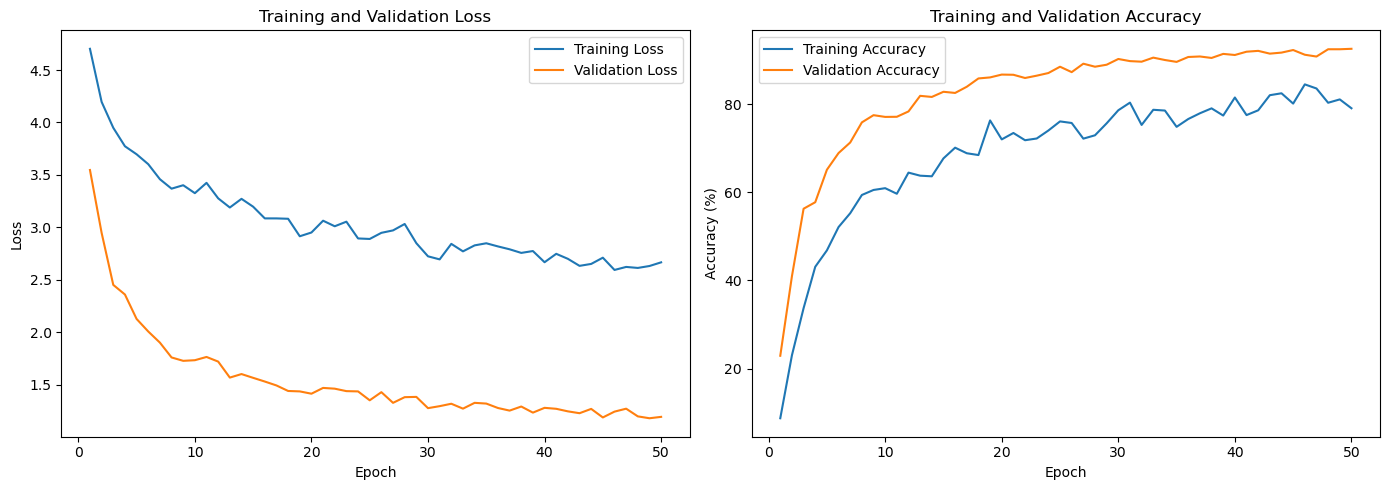

In [7]:
# Plot Loss and Accuracy
epochs_range = range(1, len(val_losses) + 1)

plt.figure(figsize=(14, 5))

print("Train Losses: ", train_losses)
print("Val Losses: ", val_losses)
print("Train Accuracies: ", train_accuracies)
print("Val Accuracies: ", val_accuracies)
print("Epochs Range: ", epochs_range)

# Loss Plot
plt.subplot(1, 2, 1)
plt.plot(epochs_range, train_losses, label='Training Loss')
plt.plot(epochs_range, val_losses, label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training and Validation Loss')
plt.legend()

# Accuracy Plot
plt.subplot(1, 2, 2)
plt.plot(epochs_range, train_accuracies, label='Training Accuracy')
plt.plot(epochs_range, val_accuracies, label='Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy (%)')
plt.title('Training and Validation Accuracy')
plt.legend()

plt.tight_layout()
plt.show()


## 6. Model Evaluation and Confusion Matrix

After training, we'll evaluate the model on the validation set and create a confusion matrix to understand where the model is making mistakes.


/tmp/ipykernel_1562416/1403973625.py:2: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load(checkpoint_dir / "best_model.pth")["model_state_dict"]

Evaluating:   0%|          | 0/14 [00:00<?, ?it/s]

Evaluating:   7%|▋         | 1/14 [00:08<01:51,  8.56s/it]

Evaluating:  14%|█▍        | 2/14 [00:08<00:44,  3.73s/it]

Evaluating:  21%|██▏       | 3/14 [00:09<00:23,  2.18s/it]

Evaluating:  29%|██▊       | 4/14 [00:09<00:14,  1.45s/it]

Evaluating:  36%|███▌      | 5/14 [00:16<00:29,  3.31s/it]

Evaluating:  43%|████▎     | 6/14 [00:16<00:18,  2.30s/it]

Evaluating:  50%|█████     | 7/14 [00:16<00:11,  1.66s/it]

Evaluating:  57%|█████▋    | 8/14 [00:17<00:08,  1.42s/it]

Evaluating:  64%|██████▍   | 9/14 [00:23<00:13,  2.72s/it]

Evaluating:  71%|███████▏  | 10/14 [00:23<00:07,  1.98s/it]

Evaluating:  79%|███████▊  | 11/14 [00:24<00:04,  1.48s/it]

Evaluating:  86%|████████▌ | 12/14 [00:24<00:02,  1.13s/it]

Evaluating:  93%|█████████▎| 13/14 [00:30<00:02,  2.51s/it]

Evaluating: 100%|██████████| 14/14 [00:30<00:00,  1.83s/it]

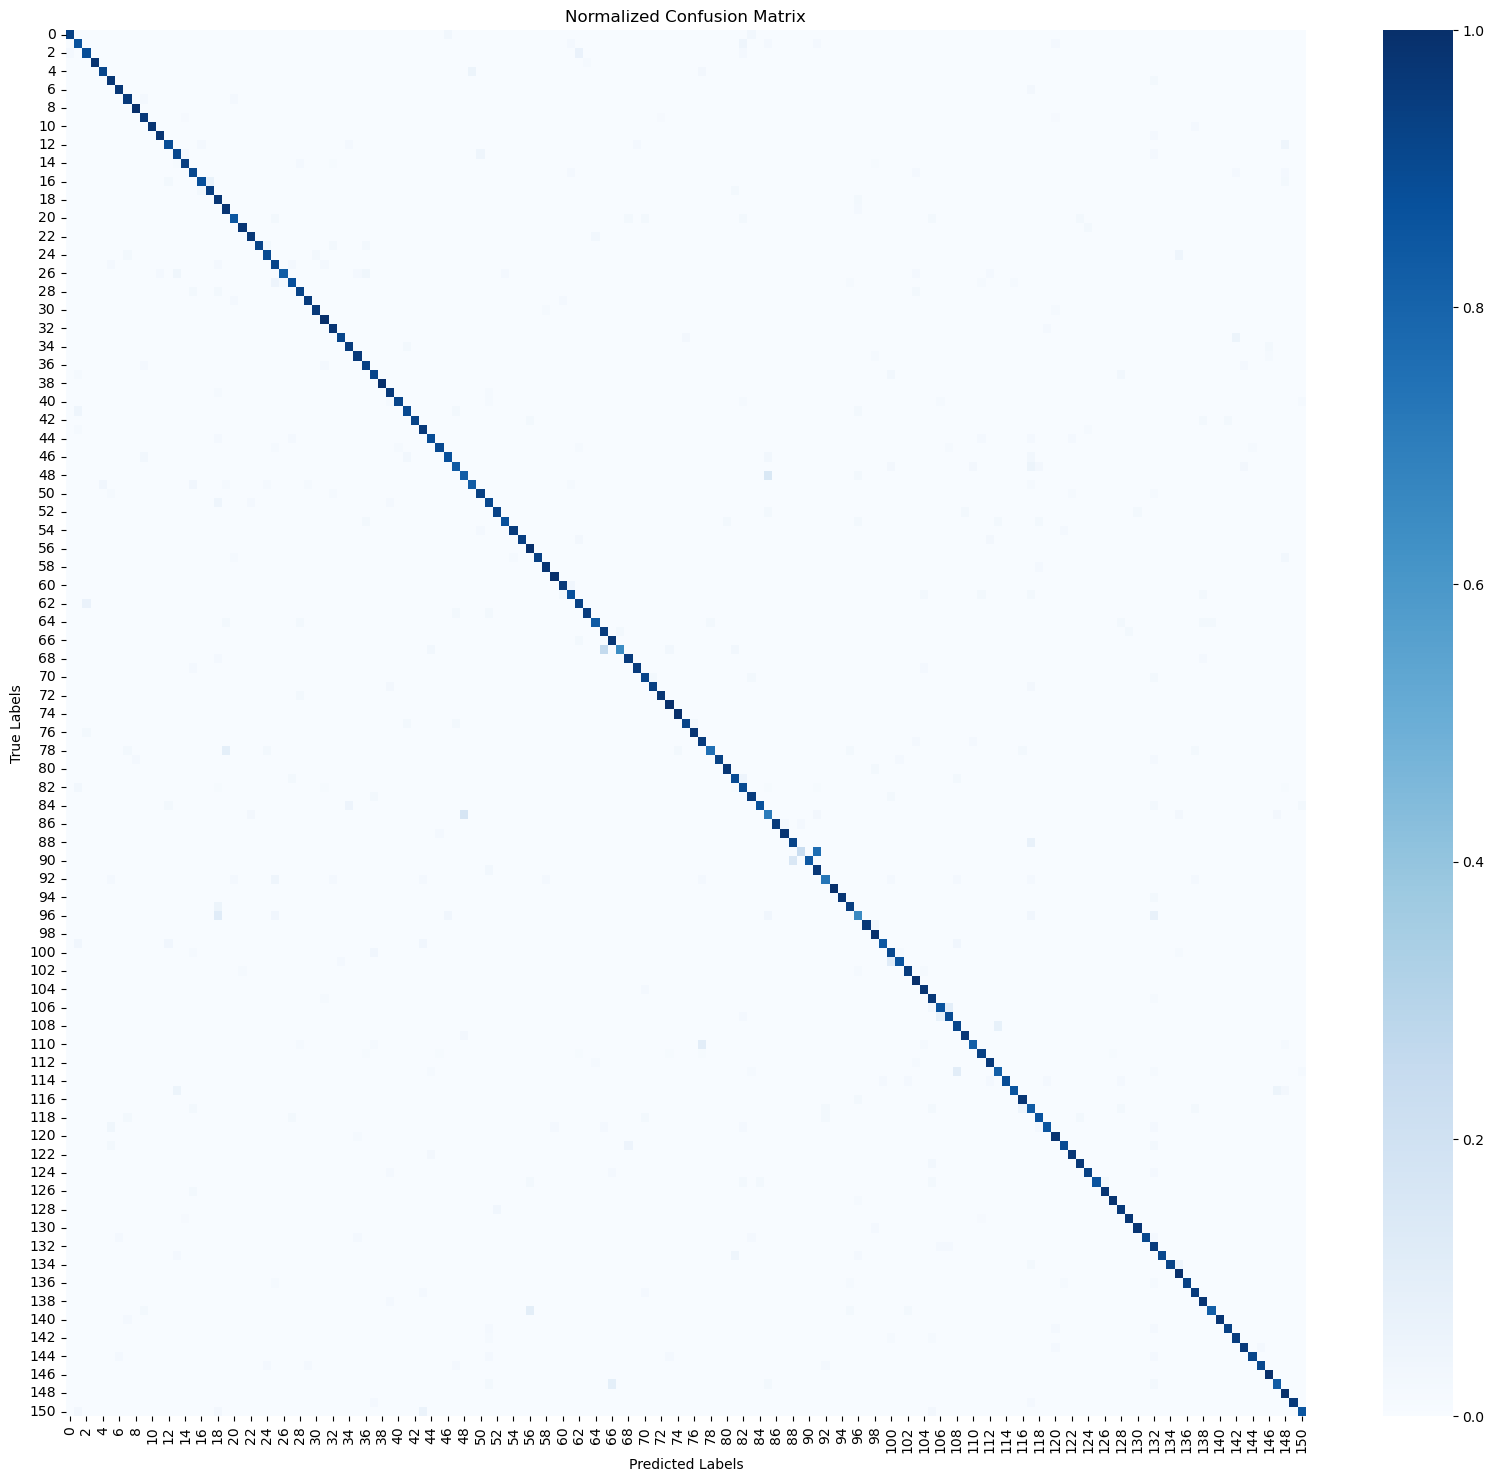

              precision    recall  f1-score   support

        Abra       0.96      0.93      0.95        29
  Aerodactyl       0.82      0.87      0.84        46
    Alakazam       0.91      0.89      0.90        45
       Arbok       1.00      0.98      0.99        52
    Arcanine       0.94      0.92      0.93        36
    Articuno       0.86      0.97      0.91        38
    Beedrill       0.94      0.97      0.96        33
  Bellsprout       0.92      0.96      0.94        47
   Blastoise       0.98      1.00      0.99        47
   Bulbasaur       0.95      0.96      0.96        80
  Butterfree       1.00      0.98      0.99        50
    Caterpie       0.98      0.98      0.98        46
     Chansey       0.93      0.89      0.91        45
   Charizard       0.87      0.91      0.89        45
  Charmander       0.97      0.94      0.95        88
  Charmeleon       0.85      0.91      0.88        44
    Clefable       0.95      0.88      0.91        42
    Clefairy       0.93    

In [8]:
# Load the best model
model.load_state_dict(torch.load(checkpoint_dir / "best_model.pth")["model_state_dict"])
model.eval()

# Collect all predictions and labels
all_preds = []
all_labels = []

with torch.no_grad():
    for images, labels in tqdm(val_loader, desc="Evaluating", leave=False):
        images = images.to(device)
        labels = labels.to(device)

        with torch.amp.autocast(enabled=(device.type == "cuda"), device_type="cuda" if cuda.is_available() else "cpu"):
            outputs = model(images)
            _, predicted = torch.max(outputs.data, 1)

        all_preds.extend(predicted.cpu().numpy())
        all_labels.extend(labels.cpu().numpy())

# Generate Confusion Matrix
cm = confusion_matrix(all_labels, all_preds)
cm_norm = confusion_matrix(all_labels, all_preds, normalize='true')

plt.figure(figsize=(20, 18))
sns.heatmap(cm_norm, annot=False, cmap='Blues')
plt.title('Normalized Confusion Matrix')
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.show()

# Classification Report
report = classification_report(all_labels, all_preds, target_names=[idx_to_label[i] for i in range(num_classes)])
print(report)

# Identify most confused classes
def get_most_confused(cm: np.ndarray, idx_to_label: dict[int, str], top_n: int = 10) -> list[tuple[str, str, float]]:
    cm_copy = cm.copy().astype(float)
    np.fill_diagonal(cm_copy, 0)  # Remove correct predictions
    confusions = []
    for i in range(cm_copy.shape[0]):
        for j in range(cm_copy.shape[1]):
            if cm_copy[i, j] > 0:
                confusions.append((idx_to_label[i], idx_to_label[j], cm_copy[i, j]))
    # Sort by highest confusion
    confusions_sorted = sorted(confusions, key=lambda x: x[2], reverse=True)
    return confusions_sorted[:top_n]

most_confused = get_most_confused(cm, idx_to_label, top_n=10)
print("Most Confused Classes:")
for true_label, pred_label, count in most_confused:
    print(f"{true_label} confused with {pred_label}: {count} times")


## 7. Inference on Sample Images

We'll run inference on a subset of validation images and display them with the predicted labels.


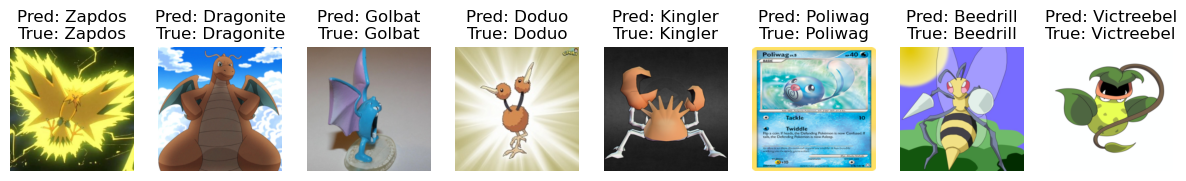

In [9]:
# Function to display images with predictions
def display_predictions(model: nn.Module, dataloader: DataLoader, idx_to_label: dict[int, str], num_images: int = 8):
    model.eval()
    images_shown = 0
    plt.figure(figsize=(15, 10))

    with torch.no_grad():
        for images, labels in dataloader:
            images = images.to(device)
            labels = labels.to(device)
            with torch.amp.autocast(enabled=(device.type == "cuda"), device_type="cuda" if cuda.is_available() else "cpu"):
                outputs = model(images)
                _, predicted = torch.max(outputs, 1)
            for i in range(images.size(0)):
                if images_shown >= num_images:
                    break
                img = images[i].cpu().numpy().transpose((1, 2, 0))
                img = np.clip((img * np.array([0.229, 0.224, 0.225])) +
                              np.array([0.485, 0.456, 0.406]), 0, 1)
                plt.subplot(1, num_images, images_shown + 1)
                plt.imshow(img)
                plt.title(f"Pred: {idx_to_label[predicted[i].item()]}\nTrue: {idx_to_label[labels[i].item()]}")
                plt.axis('off')
                images_shown += 1
            if images_shown >= num_images:
                break
    plt.show()

# Display predictions on 8 validation images
display_predictions(model, val_loader, idx_to_label, num_images=8)
